# Modelagem de dados para quatro atividades enzimáticas: fpase, cmcase, beta-glicosidase e xilanase - conjunto de dados todos  -- ABS sem faixas de ruidos


In [1]:
# criei umas marcações para acesso rápido utilizando @, exemplo @outliers

## Importação de módulos utilizandos durante todo o processamento

In [1]:
#importação de módulos
#@import
import pandas as pd
import numpy as np
import time

#Para plotagens
import matplotlib.pyplot as plt
import seaborn as sns

#Filtro Digital de Savitzky-Golay para suavização dos dados
from scipy.signal import savgol_filter

#pré-processamento:

#Transformação nos dados
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, scale, LabelEncoder
#Seleção de atributos
from sklearn.feature_selection import mutual_info_regression, SelectKBest, SelectPercentile

#particionamento de base de dados para treinamento, validação e teste
from sklearn.model_selection import train_test_split

#algoritmos para o aprendizado:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from xgboost import XGBRegressor

#Métricas para avaliação dos algoritmos de aprendizado
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## FUNÇÕES GERAIS

In [3]:
#@fglobal

### Funções para validação dos modelos multivariados

In [2]:
#@fvalidações
#RMSE
def rmse(ref,pred):
    #recebe como entrada dois vetores dos valores de referência e preditos
    ref = pd.Series(ref)
    pred=pd.Series(pred)
    n=len(ref) #total de amostras
    mse = 0
    for i in range(n):
        mse +=(ref[i]-pred[i])**2
    mse=mse/n
    rmse=np.sqrt(mse)
    return rmse

#bias
def bias(ref,pred):
    ref = pd.Series(ref)
    pred=pd.Series(pred)
    b=0
    n = len(ref)
    for r, p in zip(ref, pred):
        b += (r-p)
    return (b/n)
    
#SEP
def sep(ref,pred):
    ref = pd.Series(ref)
    pred=pd.Series(pred)
    b = bias(ref,pred)
    sep = 0
    n = len(ref)
    for i in range(n):    
        sep +=(ref[i]-pred[i]-b)**2
    sep = np.sqrt(sep/(n-1))
    return sep
    
#RPIQ
def rpiq(ref, pred):
    ref = pd.Series(ref)
    pred=pd.Series(pred)
    q1 = ref.quantile(0.25)
    q3 = ref.quantile(0.75)
    iq=q3-q1
    rpiq = iq/rmse(ref, pred)
    return rpiq
#RPD
def rpd(ref,pred):
    ref = pd.Series(ref)
    pred=pd.Series(pred)
    rpd = np.std(ref)/rmse(ref,pred)
    return rpd

#RER
def rer(ref,pred):
    ref = pd.Series(ref)
    pred=pd.Series(pred)
    rer = (np.max(ref) -np.min(ref) )/sep(ref,pred)
    return rer

#R2
def getr2(ref,pred):
    r2=r2_score(ref,pred)
    return r2
#MSE
def getmse(ref,pred):
    mse = mean_squared_error(ref,pred)
    return mse
#RMSE forma simples de calcular
def getrmse(ref,pred):
    rmse = np.sqrt(mean_squared_error(ref,pred))
    return rmse

### Funções de pré-processamento

In [3]:
#funções gerais de pré-processamento de spectros
#@fspec
#MSC(Multiplicative scatter correction)correção do espalhamento multiplicativo de sinal
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
    return (data_msc, ref)

#Variável normal padrão (SNV) Standard Normal Variate
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    data_snv = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Apply correction
        data_snv[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
    return data_snv

### Função teste para correção de espectros

In [4]:
#@ftestes
def executePreSpec(dados,wint,wtxt):
    x = dados.loc[:,wtxt].values
    w = wint
    
    Xmsc = msc(x)[0] # Take the first element of the output tuple
    Xsnv = snv(x)
    ## Plot spectra
    plt.figure(figsize=(8,9))
    with plt.style.context(('ggplot')):
        ax1 = plt.subplot(311)
        plt.plot(w, x.T)
        plt.title('Original data')
        ax2 = plt.subplot(312)
        plt.plot(w, Xmsc.T)
        plt.ylabel('Absorbance spectra')
        plt.title('MSC')
        ax2 = plt.subplot(313)
        plt.plot(w, Xsnv.T)
        plt.xlabel('Wavelength (nm)')
        plt.title('SNV')
        plt.show()

### Funções para plotar resultados

In [5]:
#@grafResiduos
def graficoResiduos(modelo, treino_teste, y_c, y_cv,y_p):
    #gráfico de resíduos: 
    res_c = treino_teste[2] - y_c #resíduos da calibração
    res_cv = treino_teste[2] - y_cv #residuos da validação
    res_p = treino_teste[3] - y_p #resíduos da predição
    residuos = [res_c, res_cv, res_p]
    ys = [y_c, y_cv, y_p]
    modelos = ['cal','val','pred']
    cores = ['b','r','k']
    cores_ae=['b','g','r','y']
    fig = plt.figure(figsize=(20,20))
    plt.subplots_adjust(hspace = 0.3, wspace=0.2)
    for i,res, m in zip([0,1,2],residuos, modelos):   
        ig = i+1
        for cor,j in zip(cores_ae,[0,1,2,3]):
            ax = fig.add_subplot(4,3,ig)
            ax = sns.residplot(res.iloc[:,j],ys[i][:,j],  color=cor, robust=True,label=var_ae[j])
            ax.set_title(modelo+':Resíduos('+m+')')
            ax.set_xlabel('Preditos')
            ax.set_ylabel('Resíduos')
            plt.legend(loc='best')
            ig+=3

In [6]:
#@grafHistogramas
def graficoHist(modelo, treino_teste, y_c, y_cv,y_p):
    res_c = treino_teste[2] - y_c #resíduos da calibração
    res_cv = treino_teste[2] - y_cv #residuos da validação
    res_p = treino_teste[3] - y_p #resíduos da predição
    #histograma dos resíduos para verificar se segue uma distribuição normal
    #gráfico de resíduos: histograma
    residuos = [res_c, res_cv, res_p]
    modelos = ['cal','val','pred']
    cores = ['b','r','k']
    cores_ae=['b','g','r','y']
    for i,res, m in zip([0,1,2],residuos, modelos):   
        fig = plt.figure(figsize=(20,5))
        plt.subplots_adjust(hspace = 0.5, wspace=0.1)

        for cor,j in zip(cores_ae,[0,1,2,3]):
            ax = fig.add_subplot(1,4,j+1)
            ax = sns.distplot(res.iloc[:,j], color=cores_ae[j], kde=False, label=var_ae[j]);
            ax.set_title(modelo+' :Histograma dos resíduos('+m+')')

In [7]:
#gráfico: reais  x preditos - separando calibração validação predição
#@grafreaispred
def graficoReaisPreditosSep(modelo, treino_teste, y_c, y_cv,y_p):
    res_c = treino_teste[2] #variável resposta da calibração
    res_cv = treino_teste[2] #variável resposta da validação
    res_p = treino_teste[3]#variável resposta da predição
    reais= [res_c, res_cv, res_p]
    ys = [y_c, y_cv, y_p]
    modelos = ['cal','val','pred']
    cores = ['b','r','k']
    cores_ae=['b','g','r','y']
    mark=['x','1','+']
    fig = plt.figure(figsize=(20,20))
    plt.subplots_adjust(hspace = 0.3, wspace=0.2)
    for i,re, m in zip([0,1,2],reais, modelos):   
        ig = i+1
        for cor,j in zip(cores_ae,[0,1,2,3]):
            ax = fig.add_subplot(4,3,ig)
            ax.scatter(re.iloc[:,j], ys[i][:,j],marker=mark[i],c=cores[i], edgecolors='k', label=var_ae[j]+'\n'+m)
            ax.plot(ys[i][:,j], ys[i][:,j], color=cores[i])
            
            ax.set_title(modelo)
            ax.set_xlabel('Reais')
            ax.set_ylabel('Preditos')
            plt.legend(loc='best')
            ig+=3

In [8]:
#gráfico: reais  x preditos - juntando cal, val e predição
#@grafreaispred
def graficoReaisPreditos(modelo, treino_teste, y_c, y_cv,y_p):
    res_c = treino_teste[2] #variável resposta da calibração
    res_cv = treino_teste[2] #variável resposta da validação
    res_p = treino_teste[3]#variável resposta da predição
    reais= [res_c, res_cv, res_p]
    ys = [y_c, y_cv, y_p]
    modelos = ['cal','val','pred']
    cores = ['b','r','k']
    cores_ae=['b','g','r','y']
    mark=['x','1','+']
    fig = plt.figure(figsize=(10,30))
    plt.subplots_adjust(hspace = 0.3, wspace=0.2)
    
    for i in range(4):
        for j in range(3):
            ax = fig.add_subplot(4,1,i+1)
            ax.scatter(reais[j].iloc[:,i], ys[j][:,i],c=cores[j],marker=mark[j],label=modelos[j])
            if j == 0:
                ax.plot(ys[j][:,i], ys[j][:,i], color=cores[j], label=modelos[j])        
        ax.set_title(modelo+'-->'+var_ae[i])
        ax.set_xlabel('Reais')
        ax.set_ylabel('Preditos')
        plt.legend(loc='best')
    

In [9]:
#@grafTreinamento
def graficoTreinamento(modelo, y_treino, y_c, y_cv):
    ###################################################################
    #Gráficos de treinamento e validação cruzada para todas as atividades
    #cria um data frame com os valores reais e preditos na calibração e validação
    df_cv = {}
    for valor in var_ae:
        df_cv[valor] = []
    i=0
    for valor in var_ae:
        df = pd.DataFrame(columns=['reais','cal','val'], index=y_treino.index)
        df['reais'] = y_treino[valor]
        df['cal'] = pd.DataFrame(y_c[:,i],index= y_treino.index)
        df['val'] = pd.DataFrame(y_cv[:,i],index= y_treino.index)
        i +=1
        df_cv[valor] = df.copy()
    #cria data frame com os valores dos intervalos de medições
    df_cv_inter ={}
    for valor in var_ae:
        df_cv_inter[valor] = []
    for valor in var_ae:
        df_cv_inter[valor] = df_cv[valor].copy()
        df_cv_inter[valor]['inter'] = dados.loc[:,'inter']
    #ordena valores pelo intervalo
    df_ord_treino = {}
    for valor in var_ae:
        df_ord_treino[valor] = []
    for valor in var_ae:
        df_ord_treino[valor] = df_cv_inter[valor].sort_values(['inter'])
    x = list(df_ord_treino['xilanase']['inter'])

    #calculando a média para cada ponto
    df_treino_media = {}
    for valor in var_ae:
        df_treino_media[valor] = []
    for valor in var_ae:
        df_treino_media[valor] = df_ord_treino[valor].groupby('inter').mean()

    x = list(df_treino_media['xilanase'].index)
    var = ['reais', 'cal','val']
    tipo = ['ko-.', 'bo-.','ro-.']
    tipoAE= ['bo-.', 'go-.','ro-.', 'yo-.']
    fig = plt.figure(figsize=(15,5))
    j=1
    plt.subplots_adjust(hspace = 0.7, wspace=0.5)
    for valor in var_ae:
        ax = fig.add_subplot(2,2,j)
        for i in range(3):
            ax.plot(x,df_treino_media[valor][var[i]], tipo[i], label=var[i])
            ax.legend(loc=2)
            ax.set_title('Calibração e validação cruzada:'+modelo+': '+valor)
            ax.set_xlabel('Tempo ')
            ax.set_ylabel('Atividade enzimática') 
            ax.set_xticks(x)
        j+=1

In [10]:
#@grafTreinamento
def graficoTreinamentoNormal(modelo, y_treino, y_c, y_cv):
    ###################################################################
    #Gráficos de treinamento e validação cruzada para todas as atividades
    #cria um data frame com os valores reais e preditos na calibração e validação
    df_cv = {}
    for valor in var_ae:
        df_cv[valor] = []
    i=0
    for valor in var_ae:
        df = pd.DataFrame(columns=['reais','cal','val'], index=y_treino.index)
        df['reais'] = y_treino[valor]
        df['cal'] = pd.DataFrame(y_c[:,i],index= y_treino.index)
        df['val'] = pd.DataFrame(y_cv[:,i],index= y_treino.index)
        i +=1
        df_cv[valor] = df.copy()
    #cria data frame com os valores dos intervalos de medições
    df_cv_inter ={}
    for valor in var_ae:
        df_cv_inter[valor] = []
    for valor in var_ae:
        df_cv_inter[valor] = df_cv[valor].copy()
        df_cv_inter[valor]['inter'] = dados.loc[:,'inter']
    #ordena valores pelo intervalo
    df_ord_treino = {}
    for valor in var_ae:
        df_ord_treino[valor] = []
    for valor in var_ae:
        df_ord_treino[valor] = df_cv_inter[valor].sort_values(['inter'])
    x = list(df_ord_treino['xilanase']['inter'])

    var = ['reais', 'cal','val']
    tipo = ['ko-.', 'bo-.','ro-.']
    tipoAE= ['bo-.', 'go-.','ro-.', 'yo-.']
    fig = plt.figure(figsize=(15,5))
    j=1
    plt.subplots_adjust(hspace = 0.7, wspace=0.5)
    for valor in var_ae:
        ax = fig.add_subplot(2,2,j)
        for i in range(3):
            ax.plot(x,df[valor][var[i]], tipo[i], label=var[i])
            ax.legend(loc=2)
            ax.set_title('Calibração e validação cruzada:'+modelo+': '+valor)
            ax.set_xlabel('Tempo ')
            ax.set_ylabel('Atividade enzimática') 
            ax.set_xticks(x)
        j+=1

In [11]:
#@grafTreinamento grandes
def graficoTreinamentoG(modelo, y_treino, y_c, y_cv):
    ###################################################################
    #Gráficos de treinamento e validação cruzada para todas as atividades
    #cria um data frame com os valores reais e preditos na calibração e validação
    df_cv = {}
    for valor in var_ae:
        df_cv[valor] = []
    i=0
    for valor in var_ae:
        df = pd.DataFrame(columns=['reais','cal','val'], index=y_treino.index)
        df['reais'] = y_treino[valor]
        df['cal'] = pd.DataFrame(y_c[:,i],index= y_treino.index)
        df['val'] = pd.DataFrame(y_cv[:,i],index= y_treino.index)
        i +=1
        df_cv[valor] = df.copy()
    #cria data frame com os valores dos intervalos de medições
    df_cv_inter ={}
    for valor in var_ae:
        df_cv_inter[valor] = []
    for valor in var_ae:
        df_cv_inter[valor] = df_cv[valor].copy()
        df_cv_inter[valor]['inter'] = dados.loc[:,'inter']
    #ordena valores pelo intervalo
    df_ord_treino = {}
    for valor in var_ae:
        df_ord_treino[valor] = []
    for valor in var_ae:
        df_ord_treino[valor] = df_cv_inter[valor].sort_values(['inter'])
    x = list(df_ord_treino['xilanase']['inter'])

    #calculando a média para cada ponto
    df_treino_media = {}
    for valor in var_ae:
        df_treino_media[valor] = []
    for valor in var_ae:
        df_treino_media[valor] = df_ord_treino[valor].groupby('inter').mean()

    x = list(df_treino_media['xilanase'].index)
    var = ['reais', 'cal','val']
    tipo = ['ko-.', 'bo-.','ro-.']
    tipoAE= ['bo-.', 'go-.','ro-.', 'yo-.']
    fig = plt.figure(figsize=(15,10))
    j=1
    plt.subplots_adjust(hspace = 0.7, wspace=0.5)
    for valor in var_ae:
        ax = fig.add_subplot(4,1,j)
        for i in range(3):
            ax.plot(x,df_treino_media[valor][var[i]], tipo[i], label=var[i])
            ax.legend(loc=2)
            ax.set_title('Calibração e validação cruzada:'+modelo+': '+valor)
            ax.set_xlabel('Tempo')
            ax.set_ylabel('Atividade enzimática') 
            ax.set_xticks(x)
        j+=1

In [12]:
#@grafTeste (predição )
def graficoTeste(modelo, y_teste, y_p):
    ###################################################################
    #para todas as atividades
    #cria um data frame com os valores reais e preditos para os dados de teste
    df_pred = {}
    for valor in var_ae:
        df_pred[valor] = []
    i=0
    for valor in var_ae:
        df =pd.DataFrame(columns=['reais','preditos'], index= y_teste.index)
        df['reais'] = y_teste[valor]
        df['preditos'] = pd.DataFrame(y_p[:,i],index= y_teste.index)
        i +=1
        df_pred[valor] = df.copy()
        
    #cria data frame com os valores dos intervalos de medições
    df_pred_inter = {}
    for valor in var_ae:
        df_pred_inter[valor] = []
    for valor in var_ae:
        df_pred_inter[valor] = df_pred[valor].copy()
        df_pred_inter[valor]['inter'] = dados.loc[:,'inter']

    #ordena valores pelo intervalo
    df_ord_teste = {}
    for valor in var_ae:
        df_ord_teste[valor] = []
    for valor in var_ae:
        df_ord_teste[valor] = df_pred_inter[valor].sort_values(['inter'])

    #calculando a média para cada ponto
    df_teste_media = {}
    for valor in var_ae:
        df_teste_media[valor] = []
    for valor in var_ae:
        df_teste_media[valor] = df_ord_teste[valor].groupby('inter').mean()

    x = list(df_teste_media['xilanase'].index)
    var = ['reais', 'preditos']
    tipoAE= ['bo-.', 'go-.','ro-.', 'yo-.']
    j = 0    
    fig = plt.figure(figsize=(15,5))
    plt.subplots_adjust(hspace = 0.7, wspace=0.5)
    for valor in var_ae:
        ax = fig.add_subplot(2,2,j+1)
        ax.plot(x,df_teste_media[valor][var[0]], 'ko-.', label=var[0])
        ax.plot(x,df_teste_media[valor][var[1]], tipoAE[j], label=var[1])
        j +=1
        ax.legend(loc=2)
        ax.set_title('Validação externa: Modelo '+modelo+':'+valor)
        ax.set_xlabel('Tempo')
        ax.set_ylabel('Atividade enzimática') 
        ax.set_xticks(x)

In [13]:
#@grafTeste grande (predição )
def graficoTesteG(modelo, y_teste, y_p):
    ###################################################################
    #para todas as atividades
    #cria um data frame com os valores reais e preditos para os dados de teste
    df_pred = {}
    for valor in var_ae:
        df_pred[valor] = []
    i=0
    for valor in var_ae:
        df =pd.DataFrame(columns=['reais','preditos'], index= y_teste.index)
        df['reais'] = y_teste[valor]
        df['preditos'] = pd.DataFrame(y_p[:,i],index= y_teste.index)
        i +=1
        df_pred[valor] = df.copy()
        
    #cria data frame com os valores dos intervalos de medições
    df_pred_inter = {}
    for valor in var_ae:
        df_pred_inter[valor] = []
    for valor in var_ae:
        df_pred_inter[valor] = df_pred[valor].copy()
        df_pred_inter[valor]['inter'] = dados.loc[:,'inter']

    #ordena valores pelo intervalo
    df_ord_teste = {}
    for valor in var_ae:
        df_ord_teste[valor] = []
    for valor in var_ae:
        df_ord_teste[valor] = df_pred_inter[valor].sort_values(['inter'])

    #calculando a média para cada ponto
    df_teste_media = {}
    for valor in var_ae:
        df_teste_media[valor] = []
    for valor in var_ae:
        df_teste_media[valor] = df_ord_teste[valor].groupby('inter').mean()

    x = list(df_teste_media['xilanase'].index)
    var = ['reais', 'preditos']
    tipoAE= ['bo-.', 'go-.','ro-.', 'yo-.']
    j = 0    
    fig = plt.figure(figsize=(15,15))
    plt.subplots_adjust(hspace = 0.7, wspace=0.5)
    for valor in var_ae:
        ax = fig.add_subplot(4,1,j+1)
        ax.plot(x,df_teste_media[valor][var[0]], 'ko-.', label=var[0])
        ax.plot(x,df_teste_media[valor][var[1]], tipoAE[j], label=var[1])
        j +=1
        ax.legend(loc=2)
        ax.set_title('Validação externa: Modelo '+modelo+':'+valor)
        ax.set_xlabel('Tempo')
        ax.set_ylabel('Atividade enzimática') 
        ax.set_xticks(x)

### Função para calcular intervalo de confiança para a média dos modelos criados:

In [14]:
#@interConfiança
#para intervalo de confiança = 95%  Z = 1,96
# a proporção de acertos do modelo será de p +- (valor calculado para intervalo de confiança da proporção de acerto)
# seja n o número amostras (neste caso o número de modelos criados, exemplo 40)
#P(a) = o resultado da proporção de acerto
#P(e) = proporção de erro
#p =- intervalo de confiança
#ic = z*raizquadrada((pa*(1-pa))/n)
#exemplo:
def calculaIntConf(n,pa):
    z = 1.96
    ic = z*(np.sqrt((pa*(1-pa))/n))
    ic_min = p - ic
    ic_max = pa + ic
    return ic_min, ic_max

## Base de dados

In [15]:
#@data
#Escolha da base de dados

In [15]:
#base de dados contendo todos os dados
dados= pd.read_excel('A_dados.xlsx',sheet_name='todos')
dados_back = dados.copy()

In [16]:
#@backupdata
dados = dados_back.copy() #backup da base para uso posterior rápido

In [17]:
#@dadosshape
dados.shape #tamanho da base dados

(1391, 713)

In [18]:
#Separar somente as amostras que contenham todas as atividades enzimáticas
dados = dados.loc[(dados['betaglicosidase'].notnull()) 
                         & (dados['cmcase'].notnull()) 
                         & (dados['fpase'].notnull())
                         &(dados['xilanase'].notnull())]
resultados = '\nTotal geral de amostras com todas as atividades enzimáticas:'+str(dados.shape[0])
print(resultados)


Total geral de amostras com todas as atividades enzimáticas:908


In [ ]:
#escolha a base de dados que quer trabalhar por extrato enzimático
#dados = pd.read_excel('A_dados.xlsx',sheet_name='celluclast')
#dados = pd.read_excel('A_dados.xlsx',sheet_name='bio')
#dados = pd.read_excel('A_dados.xlsx',sheet_name='celic')

#dados = dados[(dados['eenz'] == 'celluclast')]
#dados = dados[(dados['eenz'] == 'eeta')]
#dados = dados[(dados['eenz'] == 'ctec2')]
#dados = dados[(dados['eenz'] == 'eeta')&(dados['experimento']=='biof')]

In [99]:
dados = dados[(dados['eenz'] == 'eeta')] #base de dados do extrato EETA exp 1
dados.shape

(129, 713)

In [100]:
dados = dados[(dados['eenz'] == 'eeta')&(dados['experimento']=='biof')] #base de dados do EETA somente da fermentação

In [2446]:
dadosB1 = dados[(dados['experimento']=='biof')]
dadosB1.shape
#dadosB = dados[(dados['eenz'] == 'eeta')&(dados['experimento']=='bioB')] #fermentação em bior 2
#dadosE = dados[(dados['eenz'] == 'eeta')&(dados['experimento']=='bioE')] #fermentação em erlemeyer(paralelo a bior2)

(81, 713)

In [1235]:
dadosB2 = dados[dados['experimento']=='bioB']# eeta de fermentação em bior exp 2
dadosB2.shape

(21, 713)

In [1236]:
dadosE = dados[dados['experimento']=='bioE']# eeta de fermentação em erlemeyer exp2 
dadosE.shape

(24, 713)

In [2447]:
dadosD1= dados[dados['experimento']=='biod1']# eeta de desnaturação 1 exp 1
dadosD1.shape

(33, 713)

In [1238]:
dadosD2= dados[dados['experimento']=='biod2']# eeta de desnaturação 2 exp 2
dadosD2.shape

(33, 713)

In [2448]:
frames = [dadosB1, dadosD1]
dados = pd.concat(frames)

In [2441]:
dados = dadosB1.copy()

In [31]:
dados.shape

(81, 717)

In [ ]:
#Separar somente as amostras que contenham betaglicosidase
dados = dados.loc[(dados['betaglicosidase'].notnull()) ]
resultados = '\nTotal geral de amostras para betaglicosidase:'+str(dados.shape[0])

In [ ]:
#Separar somente as amostras que contenham cmcase
dados = dados.loc[(dados['cmcase'].notnull()) ]
resultados = '\nTotal geral de amostras para cmcase:'+str(dados.shape[0])

In [ ]:
#Separar somente as amostras que contenham fpase
dados = dados.loc[(dados['fpase'].notnull()) ]
resultados = '\nTotal geral de amostras para fpase:'+str(dados.shape[0])

In [ ]:
#Separar somente as amostras que contenham xilanase
dados = dados.loc[(dados['xilanase'].notnull()) ]
resultados = '\nTotal geral de amostras para xilanase:'+str(dados.shape[0])

## Estatística básica do conjunto de dados: ativbidade enzimática

In [17]:
#@statistic

In [19]:
dados['betaglicosidase'].describe()

count     908.000000
mean      209.983831
std       378.934008
min         0.030827
25%        54.525863
50%       130.137430
75%       205.710183
max      2918.568120
Name: betaglicosidase, dtype: float64

In [20]:
dados['cmcase'].describe()

count    908.000000
mean      78.361771
std       44.634243
min        0.011206
25%       65.103734
50%       77.660274
75%       92.831888
max      287.959991
Name: cmcase, dtype: float64

In [19]:
dados['fpase'].describe()

count    923.000000
mean      25.673199
std       21.444590
min        0.005000
25%       14.273103
50%       20.915212
75%       35.942958
max      163.328003
Name: fpase, dtype: float64

In [21]:
dados['xilanase'].describe()

count     908.000000
mean      434.535666
std       396.625550
min         0.072595
25%       174.807225
50%       349.312036
75%       667.230169
max      2961.144040
Name: xilanase, dtype: float64

In [484]:
#verifica quantos são os valores nulos no conjunto de dados por coluna
#dados.isnull().sum()

## imprimindo os espectros:

In [22]:
#@plotscpec
#criando vetores com os nomes dos atributos apenas para plotagem

var_abs_int = np.arange(1100,2496,2)
var_abs_txt=[]
for valor in var_abs_int:
    var_abs_txt += [str(valor)+'nm']
var_ae=['betaglicosidase','cmcase','fpase','xilanase']

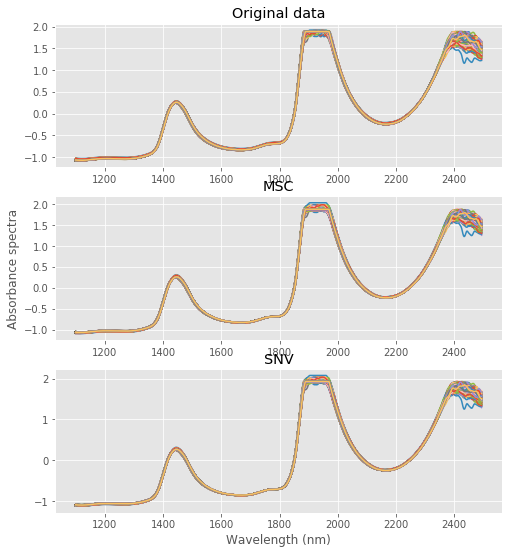

In [23]:
#teste das correções dos espectros:
#@testescorreções
executePreSpec(dados,var_abs_int,var_abs_txt)

In [24]:
X=dados.loc[:,var_abs_txt]
xT= np.transpose(X)
len(X.columns)

698

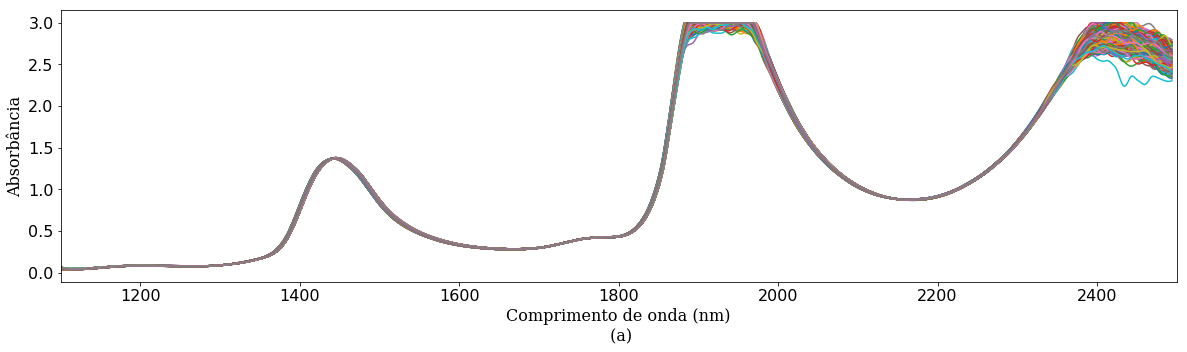

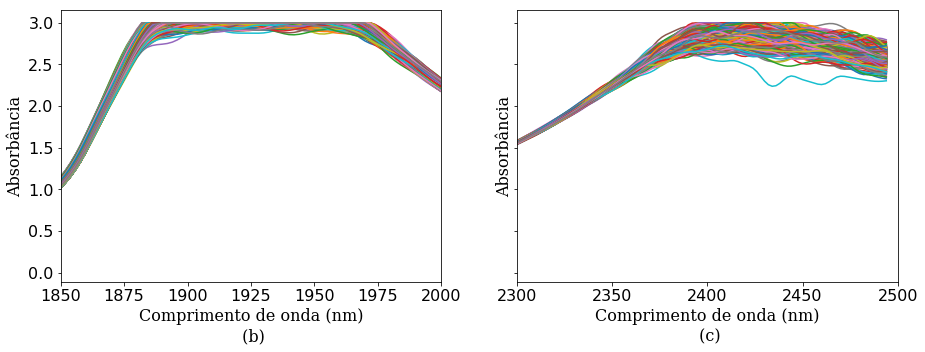

In [25]:
#gráfico de dispersão 3 em um

fonte = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
figuras = ['(a)','(b)','(c)']
limites = [[1100,2500],[1850,2000], [2300,2500]]
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
plt.subplots_adjust(hspace = 0.5, wspace=0.1)
ax.plot(var_abs_int, xT)
ax.grid(False)
ax.set_xlabel('Comprimento de onda (nm)\n (a)', fontdict=fonte)
ax.set_ylabel('Absorbância', fontdict=fonte)
ax.set_xlim(limites[0][0],limites[0][1])
ax.tick_params(labelsize=16)

_, [ax1,ax2] = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
ax1.plot(var_abs_int, xT)
ax1.grid(False)
ax1.set_xlabel('Comprimento de onda (nm)\n (b)', fontdict=fonte)
ax1.set_ylabel('Absorbância', fontdict=fonte)
ax1.set_xlim(limites[1][0],limites[1][1])
ax1.tick_params(labelsize=16)

ax2.plot(var_abs_int, xT)
ax2.grid(False)
ax2.set_xlabel('Comprimento de onda (nm)\n (c)', fontdict=fonte)
ax2.set_ylabel('Absorbância', fontdict=fonte)
ax2.set_xlim(limites[2][0],limites[2][1])
ax2.tick_params(labelsize=16)

plt.show()


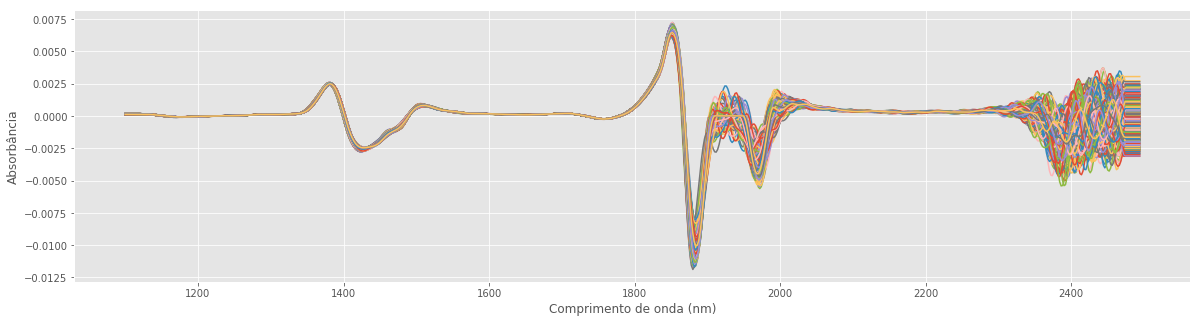

In [26]:
#Aplicando 2 derivada para impressão dos espectros:
X=dados.loc[:,'1100nm':'2494nm']
wl = np.arange(1100,2495,2)
X2 = savgol_filter(X,21,polyorder=2, deriv=2)
# Imprimendo gráfico para segunda derivada
plt.figure(figsize=(20,5))
with plt.style.context(('ggplot')):
    plt.plot(wl, X2.T)
    plt.xlabel('Comprimento de onda (nm)')
    plt.ylabel('Absorbância')
    plt.show()


In [53]:
#dados_bio1=dados[dados.loc[:,'experimento'] != 'biof']
#seleção de dados apenas da desnaturação

# Seleção de atributos relevantes

In [19]:
#@seleção de atributos
#1ºDefinimos os atributos importantes para determinação da atividade específica e veremos se utilizar todos os espectros ou os selecionados faz diferença no desempenho

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression, SelectKBest, SelectPercentile, mutual_info_classif, chi2

In [28]:
#denindo as variáveis iniciais para o pré-processamento
var_ae=['betaglicosidase','cmcase','fpase','xilanase']

#criando um vetor com os nomes das absorbâncias para seleção posterior
var_abs_int = np.arange(1100,2495,2)
var_abs_txt=[]
for valor in var_abs_int:
    var_abs_txt += [str(valor)+'nm']

In [29]:
#Definindo os dataFrames iniciais para começar o processamento da seleção de atributos
#Separando a matriz de dados independentes df_y, da de dados dependentes df_x
df_x = dados.loc[:,var_abs_txt] #absorbâncias
df_y = dados.loc[:,var_ae]#AE

In [31]:
df_x.head(5)

1100nm    1102nm    1104nm    1106nm    1108nm    1110nm    1112nm  \
710  0.034299  0.034316  0.034365  0.034483  0.034698  0.035024  0.035451   
711  0.036330  0.036267  0.036176  0.036125  0.036156  0.036290  0.036520   
712  0.035881  0.035590  0.035438  0.035454  0.035622  0.035896  0.036219   
713  0.035179  0.035056  0.034928  0.034866  0.034919  0.035102  0.035402   
714  0.034658  0.034638  0.034605  0.034636  0.034780  0.035040  0.035381   

       1114nm    1116nm    1118nm  ...    2476nm    2478nm    2480nm  \
710  0.035942  0.036455  0.036959  ...  2.586343  2.569360  2.558197   
711  0.036817  0.037139  0.037451  ...  2.633472  2.631909  2.625733   
712  0.036545  0.036860  0.037174  ...  2.610536  2.606123  2.594931   
713  0.035788  0.036231  0.036707  ...  2.527729  2.520406  2.514344   
714  0.035754  0.036137  0.036536  ...  2.585836  2.576738  2.567044   

       2482nm    2484nm    2486nm    2488nm    2490nm    2492nm    2494nm  
710  2.549708  2.540445  2.529844  2.520292  2.514482  2.512945  2.513940  
711  2.613571  2.595041  2.570789  2.542441  2.512763  2.485513  2.464201  
712  2.575879  2.550428  2.522418  2.496677  2.476537  2.461961  2.451295  
713  2.507968  2.499267  2.488241  2.477992  2.472582  2.473660  2.479099  
714  2.556880  2.546410  2.536578  2.528261  2.521858  2.518125  2.517375  

[5 rows x 698 columns]

In [32]:
df_y.head(5)

betaglicosidase    cmcase     fpase  xilanase
710         0.087354  0.021666  0.012690  0.107064
711         0.087354  0.021666  0.012690  0.107064
712         0.087354  0.021666  0.012690  0.107064
713         0.030827  0.021327  0.011302  0.099591
714         0.030827  0.021327  0.011302  0.099591

In [30]:
#treino_teste
#separando o conjunto de dados em treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(df_x,df_y,test_size=0.25, random_state=0)

# Imprime o tamanho das bases geradas
print('Particionamento para treinamento e teste:\n','X_treino:',x_treino.shape,'Y_treino:',y_treino.shape,'X_teste:', x_teste.shape,'Y_teste:', y_teste.shape)

Particionamento para treinamento e teste:
 X_treino: (681, 698) Y_treino: (681, 4) X_teste: (227, 698) Y_teste: (227, 4)


## Seleção de variáveis: método: mutua info regression:

In [31]:
var_ae=['betaglicosidase','cmcase','fpase','xilanase']
sel_mi={}
for valor in var_ae:
    sel_mi[valor] = mutual_info_regression(x_treino,y_treino.loc[:,valor])

In [32]:
sel_mi_graph = {}
for valor in var_ae:
    sel_mi_graph[valor] = pd.Series(sel_mi[valor])

In [33]:
for valor in var_ae:
    sel_mi_graph[valor].index = x_treino.columns
    sel_mi_graph[valor] = sel_mi_graph[valor].sort_values(ascending=False)

In [34]:
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
cores = list(colors.keys())

In [1398]:
#enzima = 'betaglicosidase'
#print('\n Variáveis mais importantes para %s:'%enzima)
#inicio = sel_mi_graph[enzima][sel_mi_graph[enzima]>.8][:20]
#fim = sel_mi_graph[enzima][sel_mi_graph[enzima]<.3][-50:-20]
#juntos = inicio.append(fim)
#juntos[:].plot.bar(figsize=(22,5),color=cores[52:53])


 Variáveis mais importantes para betaglicosidase:
--------------------------------------


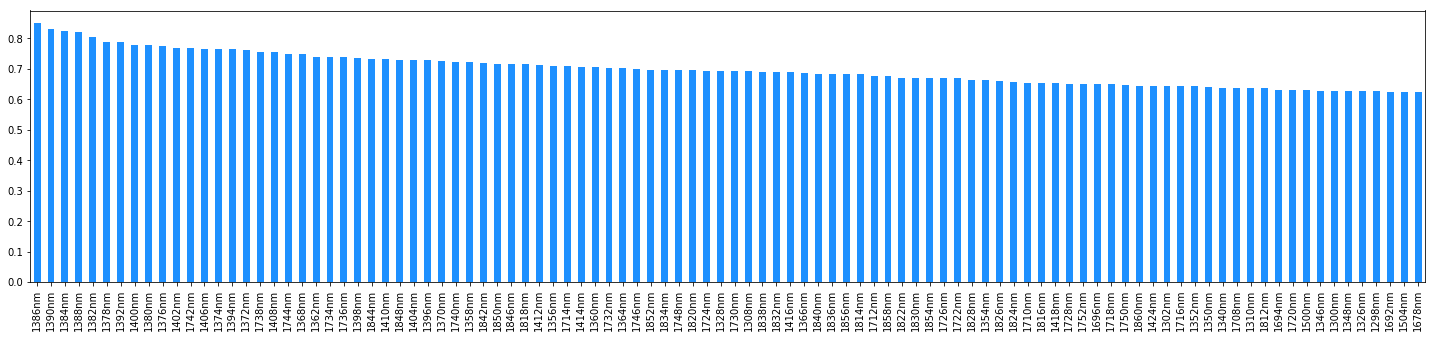

In [35]:
enzima = 'betaglicosidase'
print('\n Variáveis mais importantes para %s:'%enzima)
sel_mi_graph[enzima][:100].plot.bar(figsize=(25,5),color=cores[52:53])
print('--------------------------------------')

In [36]:
print('\n Variáveis MENOS importantes para %s:'%enzima)
temp=sel_mi_graph[enzima][sel_mi_graph[enzima]<.3]
#Lista das variáveis menos importantes
temp.sort_values()[:50].index


 Variáveis MENOS importantes para betaglicosidase:


Index(['1976nm', '1946nm', '1944nm', '1940nm', '1982nm', '1972nm', '1938nm',
       '1942nm', '1930nm', '1948nm', '1936nm', '1924nm', '1926nm', '1950nm',
       '1932nm', '2360nm', '1962nm', '1952nm', '1970nm', '1928nm', '1968nm',
       '1934nm', '2156nm', '1964nm', '1920nm', '1958nm', '1966nm', '2350nm',
       '2370nm', '2358nm', '1980nm', '1954nm', '2372nm', '1914nm', '1916nm',
       '1978nm', '1922nm', '1960nm', '2158nm', '2362nm', '2160nm', '2354nm',
       '2368nm', '1912nm', '1910nm', '1974nm', '1902nm', '1904nm', '1908nm',
       '1956nm'],
      dtype='object')


 Variáveis MENOS importantes para betaglicosidase:


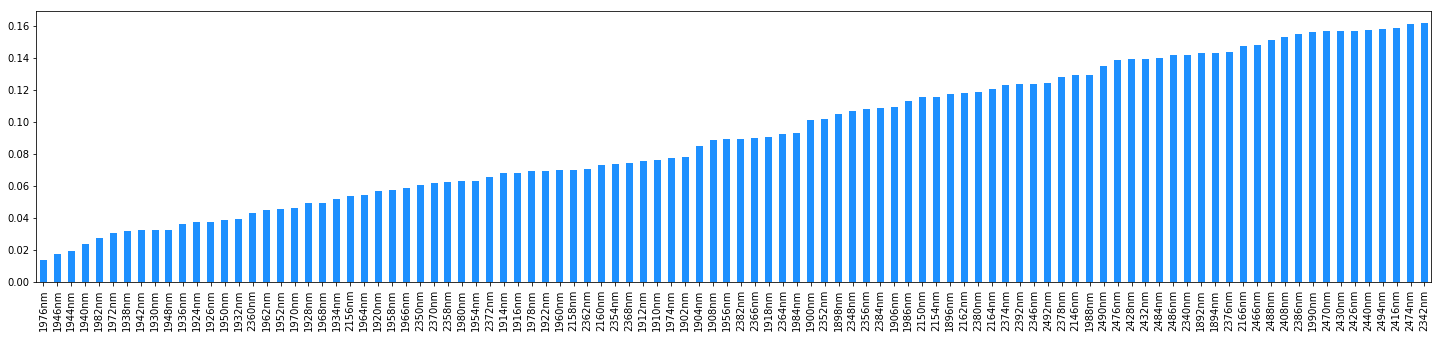

In [37]:
print('\n Variáveis MENOS importantes para %s:'%enzima)
temp=sel_mi_graph[enzima][sel_mi_graph[enzima]<.3]
#Lista das variáveis menos importantes
temp.sort_values()[:100].plot.bar(figsize=(25,5),color=cores[52:53])


 Variáveis mais importantes para cmcase:
--------------------------------------


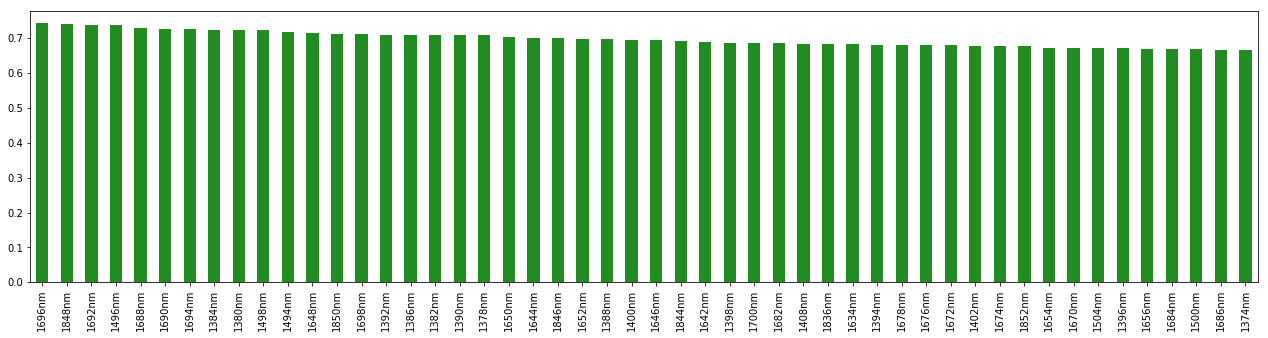

In [38]:
enzima = 'cmcase'
print('\n Variáveis mais importantes para %s:'%enzima)
sel_mi_graph[enzima][:50].plot.bar(figsize=(22,5),color=cores[55:56])
print('--------------------------------------')

In [39]:
print('\n Variáveis MENOS importantes para %s:'%enzima)
temp=sel_mi_graph[enzima][sel_mi_graph[enzima]<.3]
#Lista das variáveis menos importantes
temp.sort_values()[:50].index


 Variáveis MENOS importantes para cmcase:


Index(['1970nm', '1940nm', '1944nm', '1946nm', '1942nm', '1938nm', '1974nm',
       '1936nm', '1948nm', '1926nm', '1928nm', '1972nm', '1930nm', '2366nm',
       '1952nm', '1960nm', '1934nm', '1924nm', '1956nm', '1954nm', '2354nm',
       '1966nm', '1978nm', '1932nm', '1918nm', '2360nm', '1912nm', '1910nm',
       '1914nm', '2368nm', '1916nm', '2370nm', '1962nm', '1922nm', '2378nm',
       '1902nm', '1900nm', '1958nm', '1908nm', '2364nm', '1950nm', '1920nm',
       '1896nm', '2374nm', '2448nm', '1964nm', '1976nm', '1968nm', '2202nm',
       '1980nm'],
      dtype='object')


 Variáveis MENOS importantes para cmcase:


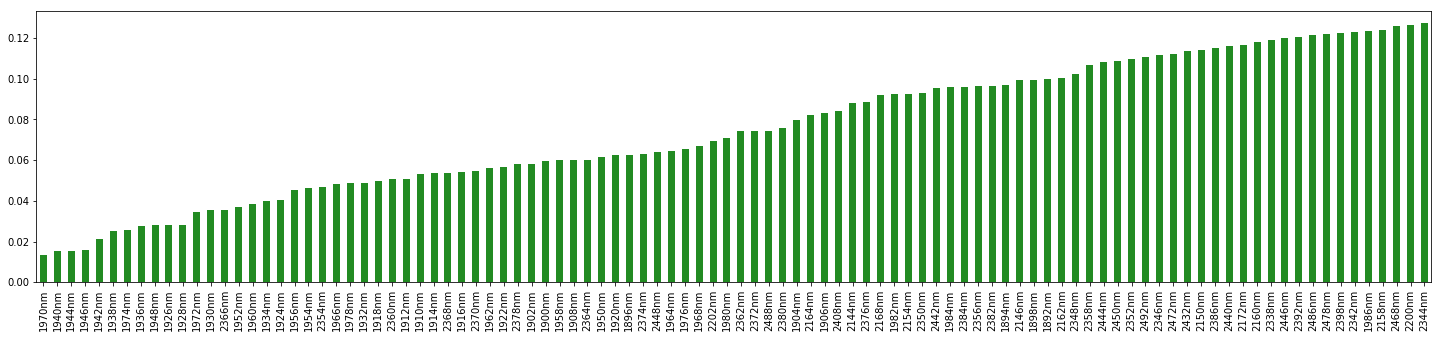

In [40]:
print('\n Variáveis MENOS importantes para %s:'%enzima)
temp=sel_mi_graph[enzima][sel_mi_graph[enzima]<.3]
#Lista das variáveis menos importantes
temp.sort_values()[:100].plot.bar(figsize=(25,5),color=cores[55:56])


 Variáveis mais importantes para fpase:
--------------------------------------


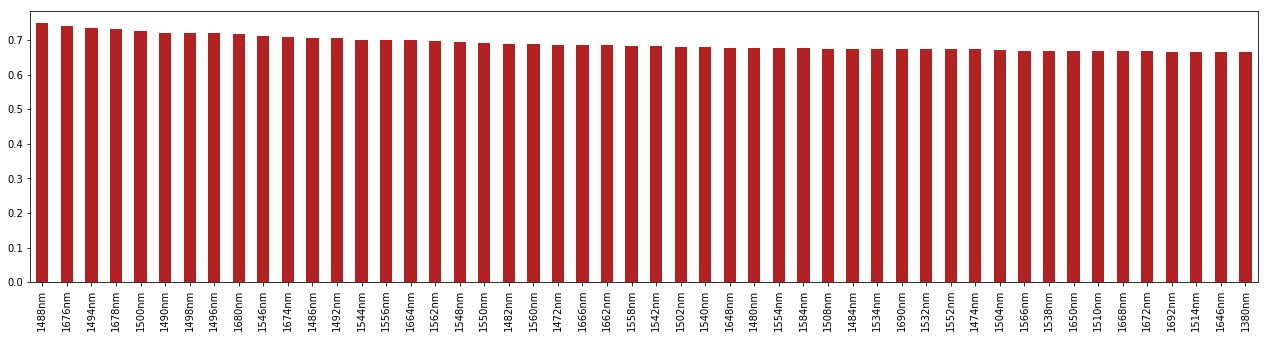

In [41]:
enzima = 'fpase'
print('\n Variáveis mais importantes para %s:'%enzima)
sel_mi_graph[enzima][:50].plot.bar(figsize=(22,5),color=cores[53:54])
print('--------------------------------------')

In [42]:
print('\n Variáveis MENOS importantes para %s:'%enzima)
temp=sel_mi_graph[enzima][sel_mi_graph[enzima]<.3]
#Lista das variáveis menos importantes
temp.sort_values()[:50].index


 Variáveis MENOS importantes para fpase:


Index(['1968nm', '1926nm', '1942nm', '2368nm', '1936nm', '1948nm', '1924nm',
       '1940nm', '1932nm', '1976nm', '2366nm', '1922nm', '1928nm', '1938nm',
       '1946nm', '2384nm', '1944nm', '1930nm', '2378nm', '1974nm', '1952nm',
       '2452nm', '1934nm', '1916nm', '1962nm', '2364nm', '2154nm', '1950nm',
       '1904nm', '1964nm', '1954nm', '1982nm', '1920nm', '1970nm', '2348nm',
       '2150nm', '2360nm', '2396nm', '2374nm', '1908nm', '1956nm', '1912nm',
       '1914nm', '1918nm', '1906nm', '2488nm', '1972nm', '1910nm', '2346nm',
       '1958nm'],
      dtype='object')


 Variáveis MENOS importantes para fpase:


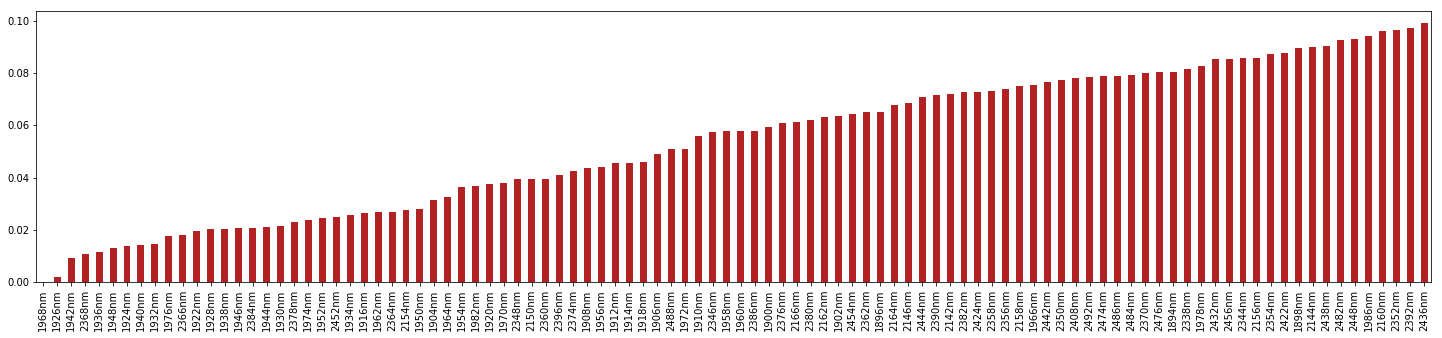

In [43]:
print('\n Variáveis MENOS importantes para %s:'%enzima)
temp=sel_mi_graph[enzima][sel_mi_graph[enzima]<.3]
#Lista das variáveis menos importantes
temp.sort_values()[:100].plot.bar(figsize=(25,5),color=cores[53:54])


 Variáveis mais importantes para xilanase:
--------------------------------------


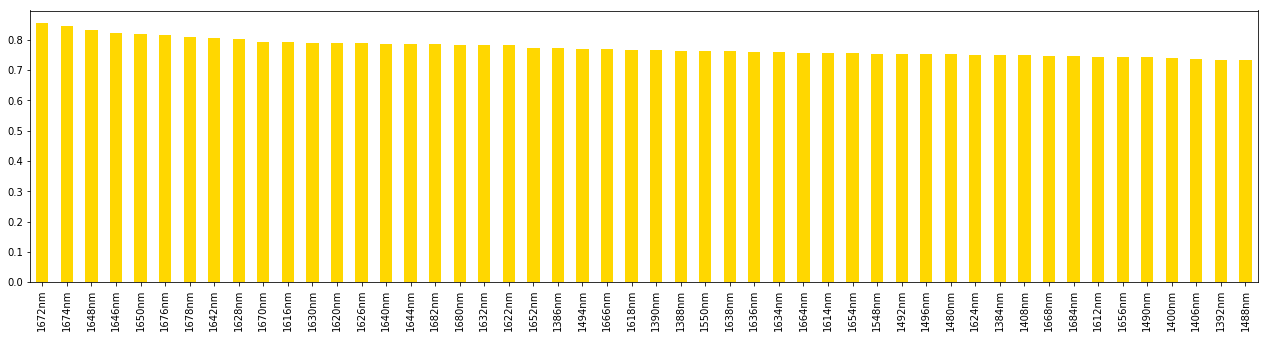

In [44]:
enzima = 'xilanase'
print('\n Variáveis mais importantes para %s:'%enzima)
sel_mi_graph[enzima][:50].plot.bar(figsize=(22,5),color=cores[59:60])
print('--------------------------------------')

In [45]:
print('\n Variáveis MENOS importantes para %s:'%enzima)
temp=sel_mi_graph[enzima][sel_mi_graph[enzima]<.3]
#Lista das variáveis menos importantes
temp.sort_values()[:50].index


 Variáveis MENOS importantes para xilanase:


Index(['1968nm', '1944nm', '1926nm', '1942nm', '1972nm', '1940nm', '1924nm',
       '1930nm', '1932nm', '1928nm', '1938nm', '1936nm', '1934nm', '1948nm',
       '1946nm', '1918nm', '2360nm', '1950nm', '1958nm', '1962nm', '2378nm',
       '1952nm', '1920nm', '1922nm', '1966nm', '1916nm', '1954nm', '1970nm',
       '2362nm', '1960nm', '1964nm', '2144nm', '2372nm', '1914nm', '2348nm',
       '1904nm', '1912nm', '1910nm', '1956nm', '1902nm', '2374nm', '2364nm',
       '1974nm', '2366nm', '2344nm', '1908nm', '1976nm', '2350nm', '2346nm',
       '2160nm'],
      dtype='object')


 Variáveis MENOS importantes para xilanase:


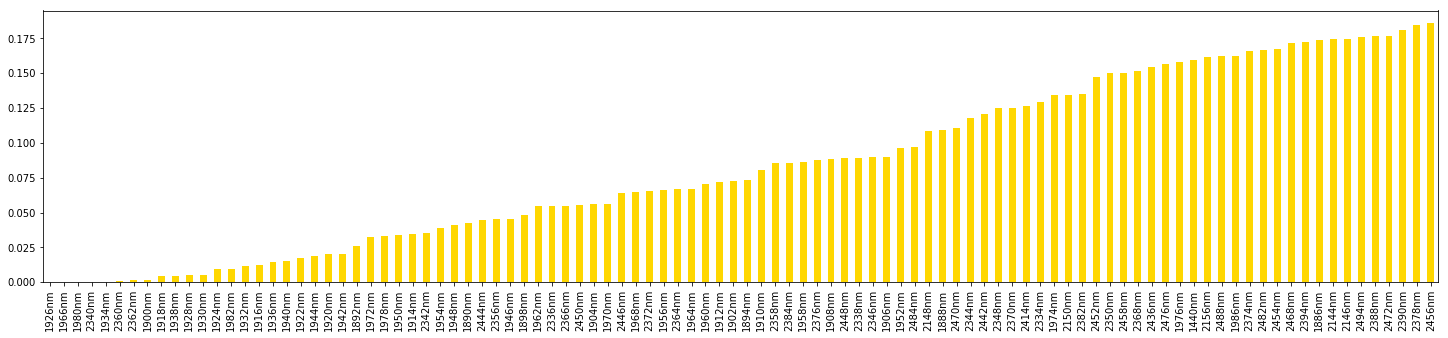

In [129]:
print('\n Variáveis MENOS importantes para %s:'%enzima)
temp=sel_mi_graph[enzima][sel_mi_graph[enzima]<.3]
#Lista das variáveis menos importantes
temp.sort_values()[:100].plot.bar(figsize=(25,5),color=cores[59:60])

In [46]:
#verificando o total de variáveis com correlação maior que 0.8 para cada atividade enzimática
corte = .65
var_ae=['betaglicosidase','cmcase','fpase','xilanase']
total={'betaglicosidase':0,'cmcase':0,'fpase':0,'xilanase':0}
for valor in var_ae:
    total[valor]=len(sel_mi_graph[valor][sel_mi_graph[valor]>corte])
print('Total de variáveis com correlação superior a ',corte,' para cada enzima\n')
for valor in var_ae:
    print(valor,':',total[valor])    

Total de variáveis com correlação superior a  0.65  para cada enzima

betaglicosidase : 77
cmcase : 80
fpase : 62
xilanase : 133


In [205]:
#verificando o total de variáveis que mais se correlacionam com  cada atividade enzimática
var_ae=['betaglicosidase','cmcase','fpase','xilanase']
  
for valor,i in zip(var_ae,[0,1,2,3]):
    total[valor]=len(sel_mi_graph[valor][sel_mi_graph[valor]>corr[i]])
print('Total de variáveis com correlação alta para cada enzima\n')
for valor in var_ae:
    print(valor,':',total[valor])     

NameError: name 'corr' is not defined

In [ ]:
'''
#Exibindo as variáveis mais significativas 
var_ae=['betaglicosidase','cmcase','fpase','xilanase']
corr = [1,0.7,1,0.85]
for valor,i in zip(var_ae,[0,1,2,3]):
    print('\nAtributos + significativos para:',valor)
    print(sel_mi_graph[valor][sel_mi_graph[valor]>corr[i]].index[:30])
'''

In [47]:
#Considerando o total de cada atividade, as variáveis mais significativas de cada atividade foram anexadas para depois remover as repetições
sel_ = {}
for valor in var_ae:
    sel_[valor] = list(sel_mi_graph[valor].index)
sel_2 = []
for valor in var_ae:
    sel_2 += sel_[valor][:total[valor]]
#elimina repetições:
sel_2 = list(set(sel_2))

print('Total de variáveis significativas sem repetição:',len(sel_2))

Total de variáveis significativas sem repetição: 185


In [262]:
#ordena as variáveis por nome
sel_2.sort()
print('Variáveis mais sigificativas:',sel_2)


Variáveis mais sigificativas: ['1308nm', '1350nm', '1352nm', '1354nm', '1356nm', '1358nm', '1360nm', '1362nm', '1364nm', '1366nm', '1368nm', '1370nm', '1372nm', '1374nm', '1376nm', '1378nm', '1380nm', '1382nm', '1384nm', '1386nm', '1388nm', '1390nm', '1392nm', '1394nm', '1396nm', '1398nm', '1400nm', '1402nm', '1404nm', '1406nm', '1408nm', '1410nm', '1412nm', '1414nm', '1416nm', '1418nm', '1420nm', '1422nm', '1424nm', '1476nm', '1478nm', '1480nm', '1482nm', '1484nm', '1486nm', '1488nm', '1490nm', '1492nm', '1494nm', '1496nm', '1498nm', '1500nm', '1502nm', '1504nm', '1506nm', '1508nm', '1510nm', '1512nm', '1514nm', '1546nm', '1548nm', '1550nm', '1552nm', '1556nm', '1558nm', '1560nm', '1562nm', '1568nm', '1570nm', '1572nm', '1576nm', '1578nm', '1580nm', '1582nm', '1590nm', '1592nm', '1606nm', '1608nm', '1610nm', '1612nm', '1614nm', '1616nm', '1618nm', '1620nm', '1622nm', '1624nm', '1626nm', '1628nm', '1630nm', '1632nm', '1634nm', '1636nm', '1638nm', '1640nm', '1642nm', '1644nm', '1646nm',

In [263]:
#renomear as absorbâncias
var_abs_txt = sel_2.copy()

# Outliers

* Após verificar as variáveis mais importantes, vamos utilizá-las para conferir possíveis outliers

In [1650]:
#2
#Ouliers: realizar teste com o arquivo D_outliers, nesse mesmo diretório

In [ ]:
#amostras outliers
Amostras que foram classificadas como outliers:
índice: 0 descrição: exp2_p0_t1 intervalo(minutos): 0
índice: 6 descrição: exp2_p1_t2_1 intervalo(minutos): 5
índice: 23 descrição: exp2_p2_t2_3 intervalo(minutos): 10
índice: 39 descrição: exp2_p3_t3_1 intervalo(minutos): 15
índice: 124 descrição: exp3_t1_p10_2 intervalo(minutos): 10
índice: 147 descrição: exp3_t2_p02_1 intervalo(minutos): 2
índice: 189 descrição: exp3_t3_p00_1 intervalo(minutos): 0
índice: 215 descrição: exp3_t3_p08_3 intervalo(minutos): 8
índice: 689 descrição: exp7_t4_p04_1 intervalo(minutos): 4
índice: 711 descrição: bio_p0_t1_2 intervalo(minutos): 0
índice: 714 descrição: bio_p0_t2_2 intervalo(minutos): 0
índice: 716 descrição: bio_p0_t3_1 intervalo(minutos): 0
índice: 718 descrição: bio_p0_t3_3 intervalo(minutos): 0
índice: 737 descrição: bio_p3_t1_1 intervalo(minutos): 72
índice: 739 descrição: bio_p3_t1_3 intervalo(minutos): 72
índice: 783 descrição: bio_p8_t1_2 intervalo(minutos): 192
índice: 884 descrição: ctec_exp6_p3_1 intervalo(minutos): 9
índice: 918 descrição: cellu_p022_marco_des_100 intervalo(minutos): 15

In [98]:
#Resetando o índice dos dados:
dados=dados.reset_index(drop=True)
dados.index

RangeIndex(start=0, stop=923, step=1)

In [43]:
dados_com_outliers = dados_back.copy()

In [44]:
dados = dados_com_outliers.copy()

In [1546]:
dados = dados[(dados['eenz'] == 'eeta')&(dados['experimento']=='biof')]

In [99]:
outliers = [0, 6, 23, 39, 124, 147, 189, 215, 689, 711, 714, 716, 718, 737, 739, 783, 884, 918]

#removendo as amostras consideradas outliers (testar os algoritmos sem remover outlier e após remover)
dados = dados.drop(outliers)

In [100]:
dados.shape

(905, 713)

# Definição das variáveis

**variáveis para os processamentos: (antes ou após remoção de outliers, com ou sem seleção de atributos:**

In [245]:
#@var_abs_txt
#@var_abs_int
# Opções de definição da variável das absorbâncias

In [48]:
#opção 1: Escolha de todos os valores de absorbância (sem nenhuma selação de atributos)
var_ae=['betaglicosidase','cmcase','fpase','xilanase']
#criando vetores com os nomes dos atributos

#criando um vetor com os nomes das absorbâncias para selação posterior
var_abs_int = np.arange(1100,2496,2)
var_abs_txt=[]
for valor in var_abs_int:
    var_abs_txt += [str(valor)+'nm']

In [185]:
#opção 2: Escolha de algumas absorbâncias e exclusão de outras - duas faixas excluídas (apenas observando os ruídos graficamente)
#variáveis após excluir algumas bandas do espectro
var_ae=['betaglicosidase','cmcase','fpase','xilanase']
#criando vetores com os nomes dos atributos

abs1 = np.arange(1100,1875,2)
abs2 = np.arange(1974,2351,2)
var_abs_int = np.concatenate((abs1,abs2),axis=0)
var_abs_txt=[]
for valor in var_abs_int:
    var_abs_txt += [str(valor)+'nm']


In [369]:
#opção 3: Exclusão da faixa final de ruido, a partir da abs 2350
#variáveis após excluir algumas bandas do espectro
var_ae=['betaglicosidase','cmcase','fpase','xilanase']
#criando vetores com os nomes dos atributos

var_abs_int = np.arange(1100,2351,2)
var_abs_txt=[]
for valor in var_abs_int:
    var_abs_txt += [str(valor)+'nm']

In [182]:
#opção 4: Definição das absorbâncias através da seleção de atributos feita previamente
var_abs_txt = sel_2.copy()
var_ae=['betaglicosidase','cmcase','fpase','xilanase']
var_abs_int=[]
for valor in var_abs_txt:
    var_abs_int += [int(valor[:4])]

NameError: name 'sel_2' is not defined

In [31]:
#Variável para trabalhar no pré-processamento dos espectros
preProc = {0:'Pré-proc: 0--> Sem pré-processamento', 
           1:'Pré-proc: 1--> Padronização', 
           2:'Pré-proc: 2--> Suavização(SavGol) - Par:3,1,1', 
           3:'Pré-proc: 3--> Suavização(SavGol) - Par:3,2,1',
           4:'Pré-proc: 4--> Suavização(SavGol) - Par:5,1,1',
           5:'Pré-proc: 5--> Suavização(SavGol) - Par:5,2,1',
           6:'Pré-proc: 6--> Suavização(SavGol) - Par:3,2,2',
           7:'Pré-proc: 7--> Suavização(SavGol) - Par:5,2,2',
           8:'Pré-proc: 8--> Suavização(SavGol) - Par:3,1,1 --> Padronização',
           9:'Pré-proc: 9--> Padronização --> Suavização(SavGol) - Par:3,1,1',
           10:'Pré-proc: 10--> MSC',
           11:'Pré-proc: 11--> SNV'}

## Definindo x e y

In [49]:
#@dfxy
#Definindo os dataFrame iniciais a partir da base de dados escolhida e pré-processada
df_x = dados.loc[:,var_abs_txt] #absorbâncias
df_y = dados.loc[:,var_ae]#AE

In [50]:
df_x.shape

(908, 698)

In [118]:
#se precisar eliminar colunas com dados nulos
#dadosb=dados.dropna(axis=1)


# Análise incial da base de dados e de seu conteúdo através de PCA

In [54]:
#@pca
#utilizar o PCA para reduzir as dimensões e poder analisar os dados
#Para utilizar o PCA é necessário realizar a normalização dos dados (tornar a variância unitária)
#pré-processamento
scaler = StandardScaler()
scaler.fit(df_x)
df_x_scaler = scaler.transform(df_x)
pca = PCA(n_components=7)
#treinar o pca com os dados padronizados
pca.fit(df_x_scaler)
#Após treinar o pca, agora posso transformar os dados
x_pca = pca.transform(df_x_scaler)
print('Dados originais:',df_x.shape,'Pós PCA:', x_pca.shape)

Dados originais: (908, 698) Pós PCA: (908, 7)


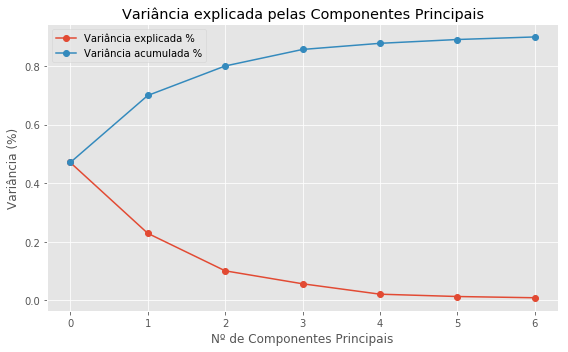

In [58]:
#Exibindo a variância explicada pelas componentes principais
variancia_explicada = pca.explained_variance_ratio_[:10]
# Explicação da variância pelas componentes principais
with plt.style.context(('ggplot')):
    fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
    fig.set_tight_layout(True)

    ax1.plot(variancia_explicada,'-o', label="Variância explicada %")
    ax1.plot(np.cumsum(variancia_explicada),'-o', label = 'Variância acumulada %')
    ax1.set_xlabel("Nº de Componentes Principais")
    ax1.set_ylabel("Variância (%)")

    ax1.set_title('Variância explicada pelas Componentes Principais')    
    plt.legend()
    plt.show()  

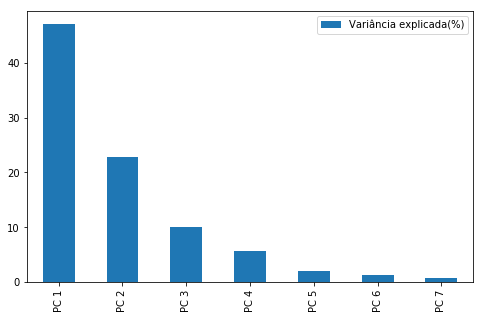

In [60]:
perc = pca.explained_variance_ratio_ * 100
perc = pd.DataFrame(perc, columns=['Variância explicada(%)'], index=['PC %s' % pc for pc in np.arange(len(perc)) + 1])
ax = perc.plot(kind='bar', figsize=(8,5))


    

In [61]:
texto = ''
perc['Variância acumulada(%)'] = np.cumsum(pca.explained_variance_ratio_[:7])
perc


Variância explicada(%)  Variância acumulada(%)
PC 1               47.087038                0.470870
PC 2               22.892725                0.699798
PC 3               10.079087                0.800588
PC 4                5.648380                0.857072
PC 5                2.095251                0.878025
PC 6                1.300650                0.891031
PC 7                0.876333                0.899795

In [37]:
loadings = pd.DataFrame(pca.components_.T)
loadings.index = ['A %s' % pc for pc in loadings.index + 1]
loadings.columns = ['PC %s' % pc for pc in loadings.columns + 1]
PCs = np.dot(loadings.values.T, df_x.T)
marker = dict(linestyle='none', marker='o', markersize=7, color='blue', alpha=0.5)


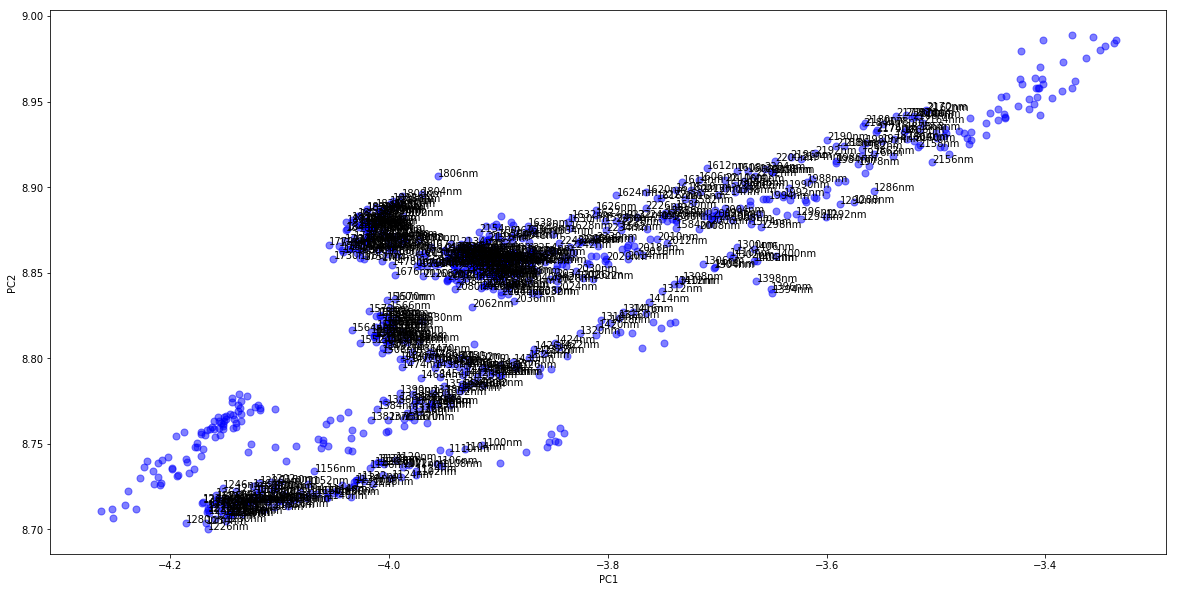

In [38]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(PCs[0], PCs[1], label="Scores", **marker)

ax.set_xlabel("PC1")

ax.set_ylabel("PC2")

text = [ax.text(x, y, t) for x, y, t in
        zip(PCs[0], PCs[1], df_x.columns)]

In [73]:
PCs.shape, df_x.shape, loadings.shape

((7, 81), (81, 261), (261, 7))

In [171]:
#dataframes separados por intervalo de tempo, temperatura, experimento e ae
#servirão para fazer análises gráficas com PCA
temp_yinter = dados.loc[:,'inter']
temp_ye = dados.loc[:,'eenz']
temp_yt = dados.loc[:,'temp']
temp_yex = dados.loc[:,'experimento']
temp_ybeta = dados.loc[:,'betaglicosidase']
temp_ycmc = dados.loc[:,'cmcase']
temp_yfpase = dados.loc[:,'fpase']
temp_yxil = dados.loc[:,'xilanase']

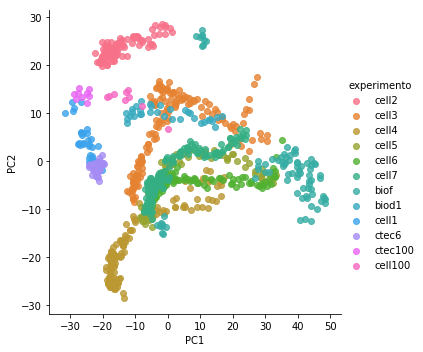

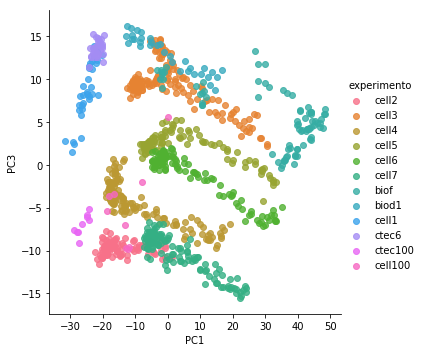

In [172]:
#configurando paleta de cores
palettes = ["deep", "muted", "pastel", "bright", "dark", "colorblind"]
#Desenhando o gráfico dos scores da PC1 com PC2 diferenciando por experimento
dados_plot = pd.DataFrame(zip(x_pca[:,0],x_pca[:,1],temp_yex), columns=["PC1", "PC2", "experimento"])
sns.lmplot("PC1", "PC2", dados_plot, hue="experimento", fit_reg=False)
plt.rcParams['figure.figsize']=(20,10)

dados_plot = pd.DataFrame(zip(x_pca[:,0],x_pca[:,2],temp_yex), columns=["PC1", "PC3", "experimento"])
sns.lmplot("PC1", "PC3", dados_plot, hue="experimento", fit_reg=False)
plt.rcParams['figure.figsize']=(20,10)

In [132]:
#Como selecionar amostras partindo dos gráficos gerados.
#assim dá pra separar as amostras em função da apresentação dada
#exemplo: biof = dados_plot[(dados_plot['PC2'] >-10) ]

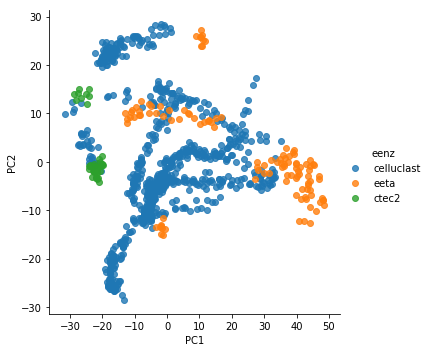

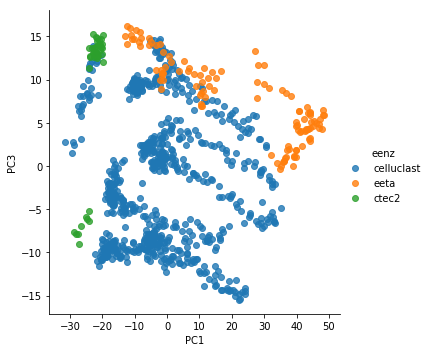

In [173]:
#Desenhando o gráfico dos scores da PC1 com PC2 diferenciando por tempo de fermentação ou desnaturação
dados_plot = pd.DataFrame(zip(x_pca[:,0],x_pca[:,1],temp_ye), columns=["PC1", "PC2", "eenz"])
sns.lmplot("PC1", "PC2", dados_plot, hue="eenz", fit_reg=False)
plt.rcParams['figure.figsize']=(15,10)

dados_plot = pd.DataFrame(zip(x_pca[:,0],x_pca[:,2],temp_ye), columns=["PC1", "PC3", "eenz"])
sns.lmplot("PC1", "PC3", dados_plot, hue="eenz", fit_reg=False)
plt.rcParams['figure.figsize']=(15,10)


In [ ]:
#Após separação de dados dará para selecionar algum conjunto de dados com características comuns

In [283]:
#verifica quais dados estão separados no biof
#biof = dados_plot[(dados_plot['PC2'] >-10) & (dados_plot['PC1']<0)  ]

In [284]:
#biof = dados.iloc[list(biof.index)]

In [1095]:
#Separa os dados do experimento da fermentação e da desnaturação

#biod = dados[ dados['experimento'] == 'biod1']
#biof = dados[ dados['experimento'] == 'biof']
#bioe = dados[ dados['experimento'] == 'bioE']

In [1097]:
#biod.shape, biof.shape, bioe.shape

((33, 713), (81, 713), (24, 713))

In [105]:
#Definindo os dataFrames iniciais a partir da base de dados escolhida e pré-processada
#df_x df_y
df_x = dados.loc[:,var_abs_txt] #absorbâncias
df_y = dados.loc[:,var_ae]#AE

# Função de pré-processamento

In [174]:
#@preproc
def executaPreproc(preproc, padroniza = False,IC=0):
    #separando o conjunto de dados em treino e teste
    x_treino, x_teste, y_treino, y_teste = train_test_split(df_x,df_y,test_size=0.25, random_state=IC)
    
    #parâmetros para savgol: janela,grau do polinômio,derivada
    par = [3,1,1]
    #sem pré-processamento preproc=0
    if preproc == 1:       #preproc=1: padronização (z=(xi-m)/s) SNV
        if padroniza: #padroniza y
            y_treino = StandardScaler().fit_transform(y_treino.values)#treino
            y_teste = StandardScaler().fit_transform(y_teste.values)#teste
            
        x_treino = StandardScaler().fit_transform(x_treino.values)#treino
        x_teste = StandardScaler().fit_transform(x_teste.values)#teste        
    elif preproc in range(2,8):
        if preproc == 2: #SG:3,1,1
            par=[3,1,1]
        elif preproc == 3:
            par=[3,2,1]
        elif preproc == 4:
            par=[5,1,1]
        elif preproc == 5:
            par=[5,2,1]
        elif preproc == 6:
            par=[3,2,2]
        elif preproc == 7:
            par=[5,2,2]
        x_treino = savgol_filter(x_treino, par[0], polyorder = par[1], deriv=par[2]) #treino
        x_teste = savgol_filter(x_teste, par[0], polyorder = par[1], deriv=par[2]) #teste        
    elif preproc == 8:
        x_treino = savgol_filter(x_treino, par[0], polyorder = par[1], deriv=par[2]) #treino
        x_teste = savgol_filter(x_teste, par[0], polyorder = par[1], deriv=par[2]) #teste
        x_treino = StandardScaler().fit_transform(x_treino[:,:])#treino
        x_teste = StandardScaler().fit_transform(x_teste[:,:])#teste
    elif preproc == 9:
        x_treino = StandardScaler().fit_transform(x_treino.values)#treino
        x_teste = StandardScaler().fit_transform(x_teste.values)#teste
        x_treino = savgol_filter(x_treino, par[0], polyorder = par[1], deriv=par[2]) #treino
        x_teste = savgol_filter(x_teste, par[0], polyorder = par[1], deriv=par[2]) #teste
    elif preproc == 10:
        x_treino = msc(x_treino.values)[0]
        x_teste = msc(x_teste.values)[0]
    elif preproc == 11:
        x_treino = snv(x_treino.values)
        x_teste = snv(x_teste.values)
    return (x_treino, x_teste, y_treino, y_teste)

In [47]:
def executaPreprocSimples(preproc,x):
    #parâmetros para savgol: janela,grau do polinômio,derivada
    par = [3,1,1]
    if preproc == 1:       
        x = StandardScaler().fit_transform(x.values)      
    elif preproc in range(2,8):
        if preproc == 2:
            par=[3,1,1]
        elif preproc == 3:
            par=[3,2,1]
        elif preproc == 4:
            par=[5,1,1]
        elif preproc == 5:
            par=[5,2,1]
        elif preproc == 6:
            par=[3,2,2]
        elif preproc == 7:
            par=[5,2,2]
        x= savgol_filter(x_treino, par[0], polyorder = par[1], deriv=par[2])          
    elif preproc == 8:
        x = savgol_filter(x, par[0], polyorder = par[1], deriv=par[2]) 
        x = StandardScaler().fit_transform(x[:,:])        
    elif preproc == 9:
        x = StandardScaler().fit_transform(x[:,:])
        x = savgol_filter(x, par[0], polyorder = par[1], deriv=par[2]) 
    elif preproc == 10:
        x_treino = msc(x_treino.values)[0]
        x_teste = msc(x_teste.values)[0]
    elif preproc == 11:
        x_treino = snv(x_treino.values)
        x_teste = snv(x_teste.values)
        
    return x

# Modelagem:

## Função geral de modelagem


In [48]:
#@modelagemCVP executa calibração, validação e predição
def executaCVP(treino_teste, reg):
    x_treino = treino_teste[0].copy()
    x_teste = treino_teste[1].copy()
    y_treino = treino_teste[2].copy()
    y_teste = treino_teste[3].copy()
    
    # Fit
    reg.fit(x_treino, y_treino) 

    # Calibração
    y_c = reg.predict(x_treino)

    # Cross-validation
    y_cv = cross_val_predict(reg, x_treino, y_treino, cv=10)

    # Predição nos dados de teste
    y_p = reg.predict(x_teste)

    y = y_treino.copy()
   
    return [reg, treino_teste,y_c,y_cv,y_p]


In [49]:
#@modelagemMetrics
#Retorna tabela de resultados:
def calMetrics(reais, preditos):
    result = {}
    result['BIAS'] = round(bias(reais, preditos),4)
    result['MSE'] = round(getmse(reais, preditos),4)
    result['R2'] = round(getr2(reais, preditos),4)
    result['RER'] = round(rer(reais, preditos),4)
    result['RMSE'] = round(getrmse(reais, preditos),4)
    #result['RMSE'] = rmse(reais, preditos)    
    result['RPD'] = round(rpd(reais, preditos),4)
    result['RPIQ'] = round(rpiq(reais, preditos),4)
    result['SEP'] = round(sep(reais, preditos),4)    
    return result

In [50]:
#@modelagemcalvalpred
#exibe resultados para calibração, vaidação cruzada e predição
def retornaCVP(y,yp):
    #yp contem os valores estimados da calibração, validação e teste
    var = ['cal','val', 'pred']
    var_ae=['betaglicosidase','cmcase','fpase','xilanase']
    res_cvp = {}
    for i in range(3):
        if i <2:
            j=0
        else:
            j=1
        for e,ie in zip(var_ae,[0,1,2,3]):
            reais = y[j].loc[:,e]
            pred = yp[i][:,ie]
            r = pd.Series(calMetrics(reais, pred))
            if ie == 0:
                res = pd.DataFrame(r, index=r.index, columns=[e])
            else:
                res[e] = r
        res_cvp[var[i]] = res
    return res_cvp

In [51]:
#@modelagemResultados
def exibeResultados(result):
    #recuperando resultados da modelagem
    reg, treino_teste,y_c,y_cv,y_p = result

    #x_treino, x_teste, y_treino, y_teste = treino_teste
    y_ = [treino_teste[2].reset_index(drop=True),treino_teste[3].reset_index(drop=True)]
    yp=[y_c,y_cv,y_p]
    resultados = retornaCVP(y_, yp)
    return resultados

## PCA->KNN

In [52]:
#pcaknn
#função completa para execução do PCA-->KNN:
#A variável preproc determinará o tipo de processamento que será executado (0,1,2,3,4)
def executaPCA_KNN(preproc, nPC,vizinhos, padroniza=False, ic=0):
    #separando o conjunto de dados em treino e teste
    
    #separando o conjunto de dados em treino e teste
    #x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,True)
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,padroniza,ic)

    
    # Roda o PCA e produz uma vaiável reduzida xRed e seleciona as primeiras componentes definidas pela variável nPc
    pca = PCA(n_components=nPC)
    x_treino = pca.fit_transform(x_treino)[:,:nPC]
    x_teste = pca.fit_transform(x_teste)[:,:nPC]    
    
    #Passo 2: Aplicar o KNN sobre as componentes selecionadas
    reg = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=vizinhos))
    result = executaCVP([x_treino, x_teste, y_treino, y_teste], reg)
    
    return result

### PCA->KNN: testes

In [180]:
#pcaknn teste simples
#teste simples:
modelo = 'PCA-KNN:'
preproc=1
nPC=2
k=3
result = executaPCA_KNN(preproc,nPC,k)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)
'''
for k,v in zip(resultados.keys(),resultados.values()):
    print(k)
    print(v,'\n-----------------------------------------------------')'''

Parâmetros do modelo: PCA-KNN: 
 MultiOutputRegressor(estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=3, p=2,
          weights='uniform'),
           n_jobs=None)


"\nfor k,v in zip(resultados.keys(),resultados.values()):\n    print(k)\n    print(v,'\n-----------------------------------------------------')"

In [181]:
resultados['cal']

betaglicosidase    cmcase     fpase    xilanase
BIAS          -2.6442   -0.0340    0.0427     -0.9653
MSE        19578.0309  308.6015  118.9474  46517.7316
R2             0.8640    0.8455    0.7283      0.7025
RER           20.8468   16.3794   14.9642     13.7191
RMSE         139.9215   17.5671   10.9063    215.6797
RPD            2.7120    2.5443    1.9184      1.8335
RPIQ           1.1023    1.6749    1.9527      1.9150
SEP          139.9994   17.5799   10.9142    215.8361

In [182]:
resultados['val']

betaglicosidase    cmcase     fpase    xilanase
BIAS          -0.1625    0.0344   -0.0286      3.6709
MSE        37462.9822  647.9087  216.6589  89029.7649
R2             0.7398    0.6757    0.5051      0.4307
RER           15.0676   11.3042   11.0877      9.9173
RMSE         193.5536   25.4541   14.7193    298.3786
RPD            1.9605    1.7559    1.4215      1.3253
RPIQ           0.7968    1.1559    1.4469      1.3842
SEP          193.6958   25.4727   14.7301    298.5753

In [56]:
resultados['pred']

betaglicosidase     cmcase     fpase     xilanase
BIAS         -72.3020     3.7543    0.9767      21.1807
MSE       182234.1813  2156.7165  526.6006  213193.0035
R2            -1.5385    -0.4371   -0.6831      -0.6473
RER            4.4015     4.3343    3.9310       4.1477
RMSE         426.8890    46.4405   22.9478     461.7283
RPD            0.6276     0.8342    0.7708       0.7791
RPIQ           0.3155     0.5027    0.9847       0.9958
SEP          421.6351    46.3890   22.9768     462.2438

In [57]:
#pcaknn teste completo
#pre = preprocessamento, k=número de vizinhos
modelo = 'PCA-KNN:'
print(modelo,':\n')
for nPC in range(2,5):
    print('PC:',nPC)
    for pre in range(12):
        print('Pré-processamento:\n',pre)
        for k in range(1,4):           
            result = executaPCA_KNN(pre,nPC,k)
            print('Vizinhos:', k,'\n')
            print('Parâmetros do modelo:',modelo,'\n',result[0])
            resultados=exibeResultados(result)
            for k,v in zip(resultados.keys(),resultados.values()):
                print(k)
                print(v,'\n-----------------------------------------------------')

PCA-KNN: :

PC: 2
Pré-processamento:
 0
Vizinhos: 1 

Parâmetros do modelo: PCA-KNN: 
 MultiOutputRegressor(estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=1, p=2,
          weights='uniform'),
           n_jobs=None)
cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS         -11.2055    -0.3877    0.0291       0.9157
MSE       144029.1795  1591.1798  568.9914  251099.2382
R2             0.2258     0.2727   -0.1

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           2.0671    0.0620    0.1144      2.0428
MSE        21632.2538  274.2675  120.6531  49038.1106
R2             0.8837    0.8746    0.7611      0.7539
RER           19.8309   17.3747   14.8589     14.1849
RMSE         147.0791   16.5610   10.9842    221.4455
RPD            2.9326    2.8244    2.0461      2.0157
RPIQ           1.0055    1.7844    1.9277      2.1296
SEP          147.1709   16.5729   10.9916    221.5963 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase    xilanase
BIAS           1.4303   -0.1464   -0.1539     -1.6038
MSE        41526.0056  549.6915  218.0913  92073.7890
R2             0.7768    0.7488    0.5682      0.5379
RER           14.3120   12.2730   11.0519     10.3517
RMSE         203.7793   23.4455   14.7679    303.4366
RPD            2.1166    1.9950    1.5219      1.4710
RPIQ           0.7257    1.2604    1.4338      1.5542
SEP          203.92

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          -0.0144   -0.3991   -0.1890     -5.6591
MSE        70331.2665  817.0581  235.3772  95617.9404
R2             0.6220    0.6266    0.5340      0.5201
RER           10.9971   10.0674   10.6386     10.1596
RMSE         265.2004   28.5842   15.3420    309.2215
RPD            1.6264    1.6364    1.4649      1.4435
RPIQ           0.5577    1.0338    1.3802      1.5251
SEP          265.3923   28.6021   15.3519    309.3934 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS           3.7109    -0.5032   -0.6768     -14.7714
MSE       201512.7807  2604.8035  706.8622  289026.0378
R2            -0.0832    -0.1906   -0.3994      -0.4506
RER            6.4970     5.6381    6.1405       5.8448
RMSE         448.9017    51.0373   26.5869     537.6114
RPD            0.9608     0.9165    0.8453       0.8303
RPIQ           0.3294     0.5790    0.7964       0.8772
SEP

cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS          -3.0126    -0.5529    0.0922      -8.4656
MSE       260721.6155  3253.0402  872.9321  363729.5426
R2            -0.4014    -0.4868   -0.7282      -0.8256
RER            5.7118     5.0452    5.5239       5.2087
RMSE         510.6091    57.0354   29.5454     603.0999
RPD            0.8447     0.8201    0.7607       0.7401
RPIQ           0.2896     0.5181    0.7167       0.7819
SEP          510.9695    57.0740   29.5667     603.4767 
---------

cal
      betaglicosidase     cmcase     fpase     xilanase
BIAS          -3.2902    -0.2578   -0.0342       1.9321
MSE        89372.7241  1192.3004  290.3618  114067.5666
R2             0.5196     0.4550    0.4252       0.4275
RER            9.7561     8.3334    9.5778       9.3004
RMSE         298.9527    34.5297   17.0400     337.7389
RPD            1.4428     1.3546    1.3189       1.3216
RPIQ           0.4947     0.8558    1.2426       1.3963
SEP          299.1508    34.5537   17.0523     337.9777 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS          -8.7509    -1.6346   -0.7414     -13.9022
MSE       201628.6608  2555.3208  637.9822  259780.9261
R2            -0.0838    -0.1679   -0.2630      -0.3038
RER            6.4962     5.6951    6.4642       6.1650
RMSE         449.0308    50.5502   25.2583     509.6871
RPD            0.9606     0.9253    0.8898       0.8758
RPIQ           0.3294     0.5846    0.838

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          -1.4731    0.3975    0.1077     -0.4274
MSE        29241.2982  248.5622  109.7479  48417.6517
R2             0.8428    0.8864    0.7827      0.7570
RER           17.0557   18.2566   15.5797     14.2749
RMSE         171.0009   15.7659   10.4761    220.0401
RPD            2.5223    2.9668    2.1453      2.0286
RPIQ           0.8648    1.8744    2.0212      2.1432
SEP          171.1182   15.7722   10.4831    220.1989 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS          -3.4159    0.1952    0.0543      -1.6008
MSE        81285.1833  745.0709  304.9458  136308.7771
R2             0.5631    0.6595    0.3963       0.3159
RER           10.2300   10.5418    9.3460       8.5078
RMSE         285.1056   27.2960   17.4627     369.2002
RPD            1.5128    1.7136    1.2870       1.2090
RPIQ           0.5187    1.0826    1.2126       1.2773
SEP        

Vizinhos: 1 

Parâmetros do modelo: PCA-KNN: 
 MultiOutputRegressor(estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=1, p=2,
          weights='uniform'),
           n_jobs=None)
cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS         -22.1581    -0.9230   -0.9546     -18.1410
MSE       175193.7180  1861.4823  691.4322  295738.9474
R2             0.0583     0.1492   -0.3689      -0.4843
RER            6.9775  

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          -5.1750   -0.4019   -0.2730     -3.6877
MSE        58639.5880  618.6790  222.5001  99127.2863
R2             0.6848    0.7172    0.5595      0.5025
RER           12.0463   11.5698   10.9431      9.9772
RMSE         242.1561   24.8733   14.9164    314.8449
RPD            1.7812    1.8805    1.5067      1.4177
RPIQ           0.6107    1.1881    1.4195      1.4978
SEP          242.2759   24.8880   14.9247    315.0510 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS          -2.1991    -0.2981   -0.1013       0.8250
MSE       114830.2029  1174.6062  440.4787  192489.1546
R2             0.3828     0.4631    0.1280       0.0339
RER            8.6066     8.3960    7.7764       7.1593
RMSE         338.8661    34.2725   20.9876     438.7359
RPD            1.2728     1.3648    1.0709       1.0174
RPIQ           0.4364     0.8622    1.0089       1.0749
SEP

cal
      betaglicosidase    cmcase    fpase    xilanase
BIAS          -0.0158   -0.4669  -0.0654     -1.1468
MSE        12205.9893  109.4403  70.3750  25054.1994
R2             0.9344    0.9500   0.8607      0.8743
RER           26.3976   27.5324  19.4553     19.8447
RMSE         110.4807   10.4614   8.3890    158.2852
RPD            3.9040    4.4712   2.6791      2.8200
RPIQ           1.3386    2.8248   2.5241      2.9794
SEP          110.5606   10.4585   8.3948    158.3955 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.0602   -0.2994   -0.1005      0.2971
MSE        48078.9270  371.0311  231.2178  82634.3610
R2             0.7416    0.8304    0.5422      0.5853
RER           13.3007   14.9399   10.7333     10.9268
RMSE         219.2691   19.2622   15.2058    287.4619
RPD            1.9671    2.4283    1.4780      1.5528
RPIQ           0.6745    1.5342    1.3925      1.6405
SEP          219.4277   19.2

cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS          12.9646     0.3259   -0.0415     -10.3694
MSE       251615.7868  3231.6256  896.2254  387027.7289
R2            -0.3525    -0.4771   -0.7743      -0.9425
RER            5.8160     5.0617    5.4516       5.0497
RMSE         501.6132    56.8474   29.9370     622.1155
RPD            0.8599     0.8228    0.7507       0.7175
RPIQ           0.2948     0.5198    0.7073       0.7580
SEP          501.8083    56.8876   29.9586     622.4790 
---------

cal
      betaglicosidase     cmcase     fpase     xilanase
BIAS          -1.3451     0.3288    0.1115       0.9293
MSE        90659.9549  1109.9378  307.5459  130186.9957
R2             0.5127     0.4927    0.3911       0.3466
RER            9.6861     8.6372    9.3065       8.7055
RMSE         301.0979    33.3157   17.5370     360.8144
RPD            1.4325     1.4040    1.2816       1.2371
RPIQ           0.4912     0.8870    1.2074       1.3070
SEP          301.3127    33.3382   17.5493     361.0741 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS          -3.0113     0.2847    0.0275      -0.3179
MSE       165198.5509  2112.4225  585.4875  242210.7902
R2             0.1120     0.0345   -0.1591      -0.2157
RER            7.1756     6.2606    6.7449       6.3823
RMSE         406.4462    45.9611   24.1968     492.1492
RPD            1.0612     1.0177    0.9288       0.9070
RPIQ           0.3639     0.6430    0.875

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           5.6783    0.8499    0.2723      4.0288
MSE        62010.5744  844.7744  202.2333  83599.8553
R2             0.6667    0.6139    0.5996      0.5804
RER           11.7147    9.9041   11.4785     10.8646
RMSE         249.0192   29.0650   14.2209    289.1364
RPD            1.7321    1.6093    1.5804      1.5438
RPIQ           0.5939    1.0167    1.4890      1.6310
SEP          249.1346   29.0736   14.2286    289.3174 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS          -0.3823    -0.5956   -0.2660      -8.6784
MSE       225456.1219  3024.3981  739.3474  301031.6318
R2            -0.2119    -0.3823   -0.4637      -0.5109
RER            6.1421     5.2325    6.0025       5.7256
RMSE         474.8222    54.9945   27.1909     548.6635
RPD            0.9084     0.8505    0.8266       0.8136
RPIQ           0.3115     0.5373    0.7787       0.8595
SEP

cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           0.4175    0.1655    0.0262      -1.9968
MSE        62810.8560  588.9514  331.7990  118323.3713
R2             0.6624    0.7308    0.3431       0.4061
RER           11.6368   11.8569    8.9598       9.1316
RMSE         250.6209   24.2683   18.2153     343.9816
RPD            1.7210    1.9274    1.2338       1.2976
RPIQ           0.5901    1.2177    1.1624       1.3710
SEP          250.8019   24.2853   18.2285     344.2247 
------------------

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          16.7677    0.8022    0.6859     13.8677
MSE        67558.7329  625.6696  211.9289  92294.7403
R2             0.6369    0.7140    0.5804      0.5368
RER           11.2439   11.5094   11.2233     10.3500
RMSE         259.9206   25.0134   14.5578    303.8005
RPD            1.6594    1.8700    1.5438      1.4693
RPIQ           0.5690    1.1814    1.4545      1.5523
SEP          259.5668   25.0186   14.5521    303.7033 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS          23.7121     1.2162    0.8010      17.2455
MSE       146931.7075  1346.7171  446.1859  190933.9485
R2             0.2102     0.3845    0.1167       0.0417
RER            7.6230     7.8451    7.7319       7.1940
RMSE         383.3167    36.6976   21.1231     436.9599
RPD            1.1252     1.2746    1.0640       1.0215
RPIQ           0.3858     0.8053    1.0024       1.0792
SEP

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           5.5060    0.6749    0.3708      5.4947
MSE        26832.2532  342.7694  119.3780  52313.7682
R2             0.8558    0.8433    0.7637      0.7374
RER           17.8143   15.5521   14.9459     13.7370
RMSE         163.8055   18.5140   10.9260    228.7220
RPD            2.6331    2.5265    2.0570      1.9516
RPIQ           0.9028    1.5961    1.9380      2.0618
SEP          163.8314   18.5151   10.9276    228.8214 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS           4.8569     0.8651    0.3505       5.7920
MSE        96806.8341  1139.1956  421.0457  179038.0402
R2             0.4796     0.4793    0.1664       0.1014
RER            9.3746     8.5279    7.9549       7.4241
RMSE         311.1380    33.7520   20.5194     423.1289
RPD            1.3863     1.3858    1.0953       1.0549
RPIQ           0.4753     0.8755    1.0319       1.1145
SEP

cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.7758   -0.2399   -0.2482     -2.6296
MSE        26948.4107  279.3224  201.5069  67980.0031
R2             0.8551    0.8723    0.6011      0.6588
RER           17.7660   17.2184   11.4989     12.0477
RMSE         164.1597   16.7129   14.1953    260.7298
RPD            2.6275    2.7987    1.5833      1.7120
RPIQ           0.9009    1.7682    1.4916      1.8087
SEP          164.2766   16.7233   14.2034    260.9051 
---------------------------

cal
      betaglicosidase     cmcase     fpase     xilanase
BIAS          -4.9963     0.0392   -0.2611      -6.1948
MSE        88091.1762  1058.3188  290.0874  127778.1987
R2             0.5265     0.5163    0.4257       0.3587
RER            9.8276     8.8449    9.5834       8.7884
RMSE         296.8016    32.5318   17.0320     357.4608
RPD            1.4532     1.4378    1.3196       1.2487
RPIQ           0.4983     0.9084    1.2432       1.3193
SEP          296.9742    32.5553   17.0423     357.6656 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS           0.6534     0.3855   -0.3774     -11.5240
MSE       169298.4760  2052.0613  567.5558  246928.0239
R2             0.0900     0.0621   -0.1236      -0.2393
RER            7.0880     6.3522    6.8515       6.3227
RMSE         411.4590    45.2997   23.8234     496.9185
RPD            1.0483     1.0326    0.9434       0.8983
RPIQ           0.3594     0.6523    0.888

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          -1.7818   -0.2016   -0.0176      0.1040
MSE        72653.1833  786.7518  210.0698  94582.8799
R2             0.6095    0.6404    0.5841      0.5253
RER           10.8202   10.2587   11.2603     10.2133
RMSE         269.5425   28.0491   14.4938    307.5433
RPD            1.6002    1.6676    1.5506      1.4514
RPIQ           0.5487    1.0535    1.4609      1.5334
SEP          269.7316   28.0687   14.5043    307.7657 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS          -6.4826    -0.6575   -0.1774      -8.3595
MSE       196560.0207  2255.3183  605.6197  271118.8846
R2            -0.0566    -0.0308   -0.1990      -0.3607
RER            6.5789     6.0595    6.6320       6.0332
RMSE         443.3509    47.4902   24.6093     520.6908
RPD            0.9729     0.9849    0.9133       0.8573
RPIQ           0.3336     0.6223    0.8604       0.9057
SEP

cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase     cmcase      fpase     xilanase
BIAS         -18.8370    -1.7887    -1.5126     -30.4536
MSE       302486.1862  4057.7637  1034.8916  404371.0170
R2            -0.6259    -0.8546    -1.0488      -1.0295
RER            5.3058     4.5189     5.0789       4.9452
RMSE         549.9874    63.7006    32.1697     635.9017
RPD            0.7842     0.7343     0.6986       0.7019
RPIQ           0.2689     0.4639     0.6582       0.7416
SEP          550.0624    63.7215    32.1574     635.6315 


cal
      betaglicosidase     cmcase     fpase     xilanase
BIAS           4.5957     0.8312    0.1010      -0.5089
MSE        95293.3868  1258.4980  315.1092  126470.6201
R2             0.4878     0.4248    0.3762       0.3652
RER            9.4486     8.1132    9.1941       8.8324
RMSE         308.6963    35.4753   17.7513     355.6271
RPD            1.3972     1.3185    1.2661       1.2552
RPIQ           0.4791     0.8330    1.1928       1.3261
SEP          308.8853    35.4912   17.7639     355.8840 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS          10.1071     1.2024    0.0058      -3.7401
MSE       167995.9821  2358.9155  582.2179  237457.3647
R2             0.0970    -0.0782   -0.1526      -0.1918
RER            7.1176     5.9262    6.7638       6.4461
RMSE         409.8731    48.5687   24.1292     487.2960
RPD            1.0523     0.9631    0.9314       0.9160
RPIQ           0.3608     0.6084    0.877

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           9.8197    0.5749    0.5407      7.4768
MSE        43132.0330  346.3753  136.1728  61326.5215
R2             0.7682    0.8417    0.7304      0.6922
RER           14.0584   15.4680   14.0009     12.6896
RMSE         207.6825   18.6112   11.6693    247.6419
RPD            2.0768    2.5133    1.9260      1.8025
RPIQ           0.7121    1.5878    1.8145      1.9043
SEP          207.6003   18.6157   11.6652    247.7081 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS          15.4701     0.6146    0.6956       9.1325
MSE       128770.2669  1117.3688  436.4229  195930.4226
R2             0.3078     0.4893    0.1360       0.0166
RER            8.1348     8.6095    7.8166       7.0977
RMSE         358.8457    33.4271   20.8907     442.6403
RPD            1.2020     1.3993    1.0758       1.0084
RPIQ           0.4121     0.8840    1.0136       1.0654
SEP

cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS           6.6901    -0.5921    0.0398      -5.0921
MSE       121198.4574  1287.6422  474.8304  212824.7596
R2             0.3485     0.4115    0.0600      -0.0682
RER            8.3788     8.0198    7.4897       6.8091
RMSE         348.1357    35.8837   21.7906     461.3293
RPD            1.2389     1.3035    1.0314       0.9676
RPIQ           0.4248     0.8235    0.9717       1.0222
SEP          348.3232    35.9048   21.8063     461.6349 
---------

In [58]:
#pcaknn teste completo
#pre = preprocessamento, k=número de vizinhos
modelo = 'PCA-KNN:'
print(modelo,':\n')
for nPC in range(3,4):
    print('PC:',nPC)
    for pre in [0,1,8]:
        print('Pré-processamento:\n',pre)
        for k in range(2,4):           
            result = executaPCA_KNN(pre,nPC,k)
            print('Vizinhos:', k,'\n')
            print('Parâmetros do modelo:',modelo,'\n',result[0])
            resultados=exibeResultados(result)
            for k,v in zip(resultados.keys(),resultados.values()):
                print(k)
                print(v,'\n-----------------------------------------------------')

PCA-KNN: :

PC: 3
Pré-processamento:
 0
Vizinhos: 2 

Parâmetros do modelo: PCA-KNN: 
 MultiOutputRegressor(estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=2, p=2,
          weights='uniform'),
           n_jobs=None)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.3147    0.0623    0.2055      4.4756
MSE        27345.6077  310.9082  123.6317  48570.9948
R2             0.8530    0.8579    0.7552      0.7562
RER           17.6363   16.3188   14.6806     14.2553
RMSE         165.3651   17.6326   11.1190    220.3883
RPD            2.6083    2.6528    2.0213      2.0254
RPIQ           0.8943    1.6759    1.9043      2.1398
SEP          165.4844   17.6452   11.1251    220.5022 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS          -2.3859    -1.4842   -0.5148      -6.3991
MSE       100259.3024  1014.2128

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           5.3766    0.3042    0.1040      3.4955
MSE        24107.4085  218.0318  109.7498  41968.6529
R2             0.8704    0.9003    0.7827      0.7894
RER           18.7947   19.4909   15.5795     15.3347
RMSE         155.2656   14.7659   10.4762    204.8625
RPD            2.7780    3.1678    2.1453      2.1789
RPIQ           0.9525    2.0013    2.0212      2.3020
SEP          155.2847   14.7734   10.4832    204.9809 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase    xilanase
BIAS          -1.0111   -0.1803   -0.1427     -3.0243
MSE        49336.2246  453.1151  237.2034  93008.8787
R2             0.7348    0.7929    0.5304      0.5332
RER           13.1302   13.5180   10.5972     10.2999
RMSE         222.1176   21.2865   15.4014    304.9736
RPD            1.9419    2.1974    1.4593      1.4636
RPIQ           0.6658    1.3883    1.3748      1.5463
SEP          222.27

In [189]:
#teste 2 escolhendo o modelo mais otimizado
modelo = 'PCA-KNN:'
maior=[-1,-1,-1,-1]
maiorGerado=[0,0,0,0]
for i in range(100):
    result = executaPCA_KNN(1,3,3,False,i)
    resultados=exibeResultados(result)
    r2 = resultados['pred'].loc[resultados['pred'].index=='R2']
    r = []
    for j in range(4):
        r.append(r2.iloc[:,j][0])
        if r[j]>maior[j]:
            maior[j] = r[j]
            maiorGerado[j]=i
    print('\r%d%% completos'%(i+1), end='')
print('\n','r2:',maior,'\nsemente: b c f x',maiorGerado)

100% completos
 r2: [0.8895, 0.8893, 0.7634, 0.751] 
semente: b c f x [45, 33, 25, 33]


In [188]:
#teste 2 escolhendo o modelo mais otimizado
modelo = 'PCA-KNN:'
maior=[-1,-1,-1,-1]
maiorGerado=[0,0,0,0]
for i in range(100):
    result = executaPCA_KNN(1,3,3,False,i)
    resultados=exibeResultados(result)
    r2 = resultados['val'].loc[resultados['val'].index=='R2']
    r = []
    for j in range(4):
        r.append(r2.iloc[:,j][0])
        if r[j]>maior[j]:
            maior[j] = r[j]
            maiorGerado[j]=i
    print('\r%d%% completos'%(i+1), end='')
print('\n','r2:',maior,'\nsemente: b c f x',maiorGerado)

100% completos
 r2: [0.8311, 0.8641, 0.6506, 0.7286] 
semente: b c f x [72, 27, 72, 72]


In [190]:
#pcaknn teste otimizado
modelo = 'PCA-KNN:'
preproc=1
nPC=3
k=3
gera=33
result = executaPCA_KNN(preproc,nPC,k, False, gera)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)

Parâmetros do modelo: PCA-KNN: 
 MultiOutputRegressor(estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=3, p=2,
          weights='uniform'),
           n_jobs=None)


In [176]:
len(var_abs_txt)

577

In [191]:
resultados['cal']

betaglicosidase    cmcase    fpase    xilanase
BIAS          -4.9466   -0.5077  -0.3513     -6.3236
MSE        23592.8113  204.8797  98.1755  34256.2035
R2             0.8334    0.8959   0.7663      0.7770
RER           18.9969   20.1150  16.4816     15.9961
RMSE         153.5995   14.3136   9.9084    185.0843
RPD            2.4499    3.0997   2.0685      2.1175
RPIQ           1.0415    1.9371   2.2038      2.4497
SEP          153.6327   14.3151   9.9094    185.1122

In [192]:
resultados['val']

betaglicosidase    cmcase     fpase    xilanase
BIAS          -9.6263   -1.0409   -0.6865    -12.0143
MSE        50164.4334  443.4844  204.8742  73733.1304
R2             0.6457    0.7747    0.5123      0.5200
RER           13.0332   13.6801   11.4152     10.9075
RMSE         223.9742   21.0591   14.3134    271.5385
RPD            1.6801    2.1068    1.4319      1.4433
RPIQ           0.7143    1.3166    1.5256      1.6697
SEP          223.9317   21.0488   14.3075    271.4719

In [194]:
resultados['pred']

betaglicosidase    cmcase     fpase    xilanase
BIAS          13.2627    0.9436    0.6729     13.0100
MSE        18886.2307  227.0574  123.2657  41690.1802
R2             0.8731    0.8893    0.7372      0.7510
RER           17.7373   18.9292   14.7051     14.4995
RMSE         137.4272   15.0684   11.1025    204.1817
RPD            2.8067    3.0051    1.9507      2.0042
RPIQ           0.9172    1.8308    1.9052      2.3002
SEP          137.0880   15.0721   11.1066    204.2171

In [195]:
reg, treino_teste,y_c,y_cv,y_p = result

### Reais x preditos

In [ ]:
#pcaknn reaisxpreditos

In [196]:
#calibração
pred=pd.DataFrame(y_c, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('CALIBRAÇÃO:\n')
reais_pred

CALIBRAÇÃO:



betaglicosidase      cmcase      fpase     xilanase  \
0           0.087354    0.021666   0.012690     0.107064   
1          83.931000   97.068001  14.173000   144.936996   
2         101.920951   65.062147  11.687184   336.714900   
3           9.781906   68.831913  17.042888   241.291201   
4         122.142144   81.062471  30.873965   335.991909   
5         262.222959   92.429395  32.973408   688.623452   
6          94.137177   77.033521  36.123808   667.230169   
7         238.660629  103.638952  18.627647   403.893745   
8          84.273305   77.465915  11.009045   115.770236   
9          89.038549   88.705266  29.771091   546.510620   
10        195.409479   52.606214  17.012171   110.898081   
11        222.238239   59.563810  18.299043   117.184226   
12        199.635520  108.023867  40.156591   862.920608   
13        110.769808   73.690216  15.409874   392.200552   
14         66.415763   85.334537  17.568875   434.652173   
15        130.802314   67.347763  14.229111   203.063141   
16        131.140383   82.953286  38.809641   964.969767   
17         41.839535   70.441228  10.065016   170.791665   
18        101.920951   65.062147  11.687184   336.714900   
19        131.177213   75.714955  23.178264   387.863026   
20        133.270669   74.855952  17.894904   135.612272   
21        237.187983  105.608867  42.431472   916.307428   
22         12.308000   82.862000   4.936000    25.700000   
23         92.487621   78.864862  10.985603   212.816067   
24        123.079392   77.489321  36.412753   564.860569   
25         93.402913   60.334564  11.911426    96.786234   
26        204.619352   71.923442  20.406120   174.807225   
27        122.142144   81.062471  30.873965   335.991909   
28          8.222472   68.091320  17.917198   292.338935   
29        248.612000  158.445999  69.648003   905.455017   
..               ...         ...        ...          ...   
651         0.590459    0.046495   0.026706    18.709464   
652       127.878101   88.721545  40.954479   754.139575   
653       204.619352   71.923442  20.406120   174.807225   
654        30.054552   61.580277  19.372669   321.907567   
655       103.247226   84.407720  36.022067   760.424794   
656       150.784390   96.013310  31.347318   479.469392   
657      1855.868040  201.074997  90.327004  1917.360960   
658       127.625438   85.323569  25.613730   408.252571   
659       170.882996  124.518997  20.079000   252.850006   
660       154.852198   79.548332  19.796845   218.627060   
661       145.107794   85.644100  17.687938   466.909580   
662         0.590459    0.046495   0.026706    18.709464   
663       223.381931   88.571988  26.507306   473.745659   
664         6.237737   73.090320  15.772566   340.318225   
665       219.757004  122.141998  24.789000   208.263000   
666       177.019420  142.407732  56.777739   849.865732   
667         3.108000    0.041000   0.059000    20.173000   
668         2.486000    0.051000   0.026000     3.511000   
669       121.890547   80.556159  14.834405   367.734438   
670         0.167115    0.011663   0.010442     0.111691   
671       262.681595   58.262796  16.955605   114.041153   
672       190.431485   98.808952  43.783212   862.920608   
673       155.732273  107.809567  45.843793  1071.145837   
674       216.632230   57.923401  17.323283   130.542285   
675       196.690229  105.559413  37.123417   861.174310   
676       121.494014   85.018148  27.441629   519.367972   
677       146.748995  102.260561  44.327718   537.815703   
678         0.382773    0.040468   0.030080    12.446105   
679       151.004238   86.358476  28.915540   793.706966   
680       834.494578   61.939574  29.173822   235.835219   

     pred: betaglicosidase  pred: cmcase  pred: fpase  pred: xilanase  
0                 0.064706      0.018877     0.012620        0.093083  
1               113.365001     76.570666    14.076333      173.769669  
2                93.214483     62.627979    12.159465      343.85085

In [197]:
#validação
pred=pd.DataFrame(y_cv, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('VALIDAÇÃO CRUZADA:\n')
reais_pred


VALIDAÇÃO CRUZADA:



betaglicosidase      cmcase      fpase     xilanase  \
0           0.087354    0.021666   0.012690     0.107064   
1          83.931000   97.068001  14.173000   144.936996   
2         101.920951   65.062147  11.687184   336.714900   
3           9.781906   68.831913  17.042888   241.291201   
4         122.142144   81.062471  30.873965   335.991909   
5         262.222959   92.429395  32.973408   688.623452   
6          94.137177   77.033521  36.123808   667.230169   
7         238.660629  103.638952  18.627647   403.893745   
8          84.273305   77.465915  11.009045   115.770236   
9          89.038549   88.705266  29.771091   546.510620   
10        195.409479   52.606214  17.012171   110.898081   
11        222.238239   59.563810  18.299043   117.184226   
12        199.635520  108.023867  40.156591   862.920608   
13        110.769808   73.690216  15.409874   392.200552   
14         66.415763   85.334537  17.568875   434.652173   
15        130.802314   67.347763  14.229111   203.063141   
16        131.140383   82.953286  38.809641   964.969767   
17         41.839535   70.441228  10.065016   170.791665   
18        101.920951   65.062147  11.687184   336.714900   
19        131.177213   75.714955  23.178264   387.863026   
20        133.270669   74.855952  17.894904   135.612272   
21        237.187983  105.608867  42.431472   916.307428   
22         12.308000   82.862000   4.936000    25.700000   
23         92.487621   78.864862  10.985603   212.816067   
24        123.079392   77.489321  36.412753   564.860569   
25         93.402913   60.334564  11.911426    96.786234   
26        204.619352   71.923442  20.406120   174.807225   
27        122.142144   81.062471  30.873965   335.991909   
28          8.222472   68.091320  17.917198   292.338935   
29        248.612000  158.445999  69.648003   905.455017   
..               ...         ...        ...          ...   
651         0.590459    0.046495   0.026706    18.709464   
652       127.878101   88.721545  40.954479   754.139575   
653       204.619352   71.923442  20.406120   174.807225   
654        30.054552   61.580277  19.372669   321.907567   
655       103.247226   84.407720  36.022067   760.424794   
656       150.784390   96.013310  31.347318   479.469392   
657      1855.868040  201.074997  90.327004  1917.360960   
658       127.625438   85.323569  25.613730   408.252571   
659       170.882996  124.518997  20.079000   252.850006   
660       154.852198   79.548332  19.796845   218.627060   
661       145.107794   85.644100  17.687938   466.909580   
662         0.590459    0.046495   0.026706    18.709464   
663       223.381931   88.571988  26.507306   473.745659   
664         6.237737   73.090320  15.772566   340.318225   
665       219.757004  122.141998  24.789000   208.263000   
666       177.019420  142.407732  56.777739   849.865732   
667         3.108000    0.041000   0.059000    20.173000   
668         2.486000    0.051000   0.026000     3.511000   
669       121.890547   80.556159  14.834405   367.734438   
670         0.167115    0.011663   0.010442     0.111691   
671       262.681595   58.262796  16.955605   114.041153   
672       190.431485   98.808952  43.783212   862.920608   
673       155.732273  107.809567  45.843793  1071.145837   
674       216.632230   57.923401  17.323283   130.542285   
675       196.690229  105.559413  37.123417   861.174310   
676       121.494014   85.018148  27.441629   519.367972   
677       146.748995  102.260561  44.327718   537.815703   
678         0.382773    0.040468   0.030080    12.446105   
679       151.004238   86.358476  28.915540   793.706966   
680       834.494578   61.939574  29.173822   235.835219   

     pred: betaglicosidase  pred: cmcase  pred: fpase  pred: xilanase  
0                 0.064706      0.018877     0.012620        0.093083  
1               886.461324    139.319331    63.794668     1112.505350  
2                84.508015     60.193811    12.631747      350.98680

In [198]:
#predição
pred=pd.DataFrame(y_p, columns=var_ae)
reais = treino_teste[3]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('Predição (validação externa):\n')
reais_pred

Predição (validação externa):



betaglicosidase      cmcase       fpase     xilanase  \
0         134.675224   82.176805   32.939210   560.446349   
1         929.796742   90.505314   57.640572   484.137960   
2         158.876788  103.232356   39.246620   524.516176   
3         110.487165   97.614457   30.028454   419.836030   
4         114.719141   66.973355   18.656886   246.770698   
5           9.073072   70.940544   16.703449   331.019913   
6           3.880000    0.035000    0.051000    24.094000   
7          75.801548   57.759642   13.104028   358.122750   
8         189.142920  101.083832   20.758287   333.542889   
9         667.916006   59.988053   26.868765   218.548320   
10         30.196319   68.986203   15.654277   267.512441   
11        112.882135   73.248750   17.859236   387.429562   
12        143.674987  104.661000   35.738707   767.456326   
13        155.732273  107.809567   45.843793  1071.145837   
14          2.528199   77.660274    6.261134   249.140893   
15        116.848178   69.191778   12.536151   116.091998   
16          3.596691    0.106528    0.085014    13.647554   
17       1485.953980  168.220993   49.382999   959.078979   
18        453.686352   76.703253   48.788021   510.592155   
19          2.114992    0.072961    0.050492    18.412714   
20        133.369616   92.510043   19.739783   668.026866   
21        161.577856   85.888135   35.688001   413.400775   
22        216.939106   70.109188   17.605599   204.316848   
23         97.511269   73.989425   13.476227   248.360064   
24         42.509163   60.474269   15.437655   338.462479   
25        142.022127   75.485305   33.929515   432.921048   
26        222.277446  105.155539   25.237989   570.789925   
27       2403.219970  285.313995  163.328003  2961.144040   
28          5.245370   69.294783   17.150891   228.459530   
29        143.306826  109.342639   33.579218   863.419551   
..               ...         ...         ...          ...   
197       366.793202   61.260784   21.367739   116.660381   
198       165.062233   95.208108   35.303911   451.207897   
199         3.880000    0.026000    0.005000     0.256000   
200       221.172962   89.363251   45.658341   879.385702   
201         9.545628   69.685651   16.019430   226.878817   
202        94.137177   77.033521   36.123808   667.230169   
203       237.924306   71.362021   20.473927   353.999521   
204       123.154371   75.063812   37.576672   735.934114   
205       227.844249   57.329460   17.266717   120.851144   
206        30.054552   61.580277   19.372669   321.907567   
207       136.425801   69.643043   19.629532   313.451813   
208       252.650762  101.083832   18.264985   418.862013   
209       299.921516   60.157751   20.915212   119.541530   
210       251.022003  144.641006   40.778000   484.898010   
211       125.459181  100.483565   22.096759   456.516983   
212        95.186895   66.924519   16.272074   231.888455   
213         1.584000    0.031000    0.058000    20.819000   
214       248.612000  158.445999   69.648003   905.455017   
215         6.080000   75.775000    4.957000    37.620000   
216       647.894543   62.335535   19.826320   129.494594   
217       929.796742   90.505314   57.640572   484.137960   
218       134.675224   82.176805   32.939210   560.446349   
219       908.173562   67.596156   26.006136   152.805716   
220         0.055433    0.018093    0.010575     0.327476   
221       131.252193   82.796140   31.073377   479.034822   
222       116.996286   91.478167   32.269136  1036.620531   
223       151.004238   86.358476   28.915540   793.706966   
224         3.560973    0.058556    0.056106    10.097754   
225         0.427951    0.039043    0.033365    13.762416   
226       250.809955   77.329461   14.770240   258.202610   

     pred: betaglicosidase  pred: cmcase  pred: fpase  pred: xilanase  
0               127.400349     85.132295    26.232285      500.991744  
1               618.262778    106.701994    52.775911      545.078647  
2     

### PCA->KNN: Gráficos de desempenho

###  PCA->KNN: Gráficos dos resíduos

In [199]:
#@pcaknngraf
#título para os gráficos
modelo = 'PCA-KNN'

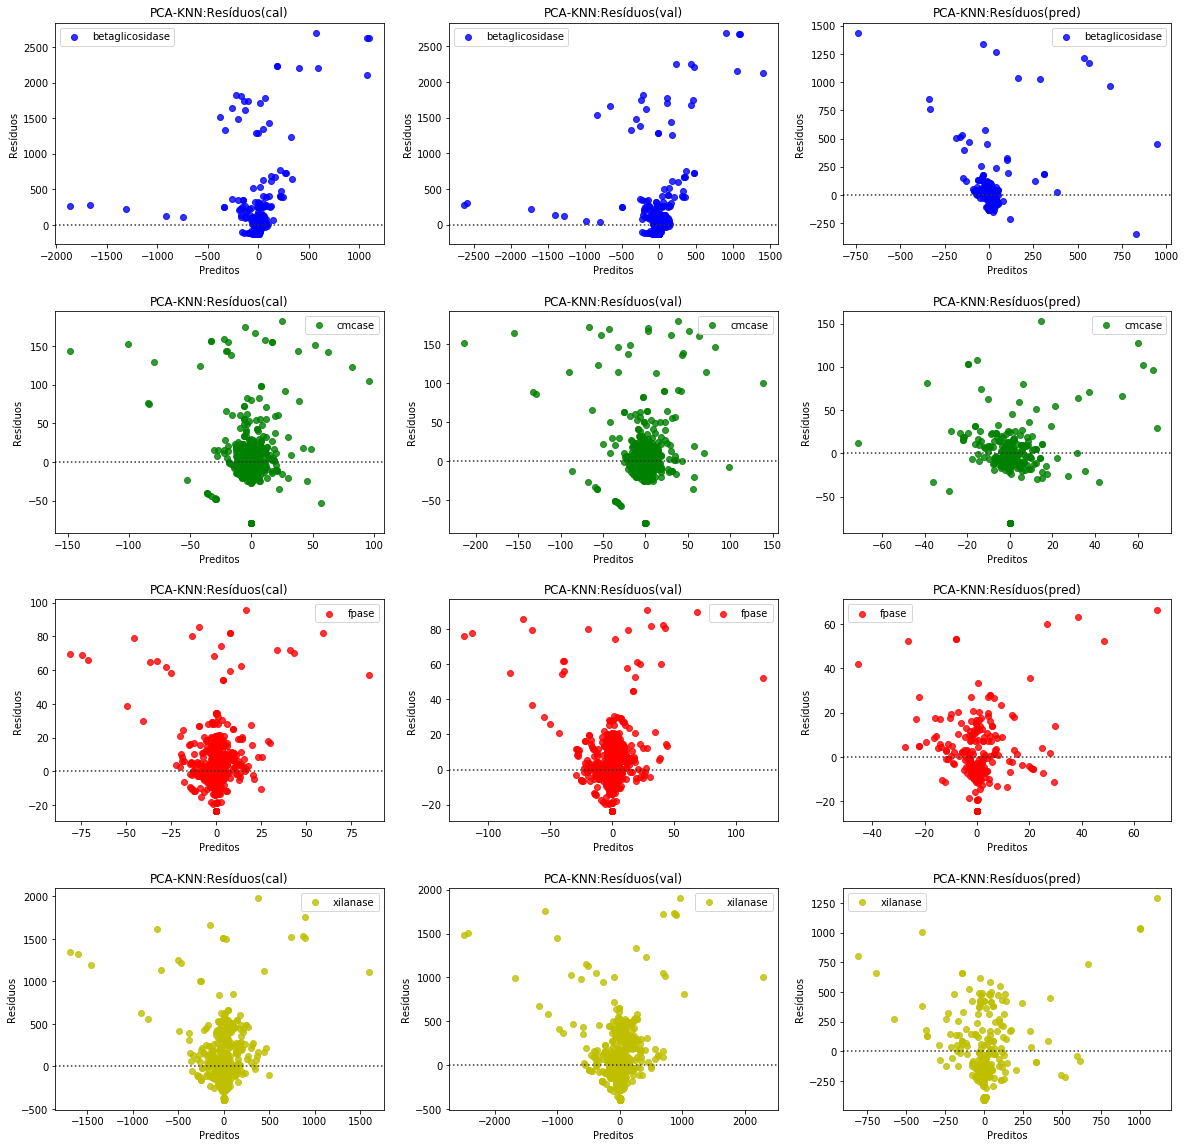

In [200]:
#gráfico dos resíduos
graficoResiduos(modelo, treino_teste, y_c,y_cv,y_p)

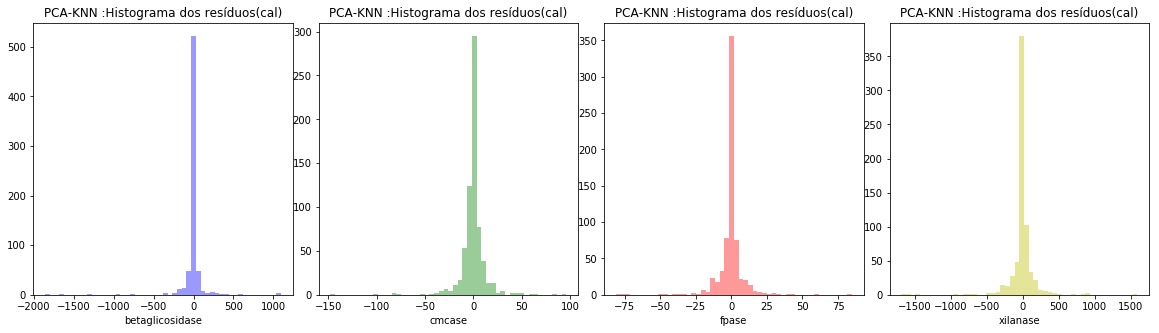

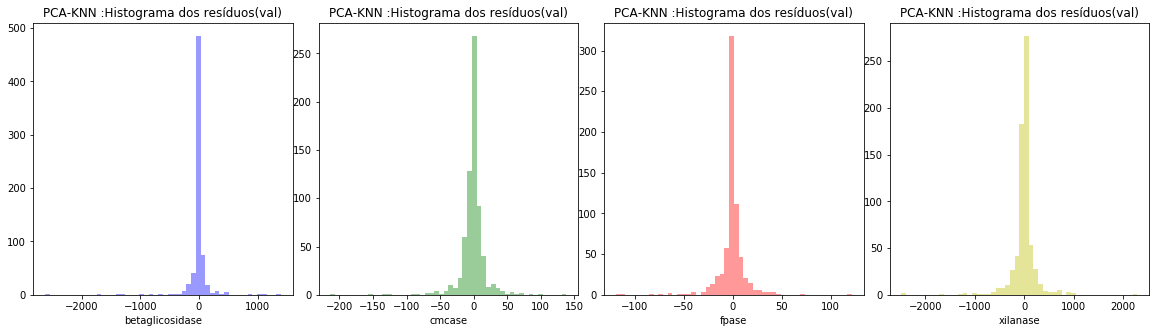

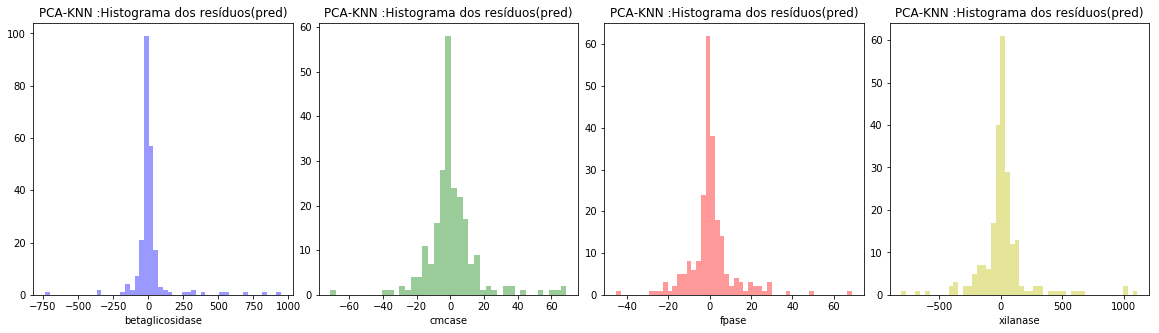

In [201]:
#histograma dos resíduos
graficoHist(modelo, treino_teste, y_c,y_cv,y_p)

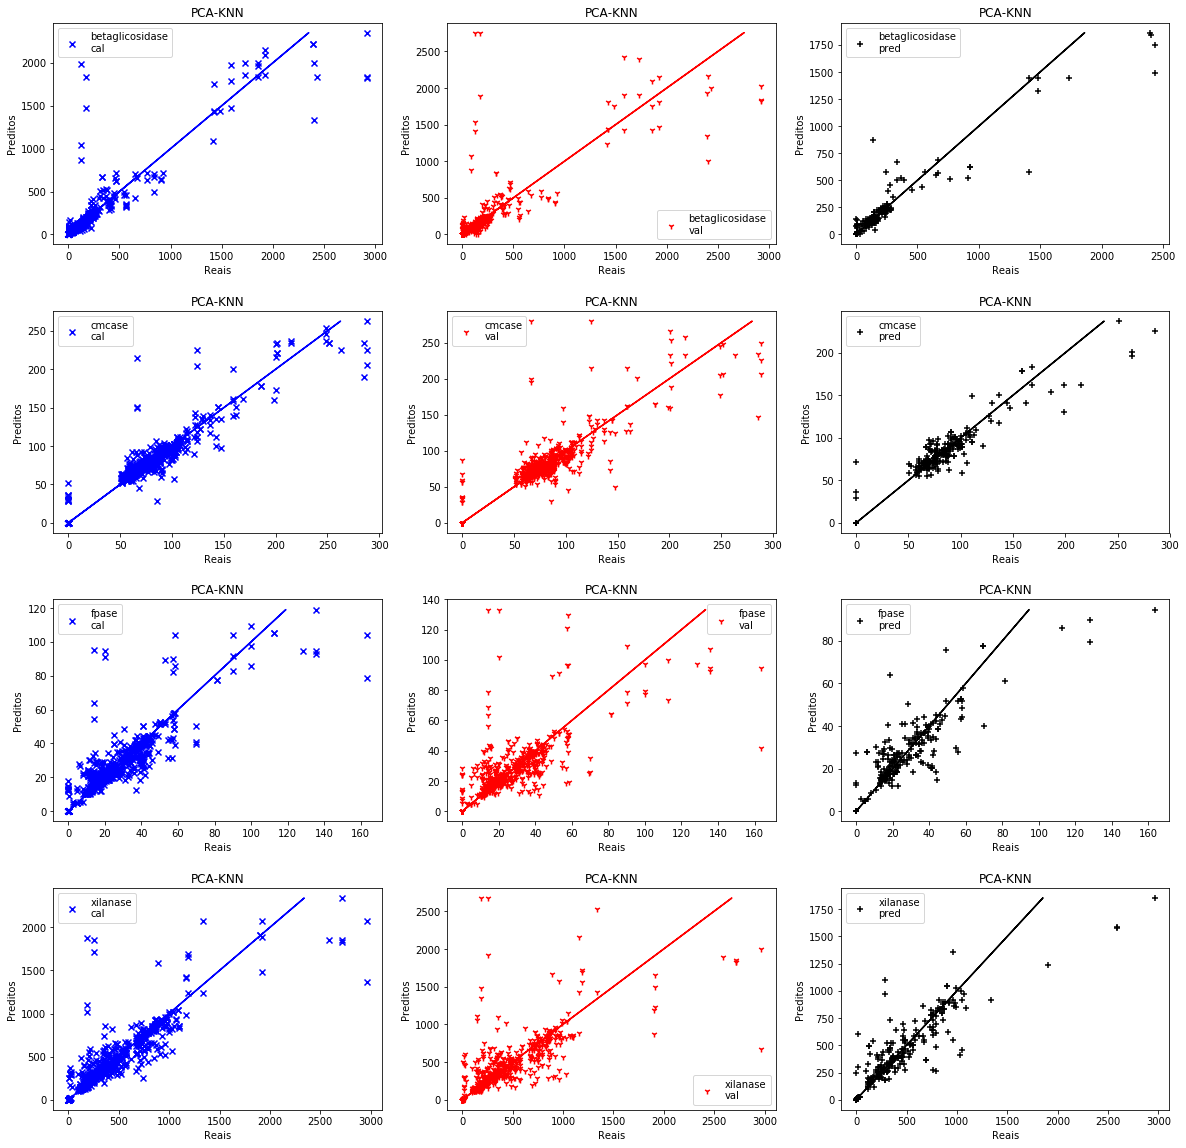

In [202]:
#graico de reais x preditos
graficoReaisPreditosSep(modelo, treino_teste, y_c,y_cv,y_p)

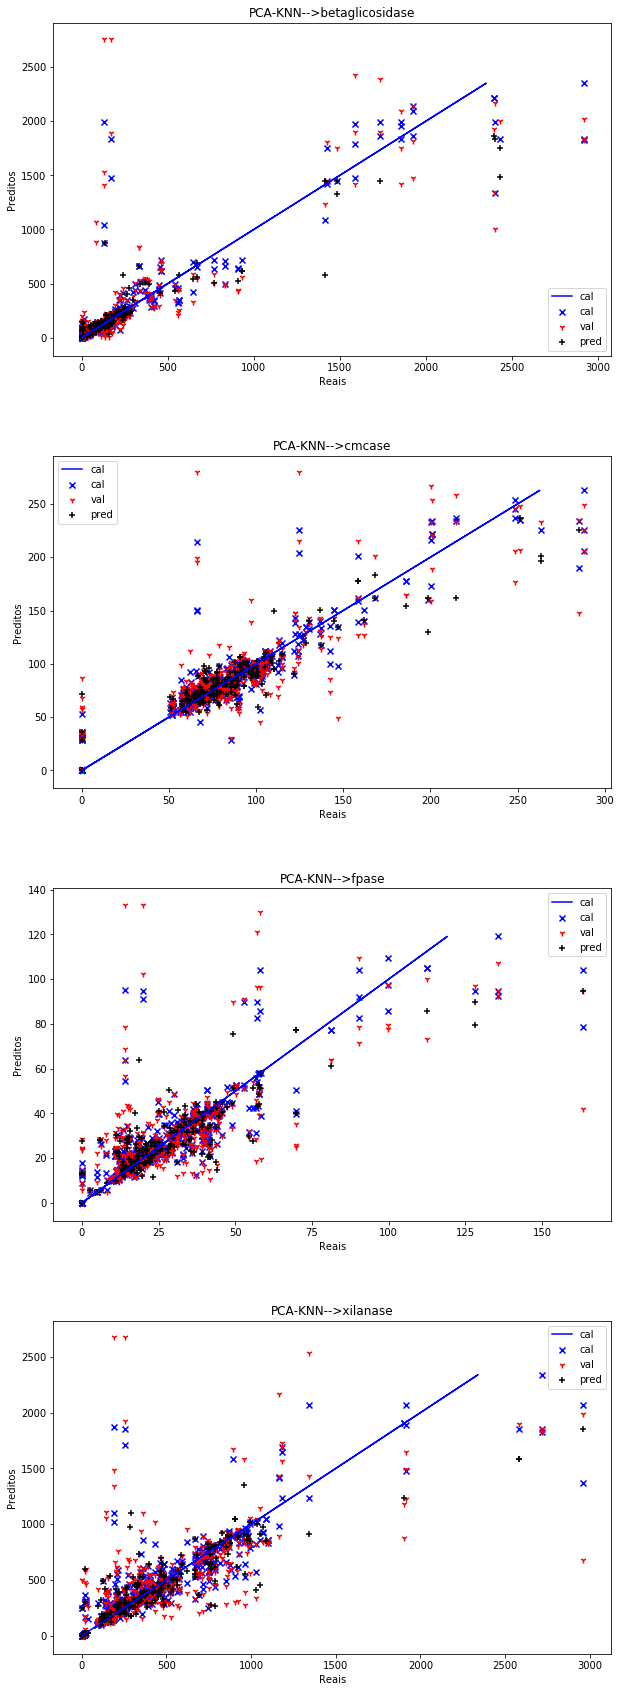

In [203]:
#graico de reais x preditos conjuntamente
graficoReaisPreditos(modelo, treino_teste, y_c,y_cv,y_p)

## KNN 

In [206]:
#knn
#função completa para execução do KNN:
#A variável preproc determinará o tipo de processamento que será executado (0,1,2,3..9)
from sklearn.neighbors import KNeighborsRegressor
def executaKNN(preproc,k,IC=0):
    #separando o conjunto de dados em treino e teste
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,False,IC)
    
    
    # Cria um objeto de regressão linear
    reg = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=k))
    #reg = KNeighborsRegressor(n_neighbors=n)


    result = executaCVP([x_treino, x_teste, y_treino, y_teste], reg)
    
    return result
    
    

### KNN: testes

In [207]:
#knn teste simples
modelo = 'KNN:'
preproc=1
k=2
result = executaKNN(preproc,k)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)

Parâmetros do modelo: KNN: 
 MultiOutputRegressor(estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=2, p=2,
          weights='uniform'),
           n_jobs=None)


In [208]:
resultados['cal']

betaglicosidase    cmcase    fpase    xilanase
BIAS           2.1674   -0.0063   0.1711      2.6558
MSE        17900.6232  134.0547  77.4126  25165.8214
R2             0.8757    0.9329   0.8232      0.8391
RER           21.8006   24.8516  18.5526     18.6546
RMSE         133.7932   11.5782   8.7984    158.6374
RPD            2.8362    3.8603   2.3780      2.4928
RPIQ           1.1527    2.5412   2.4206      2.6036
SEP          133.8740   11.5867   8.8032    158.7317

In [93]:
resultados['val']

betaglicosidase    cmcase     fpase    xilanase
BIAS           1.7507   -0.5881    0.1975      7.6514
MSE        43711.7560  368.0373  216.1773  76673.6386
R2             0.7650    0.8318    0.5720      0.6152
RER           13.9498   15.0058   11.1011     11.3479
RMSE         209.0736   19.1843   14.7030    276.9001
RPD            2.0630    2.4382    1.5286      1.6120
RPIQ           0.7074    1.5404    1.4401      1.7031
SEP          209.2175   19.1892   14.7123    276.9945

In [94]:
resultados['pred']

betaglicosidase    cmcase     fpase    xilanase
BIAS         -22.6300   -2.3635   -1.0341    -20.2928
MSE        17935.4083  261.9876  121.0932  46153.6860
R2             0.7502    0.8254    0.6130      0.6434
RER           14.0292   12.5294    8.2265      8.9451
RMSE         133.9231   16.1860   11.0042    214.8341
RPD            2.0007    2.3934    1.6074      1.6745
RPIQ           1.0056    1.4423    2.0535      2.1403
SEP          132.2840   16.0473   10.9793    214.3380

In [95]:
#knn teste completo
#Executa o modelo KNN variando o tipo de processamento e o número de vizinhos
for pre in range(0,12): 
    for viz in range(1,7):
        result = executaKNN(pre,viz)
        print('Pŕe-proc:',pre, '-> vizinhos:', viz,'\n')
        resultados=exibeResultados(result)
        for k,v in zip(resultados.keys(),resultados.values()):
            print(k)
            print(v,'\n-----------------------------------------------------')

Pŕe-proc: 0 -> vizinhos: 1 

cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS           0.3874    -1.0147   -0.1915      -3.1218
MSE       135399.7895  1075.7065  555.8353  220660.0209
R2             0.2722     0.5083   -0.1004      -0.1075
RER            7.9258     8.7773    6.9227       6.6869
RMSE         367.9671    32.7980   23.5762     469.7446
RPD            1.1722     1.4262    0.9533       0.9502
RPIQ           0.4019     0.9010    0.8981       1.0039
SEP          368.2331    32.8060   23

Pŕe-proc: 0 -> vizinhos: 6 

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          -5.3830   -1.8142   -0.4867     -8.2816
MSE        58487.0696  549.3962  243.3734  99929.4107
R2             0.6856    0.7489    0.5182      0.4985
RER           12.0623   12.3130   10.4667      9.9398
RMSE         241.8410   23.4392   15.6004    316.1161
RPD            1.7835    1.9956    1.4406      1.4120
RPIQ           0.6115    1.2608    1.3573      1.4918
SEP          241.9560   23.3858   15.6041    316.2362 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS          -1.4756   -2.0387   -0.4591      -6.4126
MSE        76924.5825  753.4517  326.4453  135382.7292
R2             0.5865    0.6556    0.3537       0.3205
RER           10.5154   10.5117    9.0358       8.5380
RMSE         277.3528   27.4491   18.0678     367.9439
RPD            1.5551    1.7041    1.2439       1.2131
RPIQ           0.5332    1.0766    1.

Pŕe-proc: 1 -> vizinhos: 5 

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           1.3790   -0.1795    0.1784      7.2525
MSE        27606.1668  200.1816  121.9821  42671.0246
R2             0.8516    0.9085    0.7585      0.7858
RER           17.5535   20.3387   14.7789     15.2151
RMSE         166.1510   14.1486   11.0446    206.5697
RPD            2.5960    3.3060    2.0349      2.1609
RPIQ           0.8901    2.0886    1.9172      2.2829
SEP          166.2655   14.1577   11.0511    206.5916 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase    xilanase
BIAS           4.0726   -0.2558    0.2465     10.1289
MSE        45642.9915  329.8033  190.7820  67322.5570
R2             0.7547    0.8493    0.6223      0.6621
RER           13.6535   15.8459   11.8177     12.1150
RMSE         213.6422   18.1605   13.8124    259.4659
RPD            2.0189    2.5756    1.6271      1.7203
RPIQ           0.6922    1.6272    1.5330   

Pŕe-proc: 2 -> vizinhos: 4 

cal
      betaglicosidase    cmcase     fpase     xilanase
BIAS          10.1371   -0.1213   -0.0831     -17.5168
MSE        83341.0412  794.3862  263.7552  116956.9684
R2             0.5520    0.6369    0.4778       0.4130
RER           10.1086   10.2091   10.0494       9.1967
RMSE         288.6885   28.1849   16.2405     341.9897
RPD            1.4941    1.6596    1.3839       1.3052
RPIQ           0.5123    1.0485    1.3038       1.3790
SEP          288.7191   28.2050   16.2521     341.7879 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS          11.2326    -0.4923   -0.1876     -23.4059
MSE       144025.8230  1393.3700  457.3471  199872.3463
R2             0.2258     0.3631    0.0946      -0.0032
RER            7.6881     7.7091    7.6318       7.0355
RMSE         379.5073    37.3279   21.3857     447.0709
RPD            1.1365     1.2531    1.0509       0.9984
RPIQ           0.3897

Pŕe-proc: 3 -> vizinhos: 3 

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          11.0449    0.4719    0.2119    -10.7087
MSE        72890.1405  720.2320  235.8058  99946.7879
R2             0.6082    0.6708    0.5332      0.4984
RER           10.8114   10.7234   10.6291      9.9412
RMSE         269.9817   26.8371   15.3560    316.1436
RPD            1.5976    1.7429    1.4636      1.4119
RPIQ           0.5478    1.1011    1.3789      1.4917
SEP          269.9508   26.8524   15.3656    316.1907 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS          13.9531    -0.4028   -0.2079     -26.8619
MSE       150834.3205  1453.0940  493.9742  214032.2667
R2             0.1892     0.3358    0.0221      -0.0742
RER            7.5142     7.5488    7.3435       6.8009
RMSE         388.3739    38.1195   22.2255     462.6362
RPD            1.1106     1.2271    1.0112       0.9648
RPIQ           0.3808     0.77

Pŕe-proc: 4 -> vizinhos: 2 

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           6.4444    0.1491    0.3797     -7.1376
MSE        39983.8612  481.8770  157.6868  63274.0657
R2             0.7851    0.7798    0.6878      0.6824
RER           14.5927   13.1082   13.0027     12.4921
RMSE         199.9596   21.9517   12.5573    251.5434
RPD            2.1570    2.1308    1.7898      1.7745
RPIQ           0.7396    1.3462    1.6862      1.8748
SEP          200.0003   21.9671   12.5607    251.6240 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS          18.0716     0.3499    0.3141     -21.8389
MSE       148813.6569  1613.4044  539.5328  221274.6664
R2             0.2001     0.2626   -0.0681      -0.1106
RER            7.5684     7.1638    7.0269       6.6846
RMSE         385.7637    40.1672   23.2278     470.3984
RPD            1.1181     1.1645    0.9676       0.9489
RPIQ           0.3834     0.73

Pŕe-proc: 5 -> vizinhos: 1 

cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS          18.6643     1.2397    0.4181     -20.7923
MSE       179110.8931  2060.2883  672.5581  297904.8807
R2             0.0372     0.0583   -0.3315      -0.4952
RER            6.8978     6.3416    6.2940       5.7590
RMSE         423.2149    45.3904   25.9337     545.8066
RPD            1.0192     1.0305    0.8666       0.8178
RPIQ           0.3494     0.6510    0.8165       0.8640
SEP          423.1090    45.4063   25

Pŕe-proc: 5 -> vizinhos: 6 

cal
      betaglicosidase    cmcase     fpase     xilanase
BIAS          10.0018   -0.5174   -0.0525     -15.4346
MSE        88855.0817  857.3853  282.2338  123544.1713
R2             0.5224    0.6081    0.4412       0.3799
RER            9.7894    9.8283    9.7147       8.9450
RMSE         298.0857   29.2811   16.7998     351.4885
RPD            1.4470    1.5974    1.3378       1.2699
RPIQ           0.4961    1.0092    1.2604       1.3417
SEP          298.1333   29.2977   16.8119     351.4035 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS          12.1666    -0.7822   -0.3169     -24.5881
MSE       129384.5456  1228.3942  404.2935  177473.5016
R2             0.3045     0.4385    0.1996       0.1093
RER            8.1126     8.2118    8.1178       7.4688
RMSE         359.7006    35.0485   20.1071     421.2760
RPD            1.1991     1.3346    1.1178       1.0596
RPIQ           0.4111

Pŕe-proc: 6 -> vizinhos: 5 

cal
      betaglicosidase     cmcase     fpase     xilanase
BIAS          19.9199     0.5314    0.2953      -1.5089
MSE       105253.9642  1276.7565  335.2000  138506.8618
R2             0.4342     0.4164    0.3364       0.3048
RER            9.0064     8.0537    8.9153       8.4400
RMSE         324.4287    35.7317   18.3085     372.1651
RPD            1.3295     1.3091    1.2276       1.1994
RPIQ           0.4558     0.8270    1.1565       1.2671
SEP          324.0508    35.7536   18.3193     372.4312 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS          18.9171    -0.4337   -0.1048     -14.7316
MSE       161117.6851  1954.9966  517.3553  215640.3009
R2             0.1340     0.1064   -0.0242      -0.0823
RER            7.2738     6.5080    7.1754       6.7675
RMSE         401.3947    44.2153   22.7454     464.3709
RPD            1.0746     1.0579    0.9881       0.9612
RPIQ        

Pŕe-proc: 7 -> vizinhos: 4 

cal
      betaglicosidase     cmcase     fpase     xilanase
BIAS          21.2451     0.6633    0.1684      -9.3403
MSE        90032.0038  1042.2695  293.9012  123087.5195
R2             0.5161     0.5236    0.4181       0.3822
RER            9.7442     8.9146    9.5204       8.9561
RMSE         300.0533    32.2842   17.1435     350.8383
RPD            1.4375     1.4488    1.3110       1.2723
RPIQ           0.4929     0.9153    1.2351       1.3442
SEP          299.5168    32.3007   17.1551     350.9676 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS          30.7289     1.5700    0.3042     -10.5235
MSE       155784.1580  1796.0136  511.0252  212323.8504
R2             0.1626     0.1791   -0.0117      -0.0657
RER            7.4116     6.7943    7.2202       6.8185
RMSE         394.6950    42.3794   22.6059     460.7861
RPD            1.0928     1.1037    0.9942       0.9687
RPIQ        

Pŕe-proc: 8 -> vizinhos: 3 

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           4.1803   -0.4429    0.1743      3.5741
MSE        43336.5369  284.1477  150.3711  56939.1123
R2             0.7671    0.8701    0.7023      0.7142
RER           14.0124   17.0757   13.3105     13.1649
RMSE         208.1743   16.8567   12.2626    238.6192
RPD            2.0719    2.7749    1.8328      1.8706
RPIQ           0.7104    1.7531    1.7267      1.9763
SEP          208.2829   16.8630   12.2702    238.7650 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS          15.0143   -0.3637    0.3426       8.3210
MSE        69451.1004  500.8266  266.8130  102544.2118
R2             0.6267    0.7711    0.4718       0.4853
RER           11.0845   12.8592    9.9937       9.8122
RMSE         263.5358   22.3792   16.3344     320.2253
RPD            1.6367    2.0901    1.3759       1.3939
RPIQ           0.5612    1.3205    1.

Pŕe-proc: 9 -> vizinhos: 2 

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          11.3711    0.3647    0.8315     14.8454
MSE        37407.1797  307.4896  126.7739  49150.2816
R2             0.7989    0.8595    0.7490      0.7533
RER           15.1052   16.4127   14.5347     14.2000
RMSE         193.4094   17.5354   11.2594    221.6986
RPD            2.2301    2.6675    1.9961      2.0134
RPIQ           0.7646    1.6852    1.8806      2.1272
SEP          193.2145   17.5443   11.2368    221.3610 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS          32.2318    1.4442    1.5958      22.4004
MSE       127762.2888  952.4169  408.3478  164811.1904
R2             0.3132    0.5647    0.1916       0.1728
RER            8.1926    9.3339    8.1017       7.7490
RMSE         357.4385   30.8613   20.2076     405.9694
RPD            1.2067    1.5157    1.1122       1.0995
RPIQ           0.4137    0.9575    1.

Pŕe-proc: 10 -> vizinhos: 1 

cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS          -3.7365    -2.8394   -0.6857     -11.8347
MSE       138351.0267  1148.5706  530.9509  217560.3340
R2             0.2563     0.4750   -0.0512      -0.0919
RER            7.8412     8.5202    7.0860       6.7363
RMSE         371.9557    33.8906   23.0424     466.4336
RPD            1.1596     1.3802    0.9754       0.9570
RPIQ           0.3976     0.8720    0.9189       1.0111
SEP          372.2059    33.7958   2

Pŕe-proc: 10 -> vizinhos: 6 

cal
      betaglicosidase    cmcase     fpase     xilanase
BIAS          -2.9901   -2.1206   -0.6514     -11.0045
MSE        65537.0113  599.5181  256.4861  107772.4655
R2             0.6477    0.7260    0.4922       0.4591
RER           11.3930   11.7960   10.1991       9.5734
RMSE         256.0020   24.4851   16.0152     328.2872
RPD            1.6848    1.9103    1.4033       1.3597
RPIQ           0.5777    1.2069    1.3221       1.4365
SEP          256.1697   24.4107   16.0135     328.3400 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS          -3.1673   -2.7093   -0.7345     -15.0847
MSE        95365.1254  876.9756  362.3664  148591.8753
R2             0.4874    0.5992    0.2826       0.2542
RER            9.4445    9.7574    8.5799       8.1547
RMSE         308.8124   29.6138   19.0359     385.4762
RPD            1.3967    1.5795    1.1806       1.1580
RPIQ           0.4789    0.

Pŕe-proc: 11 -> vizinhos: 5 

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          -3.0192   -2.0459   -0.6685    -11.2387
MSE        57291.1504  523.2846  228.1640  96387.3956
R2             0.6920    0.7608    0.5483      0.5162
RER           12.1855   12.6292   10.8152     10.1239
RMSE         239.3557   22.8754   15.1051    310.4632
RPD            1.8020    2.0448    1.4879      1.4377
RPIQ           0.6179    1.2918    1.4018      1.5190
SEP          239.5098   22.8002   15.1012    310.4841 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS          -4.2757   -2.6707   -0.8142     -14.4915
MSE        97564.2792  866.1821  374.8695  154929.9840
R2             0.4756    0.6041    0.2579       0.2224
RER            9.3378    9.8173    8.4368       7.9855
RMSE         312.3528   29.4310   19.3615     393.6115
RPD            1.3809    1.5893    1.1608       1.1340
RPIQ           0.4735    1.0041    1

In [212]:
#Executa o modelo KNN variando os pre-proc mais efetivos
for pre in [1,8,9]: 
    for viz in range(1,4):
        result = executaKNN(pre,viz,0)
        print('Pŕe-proc:',pre, '-> vizinhos:', viz,'\n')
        resultados=exibeResultados(result)
        for k,v in zip(resultados.keys(),resultados.values()):
            print(k)
            print(v,'\n-----------------------------------------------------')

Pŕe-proc: 1 -> vizinhos: 1 

cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           5.6655    0.1272    0.6289       9.8185
MSE        71366.3570  538.6753  307.6889  100848.4593
R2             0.5044    0.7304    0.2972       0.3551
RER           10.9194   12.3976    9.3100       9.3219
RMSE         267.1448   23.2094   17.5411     317.5665
RPD            1.4204    1.9258    1.1928       1.2453
RPIQ           0.5773    1.2677    1.2141       1.3006
SEP          267.2811   23.2261   17.5427    

Pŕe-proc: 8 -> vizinhos: 3 

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           7.0496   -0.6020    0.3579      4.1957
MSE        28434.7621  227.5366  119.6219  39073.6128
R2             0.8025    0.8861    0.7268      0.7501
RER           17.3102   19.0905   14.9299     14.9722
RMSE         168.6261   15.0843   10.9372    197.6705
RPD            2.2503    2.9630    1.9130      2.0006
RPIQ           0.9146    1.9506    1.9472      2.0895
SEP          168.6025   15.0834   10.9394    197.7712 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase    xilanase
BIAS           9.8659   -1.0289    0.4044      6.1220
MSE        61619.5692  482.5831  249.3240  87426.0660
R2             0.5721    0.7584    0.4305      0.4410
RER           11.7579   13.1125   10.3392     10.0093
RMSE         248.2329   21.9678   15.7900    295.6790
RPD            1.5287    2.0346    1.3251      1.3374
RPIQ           0.6213    1.3394    1.3488   

In [213]:
#teste 2 escolhendo o modelo otimizado
#knn otimizado
maior=[-1,-1,-1,-1]
maiorGerado=[0,0,0,0]
for i in range(100):
    result = executaKNN(1,3,i)
    resultados=exibeResultados(result)
    r2 = resultados['pred'].loc[resultados['pred'].index=='R2']
    r = []
    for j in range(4):
        r.append(r2.iloc[:,j][0])
        if r[j]>maior[j]:
            maior[j] = r[j]
            maiorGerado[j]=i
    print('\r%d%% completos'%(i+1), end='')
print('\n','r2:',maior,'\nsemente: b c f x',maiorGerado)

100% completos
 r2: [0.8942, 0.918, 0.7688, 0.7777] 
semente: b c f x [21, 25, 26, 26]


In [ ]:
#teste 2 escolhendo o modelo otimizado
#knn otimizado
maior=[-1,-1,-1,-1]
maiorGerado=[0,0,0,0]
for i in range(100):
    result = executaKNN(1,2,i)
    resultados=exibeResultados(result)
    r2 = resultados['val'].loc[resultados['val'].index=='R2']
    r = []
    for j in range(4):
        r.append(r2.iloc[:,j][0])
        if r[j]>maior[j]:
            maior[j] = r[j]
            maiorGerado[j]=i
    print('\r%d%% completos'%(i+1), end='')
print('\n','r2:',maior,'\nsemente: b c f x',maiorGerado)

In [227]:
#knn teste otimizado
#@knnotimizado
preproc=1
k=2
gera=26
result = executaKNN(preproc,k, gera)
print('Parâmetros do modelo:',modelo,'\n',result[0])
resultados=exibeResultados(result)

Parâmetros do modelo: KNN: 
 MultiOutputRegressor(estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=2, p=2,
          weights='uniform'),
           n_jobs=None)


In [228]:
resultados['cal']

betaglicosidase    cmcase    fpase    xilanase
BIAS          -1.6493   -0.2419   0.1180      2.4171
MSE        16478.7752  127.2498  75.2622  24668.4169
R2             0.8733    0.9325   0.8148      0.8296
RER           22.7206   25.5133  18.8139     18.8413
RMSE         128.3697   11.2805   8.6754    157.0618
RPD            2.8094    3.8498   2.3236      2.4229
RPIQ           1.2055    2.4628   2.2940      2.5212
SEP          128.4534   11.2862   8.6810    157.1587

In [229]:
resultados['val']

betaglicosidase    cmcase     fpase    xilanase
BIAS          -0.5076   -0.1189   -0.0791      0.1547
MSE        53847.6806  398.4667  236.9842  84242.0997
R2             0.5860    0.7887    0.4168      0.4183
RER           12.5679   14.4148   10.6017     10.1945
RMSE         232.0510   19.9616   15.3943    290.2449
RPD            1.5541    2.1756    1.3094      1.3111
RPIQ           0.6669    1.3917    1.2928      1.3643
SEP          232.2210   19.9759   15.4054    290.4582

In [230]:
resultados['pred']

betaglicosidase    cmcase     fpase    xilanase
BIAS           9.9889   -0.0420    0.9030     24.8146
MSE        32957.8690  257.0337  115.4871  39872.4078
R2             0.8198    0.8882    0.7718      0.7920
RER           16.0652   17.9210   12.6422     13.6966
RMSE         181.5430   16.0323   10.7465    199.6808
RPD            2.3555    2.9909    2.0935      2.1928
RPIQ           0.7141    1.6036    2.0406      2.8559
SEP          181.6686   16.0676   10.7321    198.5708

In [231]:
#variáveis para geração de gráficos e testes
reg, treino_teste,y_c,y_cv,y_p = result

### Reais x preditos

In [112]:
#knn reaisxpreditos
#calibração
pred=pd.DataFrame(y_c, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('CALIBRAÇÃO:\n')
round(reais_pred,4)

CALIBRAÇÃO:



betaglicosidase    cmcase    fpase   xilanase  pred: betaglicosidase  \
0           115.7786   87.2116  12.1474   152.4512               100.0259   
1           241.6059  104.7929  36.2992   851.6944               192.6405   
2           127.8781   88.7215  40.9545   754.1396               126.0786   
3             0.0554    0.0181   0.0106     0.3275                 0.1113   
4            93.1868   68.5254  13.3691   154.9180               124.0195   
5             0.1671    0.0117   0.0104     0.1117                 0.1671   
6           908.1736   67.5962  26.0061   152.8057               908.1736   
7           113.3065   77.5002  33.0827   929.3628               113.3065   
8           380.0074   79.7861  40.9537   410.5377               573.2145   
9          1411.9200  198.7880  55.8310  1050.1520               747.9255   
10           66.4158   85.3345  17.5689   434.6522                54.4625   
11          154.8522   79.5483  19.7968   218.6271               148.4372   
12          200.7020  130.1010  25.0710   346.5400               225.8620   
13          216.9391   70.1092  17.6056   204.3168               212.2911   
14          131.1772   75.7150  23.1783   387.8630               126.0036   
15          386.2500   16.0400  29.2700   490.1500               195.0650   
16            0.0554    0.0181   0.0106     0.3275                 0.1113   
17          174.3269   88.8776  41.5095   483.9741               152.2322   
18           41.8395   70.4412  10.0650   170.7917                43.7843   
19          132.2443   70.7466  29.2649   392.1644               137.1332   
20           64.0786   77.4722  17.6446   330.8339                64.0786   
21          366.7932   61.2608  21.3677   116.6604               463.2967   
22          150.7844   96.0133  31.3473   479.4694               150.8276   
23          142.0221   75.4853  33.9295   432.9210               137.1332   
24          110.4872   97.6145  30.0285   419.8360               128.6181   
25          229.4566   85.1762  17.7045   477.4046               210.6804   
26          205.7102   68.9223  17.3913   313.7515               222.0013   
27           62.9566   70.9994  15.1281   348.7295                43.3419   
28            2.4860    0.0510   0.0260     3.5110                 2.5665   
29          418.0481   82.8689  19.7556   192.6180               409.2387   
..               ...       ...      ...        ...                    ...   
662        1586.9160  200.3440  57.0920  1163.2500              2252.7421   
663          64.0786   77.4722  17.6446   330.8339                64.0786   
664         120.8300   62.7409  11.9786   271.2614               124.3540   
665         140.6997   79.7683  31.2402   474.4112               137.8879   
666          89.8645   85.1385  12.9388   261.2070                89.8645   
667         195.4095   52.6062  17.0122   110.8981               195.4095   
668           0.3900    0.0315   0.0283    14.1777                 0.3900   
669         189.1429  101.0838  20.7583   333.5429               206.2624   
670           0.6010    0.0559   0.0116    20.1368                 0.6251   
671         143.6750  104.6610  35.7387   767.4563               143.6750   
672         101.9210   65.0621  11.6872   336.7149               101.9210   
673         143.3068  109.3426  33.5792   863.4196               171.4712   
674          59.8397   56.4023  10.0402   353.3169                59.8397   
675         205.1579   85.6789  22.9796   527.6314               215.2824   
676         112.6993   96.4298  28.7420   438.2838               131.7851   
677         205.1579   85.6789  22.9796   527.6314               217.3073   
678         122.1421   81.0625  30.8740   335.9919               118.6556   
679         117.2695   88.7665  16.2567   359.8273               117.2695   
680         133.2707   74.8560  17.8949   135.6123               153.7988   
681         101.9210   65.0621  11.6872   336.7149               101.9210   
6

In [113]:
#validação
pred=pd.DataFrame(y_cv, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('VALIDAÇÃO CRUZADA:\n')
round(reais_pred,4)

VALIDAÇÃO CRUZADA:



betaglicosidase    cmcase    fpase   xilanase  pred: betaglicosidase  \
0           115.7786   87.2116  12.1474   152.4512               100.7714   
1           241.6059  104.7929  36.2992   851.6944               143.6750   
2           127.8781   88.7215  40.9545   754.1396               122.5920   
3             0.0554    0.0181   0.0106     0.3275                 0.2749   
4            93.1868   68.5254  13.3691   154.9180               167.9524   
5             0.1671    0.0117   0.0104     0.1117                 0.2749   
6           908.1736   67.5962  26.0061   152.8057               778.0341   
7           113.3065   77.5002  33.0827   929.3628                88.1316   
8           380.0074   79.7861  40.9537   410.5377               610.0540   
9          1411.9200  198.7880  55.8310  1050.1520               106.0065   
10           66.4158   85.3345  17.5689   434.6522                86.8248   
11          154.8522   79.5483  19.7968   218.6271               154.9062   
12          200.7020  130.1010  25.0710   346.5400               249.8170   
13          216.9391   70.1092  17.6056   204.3168               207.6430   
14          131.1772   75.7150  23.1783   387.8630               121.0924   
15          386.2500   16.0400  29.2700   490.1500                 3.8800   
16            0.0554    0.0181   0.0106     0.3275                 0.3828   
17          174.3269   88.8776  41.5095   483.9741               131.7040   
18           41.8395   70.4412  10.0650   170.7917                67.7968   
19          132.2443   70.7466  29.2649   392.1644               102.5865   
20           64.0786   77.4722  17.6446   330.8339                47.0666   
21          366.7932   61.2608  21.3677   116.6604               565.2059   
22          150.7844   96.0133  31.3473   479.4694               151.9080   
23          142.0221   75.4853  33.9295   432.9210               156.8645   
24          110.4872   97.6145  30.0285   419.8360               146.7490   
25          229.4566   85.1762  17.7045   477.4046               198.8072   
26          205.7102   68.9223  17.3913   313.7515               222.0013   
27           62.9566   70.9994  15.1281   348.7295                62.9054   
28            2.4860    0.0510   0.0260     3.5110                 2.4990   
29          418.0481   82.8689  19.7556   192.6180               314.1368   
..               ...       ...      ...        ...                    ...   
662        1586.9160  200.3440  57.0920  1163.2500              2658.0346   
663          64.0786   77.4722  17.6446   330.8339                73.6478   
664         120.8300   62.7409  11.9786   271.2614               129.5277   
665         140.6997   79.7683  31.2402   474.4112               138.9001   
666          89.8645   85.1385  12.9388   261.2070               108.7450   
667         195.4095   52.6062  17.0122   110.8981               247.6655   
668           0.3900    0.0315   0.0283    14.1777                 0.3864   
669         189.1429  101.0838  20.7583   333.5429               238.0163   
670           0.6010    0.0559   0.0116    20.1368                 0.6491   
671         143.6750  104.6610  35.7387   767.4563               192.6405   
672         101.9210   65.0621  11.6872   336.7149                88.8612   
673         143.3068  109.3426  33.5792   863.4196               218.4118   
674          59.8397   56.4023  10.0402   353.3169                67.8206   
675         205.1579   85.6789  22.9796   527.6314               227.4317   
676         112.6993   96.4298  28.7420   438.2838               150.8708   
677         205.1579   85.6789  22.9796   527.6314               233.3223   
678         122.1421   81.0625  30.8740   335.9919                99.5920   
679         117.2695   88.7665  16.2567   359.8273               116.5241   
680         133.2707   74.8560  17.8949   135.6123               124.3571   
681         101.9210   65.0621  11.6872   336.7149                88.8612   
6

In [114]:
#predição
pred=pd.DataFrame(y_p, columns=var_ae)
reais = treino_teste[3]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('Predição (validação externa):\n')
round(reais_pred,4)

Predição (validação externa):



betaglicosidase    cmcase    fpase   xilanase  pred: betaglicosidase  \
0           929.7967   90.5053  57.6406   484.1380               585.0271   
1            94.7370   77.3428  38.3458   759.9913                94.4371   
2             5.2454   69.2948  17.1509   228.4595                 8.9313   
3           284.9550  186.0570  81.3060  1088.4810               266.7835   
4            24.8756   56.7357  11.4848   359.5063                73.7997   
5             3.8876    0.0418   0.0605    11.0267                 3.1058   
6             3.8994    0.1118   0.0613    10.9512                 3.5031   
7           449.2816   57.7820  18.8506   127.3992               377.6048   
8           217.1860  136.7850  28.4820   399.5940               235.3895   
9           229.4566   85.1762  17.7045   477.4046               215.5125   
10          133.2707   74.8560  17.8949   135.6123               152.2322   
11          386.2500   16.0400  29.2700   490.1500               386.2500   
12            3.5610    0.0586   0.0561    10.0978                 3.2692   
13            7.6554   61.8889  14.9137   196.3804                70.5125   
14          274.2940   78.7396  19.7839   142.5907               208.8239   
15          131.1404   82.9533  38.8096   964.9698               104.3512   
16          225.3148  102.3202  18.6276   340.3618               210.6804   
17          225.4068  103.6390  29.3921   387.2623               234.0586   
18          262.6816   58.2628  16.9556   114.0412               321.3445   
19           41.8395   70.4412  10.0650   170.7917                25.9032   
20          139.6252  124.0305  36.3651   869.1574               175.1528   
21            3.7243    0.0561   0.0681    11.5736                 3.7243   
22          136.2851  112.3726  26.5009   313.8180               130.9036   
23          148.2880  113.1132  30.2038   389.0414               115.7526   
24            3.8803    0.0557   0.0691    11.3256                 2.7110   
25            1.5840    0.0310   0.0580    20.8190                 3.2675   
26          274.2940   78.7396  19.7839   142.5907               445.0771   
27           97.5113   73.9894  13.4762   248.3601                94.1747   
28          112.1323   67.4617  13.0204   261.7252               111.8324   
29          121.4940   85.0181  27.4416   519.3680               106.1520   
..               ...       ...      ...        ...                    ...   
201         299.9215   60.1578  20.9152   119.5415               380.0074   
202           3.8876    0.0418   0.0605    11.0267                 3.3508   
203         133.1267   65.1176  13.8181   304.2046               136.5383   
204         113.3065   77.5002  33.0827   929.3628               102.0835   
205         142.2865   72.0948  43.6555   995.1155               143.7855   
206         133.2707   74.8560  17.8949   135.6123               109.4202   
207         123.0794   77.4893  36.4128   564.8606               119.3304   
208          38.1276   60.8791  16.0449   349.3120                88.1316   
209         551.4800   79.6700  35.7800   863.7200               551.4800   
210         116.8482   69.1918  12.5362   116.0920               105.0445   
211         130.8023   67.3478  14.2291   203.0631               133.6703   
212         152.1716   79.6951  30.5321   430.4869               143.6239   
213           2.1643    0.0830   0.0529    18.8324                 2.1150   
214         559.8001   89.9679  21.5516   138.4000               235.0520   
215         388.0160   59.7335  23.9698   258.8844               622.4673   
216         123.0794   77.4893  36.4128   564.8606               121.5236   
217         102.3850   84.4566  38.0406   765.6264               102.8911   
218           0.0874    0.0217   0.0127     0.1071                 0.0816   
219           3.8876    0.0418   0.0605    11.0267                 3.7385   
220         210.6804  105.1555  43.9316   825.3336               187.4402   
2

### KNN: Gráficos dos resíduos

In [162]:
#knnGraf

In [115]:
#título para os gráficos
modelo = 'KNN'

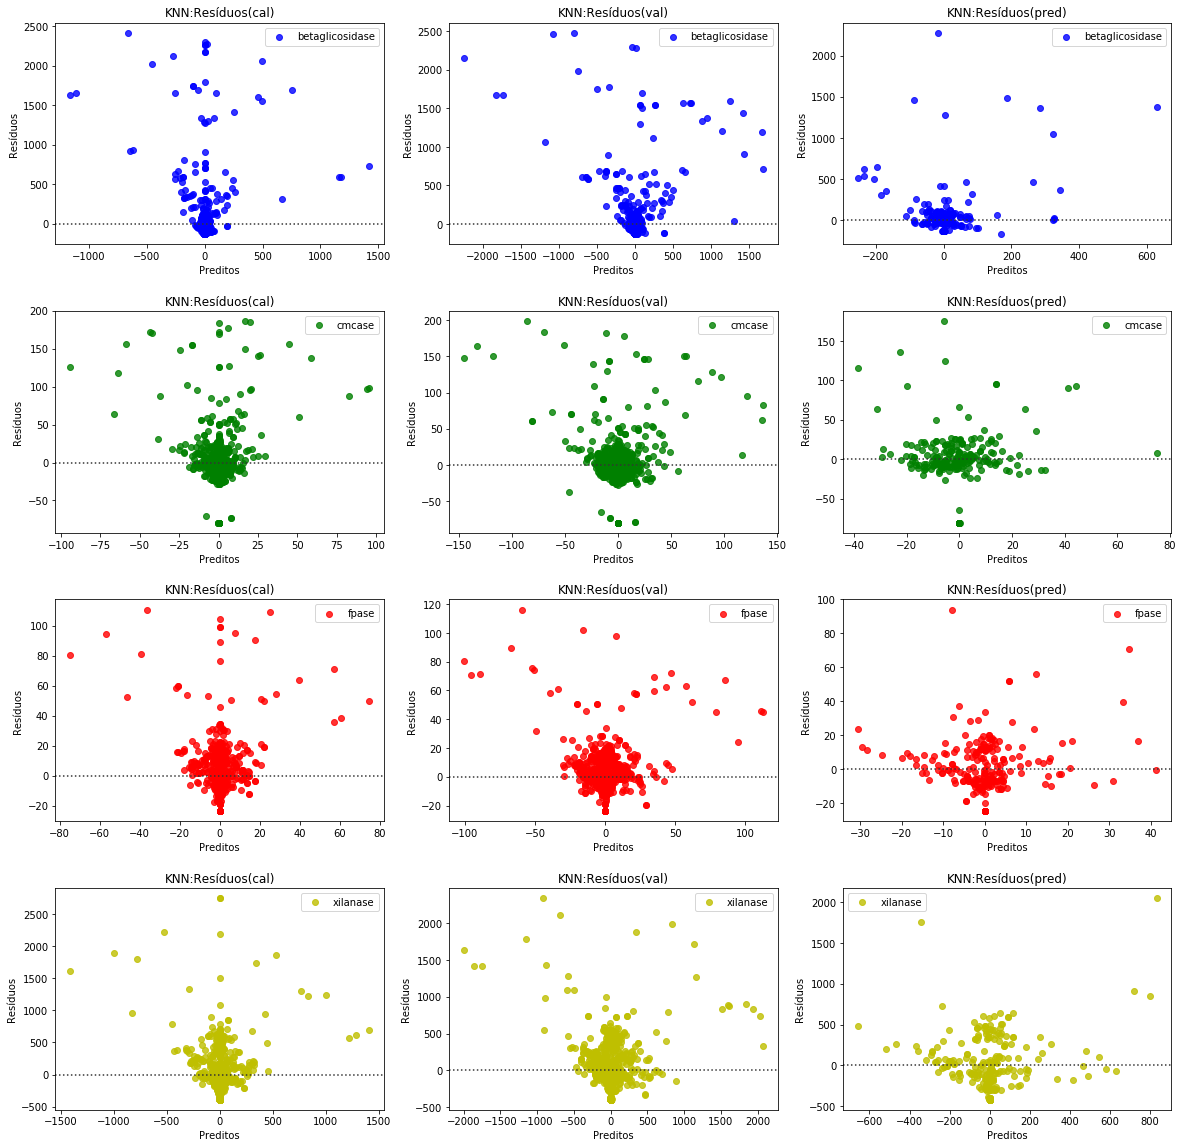

In [116]:
#gráfico dos resíduos
graficoResiduos(modelo, treino_teste, y_c,y_cv,y_p)

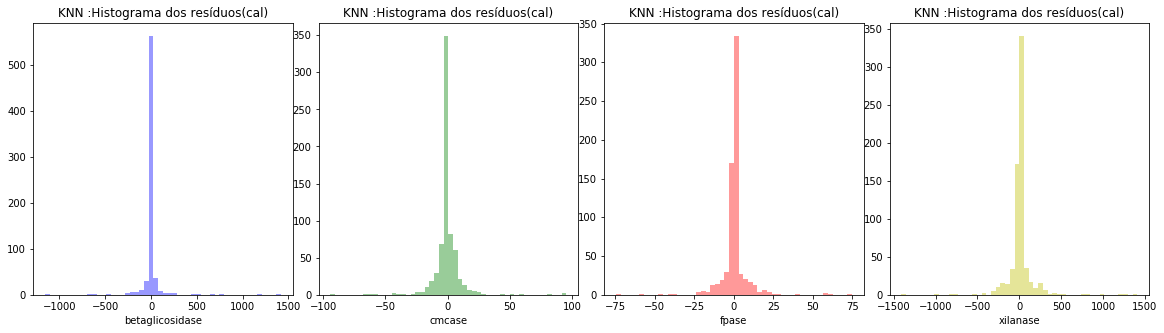

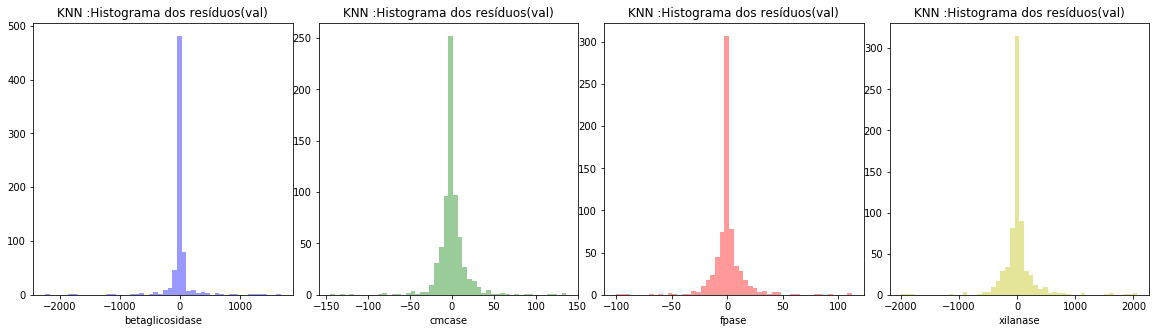

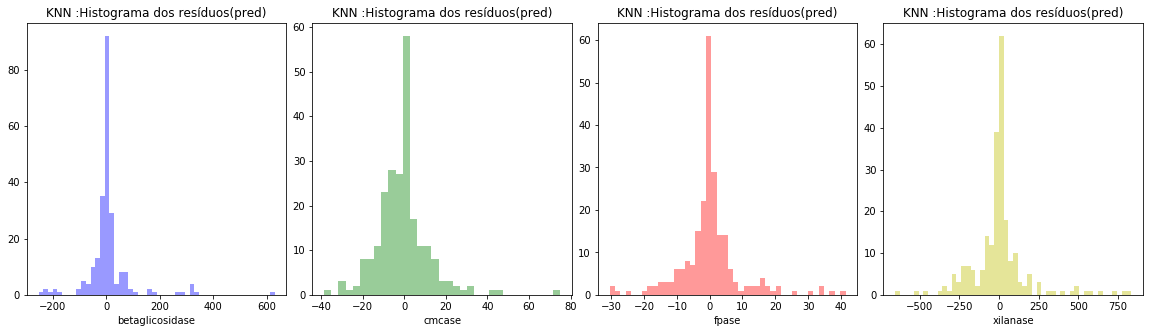

In [117]:
#histograma dos resíduos
graficoHist(modelo, treino_teste, y_c,y_cv,y_p)

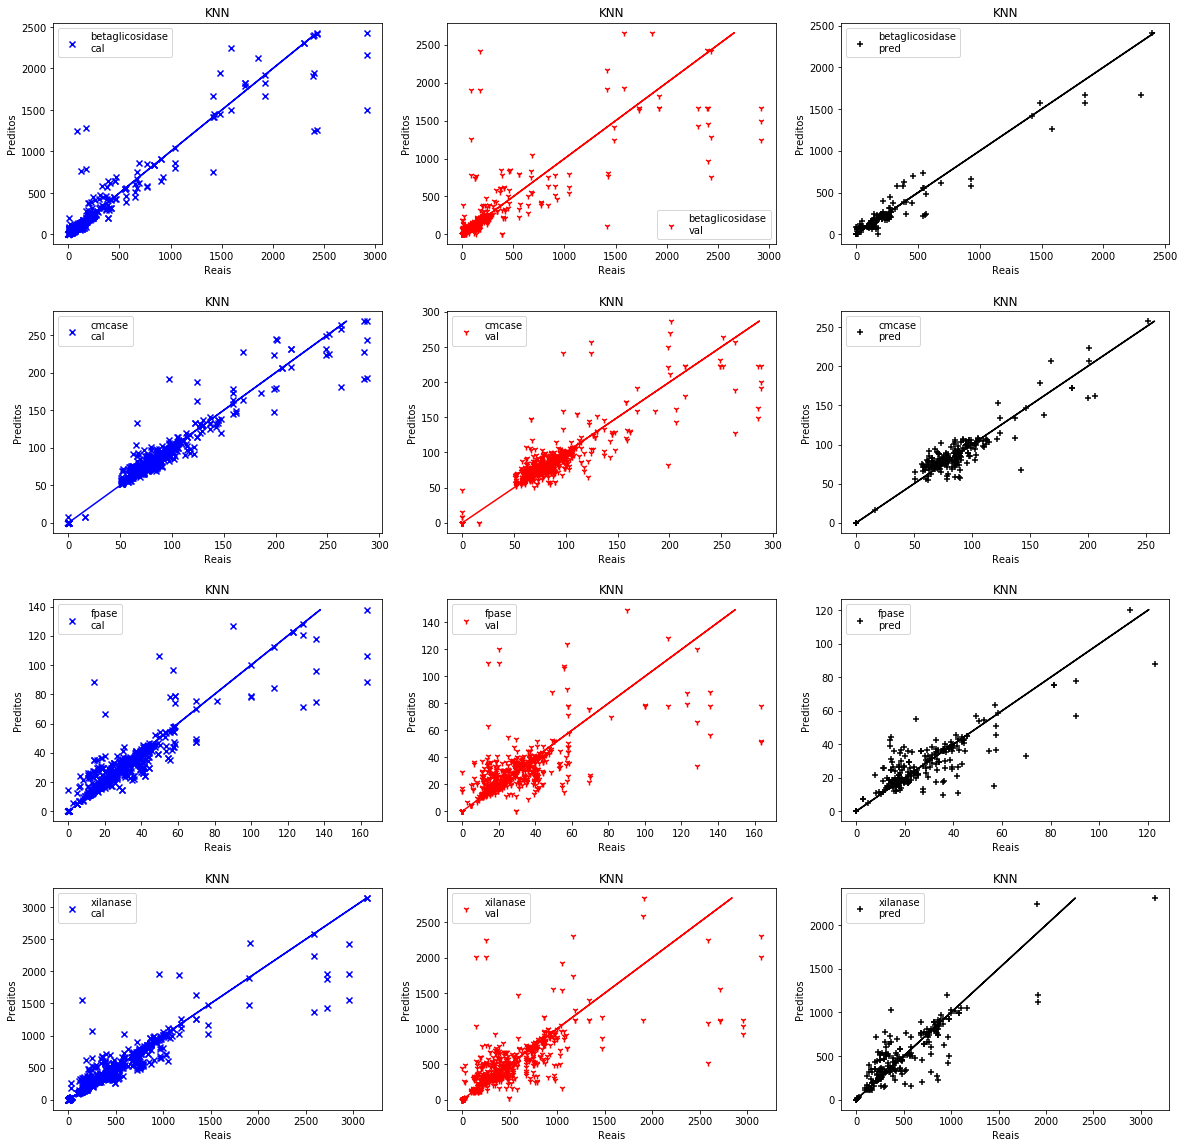

In [118]:
#grafico de reais x preditos
graficoReaisPreditosSep(modelo, treino_teste, y_c,y_cv,y_p)

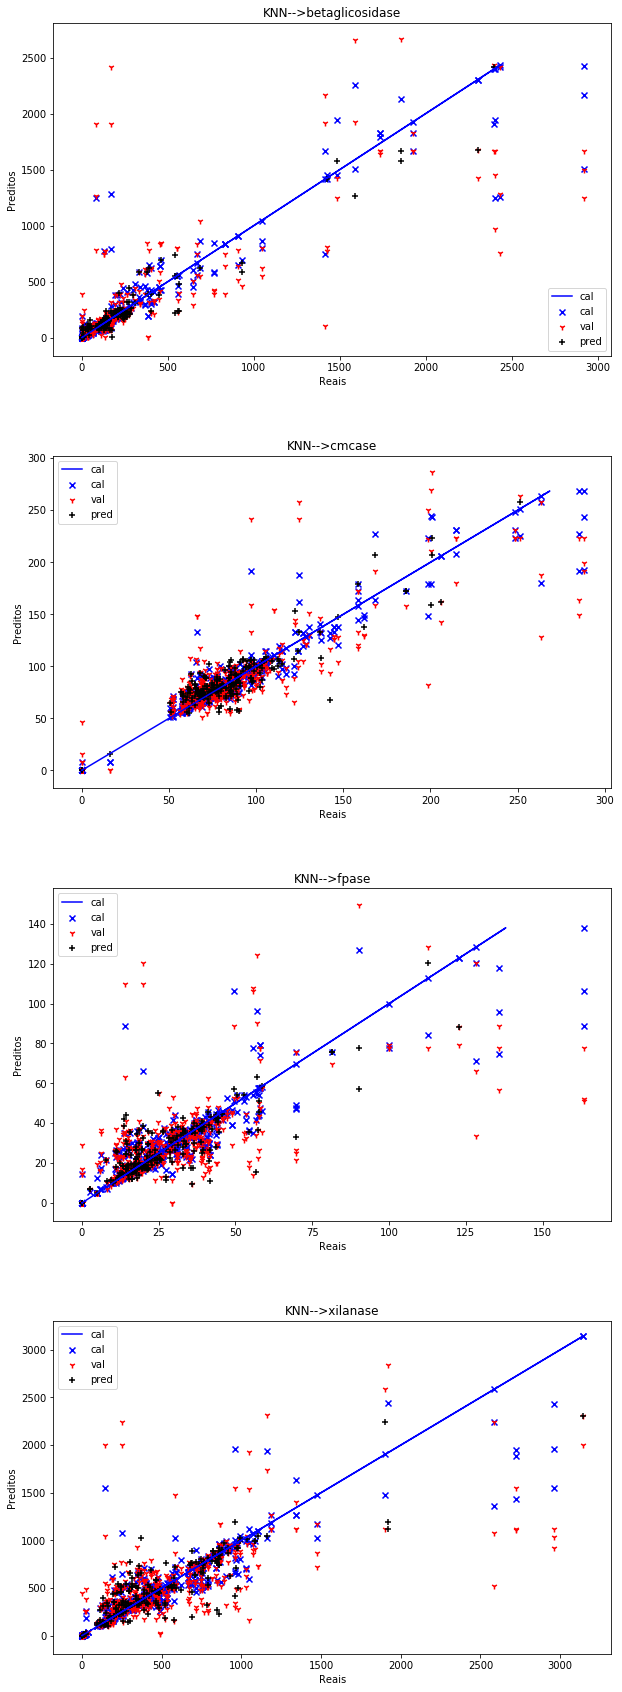

In [119]:
#grafico de reais x preditos conjuntamente
graficoReaisPreditos(modelo, treino_teste, y_c,y_cv,y_p)

### KNN: Gráficos: dados de treino

In [120]:
y_treino = treino_teste[2]
graficoTreinamento(modelo, y_treino, y_c,y_cv)

TypeError: '<' not supported between instances of 'str' and 'int'

### KNN:Gráficos de teste

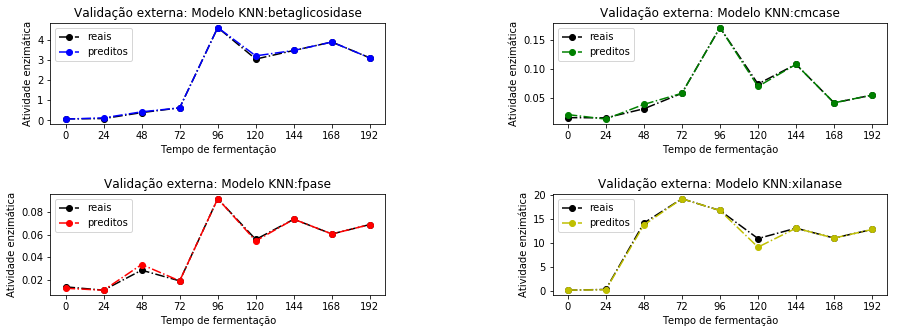

In [166]:
y_teste = treino_teste[3]
graficoTeste(modelo, y_teste, y_p)

### knn: teste com base externa: EETA desnaturado

In [120]:
#@testeExterno
#rodando o knn com os dados de treino 
modelo = 'KNN:'
preproc=8
k=1
gera=97
result = executaKNN(preproc,k, gera)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)

In [182]:
de = dados_back.copy()
de=de[(de['eenz'] == 'eeta')]

In [200]:
de = dados_back.copy()
de=de[(de['experimento'] == 'bioB')&(de['inter']!= 120)]

In [176]:
#buscando base de teste externa
de = dados_back.copy()
de=de[(de['eenz'] == 'eeta')&(de['experimento']=='biod1')&(de['inter']!= 1)&(de['inter']!= 2)&(de['inter']!= 3)&(de['inter']!= 4)&(de['inter']!=20)&(de['inter']!=25)&(de['inter']!=30)]
#Separar somente as amostras que contenham todas as atividades enzimáticas
de = de.loc[(de['betaglicosidase'].notnull()) 
                         & (de['cmcase'].notnull()) 
                         & (de['fpase'].notnull())
                         &(de['xilanase'].notnull())]
de.shape


(12, 713)

In [177]:
de.head(5)

descricao    1100nm    1102nm    1104nm    1106nm    1108nm  \
791  bio_25janp0_1_desn  0.038744  0.038471  0.038295  0.038206  0.038193   
792  bio_25janp0_2_desn  0.038601  0.038637  0.038631  0.038613  0.038621   
793  bio_25janp0_3_desn  0.039642  0.039467  0.039371  0.039322  0.039300   
809  bio_25janp5_1_desn  0.048341  0.046943  0.046041  0.045418  0.044937   
810  bio_25janp5_2_desn  0.048823  0.047629  0.046772  0.046076  0.045451   

       1110nm    1112nm    1114nm    1116nm  ...  cmcase  fpase   xilanase  \
791  0.038237  0.038330  0.038481  0.038710  ...   0.035  0.051  24.094000   
792  0.038688  0.038837  0.039073  0.039391  ...   0.035  0.051  24.094000   
793  0.039299  0.039333  0.039428  0.039612  ...   0.035  0.051  24.094000   
809  0.044537  0.044219  0.044010  0.043935  ...   0.067  0.060  17.361999   
810  0.044883  0.044408  0.044065  0.043873  ...   0.067  0.060  17.361999   

     proteinas  eenz  temp  dur  inter  proc  experimento  
791        NaN  eeta    70   33      0   des        biod1  
792        NaN  eeta    70   33      0   des        biod1  
793        NaN  eeta    70   33      0   des        biod1  
809        NaN  eeta    70   33      5   des        biod1  
810        NaN  eeta    70   33      5   des        biod1  

[5 rows x 713 columns]

In [201]:
#Definindo os dataFrames iniciais para começar o processamento
de_x = de.loc[:,var_abs_txt] #absorbâncias
de_y = de.loc[:,var_ae]#AE
de_inter=pd.DataFrame(de.loc[:,'inter'], columns=['inter'])
#df = dados.loc[:,var_abs_txt+var_ae]

In [197]:
de_x.shape,de_y.shape, de_inter.shape

((21, 244), (21, 4), (21, 1))

In [202]:
#executa pré-processamento equivalente ao do modelo de treinamento
x = executaPreprocSimples(8,de_x)
preditos=reg.predict(x)

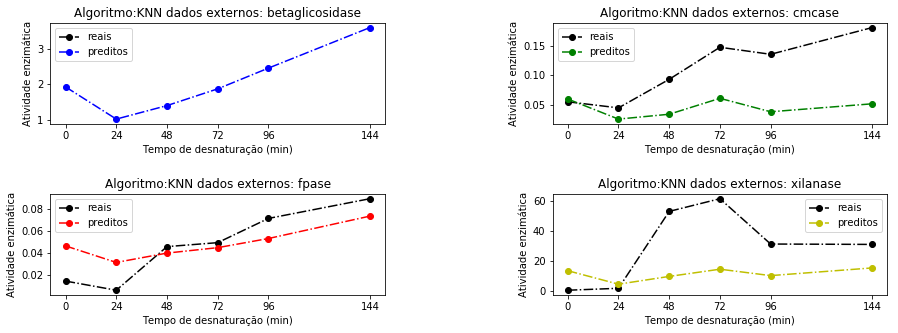

In [203]:
#para exibir o gráfico
#para todas as atividades
#cria um data frame com os valores reais e preditos para os dados de teste
df_pred = {}
for valor in var_ae:
    df_pred[valor] = []
i=0
for valor in var_ae:
    df =pd.DataFrame(columns=['reais','preditos'], index= de_y.index)
    df['reais'] = de_y[valor]
    df['preditos'] = pd.DataFrame(preditos[:,i],index= de_y.index)
    i +=1
    df_pred[valor] = df.copy()
    
df_pred_inter = {}
for valor in var_ae:
    df_pred_inter[valor] = []
for valor in var_ae:
    df_pred_inter[valor] = df_pred[valor].copy()
    df_pred_inter[valor]['inter'] = de_inter.loc[:,'inter']

#ordena valores pelo intervalo
df_ord_teste = {}
for valor in var_ae:
    df_ord_teste[valor] = []
for valor in var_ae:
    df_ord_teste[valor] = df_pred_inter[valor].sort_values(['inter'])

#calculando a média para cada ponto
df_teste_media = {}
for valor in var_ae:
    df_teste_media[valor] = []
for valor in var_ae:
    df_teste_media[valor] = df_ord_teste[valor].groupby('inter').mean()
x = list(df_teste_media['xilanase'].index)
var = ['reais', 'preditos']
tipoAE= ['bo-.', 'go-.','ro-.', 'yo-.']
j = 0    
fig = plt.figure(figsize=(15,5))
plt.subplots_adjust(hspace = 0.7, wspace=0.5)
for valor in var_ae:
    ax = fig.add_subplot(2,2,j+1)
    ax.plot(x,df_teste_media[valor][var[0]], 'ko-.', label=var[0])
    ax.plot(x,df_teste_media[valor][var[1]], tipoAE[j], label=var[1])
    j +=1
    ax.legend(loc=2)
    ax.set_title('Algoritmo:'+modelo+' dados externos'+': '+valor)
    ax.set_xlabel('Tempo de desnaturação (min)')
    ax.set_ylabel('Atividade enzimática') 
    ax.set_xticks(x)
    plt.legend(loc='best')

## GBR: Gradient Boost Regressor


In [258]:
#gbr
#função completa para execução do GBR
def executaGBR(preproc=1, varLoss='ls',n_est=100,IC=0):
    #separando o conjunto de dados em treino e teste
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,False,IC)

    
    reg = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=n_est,
                                                                  learning_rate=0.1,
                                                                  max_depth=2, 
                                                                  random_state=0, loss=varLoss))

   
    #reg=MultiOutputRegressor(xgb.XGBRegressor())
    result = executaCVP([x_treino, x_teste, y_treino, y_teste], reg)
    
    return result


In [259]:
#função completa para execução do GBR com PCA
#A variável preproc determinará o tipo de processamento que será executado (0,1,2,3)
def executaPCA_GBR(preproc, varLoss,nPC=3,n_est=100, IC=0):
    #separando o conjunto de dados em treino e teste
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,False, IC)

    
    reg = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=n_est,
                                                                  learning_rate=0.1,
                                                                  max_depth=8, 
                                                                  random_state=IC, loss=varLoss))  
   

   # Roda o PCA e produz uma vaiável reduzida xRed e seleciona as primeiras componentes definidas pela variável nPc
    pca = PCA(n_components=nPC)
    x_treino = pca.fit_transform(x_treino)[:,:nPC]
    x_teste = pca.fit_transform(x_teste)[:,:nPC] 
    
    result = executaCVP([x_treino, x_teste, y_treino, y_teste], reg)
    
    return result


### GBR testes

In [260]:

warnings.filterwarnings("ignore")
#GBR teste simples
modelo = 'GBR:'
result = executaGBR(preproc=1, varLoss='ls',n_est=100, IC=0)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)
    
for k,v in zip(resultados.keys(),resultados.values()):
    print(k)
    print(v,'\n-----------------------------------------------------')

Parâmetros do modelo: GBR: 
 MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...ate=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
           n_jobs=None)
cal
      betaglicosidase    cmcase    fpase    xilanase
BIAS           0.0000    0.0000  -0.0000     -0.0000
MSE         3221.8279  127.6973  71.3375  22935.6474
R2             0.9776    0.9361   0.8370      0.8533
RER           51.3801   25.4627  19.3228     19.5377
RMSE          56.7611   11.3003   8.4462    151.4452
RPD            6.6853    3.9552   2.4772      2.6112
RPIQ           2.7172    2.6037   2.5215      2.7273
SEP           56.8029   11.3086   8.4524    151.5565 
---------------------------------------

In [262]:

#gbrtestes
#Executa o modelo GBR variando o tipo de processamento  e  o parâmetro loss
loss_valores = ['ls', 'huber']
for k, v in preProc.items():
    print( 'GBR:\n\t'+v)
    for var in loss_valores:
        print('\n>>>>\tLoss:'+var)
        result = executaGBR(k, var)
        #print('Parâmetros do modelo:',modelo,'\n',result[0])

        resultados=exibeResultados(result)

        for k,v in zip(resultados.keys(),resultados.values()):
            print(k)
            print(v,'\n-----------------------------------------------------')

GBR:
	Pré-proc: 0--> Sem pré-processamento

>>>>	Loss:ls


KeyboardInterrupt: 

In [263]:
#gbrtestes - loss = huber
#Executa o modelo GBR variando o tipo de processamento 
for i in [0,1,2,3,4,5,9]:
    print( 'GBR:\n\t'+preProc[i])
    result = executaGBR(k, 'huber')
        

    resultados=exibeResultados(result)

    for k,v in zip(resultados.keys(),resultados.values()):
        print(k)
        print(v,'\n-----------------------------------------------------')

GBR:
	Pré-proc: 0--> Sem pré-processamento


KeyboardInterrupt: 

In [139]:
#teste 2 escolhendo o modelo mais otimizado
#gbrotimizado
maior=[-1,-1,-1,-1]
maiorGerado=[0,0,0,0]
for i in range(100):
    result = executaGBR(10,'ls',n_est=100,IC=i)
    resultados=exibeResultados(result)
    r2 = resultados['pred'].loc[resultados['pred'].index=='R2']
    r = []
    for j in range(4):
        r.append(r2.iloc[:,j][0])
        if r[j]>maior[j]:
            maior[j] = r[j]
            maiorGerado[j]=i
    print('\r%d%% completos'%(i+1), end='')
print('\n','r2:',maior,'\nsemente: b c f x',maiorGerado)

KeyboardInterrupt: 

In [264]:
#gbrtestes -otimizado
modelo= 'GBR:'
result = executaGBR(preproc=1,varLoss = 'ls', n_est=100, IC=0)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)
for k,v in zip(resultados.keys(),resultados.values()):
    print(k)
    print(v,'\n-----------------------------------------------------')

Parâmetros do modelo: GBR: 
 MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...ate=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
           n_jobs=None)
cal
      betaglicosidase    cmcase    fpase    xilanase
BIAS           0.0000    0.0000  -0.0000     -0.0000
MSE         3221.8279  127.6973  71.3375  22935.6474
R2             0.9776    0.9361   0.8370      0.8533
RER           51.3801   25.4627  19.3228     19.5377
RMSE          56.7611   11.3003   8.4462    151.4452
RPD            6.6853    3.9552   2.4772      2.6112
RPIQ           2.7172    2.6037   2.5215      2.7273
SEP           56.8029   11.3086   8.4524    151.5565 
---------------------------------------

In [265]:
resultados['cal']

betaglicosidase    cmcase    fpase    xilanase
BIAS           0.0000    0.0000  -0.0000     -0.0000
MSE         3221.8279  127.6973  71.3375  22935.6474
R2             0.9776    0.9361   0.8370      0.8533
RER           51.3801   25.4627  19.3228     19.5377
RMSE          56.7611   11.3003   8.4462    151.4452
RPD            6.6853    3.9552   2.4772      2.6112
RPIQ           2.7172    2.6037   2.5215      2.7273
SEP           56.8029   11.3086   8.4524    151.5565

In [266]:
resultados['val']

betaglicosidase    cmcase     fpase    xilanase
BIAS           2.0351   -0.0051   -0.2057     -0.7050
MSE        55886.9183  448.0821  216.5627  83123.7582
R2             0.6119    0.7757    0.5053      0.4685
RER           12.3369   13.5931   11.0912     10.2629
RMSE         236.4041   21.1679   14.7161    288.3119
RPD            1.6052    2.1115    1.4218      1.3716
RPIQ           0.6524    1.3900    1.4472      1.4326
SEP          236.5691   21.1835   14.7254    288.5230

In [267]:
resultados['pred']

betaglicosidase    cmcase     fpase    xilanase
BIAS          -6.4010   -0.6958    0.5287     12.3833
MSE        56660.2764  525.4634  221.5214  82976.1239
R2             0.5992    0.7320    0.4691      0.4793
RER           12.2384   12.5397    9.1016      9.4296
RMSE         238.0342   22.9230   14.8836    288.0558
RPD            1.5796    1.9316    1.3725      1.3859
RPIQ           0.5924    1.0030    1.4939      1.8293
SEP          238.4740   22.9631   14.9071    288.4255

In [144]:
reg, treino_teste,y_c,y_cv,y_p = result

### Reais x preditos

In [145]:
#knn reaisxpreditos
#calibração
pred=pd.DataFrame(y_c, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('CALIBRAÇÃO:\n')
round(reais_pred,4)

CALIBRAÇÃO:



betaglicosidase    cmcase     fpase   xilanase  pred: betaglicosidase  \
0            64.0786   77.4722   17.6446   330.8339                63.8562   
1           299.9215   60.1578   20.9152   119.5415               319.3051   
2           141.3745   64.6455   18.7057   303.7711               122.1316   
3          2431.6260  263.4420  128.2720  2585.4951              1988.3047   
4           834.4946   61.9396   29.1738   235.8352               668.2940   
5           112.8821   73.2487   17.8592   387.4296               105.7952   
6           143.3068  109.3426   33.5792   863.4196               178.4295   
7           225.4068  103.6390   29.3921   387.2623               219.4308   
8           106.1714   76.0080   22.7550   276.9686                89.6420   
9           262.2230   92.4294   32.9734   688.6235               229.4873   
10            0.3900    0.0315    0.0283    14.1777                31.7660   
11          540.5795   61.7416   21.3253   151.4961               365.1412   
12          130.1374   79.6872   27.5573   304.6450               110.3663   
13         2397.5010  251.6900  112.6160  1901.4399              1722.1865   
14          241.6059  104.7929   36.2992   851.6944               183.6441   
15           93.1868   68.5254   13.3691   154.9180               109.6602   
16          282.1037   90.7727   22.5180   465.5131               200.5565   
17            6.0774   68.3866    8.1214   169.9336                93.8325   
18          201.1082   98.0342   28.7162   587.8371               208.6775   
19            9.0731   70.9405   16.7034   331.0199                81.5506   
20          146.9412  126.6599   57.7806   748.7001                82.8049   
21           59.8397   56.4023   10.0402   353.3169                90.1862   
22          104.7843   81.0869   39.9086   719.8960               112.9071   
23          380.0074   79.7861   40.9537   410.5377               417.2857   
24          237.1880  105.6089   42.4315   916.3074               178.4295   
25          559.8001   89.9679   21.5516   138.4000               481.2928   
26           24.8756   56.7357   11.4848   359.5063                75.7835   
27           84.2733   77.4659   11.0090   115.7702               100.2483   
28          120.8300   62.7409   11.9786   271.2614               120.8547   
29          104.7843   83.7566   28.0903   453.0993                86.4776   
..               ...       ...       ...        ...                    ...   
662         242.2597   57.6123   17.9879   129.2327               274.2395   
663         248.6120  158.4460   69.6480   905.4550               236.5198   
664           7.6554   61.8889   14.9137   196.3804                65.7399   
665         158.8768  103.2324   39.2466   524.5162               107.2917   
666         273.5800  162.1220   69.8540   962.5400               308.0183   
667         122.1230   96.9230   25.5450   376.6580               160.1705   
668         189.1429  101.0838   20.7583   333.5429               215.4055   
669         227.8442   57.3295   17.2667   120.8511               232.8186   
670         136.2851  112.3726   26.5009   313.8180                74.9171   
671         129.4330  114.8104   37.3938   671.3381               102.4644   
672          74.3874   52.1437   13.4200   120.8112               110.5554   
673         122.4796   73.2081   25.0869   304.7825               119.8425   
674         121.8905   80.5562   14.8344   367.7344                97.5841   
675          41.8395   70.4412   10.0650   170.7917                90.6681   
676          42.5092   60.4743   15.4377   338.4625                89.5117   
677         274.2940   78.7396   19.7839   142.5907               264.0788   
678          41.8395   70.4412   10.0650   170.7917                90.6681   
679           3.1080    0.0410    0.0590    20.1730                85.6333   
680           2.1150    0.0730    0.0505    18.4127                34.1125   
681          90.8381   81.0

In [146]:
#validação
pred=pd.DataFrame(y_cv, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('VALIDAÇÃO CRUZADA:\n')
round(reais_pred,4)


VALIDAÇÃO CRUZADA:



betaglicosidase    cmcase     fpase   xilanase  pred: betaglicosidase  \
0            64.0786   77.4722   17.6446   330.8339                46.5251   
1           299.9215   60.1578   20.9152   119.5415               439.3677   
2           141.3745   64.6455   18.7057   303.7711               119.9741   
3          2431.6260  263.4420  128.2720  2585.4951              1502.4728   
4           834.4946   61.9396   29.1738   235.8352               607.8604   
5           112.8821   73.2487   17.8592   387.4296                86.2786   
6           143.3068  109.3426   33.5792   863.4196               173.1429   
7           225.4068  103.6390   29.3921   387.2623               283.6908   
8           106.1714   76.0080   22.7550   276.9686                90.7792   
9           262.2230   92.4294   32.9734   688.6235               215.5520   
10            0.3900    0.0315    0.0283    14.1777                25.5228   
11          540.5795   61.7416   21.3253   151.4961               238.8561   
12          130.1374   79.6872   27.5573   304.6450               107.5119   
13         2397.5010  251.6900  112.6160  1901.4399              1605.1740   
14          241.6059  104.7929   36.2992   851.6944               156.2611   
15           93.1868   68.5254   13.3691   154.9180               122.3166   
16          282.1037   90.7727   22.5180   465.5131               198.6768   
17            6.0774   68.3866    8.1214   169.9336                96.6250   
18          201.1082   98.0342   28.7162   587.8371               211.7355   
19            9.0731   70.9405   16.7034   331.0199                80.3141   
20          146.9412  126.6599   57.7806   748.7001                79.9044   
21           59.8397   56.4023   10.0402   353.3169               100.9567   
22          104.7843   81.0869   39.9086   719.8960               114.1440   
23          380.0074   79.7861   40.9537   410.5377               472.3910   
24          237.1880  105.6089   42.4315   916.3074               173.1429   
25          559.8001   89.9679   21.5516   138.4000               436.3096   
26           24.8756   56.7357   11.4848   359.5063                95.3289   
27           84.2733   77.4659   11.0090   115.7702               102.9631   
28          120.8300   62.7409   11.9786   271.2614               123.9194   
29          104.7843   83.7566   28.0903   453.0993                86.9825   
..               ...       ...       ...        ...                    ...   
662         242.2597   57.6123   17.9879   129.2327               308.9026   
663         248.6120  158.4460   69.6480   905.4550               258.5620   
664           7.6554   61.8889   14.9137   196.3804                61.0402   
665         158.8768  103.2324   39.2466   524.5162               109.6379   
666         273.5800  162.1220   69.8540   962.5400               468.5196   
667         122.1230   96.9230   25.5450   376.6580               160.7579   
668         189.1429  101.0838   20.7583   333.5429               208.5788   
669         227.8442   57.3295   17.2667   120.8511               231.8587   
670         136.2851  112.3726   26.5009   313.8180                56.7190   
671         129.4330  114.8104   37.3938   671.3381                88.5690   
672          74.3874   52.1437   13.4200   120.8112               113.9257   
673         122.4796   73.2081   25.0869   304.7825               119.7628   
674         121.8905   80.5562   14.8344   367.7344                91.7797   
675          41.8395   70.4412   10.0650   170.7917                91.6386   
676          42.5092   60.4743   15.4377   338.4625               101.3030   
677         274.2940   78.7396   19.7839   142.5907               288.1979   
678          41.8395   70.4412   10.0650   170.7917                93.0751   
679           3.1080    0.0410    0.0590    20.1730                66.4414   
680           2.1150    0.0730    0.0505    18.4127                27.2266   
681          90.8381   81.0

In [147]:
#predição
pred=pd.DataFrame(y_p, columns=var_ae)
reais = treino_teste[3]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('Predição (validação externa):\n')
round(reais_pred,4)

Predição (validação externa):



betaglicosidase    cmcase    fpase   xilanase  pred: betaglicosidase  \
0             2.5282   77.6603   6.2611   249.1409               114.0143   
1           123.0794   77.4893  36.4128   564.8606               121.4514   
2           123.1544   75.0638  37.5767   735.9341               112.9071   
3             0.1724    0.0112   0.0121     0.0924               134.7418   
4            94.1372   77.0335  36.1238   667.2302                85.6785   
5           207.6430   70.1092  21.1828   328.3872               170.1305   
6             3.1068    0.0781   0.0545    11.0526                 4.3024   
7           403.6327   78.0608  44.4042   421.8004               478.1427   
8           196.6902  105.5594  37.1234   861.1743               183.3206   
9           336.7610   67.4547  22.4708   150.7103               491.9136   
10            4.4081   66.5170   5.8076   125.4231                95.2620   
11          145.8733   65.4350  15.2831   314.6077               125.1501   
12          150.8708   98.4659  29.4593   480.9710                95.6544   
13          130.8023   67.3478  14.2291   203.0631               119.8425   
14          247.1283   89.7259  36.2332   858.6796               202.1117   
15           84.0149   72.7848  22.2422   312.6571               112.9071   
16           83.2171   97.5299  22.7053   378.6273                90.3903   
17            0.4280    0.0390   0.0334    13.7624                27.2035   
18          103.2472   84.4077  36.0221   760.4248                85.3625   
19           23.7272   72.8568  14.8860   376.9820                93.4452   
20           94.7370   77.3428  38.3458   759.9913                83.7552   
21          216.9391   70.1092  17.6056   204.3168               135.7782   
22          158.5821   77.3812  31.1380   832.2265               110.7815   
23            0.1724    0.0112   0.0121     0.0924               107.3293   
24          101.1853   88.2820  41.7562   693.8882               110.5554   
25          564.6053   89.1760  21.4809   115.6127               493.3790   
26          221.1730   85.8026  37.0534   742.9250               205.0282   
27           76.8184   77.5492  12.0919   199.7503               110.3663   
28           75.8015   57.7596  13.1040   358.1227               119.2687   
29           94.1372   77.0335  36.1238   667.2302                88.0470   
..               ...       ...      ...        ...                    ...   
201         157.2001   93.1450  34.1543   873.2218               139.4446   
202           3.5967    0.1065   0.0850    13.6476                 9.2701   
203          75.8015   57.7596  13.1040   358.1227                94.1457   
204         170.5508   67.7024  17.7869   225.9377               239.8382   
205         110.7698   73.6902  15.4099   392.2006                90.7272   
206          89.0385   88.7053  29.7711   546.5106                89.6420   
207          93.1868   68.5254  13.3691   154.9180               109.7594   
208         125.4592  100.4836  22.0968   456.5170               118.9053   
209         134.6370  110.4720  18.4920   289.2540               649.1936   
210          24.8756   56.7357  11.4848   359.5063               119.1524   
211         101.7851   97.7236  41.4957   714.6944                91.2984   
212         100.4355   87.3867  22.3969   359.6879                80.3458   
213          46.3527   65.4908  14.4415   370.6471                77.8568   
214         258.9095   87.7807  33.3814   744.8376               217.6627   
215           6.0774   68.3866   8.1214   169.9336               114.3114   
216           4.5365   73.4298  16.9195   307.4022                83.7852   
217        1855.8680  201.0750  90.3270  1917.3610              1929.9526   
218         128.0820   66.3220  14.0280   188.1860               466.1378   
219           0.3828    0.0405   0.0301    12.4461                59.9598   
220         110.4872   97.6145  30.0285   419.8360               145.9192   
2

###  GBR: Gráficos de resíduos - histograma - reais x preditos

In [215]:
#título para os gráficos
modelo = 'GBR'

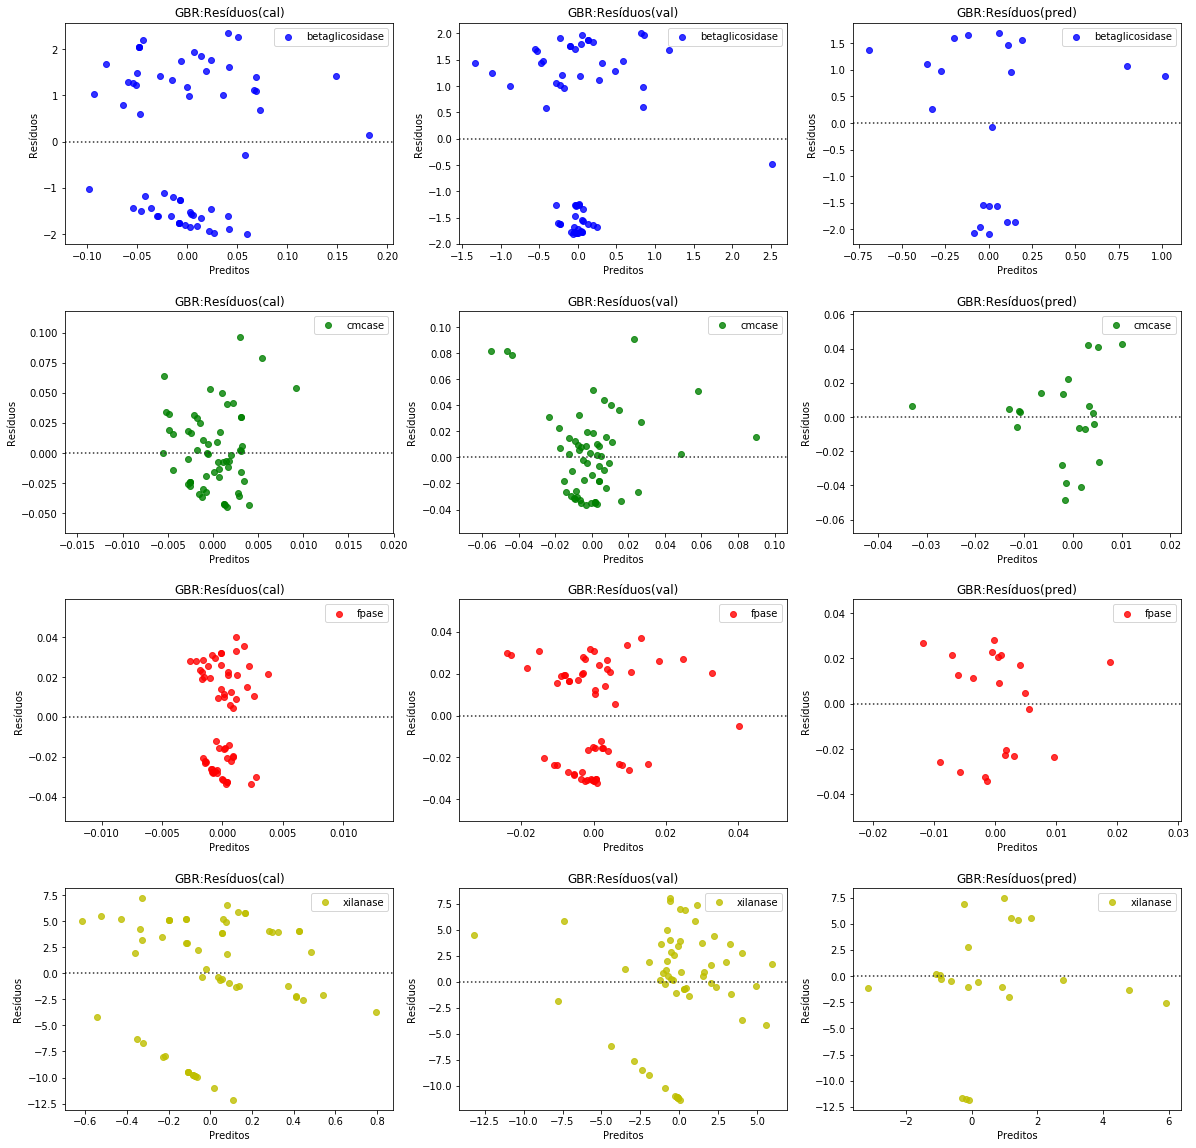

In [216]:
#gráfico dos resíduos
#@gbrgraf
graficoResiduos(modelo, treino_teste, y_c,y_cv,y_p)

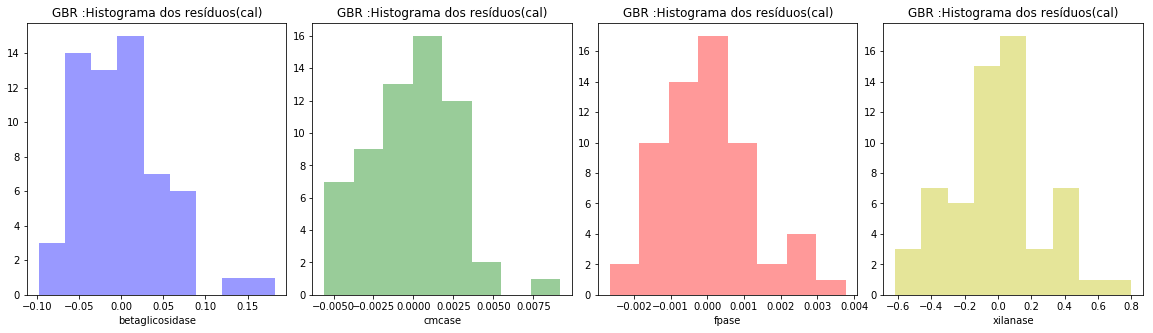

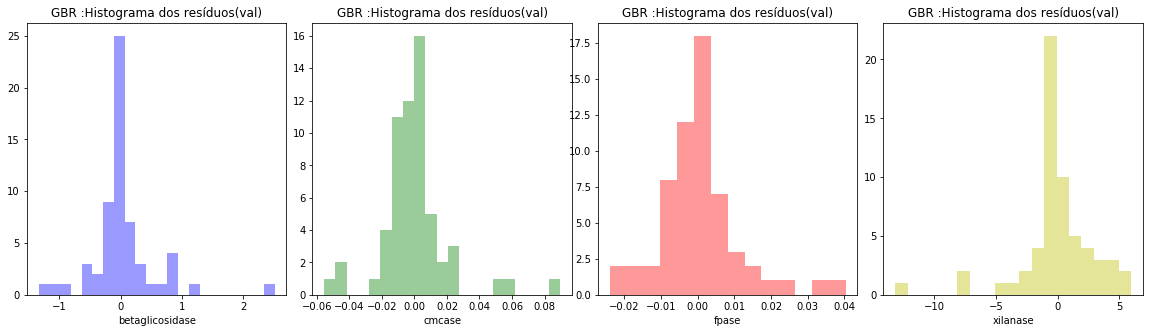

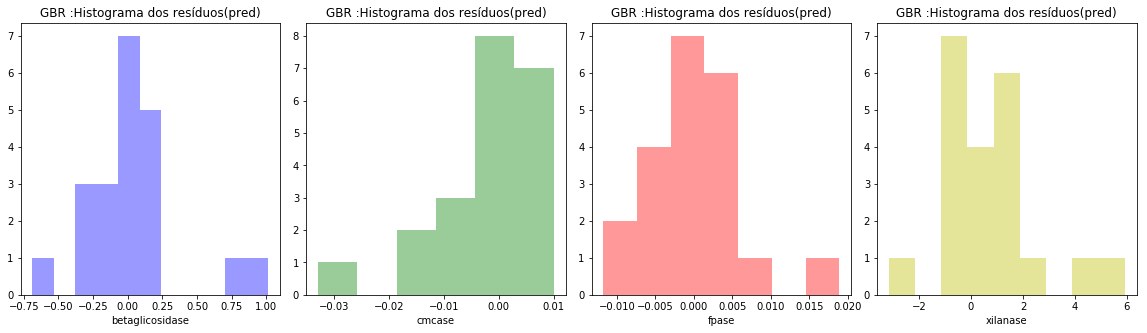

In [217]:
#histograma dos resíduos
graficoHist(modelo, treino_teste, y_c,y_cv,y_p)

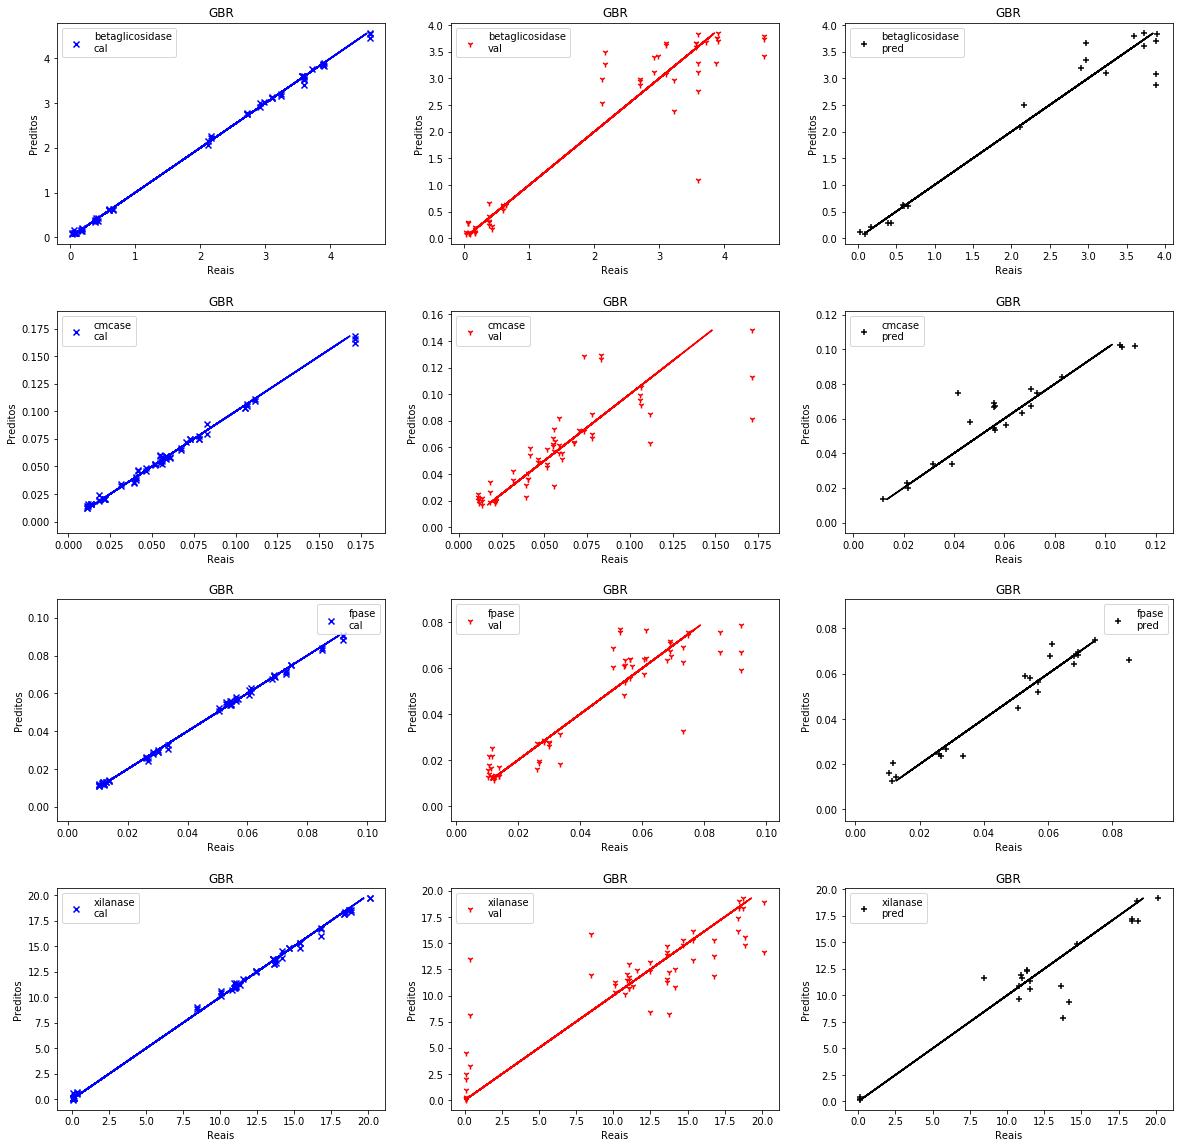

In [218]:
#graico de reais x preditos
graficoReaisPreditosSep(modelo, treino_teste, y_c,y_cv,y_p)

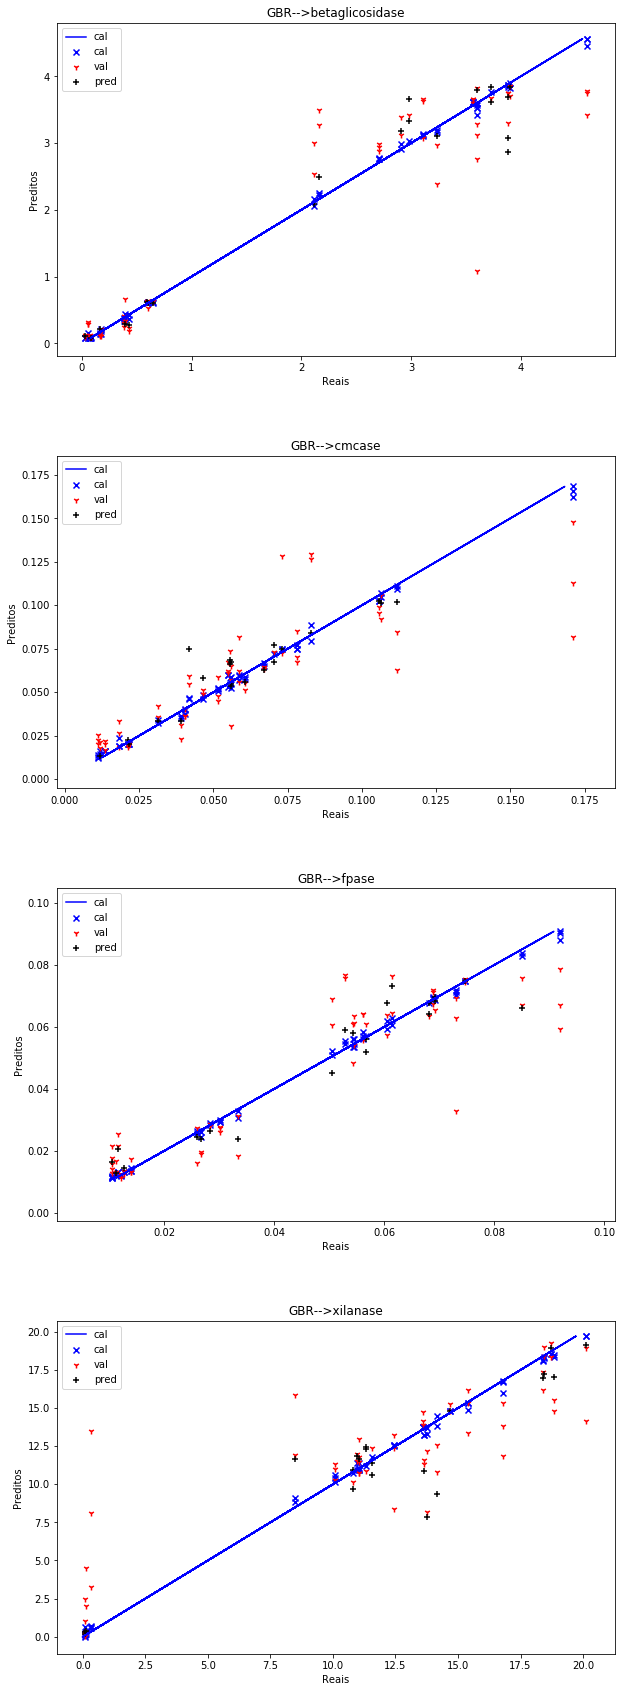

In [219]:
#graico de reais x preditos conjuntamente
graficoReaisPreditos(modelo, treino_teste, y_c,y_cv,y_p)

## PLS

### PLS: função completa

In [268]:
#pls
#função completa para execução do PLS:
#A variável preproc determinará o tipo de processamento que será executado (0,1,2,3,4)
def executaPLS(preproc,IC=0):
    #separando o conjunto de dados em treino e teste
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,False,IC)
  
   
    #Calcula o número de componentes ideal para o PLS
    mse = []
    component = np.arange(1, 20)
    for i in component:
        pls = PLSRegression(n_components=i)
        # Fit
        pls.fit(x_treino, y_treino)
        # Prediction
        Y_pred = pls.predict(x_teste)

        mse_p = mean_squared_error(y_teste, Y_pred)
        mse.append(mse_p)

        comp = 100*(i+1)/20
        # Truque para atualizar o progresso do processamento na mesma linha
        print("\r%d%% completed " % comp, end='')

    # Calcula e imprime a posição do menor valor de MSE
    msemin = np.argmin(mse)
    print("Sugestão para o número de variáveis latentes: ", msemin+1)

 
    with plt.style.context(('ggplot')):
        plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
        plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
        plt.xlabel('Numero de componentes para o PLS')
        plt.ylabel('MSE')
        plt.title('PLS')
        plt.xlim(xmin=-1)

        plt.show()   

    # Roda o PLS e produz uma vaiável reduzida xRed e seleciona as primeiras componentes definidas pela variável nPc
    pls = PLSRegression(n_components=msemin+1)
        
    result = executaCVP([x_treino, x_teste, y_treino, y_teste], pls)
    
    dic = {'result':result,'min':msemin+1}
    return dic

    

In [269]:
#função completa para execução do PLS:
#A variável preproc determinará o tipo de processamento que será executado (0,1,2,3,4)
def executaPLSResumida(preproc=1, nPC=3, padroniza=False, max=500,IC=0):
    #separando o conjunto de dados em treino e teste
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,padroniza,IC)
  
   
    #Calcula o número de componentes ideal para o PLS
    component = nPC
   
    # Roda o PLS e produz uma vaiável reduzida xRed e seleciona as primeiras componentes definidas pela variável nPc
    pls = PLSRegression(n_components=nPC, max_iter=max)
        
    result = executaCVP([x_treino, x_teste, y_treino, y_teste], pls)
    
    return result

### PLS: testes

In [270]:
preK = list(preProc.keys())
preV = list(preProc.values())

Pré-proc: 0--> Sem pré-processamento
100% completed Sugestão para o número de variáveis latentes:  12


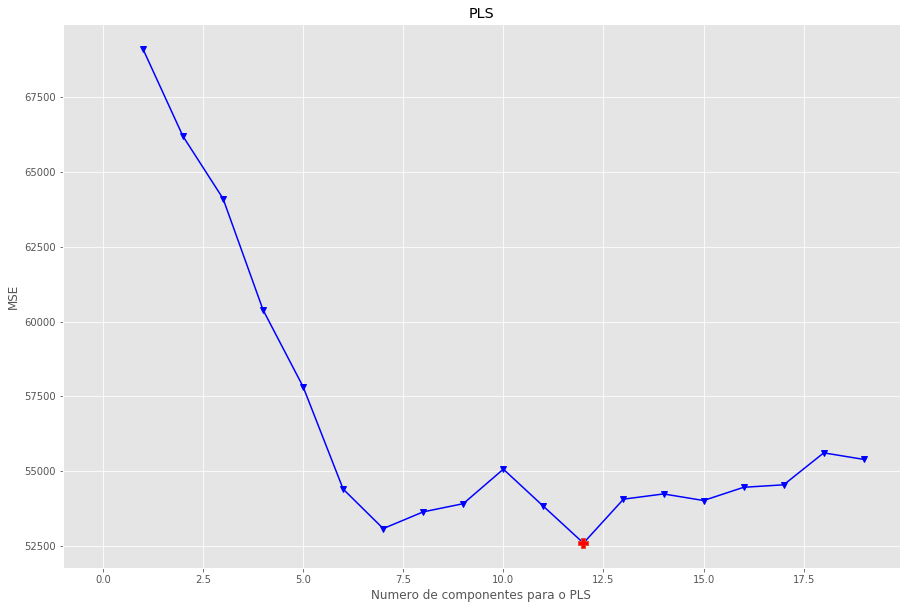

Pré-proc: 1--> Padronização
100% completed Sugestão para o número de variáveis latentes:  12


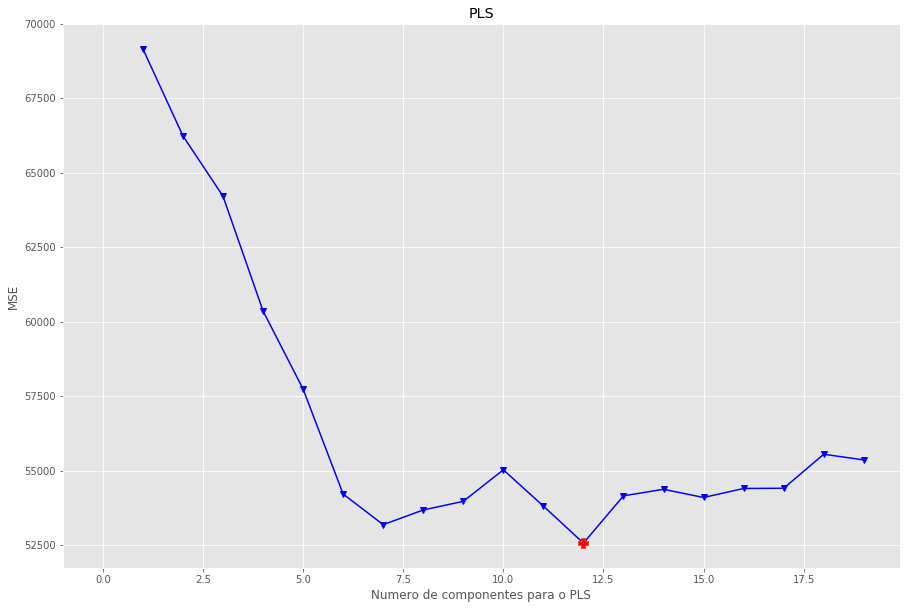

Pré-proc: 2--> Suavização(SavGol) - Par:3,1,1
100% completed Sugestão para o número de variáveis latentes:  5


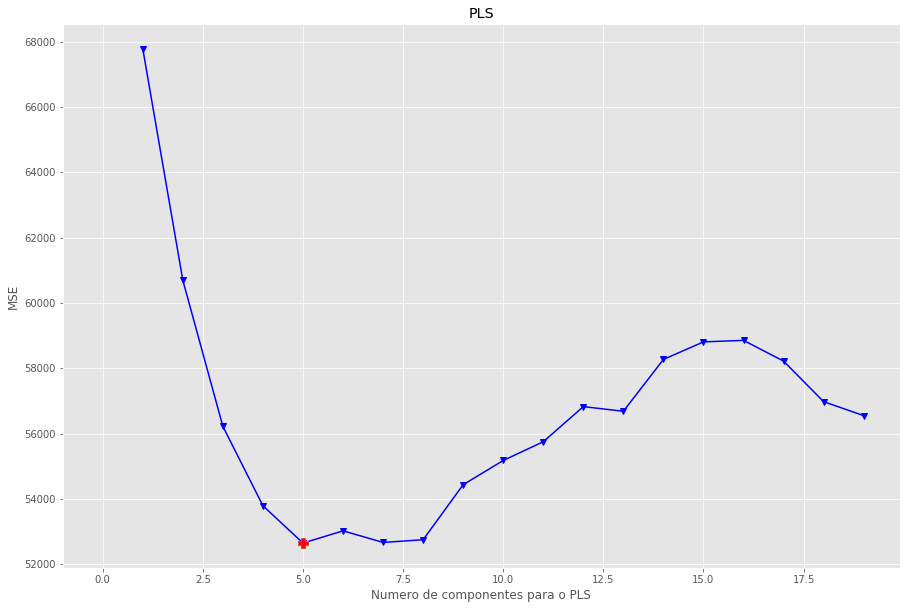

Pré-proc: 3--> Suavização(SavGol) - Par:3,2,1
100% completed Sugestão para o número de variáveis latentes:  5


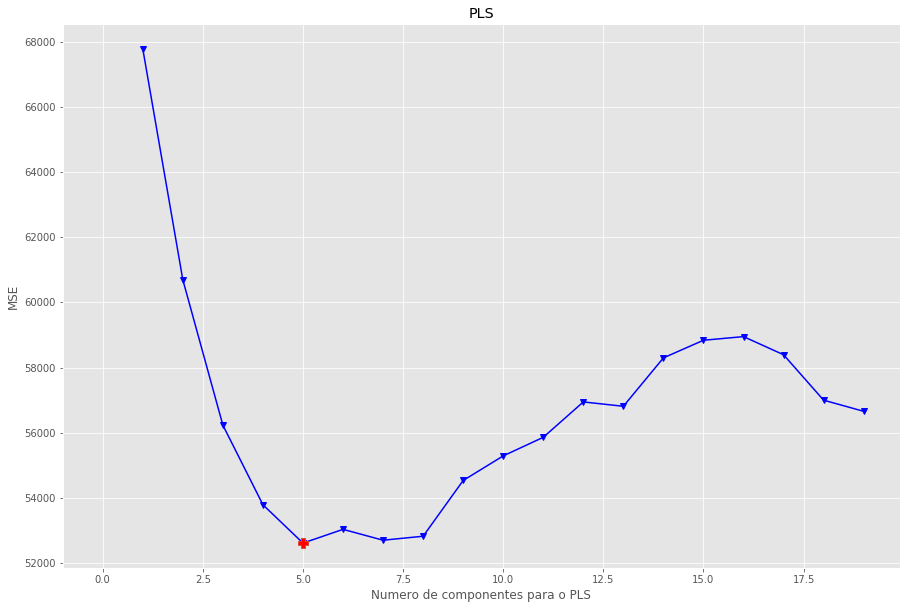

Pré-proc: 4--> Suavização(SavGol) - Par:5,1,1
100% completed Sugestão para o número de variáveis latentes:  7


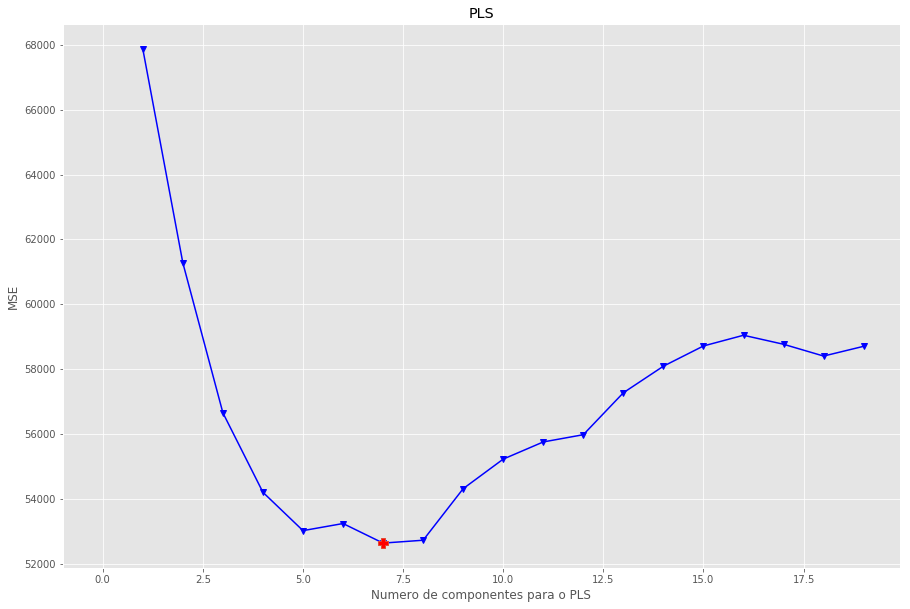

Pré-proc: 5--> Suavização(SavGol) - Par:5,2,1
100% completed Sugestão para o número de variáveis latentes:  7


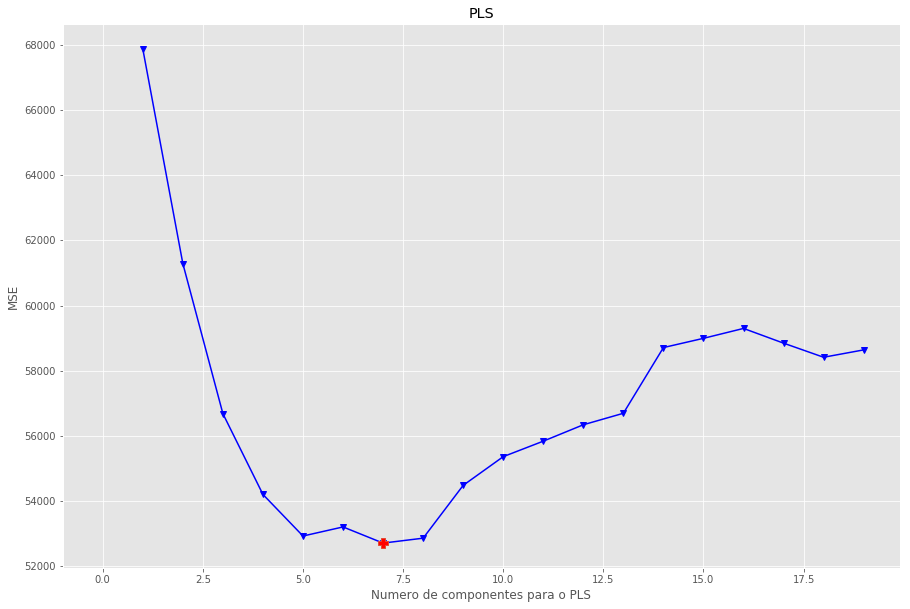

Pré-proc: 6--> Suavização(SavGol) - Par:3,2,2
100% completed Sugestão para o número de variáveis latentes:  5


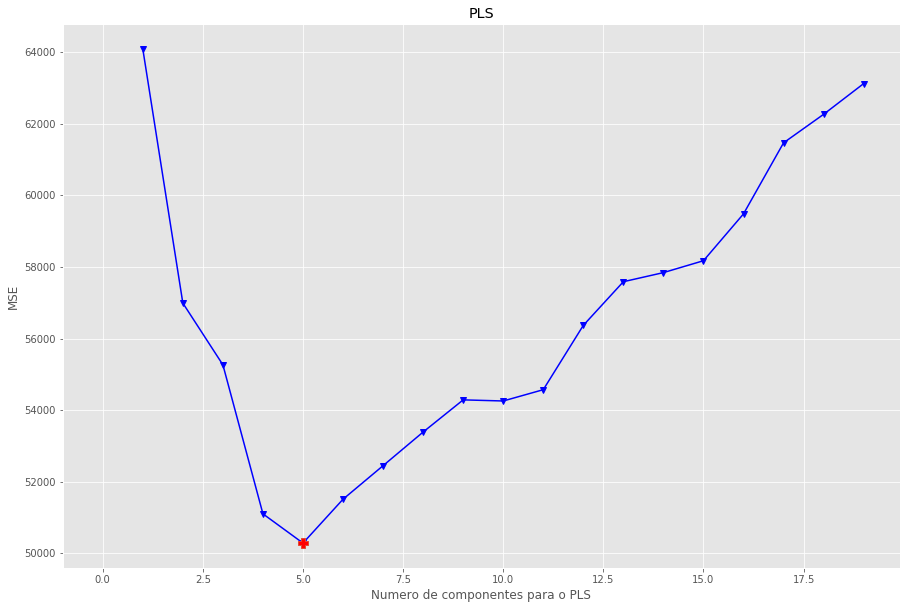

Pré-proc: 7--> Suavização(SavGol) - Par:5,2,2
100% completed Sugestão para o número de variáveis latentes:  5


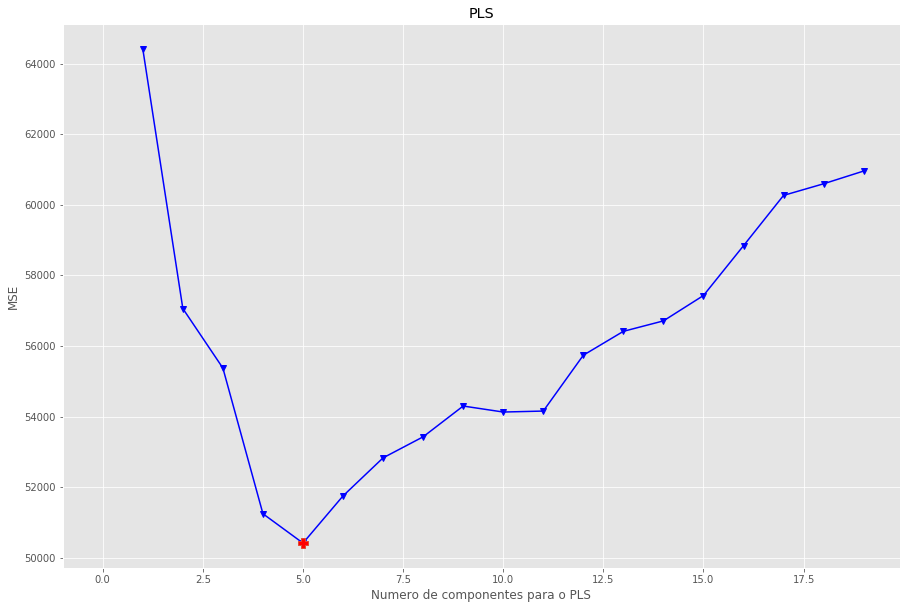

Pré-proc: 8--> Suavização(SavGol) - Par:3,1,1 --> Padronização
100% completed Sugestão para o número de variáveis latentes:  5


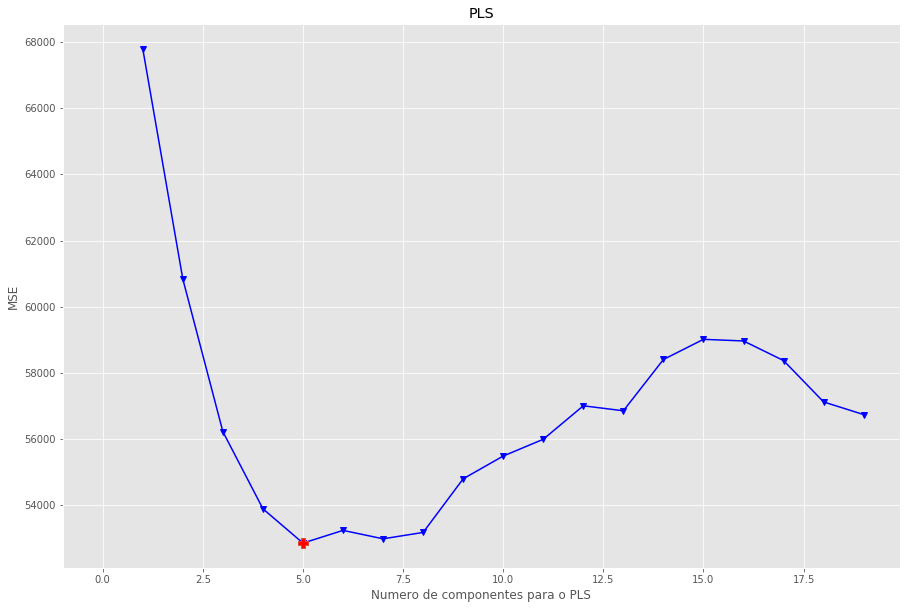

Pré-proc: 9--> Padronização --> Suavização(SavGol) - Par:3,1,1
100% completed Sugestão para o número de variáveis latentes:  6


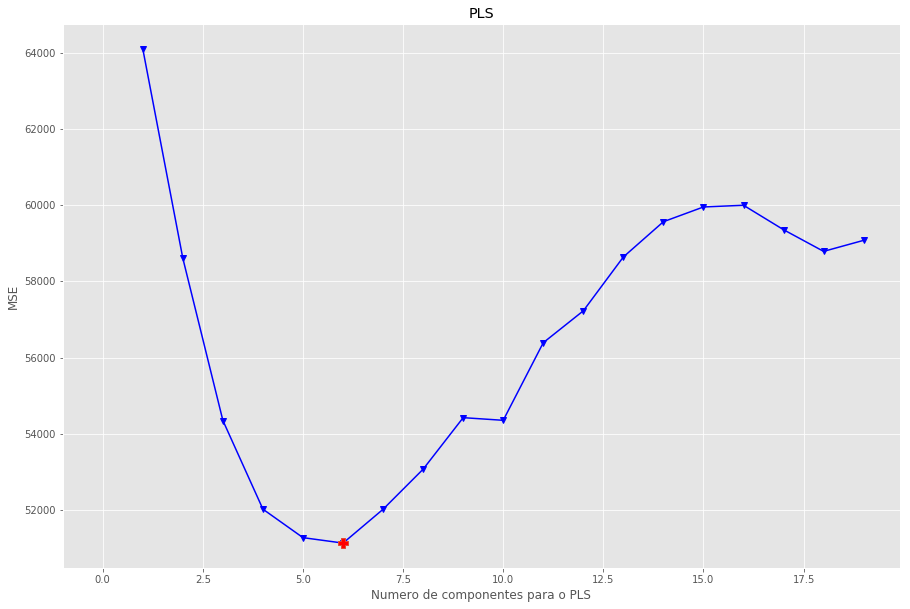

Pré-proc: 10--> MSC
100% completed Sugestão para o número de variáveis latentes:  8


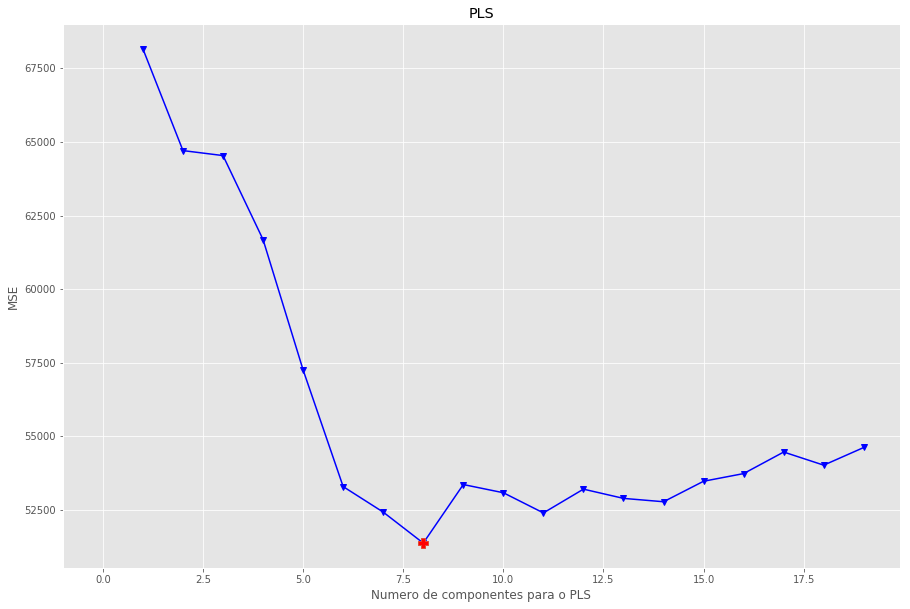

Pré-proc: 11--> SNV
100% completed Sugestão para o número de variáveis latentes:  8


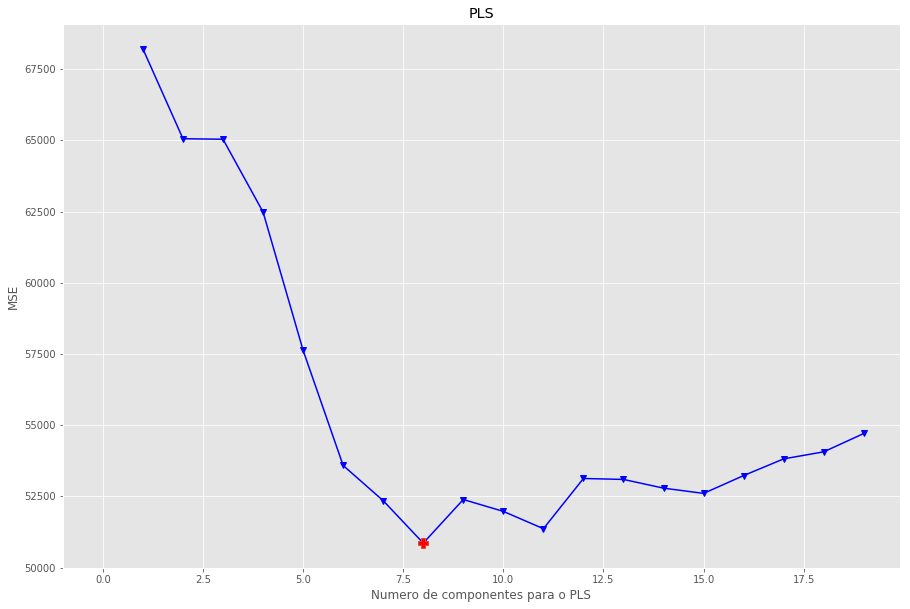

In [271]:
nVL = []
for k in preK:
    print(preProc[k])
    dic = executaPLS(k)
    nVL.append(dic['min'])

In [272]:
#pls teste simples
modelo = 'PLS'
for k in range(12):
    print(preProc[k])
    for i in range(4,9):
        print('Variáveis latentes: ',i)
        result = executaPLSResumida(k,nPC=i)
        print('Parâmetros do modelo:',modelo,'\n',result[0])

        resultados=exibeResultados(result)

        for k,v in zip(resultados.keys(),resultados.values()):
            print(k)
            print(v,'\n-----------------------------------------------------')



Pré-proc: 0--> Sem pré-processamento
Variáveis latentes:  4
Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=4, scale=True, tol=1e-06)
cal
      betaglicosidase     cmcase     fpase     xilanase
BIAS          -0.0000    -0.0000   -0.0000      -0.0000
MSE        96177.8966  1526.4550  364.4556  132606.6729
R2             0.3321     0.2359    0.1675       0.1520
RER            9.4039     7.3647    8.5488       8.1254
RMSE         310.1256    39.0699   19.0907     364.1520
RPD            1.2236     1.1440    1.0960       1.0860
RPIQ           0.4973     0.7531    1.1156       1.1342
SEP          310.3536    39.0986   19.1048     364.4197 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS          -0.3589     0.1741   -0.0261      -0.2106
MSE       104295.4811  1588.0921  386.9638  139171.8311
R2             0.2757     0.2050    0.1161       0.1101
RER            9.0305     7.2204    8.2965 

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=4, scale=True, tol=1e-06)
cal
      betaglicosidase     cmcase     fpase     xilanase
BIAS          -0.0000     0.0000   -0.0000       0.0000
MSE        96177.8966  1526.4550  364.4556  132606.6729
R2             0.3321     0.2359    0.1675       0.1520
RER            9.4039     7.3647    8.5488       8.1254
RMSE         310.1256    39.0699   19.0907     364.1520
RPD            1.2236     1.1440    1.0960       1.0860
RPIQ           0.4973     0.7531    1.1156       1.1342
SEP          310.3536    39.0986   19.1048     364.4197 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS          -0.3589     0.1741   -0.0261      -0.2106
MSE       104295.4811  1588.0921  386.9638  139171.8311
R2             0.2757     0.2050    0.1161       0.1101
RER            9.0305     7.2204    8.2965       7.9315
RMSE         322.9481    39.8509   19.6714     

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=4, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.0000    0.0000    0.0000      0.0000
MSE        77181.3630  776.9912  265.2264  96717.7670
R2             0.4640    0.6111    0.3942      0.3815
RER           10.4976   10.3226   10.0212      9.5143
RMSE         277.8153   27.8746   16.2858    310.9948
RPD            1.3659    1.6035    1.2847      1.2716
RPIQ           0.5552    1.0555    1.3077      1.3281
SEP          278.0195   27.8950   16.2977    311.2234 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           0.3547    0.0332   -0.0111      -0.4309
MSE        90856.3584  935.7670  312.3609  112828.7924
R2             0.3690    0.5316    0.2865       0.2785
RER            9.6754    9.4062    9.2342       8.8089
RMSE         301.4239   30.5903   17.6737     335.9000
RPD            

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=4, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.0000    0.0000    0.0000      0.0000
MSE        77148.4801  775.7953  265.1357  96708.1400
R2             0.4642    0.6117    0.3944      0.3816
RER           10.4998   10.3305   10.0229      9.5148
RMSE         277.7562   27.8531   16.2830    310.9793
RPD            1.3662    1.6047    1.2850      1.2716
RPIQ           0.5553    1.0564    1.3079      1.3282
SEP          277.9603   27.8736   16.2950    311.2079 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           0.3423    0.0301   -0.0122      -0.4557
MSE        90845.2684  934.8994  312.3649  112856.0250
R2             0.3691    0.5320    0.2865       0.2783
RER            9.6760    9.4105    9.2342       8.8078
RMSE         301.4055   30.5761   17.6738     335.9405
RPD            

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=4, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.0000    0.0000    0.0000      0.0000
MSE        78771.3581  805.1377  269.4147  97473.7059
R2             0.4530    0.5970    0.3846      0.3767
RER           10.3911   10.1405    9.9430      9.4773
RMSE         280.6624   28.3749   16.4139    312.2078
RPD            1.3520    1.5752    1.2747      1.2666
RPIQ           0.5495    1.0369    1.2975      1.3229
SEP          280.8686   28.3958   16.4259    312.4373 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           0.4337    0.0484   -0.0054      -0.3039
MSE        92203.1391  962.9238  315.8805  113391.5997
R2             0.3597    0.5180    0.2784       0.2749
RER            9.6045    9.2726    9.1826       8.7870
RMSE         303.6497   31.0310   17.7730     336.7367
RPD            

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=4, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          -0.0000   -0.0000   -0.0000     -0.0000
MSE        78716.2249  804.5516  269.2225  97455.0044
R2             0.4533    0.5973    0.3850      0.3768
RER           10.3947   10.1442    9.9466      9.4782
RMSE         280.5641   28.3646   16.4080    312.1778
RPD            1.3525    1.5758    1.2752      1.2668
RPIQ           0.5497    1.0373    1.2980      1.3231
SEP          280.7703   28.3855   16.4201    312.4073 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           0.3719    0.0385   -0.0096      -0.3879
MSE        92214.7834  963.4315  315.9452  113461.0208
R2             0.3596    0.5177    0.2783       0.2745
RER            9.6039    9.2701    9.1817       8.7843
RMSE         303.6689   31.0392   17.7748     336.8398
RPD            

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=4, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          -0.0000   -0.0000   -0.0000     -0.0000
MSE        71381.3454  648.5783  249.2544  87777.7178
R2             0.5043    0.6753    0.4306      0.4387
RER           10.9158   11.2983   10.3373      9.9871
RMSE         267.1729   25.4672   15.7878    296.2730
RPD            1.4203    1.7550    1.3253      1.3348
RPIQ           0.5773    1.1553    1.3490      1.3941
SEP          267.3693   25.4859   15.7994    296.4908 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           1.2992    0.0816    0.0246       0.1155
MSE        86592.6621  815.5978  303.4902  110805.2640
R2             0.3986    0.5917    0.3067       0.2915
RER            9.9108   10.0753    9.3682       8.8889
RMSE         294.2663   28.5587   17.4210     332.8742
RPD            

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=4, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.0000    0.0000    0.0000     -0.0000
MSE        72120.0349  667.4130  252.3023  89109.7373
R2             0.4991    0.6659    0.4237      0.4302
RER           10.8597   11.1378   10.2747      9.9121
RMSE         268.5517   25.8343   15.8840    298.5125
RPD            1.4130    1.7301    1.3172      1.3247
RPIQ           0.5743    1.1389    1.3408      1.3836
SEP          268.7491   25.8533   15.8957    298.7320 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           1.2259    0.0827    0.0231       0.1464
MSE        87001.1198  832.4536  305.0512  111496.0797
R2             0.3958    0.5833    0.3032       0.2870
RER            9.8875    9.9728    9.3442       8.8614
RMSE         294.9595   28.8523   17.4657     333.9103
RPD            

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=4, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.0000    0.0000   -0.0000      0.0000
MSE        77181.3630  776.9912  265.2264  96717.7670
R2             0.4640    0.6111    0.3942      0.3815
RER           10.4976   10.3226   10.0212      9.5143
RMSE         277.8153   27.8746   16.2858    310.9948
RPD            1.3659    1.6035    1.2847      1.2716
RPIQ           0.5552    1.0555    1.3077      1.3281
SEP          278.0195   27.8950   16.2977    311.2234 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           0.3547    0.0332   -0.0111      -0.4309
MSE        90856.3584  935.7670  312.3609  112828.7924
R2             0.3690    0.5316    0.2865       0.2785
RER            9.6754    9.4062    9.2342       8.8089
RMSE         301.4239   30.5903   17.6737     335.9000
RPD            

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=4, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          -0.0000    0.0000   -0.0000      0.0000
MSE        77539.4942  808.7816  265.9668  95929.5385
R2             0.4615    0.5951    0.3925      0.3866
RER           10.4733   10.1177   10.0072      9.5533
RMSE         278.4591   28.4391   16.3085    309.7249
RPD            1.3627    1.5716    1.2830      1.2768
RPIQ           0.5539    1.0346    1.3059      1.3335
SEP          278.6638   28.4600   16.3205    309.9526 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           0.4744    0.0101   -0.0126      -0.4193
MSE        90172.6823  950.5191  308.8109  110352.9969
R2             0.3738    0.5242    0.2946       0.2943
RER            9.7120    9.3329    9.2871       8.9071
RMSE         300.2877   30.8305   17.5730     332.1942
RPD            

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=4, scale=True, tol=1e-06)
cal
      betaglicosidase     cmcase     fpase     xilanase
BIAS           0.0000    -0.0000    0.0000      -0.0000
MSE       111780.4467  1388.4555  378.0496  130512.6833
R2             0.2237     0.3050    0.1364       0.1654
RER            8.7229     7.7220    8.3937       8.1904
RMSE         334.3358    37.2620   19.4435     361.2654
RPD            1.1350     1.1995    1.0761       1.0946
RPIQ           0.4613     0.7896    1.0953       1.1433
SEP          334.5816    37.2894   19.4578     361.5309 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS           1.7224     0.0534    0.0156      -0.2979
MSE       113144.5261  1452.2805  390.4446  136703.2810
R2             0.2142     0.2730    0.1081       0.1258
RER            8.6703     7.5504    8.2594       8.0028
RMSE         336.3696    38.1088   19.7597     

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=4, scale=True, tol=1e-06)
cal
      betaglicosidase     cmcase     fpase     xilanase
BIAS           0.0000    -0.0000   -0.0000      -0.0000
MSE       113229.5329  1445.7626  385.3429  132110.2865
R2             0.2137     0.2763    0.1198       0.1552
RER            8.6669     7.5674    8.3139       8.1407
RMSE         336.4960    38.0232   19.6302     363.4698
RPD            1.1277     1.1755    1.0659       1.0880
RPIQ           0.4583     0.7738    1.0849       1.1364
SEP          336.7433    38.0511   19.6446     363.7369 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS           2.3966     0.2646    0.0877       1.1160
MSE       115021.5998  1481.8037  392.7430  136076.4743
R2             0.2012     0.2582    0.1029       0.1299
RER            8.5994     7.4750    8.2353       8.0212
RMSE         339.1483    38.4942   19.8177     

In [273]:
#pls otimizado
maior=[-1,-1,-1,-1]
maiorGerado=[0,0,0,0]
for i in range(100):
    result = executaPLSResumida(preproc=2,nPC=5,IC=i)
    resultados=exibeResultados(result)
    r2 = resultados['pred'].loc[resultados['pred'].index=='R2']
    r = []
    for j in range(4):
        r.append(r2.iloc[:,j][0])
        if r[j]>maior[j]:
            maior[j] = r[j]
            maiorGerado[j]=i
    print('\r%d%% completos'%(i+1), end='')
print('\n','r2:',maior,'\nsemente: b c f x',maiorGerado)

100% completos
 r2: [0.4964, 0.6578, 0.4522, 0.466] 
semente: b c f x [29, 37, 89, 37]


In [1]:
#PLS teste otimizado
modelo = 'PLS:'
result = executaPLSResumida(preproc=2,nPC=15,IC=37)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)

NameError: name 'executaPLSResumida' is not defined

In [275]:
resultados['cal']

betaglicosidase    cmcase     fpase    xilanase
BIAS          -0.0000   -0.0000   -0.0000     -0.0000
MSE        75650.0820  688.5560  227.6568  89269.0715
R2             0.4495    0.6324    0.4051      0.3895
RER           10.6033   10.9655    8.9857      9.0962
RMSE         275.0456   26.2404   15.0883    298.7793
RPD            1.3478    1.6493    1.2966      1.2798
RPIQ           0.5649    1.0103    1.4389      1.6140
SEP          275.2478   26.2596   15.0994    298.9989

In [276]:
resultados['val']

betaglicosidase    cmcase     fpase     xilanase
BIAS          -0.1923   -0.0983   -0.0476      -1.2844
MSE        96101.0479  961.4036  292.8374  113561.1513
R2             0.3007    0.4867    0.2348       0.2233
RER            9.4077    9.2799    7.9228       8.0649
RMSE         310.0017   31.0065   17.1125     336.9884
RPD            1.1958    1.3958    1.1432       1.1347
RPIQ           0.5012    0.8550    1.2687       1.4310
SEP          310.2295   31.0291   17.1250     337.2336

In [277]:
resultados['pred']

betaglicosidase    cmcase     fpase     xilanase
BIAS          39.4820    2.8984    2.1216      19.5827
MSE        90315.0410  800.9620  324.5991  101397.9160
R2             0.4381    0.6578    0.4418       0.4660
RER            8.0488   10.1116    9.1083       9.2960
RMSE         300.5246   28.3013   18.0166     318.4304
RPD            1.3341    1.7095    1.3384       1.3685
RPIQ           0.5389    1.0705    1.2100       1.3300
SEP          298.5782   28.2147   17.9308     318.5301

In [204]:
reg, treino_teste,y_c,y_cv,y_p = result

### Reais x preditos

In [205]:
#pls reaisxpreditos
#calibração
pred=pd.DataFrame(y_c, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('CALIBRAÇÃO:\n')
round(reais_pred,4)

CALIBRAÇÃO:



betaglicosidase    cmcase     fpase   xilanase  pred: betaglicosidase  \
0           151.0042   86.3585   28.9155   793.7070               262.3707   
1            66.4158   85.3345   17.5689   434.6522               200.0395   
2           112.6993   96.4298   28.7420   438.2838               207.6770   
3           252.6508  101.0838   18.2650   418.8620               318.2084   
4           142.0221   75.4853   33.9295   432.9210                37.1991   
5           207.6430   70.1092   21.1828   328.3872               466.6266   
6           462.4958  114.8003   50.3436   575.5490               488.5903   
7             2.3510    0.0300    0.0100     1.5020                86.6549   
8             7.6554   61.8889   14.9137   196.3804                98.6623   
9           258.9095   87.7807   33.3814   744.8376               381.7758   
10          127.8781   88.7215   40.9545   754.1396               282.8572   
11         1423.0380  158.6290   52.7020   890.4560               961.5615   
12          134.6752   82.1768   32.9392   560.4463               -17.7079   
13           89.7074   65.3003   13.8382   361.1810               -41.0030   
14            0.6010    0.0559    0.0116    20.1368                50.6557   
15            0.0554    0.0181    0.0106     0.3275                77.9738   
16          400.4293   84.9901   19.7273   136.8284               240.6708   
17         1045.5100  117.4100   53.3000  1475.6400               755.7956   
18           84.2733   77.4659   11.0090   115.7702               -26.6841   
19          111.4287   84.2712   21.4864   277.5546               225.4512   
20          834.4946   61.9396   29.1738   235.8352               493.6406   
21           30.6799   51.8303   11.4133   353.3897               128.4640   
22          174.3269   88.8776   41.5095   483.9741                80.0448   
23          145.8733   65.4350   15.2831   314.6077                69.1551   
24          418.0481   82.8689   19.7556   192.6180               505.7746   
25          130.8023   67.3478   14.2291   203.0631              -103.0095   
26         2918.5681  287.9600  135.6830  2719.8220               843.0238   
27          132.6332   99.7894   39.1587   670.8110              -124.1047   
28            3.1602   66.6651    2.6516   204.8985                64.9782   
29          667.9160   59.9881   26.8688   218.5483               344.2807   
..               ...       ...       ...        ...                    ...   
648         254.0314  102.2460   38.1949   840.3019               243.5378   
649         148.2880  113.1132   30.2038   389.0414               222.9456   
650         564.6053   89.1760   21.4809   115.6127               529.1784   
651          23.7272   72.8568   14.8860   376.9820               231.0517   
652           4.9510    0.0380    0.0560    18.4400                98.9511   
653         113.3065   77.5002   33.0827   929.3628               340.1690   
654           2.1643    0.0830    0.0529    18.8324               -91.4858   
655         133.2707   74.8560   17.8949   135.6123               -16.6898   
656           3.1068    0.0781    0.0545    11.0526                44.5690   
657          84.0149   72.7848   22.2422   312.6571                87.5466   
658         110.7698   73.6902   15.4099   392.2006               198.7489   
659           2.1070    0.0320    0.0090     0.8640               187.1048   
660         102.3850   84.4566   38.0406   765.6264               268.9755   
661         177.0194  142.4077   56.7777   849.8657                37.5428   
662          84.7877   70.9200   14.7868   361.3995               125.8318   
663         131.1404   82.9533   38.8096   964.9698               139.0553   
664          43.4332   74.4395    9.3709    92.2816               -68.9557   
665         200.7020  130.1010   25.0710   346.5400               756.4524   
666         139.6252  124.0305   36.3651   869.1574               444.3420   
667         100.4355   87.3

In [206]:
#validação
pred=pd.DataFrame(y_cv, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('VALIDAÇÃO CRUZADA:\n')
round(reais_pred,4)


VALIDAÇÃO CRUZADA:



betaglicosidase    cmcase     fpase   xilanase  pred: betaglicosidase  \
0           151.0042   86.3585   28.9155   793.7070               207.0349   
1            66.4158   85.3345   17.5689   434.6522               240.4792   
2           112.6993   96.4298   28.7420   438.2838               226.2277   
3           252.6508  101.0838   18.2650   418.8620               282.2745   
4           142.0221   75.4853   33.9295   432.9210                69.6660   
5           207.6430   70.1092   21.1828   328.3872               524.1646   
6           462.4958  114.8003   50.3436   575.5490               491.8990   
7             2.3510    0.0300    0.0100     1.5020                87.3469   
8             7.6554   61.8889   14.9137   196.3804                89.7966   
9           258.9095   87.7807   33.3814   744.8376               386.6004   
10          127.8781   88.7215   40.9545   754.1396               237.9694   
11         1423.0380  158.6290   52.7020   890.4560               865.1976   
12          134.6752   82.1768   32.9392   560.4463               -31.0244   
13           89.7074   65.3003   13.8382   361.1810               -54.7240   
14            0.6010    0.0559    0.0116    20.1368               127.6253   
15            0.0554    0.0181    0.0106     0.3275                30.8833   
16          400.4293   84.9901   19.7273   136.8284               263.3623   
17         1045.5100  117.4100   53.3000  1475.6400               670.7115   
18           84.2733   77.4659   11.0090   115.7702                14.0688   
19          111.4287   84.2712   21.4864   277.5546               270.2126   
20          834.4946   61.9396   29.1738   235.8352               443.4124   
21           30.6799   51.8303   11.4133   353.3897                98.4374   
22          174.3269   88.8776   41.5095   483.9741                38.5561   
23          145.8733   65.4350   15.2831   314.6077                93.5442   
24          418.0481   82.8689   19.7556   192.6180               519.3669   
25          130.8023   67.3478   14.2291   203.0631               -26.4305   
26         2918.5681  287.9600  135.6830  2719.8220               589.0305   
27          132.6332   99.7894   39.1587   670.8110              -116.7887   
28            3.1602   66.6651    2.6516   204.8985                77.4191   
29          667.9160   59.9881   26.8688   218.5483               328.7657   
..               ...       ...       ...        ...                    ...   
648         254.0314  102.2460   38.1949   840.3019               253.0949   
649         148.2880  113.1132   30.2038   389.0414               219.0634   
650         564.6053   89.1760   21.4809   115.6127               524.1779   
651          23.7272   72.8568   14.8860   376.9820               235.9470   
652           4.9510    0.0380    0.0560    18.4400               159.9982   
653         113.3065   77.5002   33.0827   929.3628               389.8397   
654           2.1643    0.0830    0.0529    18.8324               -73.6668   
655         133.2707   74.8560   17.8949   135.6123                 7.6390   
656           3.1068    0.0781    0.0545    11.0526                67.2821   
657          84.0149   72.7848   22.2422   312.6571                92.6587   
658         110.7698   73.6902   15.4099   392.2006               184.4609   
659           2.1070    0.0320    0.0090     0.8640               242.9697   
660         102.3850   84.4566   38.0406   765.6264               321.2833   
661         177.0194  142.4077   56.7777   849.8657                -0.8454   
662          84.7877   70.9200   14.7868   361.3995               167.3340   
663         131.1404   82.9533   38.8096   964.9698               124.0033   
664          43.4332   74.4395    9.3709    92.2816               -36.5028   
665         200.7020  130.1010   25.0710   346.5400               771.1500   
666         139.6252  124.0305   36.3651   869.1574               417.2164   
667         100.4355   87.3

In [271]:
#predição
pred=pd.DataFrame(y_p, columns=var_ae)
reais = treino_teste[3]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('Predição (validação externa):\n')
round(reais_pred,4)

Predição (validação externa):



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            0.0759  0.0136  0.0139    0.0726                 0.5366   
1            3.1068  0.0781  0.0545   11.0526                 2.7022   
2            2.7110  0.0548  0.0688   13.5829                 3.0688   
3            0.0874  0.0217  0.0127    0.1071                 0.3929   
4            3.5967  0.1065  0.0850   13.6476                 3.4683   
5            0.5905  0.0465  0.0267   18.7095                 0.9007   
6            3.8876  0.0418  0.0605   11.0267                 3.2234   
7            0.0554  0.0181  0.0106    0.3275                 0.7837   
8            3.5967  0.1065  0.0850   13.6476                 3.7437   
9            4.6037  0.1713  0.0919   16.8115                 2.6450   
10           0.6010  0.0559  0.0116   20.1368                 1.0917   
11           2.7110  0.0548  0.0688   13.5829                 3.4077   
12           0.1671  0.0117  0.0104    0.1117                 0.8997   
13           0.0759  0.0136  0.0139    0.0726                 0.0298   
14           3.8803  0.0557  0.0691   11.3256                 3.5026   
15           3.8803  0.0557  0.0691   11.3256                 3.4498   
16           3.7243  0.0561  0.0681   11.5736                 3.1854   
17           0.3828  0.0405  0.0301   12.4461                 0.9498   
18           0.6491  0.0605  0.0260   18.4274                 1.2749   
19           2.1150  0.0730  0.0505   18.4127                 2.0120   
20           0.1724  0.0112  0.0121    0.0924                 0.7782   

    pred: cmcase  pred: fpase  pred: xilanase  
0         0.0297       0.0257          3.6883  
1         0.0737       0.0542         10.3767  
2         0.0531       0.0643         13.2612  
3         0.0396       0.0224          3.0439  
4         0.0815       0.0662         14.1599  
5         0.0602       0.0273         18.0556  
6         0.0736       0.0595         12.6235  
7         0.0451       0.0209          3.8442  
8         0.0889       0.0677         13.9890  
9         0.1036       0.0604         16.4068  
10        0.0536       0.0298         19.0451  
11        0.0714       0.0737         13.2519  
12        0.0332       0.0203          3.7816  
13        0.0137       0.0175          3.2135  
14        0.0617       0.0690         11.6889  
15        0.0578       0.0648         10.3925  
16        0.0649       0.0579         13.4350  
17        0.0488       0.0295          9.3082  
18        0.0679       0.0321         17.3536  
19        0.0795       0.0498         17.6314  
20        0.0317       0.0231          5.5752

###  PLS: Gráficos de resíduos - histograma - reais x preditos

In [272]:
#título para os gráficos
modelo = 'PLS'

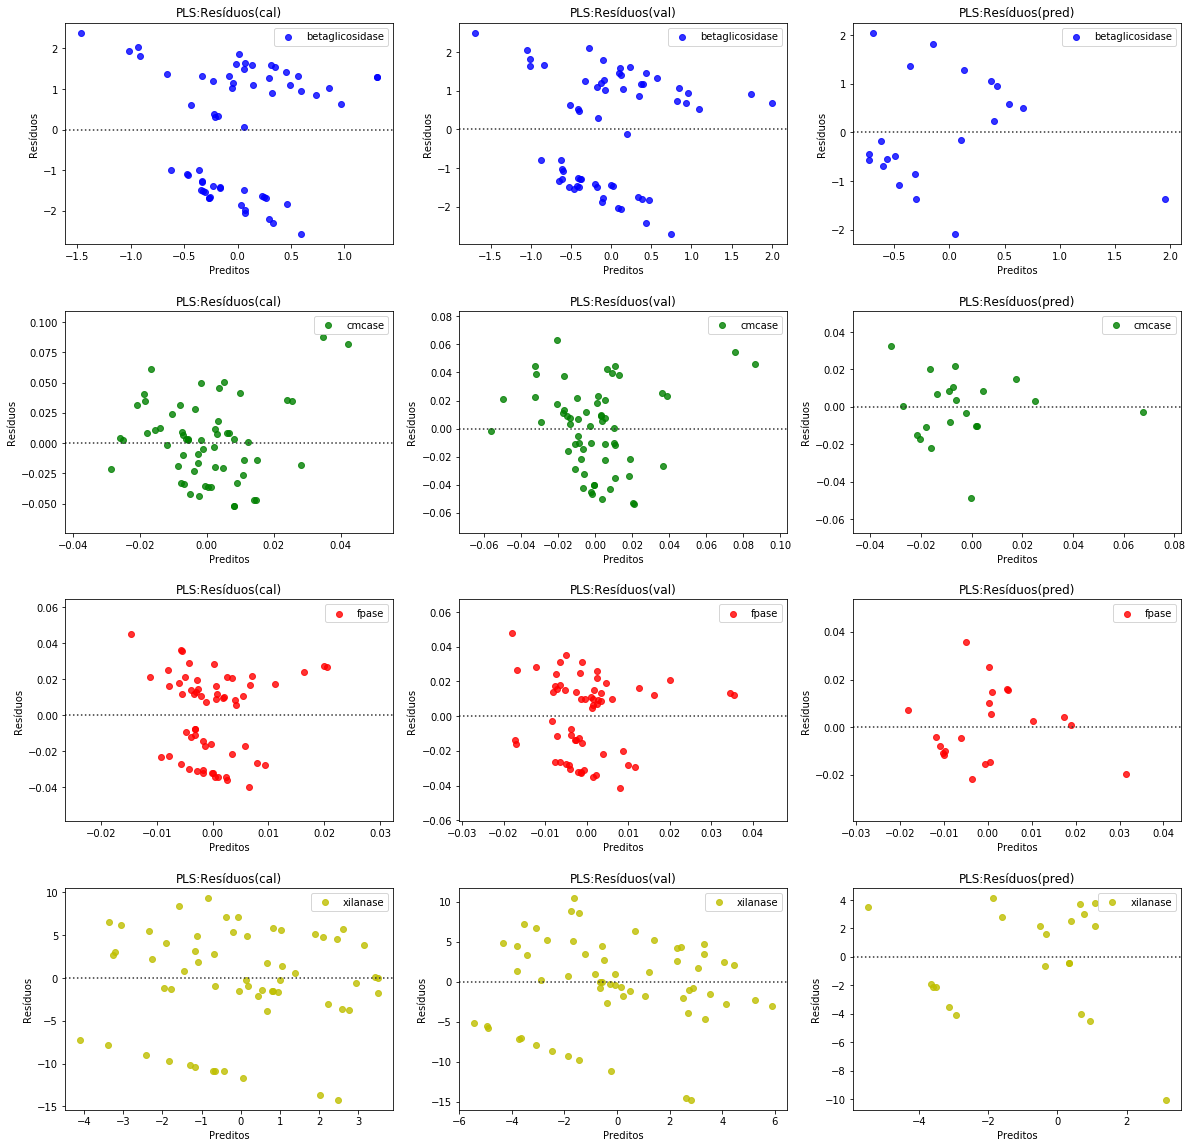

In [273]:
#gráfico dos resíduos
graficoResiduos(modelo, treino_teste, y_c,y_cv,y_p)

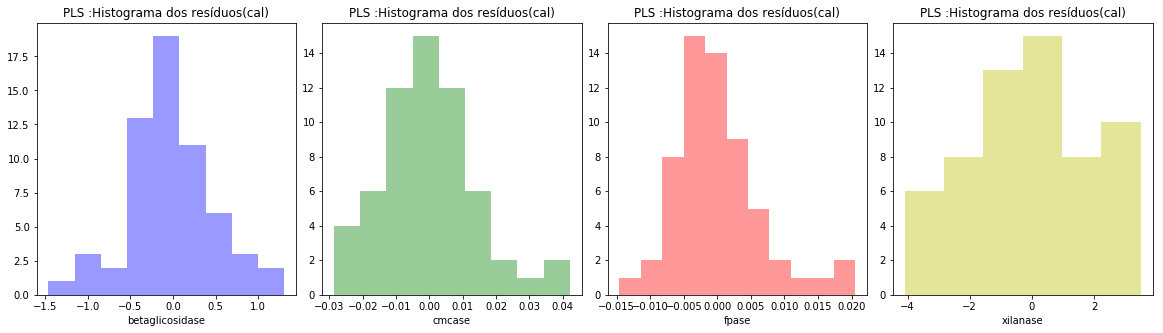

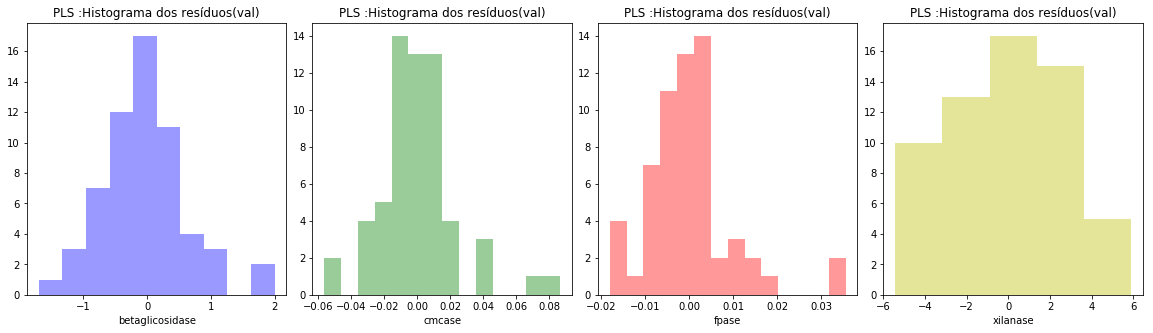

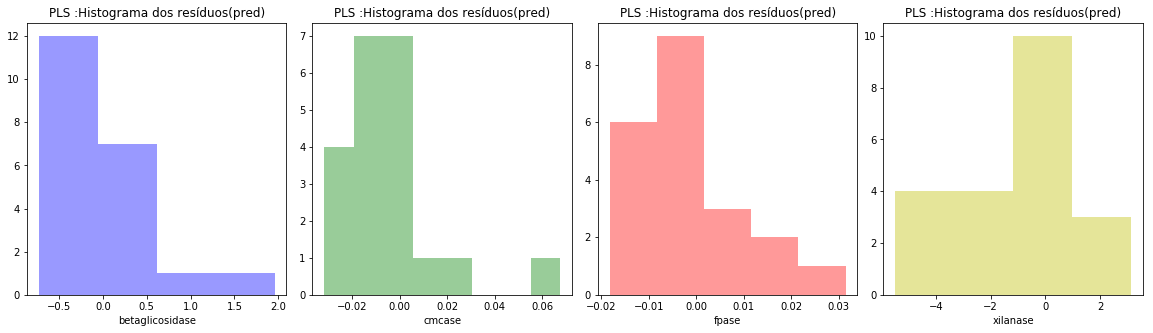

In [274]:
#histograma dos resíduos
graficoHist(modelo, treino_teste, y_c,y_cv,y_p)

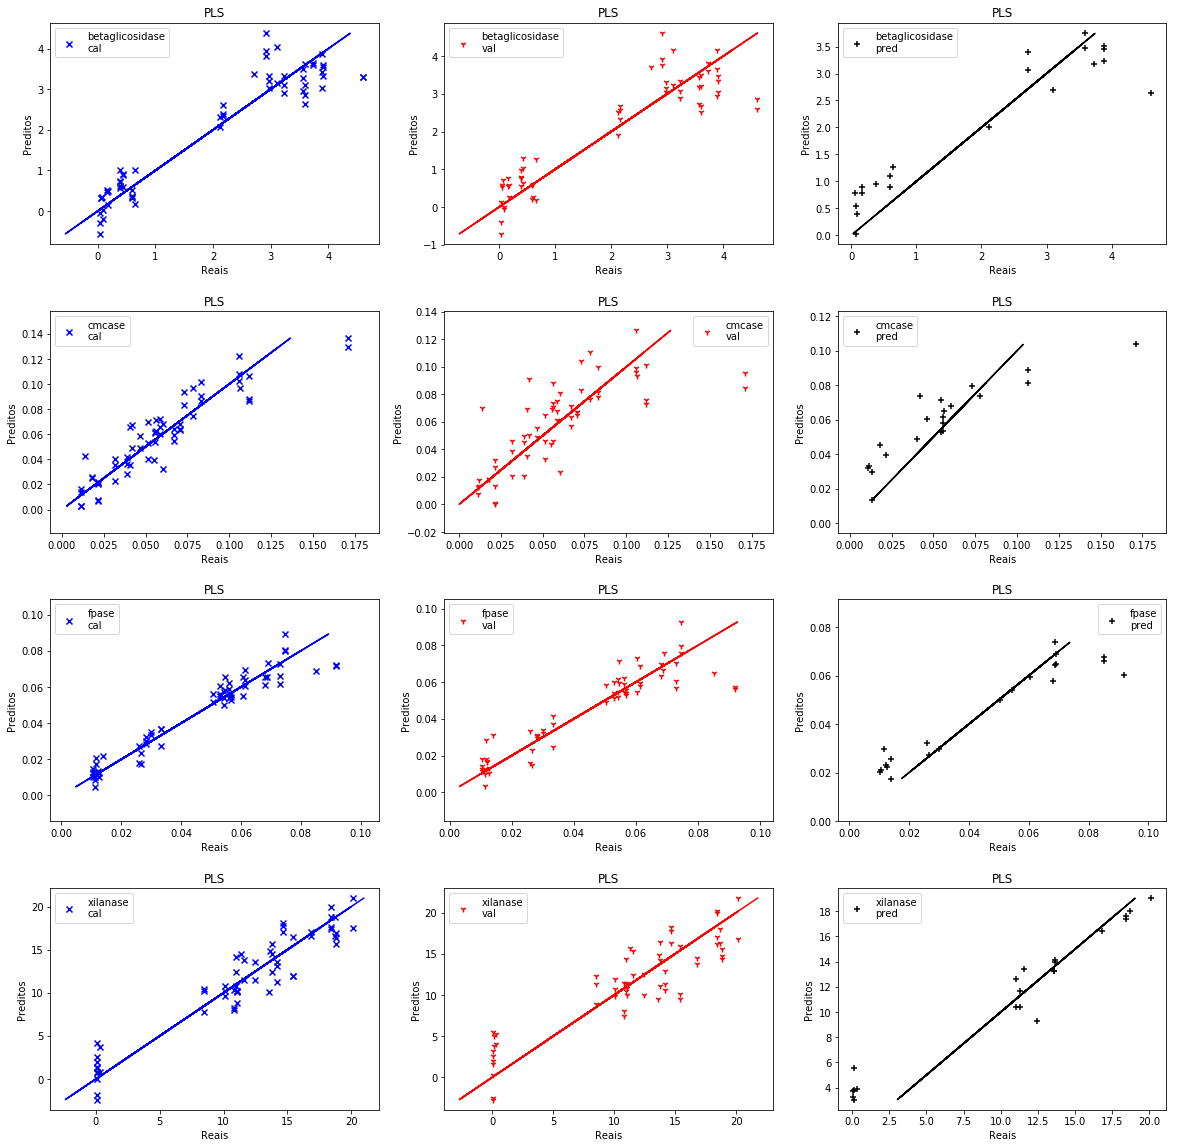

In [275]:
#graico de reais x preditos
graficoReaisPreditosSep(modelo, treino_teste, y_c,y_cv,y_p)

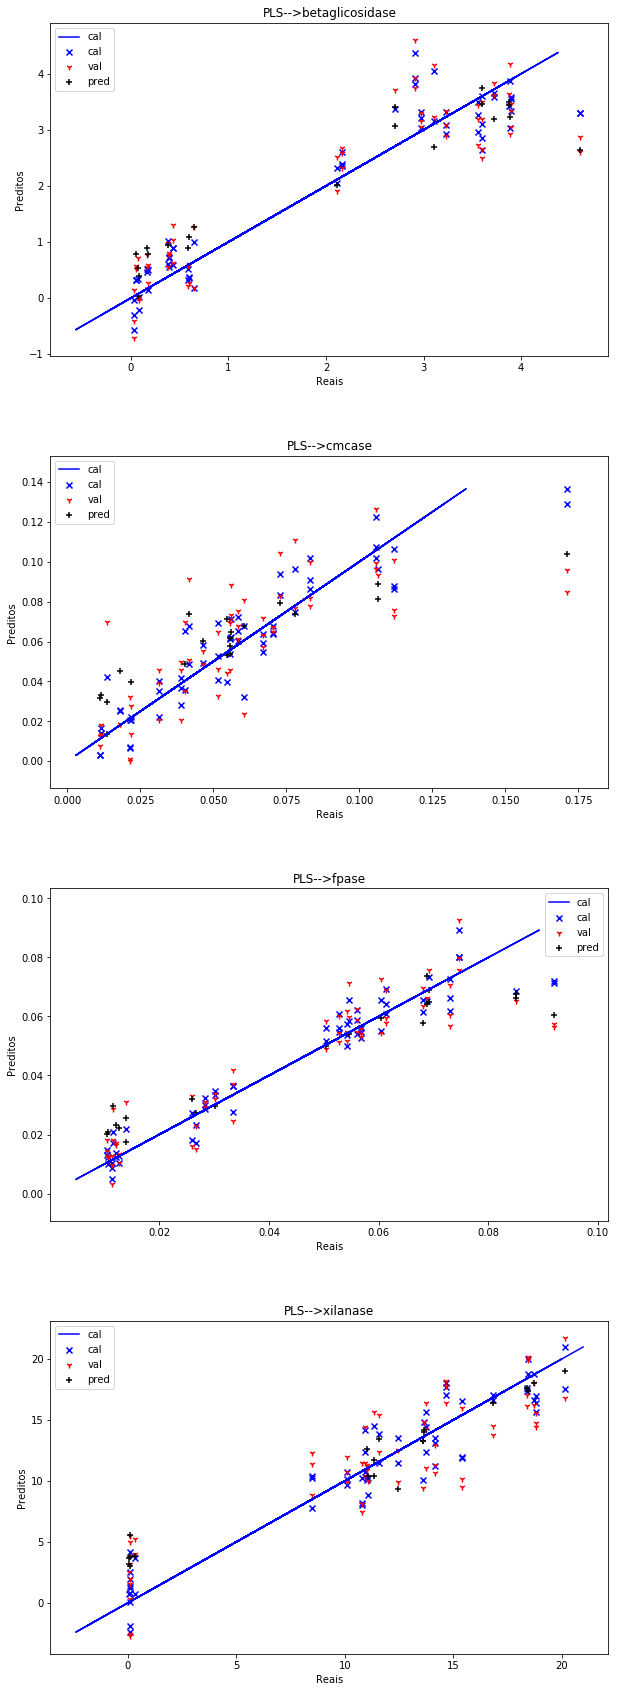

In [276]:
#graico de reais x preditos conjuntamente
graficoReaisPreditos(modelo, treino_teste, y_c,y_cv,y_p)

### PLS: Gráficos: dados de treino

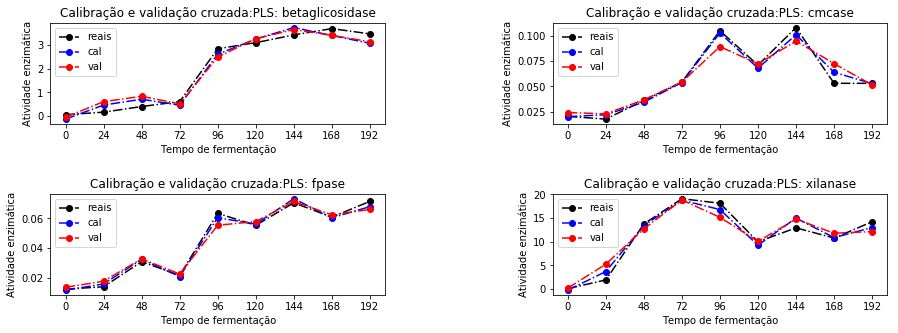

In [277]:
y_treino = treino_teste[2]
graficoTreinamento(modelo, y_treino, y_c,y_cv)

### PLS: Gráficos de  teste

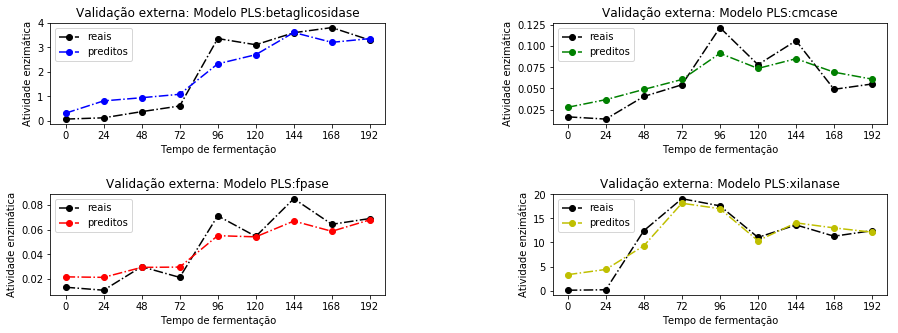

In [278]:
y_teste = treino_teste[3]
graficoTeste(modelo, y_teste, y_p)

## Ridge: Quadrados mínimos lineares

In [294]:
#ridge
#função completa para execução do Ridge:
from sklearn.linear_model import Ridge
def executaRidge(preproc, IC=0):
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,False, IC)
        
    
    reg = Ridge(alpha = 1.0, solver = 'auto', max_iter=1000)
    #reg = Ridge(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=1000, 
               # normalize=False, random_state=0, solver='auto', tol=0.001)

    
    result = executaCVP([x_treino, x_teste, y_treino, y_teste], reg)
    
    return result

    

In [295]:
#PCA_Ridge
from sklearn.linear_model import Ridge
def executaPCA_Ridge(preproc, nPC=4, IC=0):
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,False, IC)
        
    
    reg = Ridge(alpha = 1.0, solver = 'auto',max_iter=500)
   
    # Roda o PCA e produz uma vaiável reduzida xRed e seleciona as primeiras componentes definidas pela variável nPc
    pca = PCA(n_components=nPC)
    x_treino = pca.fit_transform(x_treino)[:,:nPC]
    x_teste = pca.fit_transform(x_teste)[:,:nPC] 
    
    result = executaCVP([x_treino, x_teste, y_treino, y_teste], reg)
    
    return result

    

### Ridge: testes

In [296]:
#ridge teste simples
modelo = 'Ridge'
for k in range(12):
    print(preProc[k])
    result = executaRidge(k)
    print('Parâmetros do modelo:',modelo,'\n',result[0])

    resultados=exibeResultados(result)
    
    for k,v in zip(resultados.keys(),resultados.values()):
        print(k)
        print(v,'\n-----------------------------------------------------')

Pré-proc: 0--> Sem pré-processamento
Parâmetros do modelo: Ridge 
 Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, random_state=None, solver='auto', tol=0.001)
cal
      betaglicosidase     cmcase     fpase     xilanase
BIAS          -0.0000     0.0000   -0.0000      -0.0000
MSE       105270.8721  1530.7483  381.5274  135201.6957
R2             0.2689     0.2337    0.1285       0.1355
RER            8.9886     7.3543    8.3554       8.0471
RMSE         324.4547    39.1248   19.5327     367.6978
RPD            1.1695     1.1424    1.0712       1.0755
RPIQ           0.4753     0.7520    1.0903       1.1233
SEP          324.6932    39.1535   19.5471     367.9681 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS           0.0175    -0.0336   -0.0333      -0.8510
MSE       108243.4009  1573.2783  392.1348  139520.4819
R2             0.2483     0.2125    0.1043       0.1078
RER         

Parâmetros do modelo: Ridge 
 Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, random_state=None, solver='auto', tol=0.001)
cal
      betaglicosidase     cmcase     fpase     xilanase
BIAS          -0.0000    -0.0000   -0.0000      -0.0000
MSE       126399.4766  1789.4659  413.9356  151669.7848
R2             0.1222     0.1042    0.0545       0.0301
RER            8.2030     6.8020    8.0216       7.5977
RMSE         355.5270    42.3021   20.3454     389.4481
RPD            1.0673     1.0566    1.0284       1.0154
RPIQ           0.4338     0.6955    1.0468       1.0606
SEP          355.7884    42.3332   20.3604     389.7343 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS           0.0800    -0.0052   -0.0069      -0.2130
MSE       127811.8435  1808.7035  417.8770  153046.6716
R2             0.1124     0.0946    0.0455       0.0213
RER            8.1576     6.7657    7.9837       

Parâmetros do modelo: Ridge 
 Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, random_state=None, solver='auto', tol=0.001)
cal
      betaglicosidase     cmcase     fpase     xilanase
BIAS           0.0000     0.0000    0.0000       0.0000
MSE       108634.7651  1541.8735  384.1218  136786.2542
R2             0.2456     0.2282    0.1226       0.1253
RER            8.8483     7.3278    8.3271       8.0003
RMSE         329.5979    39.2667   19.5990     369.8463
RPD            1.1513     1.1383    1.0676       1.0692
RPIQ           0.4679     0.7493    1.0866       1.1168
SEP          329.8401    39.2956   19.6134     370.1181 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS           0.1685    -0.0205   -0.0215      -0.6398
MSE       111441.6798  1581.6603  393.4796  140683.4353
R2             0.2261     0.2083    0.1012       0.1004
RER            8.7362     7.2350    8.2275       

In [297]:
#ridge otimizando
maior=[-1,-1,-1,-1]
maiorGerado=[0,0,0,0]
for i in range(100):
    result = executaRidge(preproc=1,IC=i)
    resultados=exibeResultados(result)
    r2 = resultados['pred'].loc[resultados['pred'].index=='R2']
    r = []
    for j in range(4):
        r.append(r2.iloc[:,j][0])
        if r[j]>maior[j]:
            maior[j] = r[j]
            maiorGerado[j]=i
    print('\r%d%% completos'%(i+1), end='')
print('\n','r2:',maior,'\nsemente: b c f x',maiorGerado)

8% completos

KeyboardInterrupt: 

In [298]:
#ridge teste otimizado
modelo = 'Ridge:'
result = result = executaRidge(preproc=1,IC=16)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)

Parâmetros do modelo: Ridge: 
 Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, random_state=None, solver='auto', tol=0.001)


In [300]:
resultados['cal']

betaglicosidase    cmcase     fpase    xilanase
BIAS          -0.0000    0.0000    0.0000      0.0000
MSE        48876.7468  477.2164  176.2356  63273.4122
R2             0.6466    0.7522    0.5679      0.5773
RER           13.1914   13.1716   12.2937     11.7630
RMSE         221.0809   21.8453   13.2754    251.5421
RPD            1.6822    2.0088    1.5213      1.5380
RPIQ           0.6301    1.2874    1.6229      2.0102
SEP          221.2434   21.8613   13.2851    251.7270

In [301]:
resultados['val']

betaglicosidase    cmcase     fpase     xilanase
BIAS           2.5612    0.0766   -0.0662      -0.7036
MSE        85666.4662  831.0848  306.7821  109106.2747
R2             0.3806    0.5684    0.2478       0.2710
RER            9.9645    9.9810    9.3179       8.9579
RMSE         292.6883   28.8285   17.5152     330.3124
RPD            1.2706    1.5222    1.1530       1.1712
RPIQ           0.4759    0.9755    1.2300       1.5308
SEP          292.8923   28.8496   17.5279     330.5544

In [302]:
resultados['pred']

betaglicosidase    cmcase     fpase     xilanase
BIAS           1.4580   -2.2924   -0.6885     -30.6009
MSE        89646.2930  824.4081  325.9647  123434.4851
R2             0.4355    0.6217    0.3567       0.3098
RER            9.7263   10.0386    9.0327       8.4416
RMSE         299.4099   28.7125   18.0545     351.3324
RPD            1.3309    1.6258    1.2467       1.2037
RPIQ           0.6721    0.8655    1.0779       1.0801
SEP          300.0680   28.6841   18.0812     350.7707

In [287]:
reg, treino_teste,y_c,y_cv,y_p = result

###  Reais x preditos

In [288]:
#ridge reaisxpreditos
#calibração
pred=pd.DataFrame(y_c, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('CALIBRAÇÃO:\n')
round(reais_pred,4)

CALIBRAÇÃO:



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            3.5610  0.0586  0.0561   10.0978                 3.5881   
1            0.4280  0.0390  0.0334   13.7624                 0.5481   
2            3.2342  0.0672  0.0543    8.4772                 3.1771   
3            0.0308  0.0213  0.0113    0.0996                 0.1249   
4            3.8994  0.1118  0.0613   10.9512                 3.7519   
5            0.5905  0.0465  0.0267   18.7095                 0.5751   
6            0.1724  0.0112  0.0121    0.0924                 0.1611   
7            0.6010  0.0559  0.0116   20.1368                 0.5630   
8            2.1643  0.0830  0.0529   18.8324                 2.0584   
9            0.0759  0.0136  0.0139    0.0726                 0.0987   
10           3.2342  0.0672  0.0543    8.4772                 3.2756   
11           0.1671  0.0117  0.0104    0.1117                 0.0636   
12           3.5610  0.0586  0.0561   10.0978                 3.5582   
13           2.9123  0.1058  0.0747   14.6813                 2.9890   
14           3.8994  0.1118  0.0613   10.9512                 3.9198   
15           0.6491  0.0605  0.0260   18.4274                 0.6166   
16           0.4280  0.0390  0.0334   13.7624                 0.4082   
17           0.6491  0.0605  0.0260   18.4274                 0.7623   
18           2.9123  0.1058  0.0747   14.6813                 3.0716   
19           0.6491  0.0605  0.0260   18.4274                 0.6488   
20           2.1150  0.0730  0.0505   18.4127                 2.1569   
21           0.6010  0.0559  0.0116   20.1368                 0.5785   
22           0.0308  0.0213  0.0113    0.0996                -0.0142   
23           0.0874  0.0217  0.0127    0.1071                 0.0243   
24           0.0554  0.0181  0.0106    0.3275                 0.0697   
25           0.1724  0.0112  0.0121    0.0924                 0.2656   
26           3.8876  0.0418  0.0605   11.0267                 3.8068   
27           3.8803  0.0557  0.0691   11.3256                 3.8549   
28           2.7110  0.0548  0.0688   13.5829                 2.8608   
29           0.1671  0.0117  0.0104    0.1117                 0.1130   
30           3.1068  0.0781  0.0545   11.0526                 3.1491   
31           2.1643  0.0830  0.0529   18.8324                 2.1813   
32           2.9123  0.1058  0.0747   14.6813                 2.8563   
33           3.7243  0.0561  0.0681   11.5736                 3.6938   
34           3.7243  0.0561  0.0681   11.5736                 3.6235   
35           0.1724  0.0112  0.0121    0.0924                 0.1320   
36           0.1671  0.0117  0.0104    0.1117                 0.3047   
37           3.1068  0.0781  0.0545   11.0526                 3.1119   
38           0.4280  0.0390  0.0334   13.7624                 0.3843   
39           0.3828  0.0405  0.0301   12.4461                 0.5113   
40           3.5967  0.1065  0.0850   13.6476                 3.5080   
41           3.5974  0.0516  0.0731   15.3973                 3.4035   
42           3.8876  0.0418  0.0605   11.0267                 3.9966   
43           0.0874  0.0217  0.0127    0.1071                 0.0493   
44           0.3828  0.0405  0.0301   12.4461                 0.3660   
45           0.3900  0.0315  0.0283   14.1777                 0.4816   
46           3.2342  0.0672  0.0543    8.4772                 3.2270   
47           2.7110  0.0548  0.0688   13.5829                 2.8335   
48           3.1068  0.0781  0.0545   11.0526                 3.1146   
49           2.9774  0.0704  0.0567   10.8002                 2.9776   
50           2.7110  0.0548  0.0688   13.5829                 2.7560   
51           0.6010  0.0559  0.0116   20.1368                 0.5538   
52           3.5967  0.1065  0.0850   13.6476                 3.4913   
53           0.5905  0.0465  0.0267   18.7095                 0.6265   
54           3.8876  0.0418  0.0605   11.026

In [1062]:
#validação
pred=pd.DataFrame(y_cv, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('VALIDAÇÃO CRUZADA:\n')
round(reais_pred,4)


VALIDAÇÃO CRUZADA:



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            3.2342  0.0672  0.0543    8.4772                 2.7566   
1            0.3900  0.0315  0.0283   14.1777                 0.5290   
2            2.9123  0.1058  0.0747   14.6813                 3.7219   
3            0.0554  0.0181  0.0106    0.3275                 0.8852   
4            2.1150  0.0730  0.0505   18.4127                 3.6636   
5            3.8994  0.1118  0.0613   10.9512                 3.2920   
6            3.2342  0.0672  0.0543    8.4772                 2.8189   
7            3.5610  0.0586  0.0561   10.0978                 4.0764   
8            3.5610  0.0586  0.0561   10.0978                 4.0725   
9            0.0308  0.0213  0.0113    0.0996                -0.3955   
10           2.9774  0.0704  0.0567   10.8002                 3.0278   
11           0.1671  0.0117  0.0104    0.1117                -0.8059   
12           0.5905  0.0465  0.0267   18.7095                 0.7814   
13           3.1068  0.0781  0.0545   11.0526                 2.2134   
14           3.8994  0.1118  0.0613   10.9512                 3.7650   
15           3.5974  0.0516  0.0731   15.3973                 3.3843   
16           3.8803  0.0557  0.0691   11.3256                 5.1440   
17           0.3900  0.0315  0.0283   14.1777                 1.5222   
18           3.1068  0.0781  0.0545   11.0526                 3.2246   
19           2.7110  0.0548  0.0688   13.5829                 2.7880   
20           3.7243  0.0561  0.0681   11.5736                 3.4571   
21           0.0874  0.0217  0.0127    0.1071                -0.4743   
22           0.0759  0.0136  0.0139    0.0726                -0.4536   
23           3.8803  0.0557  0.0691   11.3256                 1.9551   
24           3.1068  0.0781  0.0545   11.0526                 3.5281   
25           0.6491  0.0605  0.0260   18.4274                 1.0689   
26           2.1150  0.0730  0.0505   18.4127                 2.9760   
27           0.5905  0.0465  0.0267   18.7095                 0.2367   
28           3.5967  0.1065  0.0850   13.6476                 3.8621   
29           0.4280  0.0390  0.0334   13.7624                 1.7822   
30           0.0554  0.0181  0.0106    0.3275                 1.1182   
31           3.5967  0.1065  0.0850   13.6476                 3.5195   
32           2.9123  0.1058  0.0747   14.6813                 3.0683   
33           3.5974  0.0516  0.0731   15.3973                 3.0922   
34           0.1671  0.0117  0.0104    0.1117                 0.3451   
35           3.8876  0.0418  0.0605   11.0267                 3.4058   
36           0.6491  0.0605  0.0260   18.4274                 0.6689   
37           0.3828  0.0405  0.0301   12.4461                 0.9434   
38           3.5967  0.1065  0.0850   13.6476                 2.8730   
39           2.1150  0.0730  0.0505   18.4127                 2.4629   
40           0.0759  0.0136  0.0139    0.0726                 0.6554   
41           0.1671  0.0117  0.0104    0.1117                 0.5818   
42           0.4280  0.0390  0.0334   13.7624                 1.2096   
43           4.6037  0.1713  0.0919   16.8115                 3.3256   
44           3.5610  0.0586  0.0561   10.0978                 4.6518   
45           0.6010  0.0559  0.0116   20.1368                 0.4559   
46           0.1724  0.0112  0.0121    0.0924                 0.8868   
47           0.3828  0.0405  0.0301   12.4461                 0.3780   
48           3.8876  0.0418  0.0605   11.0267                 3.8076   
49           4.6037  0.1713  0.0919   16.8115                 2.3752   
50           0.1724  0.0112  0.0121    0.0924                 0.7466   
51           0.5905  0.0465  0.0267   18.7095                -0.5143   
52           0.0759  0.0136  0.0139    0.0726                 0.1369   
53           0.0554  0.0181  0.0106    0.3275                 0.3721   
54           0.6010  0.0559  0.0116   20.136

In [1063]:
#predição
pred=pd.DataFrame(y_p, columns=var_ae)
reais = treino_teste[3]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('Predição (validação externa):\n')
round(reais_pred,4)

Predição (validação externa):



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            3.5974  0.0516  0.0731   15.3973                 3.9585   
1            3.8803  0.0557  0.0691   11.3256                 3.7439   
2            3.7243  0.0561  0.0681   11.5736                 3.8461   
3            2.1643  0.0830  0.0529   18.8324                 3.9182   
4            0.6491  0.0605  0.0260   18.4274                 0.2357   
5            0.3900  0.0315  0.0283   14.1777                 1.0511   
6            2.1643  0.0830  0.0529   18.8324                 3.0518   
7            0.0874  0.0217  0.0127    0.1071                 0.6861   
8            2.9123  0.1058  0.0747   14.6813                 3.2884   
9            0.0308  0.0213  0.0113    0.0996                -0.8406   
10           0.3828  0.0405  0.0301   12.4461                 1.5538   
11           0.4280  0.0390  0.0334   13.7624                 0.9922   
12           0.0308  0.0213  0.0113    0.0996                 0.1783   
13           0.1724  0.0112  0.0121    0.0924                 0.1588   
14           3.7243  0.0561  0.0681   11.5736                 4.9058   
15           0.0874  0.0217  0.0127    0.1071                 0.6000   
16           2.9774  0.0704  0.0567   10.8002                 2.5004   
17           2.1643  0.0830  0.0529   18.8324                 2.3034   
18           2.7110  0.0548  0.0688   13.5829                 4.0600   
19           2.7110  0.0548  0.0688   13.5829                 2.7219   
20           0.6010  0.0559  0.0116   20.1368                 0.9115   

    pred: cmcase  pred: fpase  pred: xilanase  
0         0.0823       0.0809         15.6671  
1         0.0581       0.0611         10.6501  
2         0.0733       0.0748         12.5182  
3         0.1324       0.0732         13.5936  
4         0.0320       0.0175         15.3187  
5         0.0563       0.0357         10.1028  
6         0.0938       0.0614         14.3134  
7         0.0356       0.0105          1.1984  
8         0.1211       0.0817         18.4668  
9        -0.0294      -0.0094         -1.2611  
10        0.0949       0.0472         11.1344  
11        0.0605       0.0457         13.3416  
12        0.0334       0.0198          6.5912  
13        0.0106       0.0115          4.2335  
14        0.1278       0.0859         13.8037  
15        0.0044       0.0095          2.9197  
16        0.0562       0.0432          7.7705  
17        0.0633       0.0407         13.6693  
18        0.0821       0.0807         12.8034  
19        0.0115       0.0532         12.0130  
20        0.0573       0.0266         17.5853

###  Ridge: Gráficos de resíduos - histograma - reais x preditos

In [304]:
#título para os gráficos
modelo = 'Ridge'

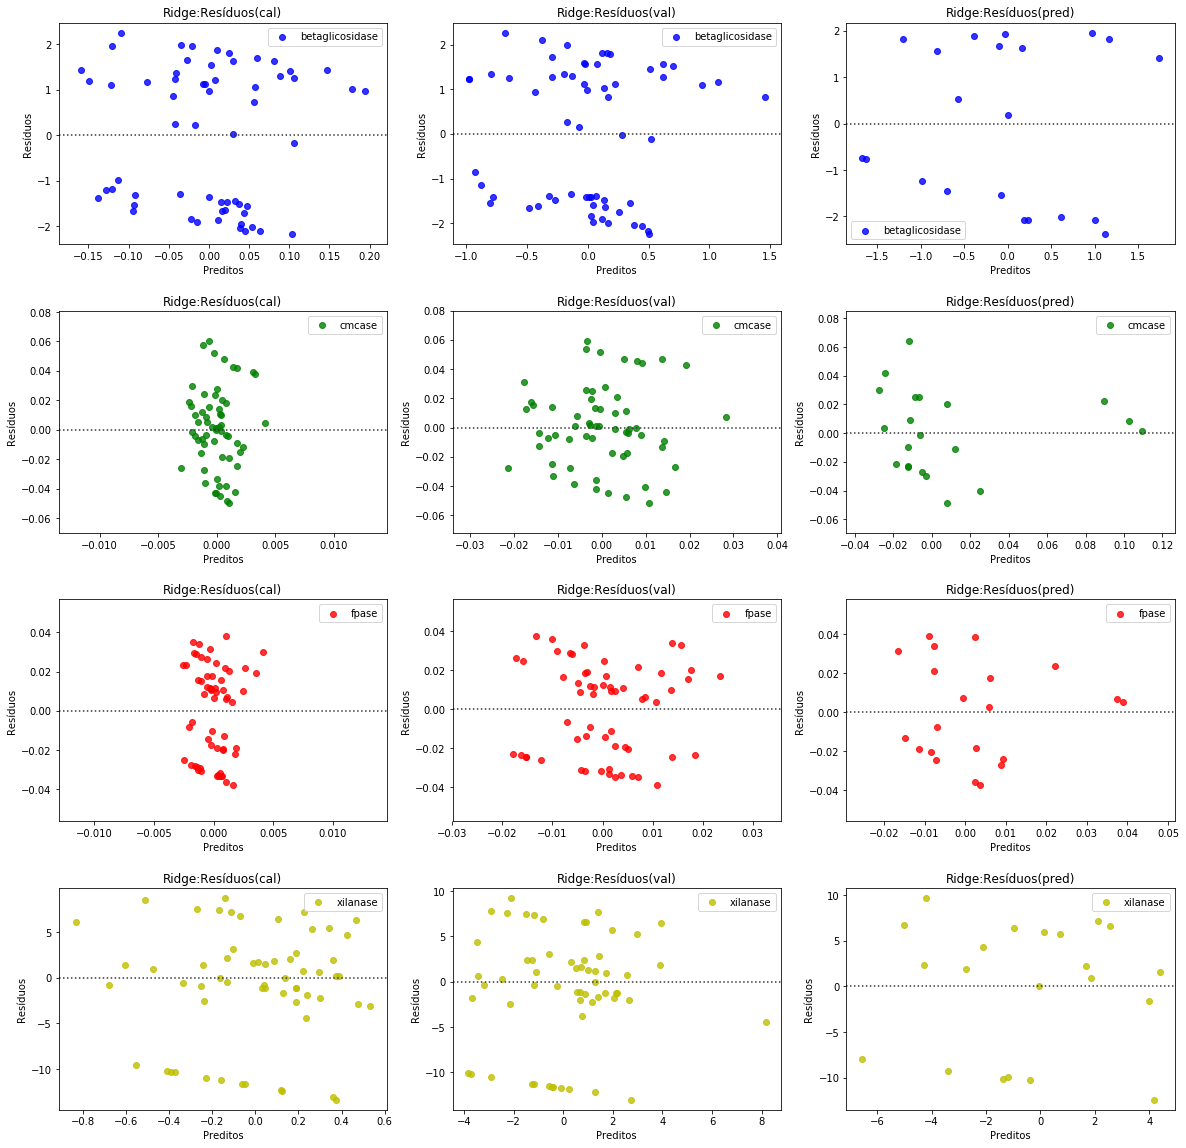

In [305]:
#gráfico dos resíduos
graficoResiduos(modelo, treino_teste, y_c,y_cv,y_p)

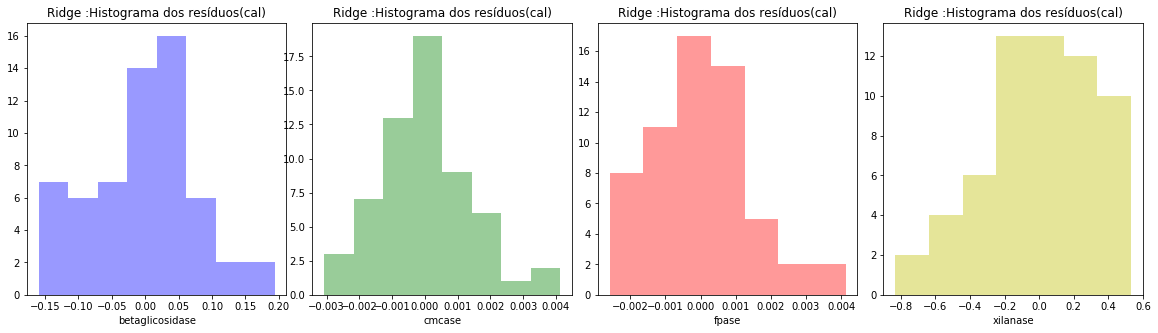

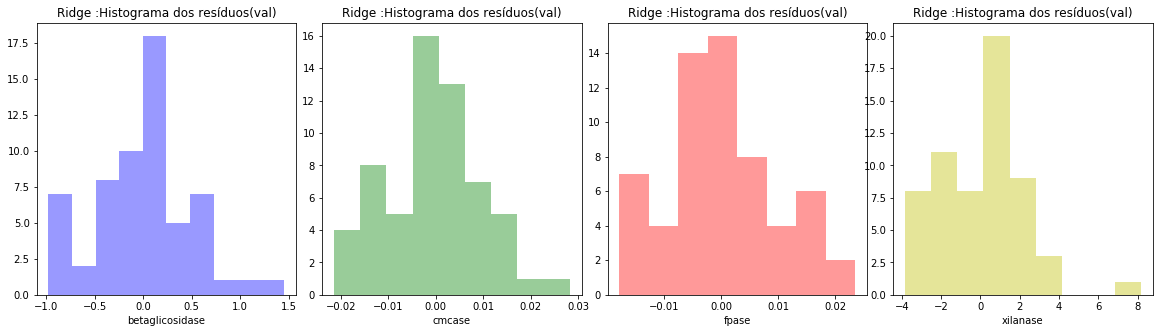

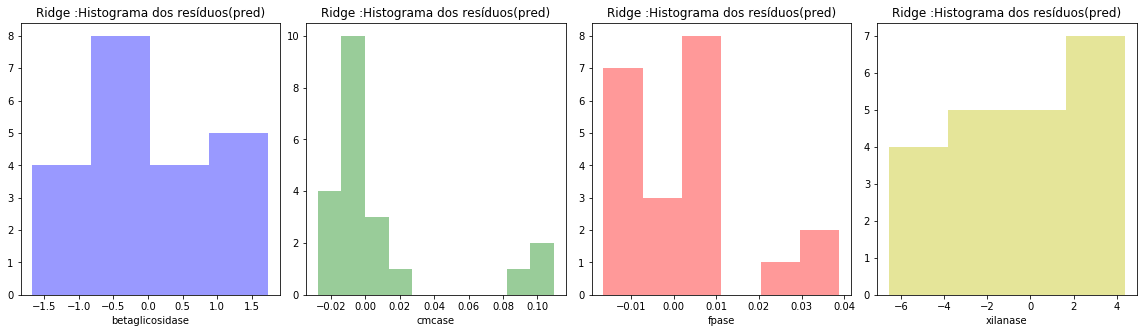

In [306]:
#histograma dos resíduos
graficoHist(modelo, treino_teste, y_c,y_cv,y_p)

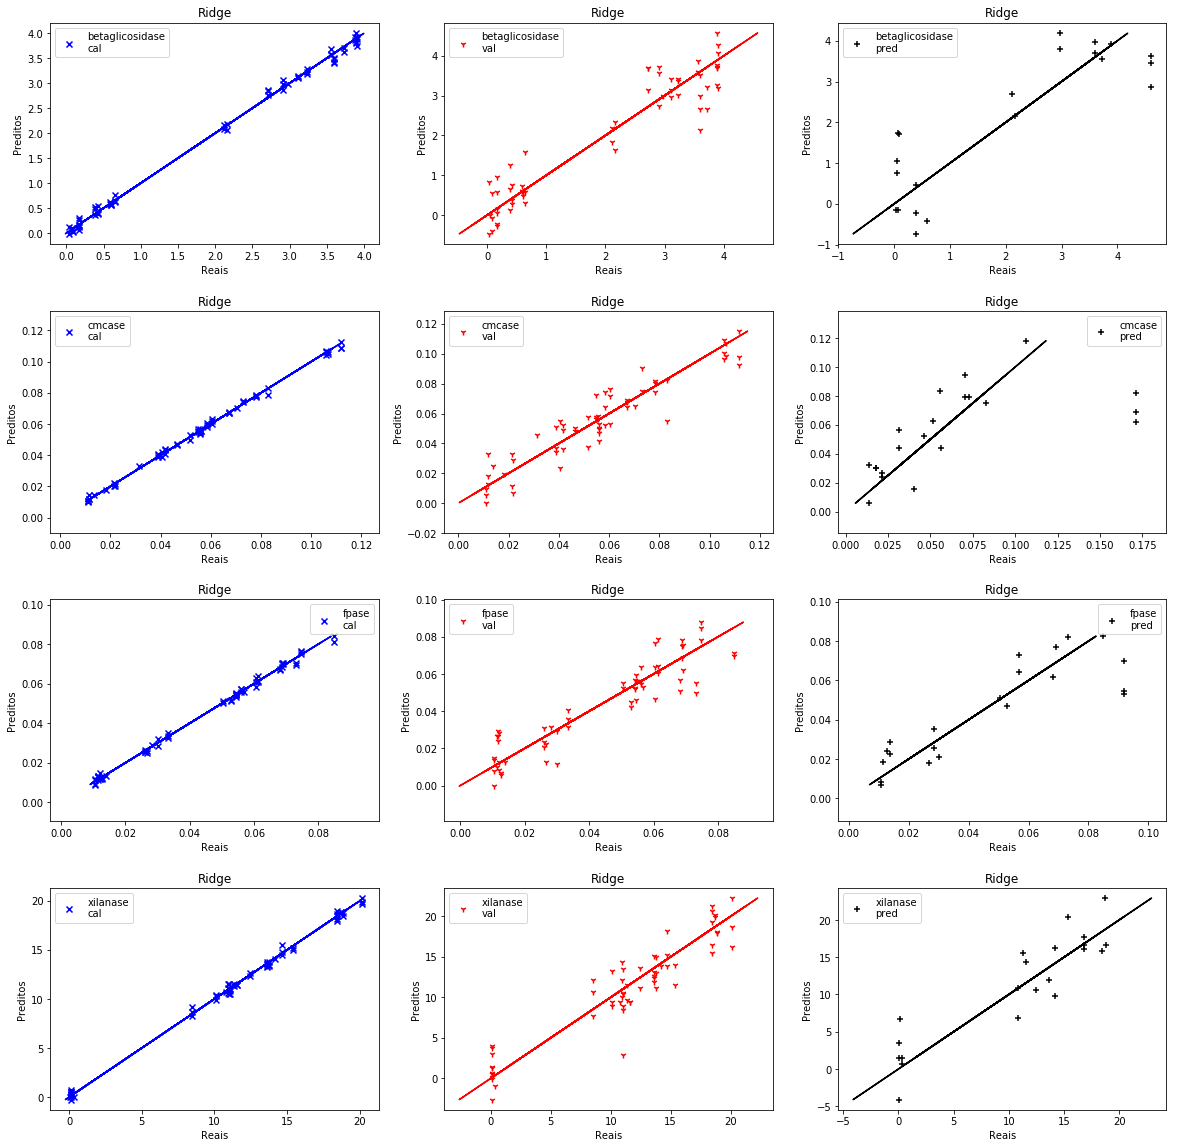

In [308]:
#graico de reais x preditos
graficoReaisPreditosSep(modelo, treino_teste, y_c,y_cv,y_p)

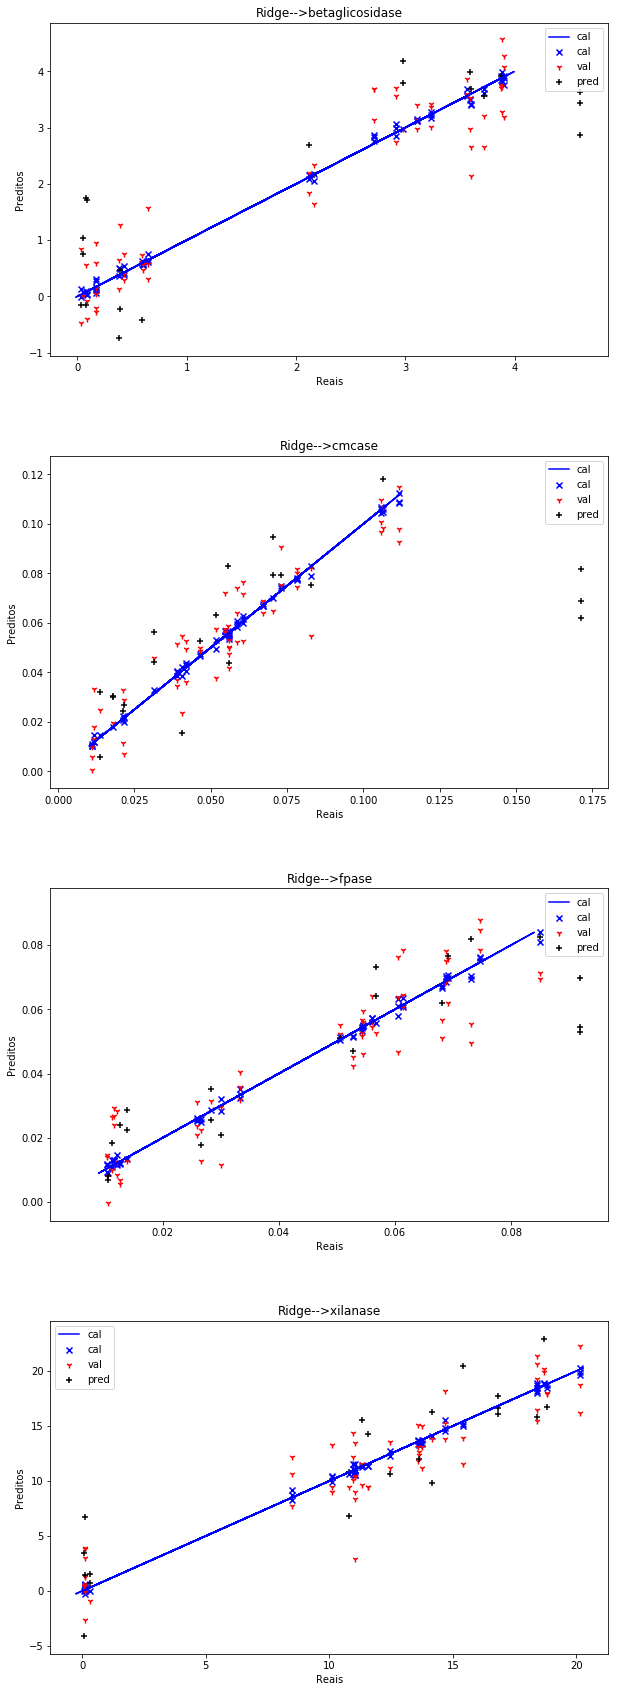

In [309]:
#graico de reais x preditos
graficoReaisPreditos(modelo, treino_teste, y_c,y_cv,y_p)

### Ridge: Gráficos: dados de treino

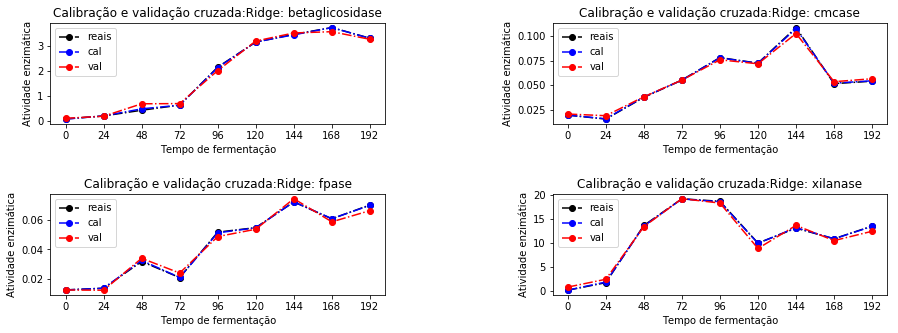

In [310]:
y_treino = treino_teste[2]
graficoTreinamento(modelo, y_treino, y_c,y_cv)

### Ridge: Gráficos de  teste

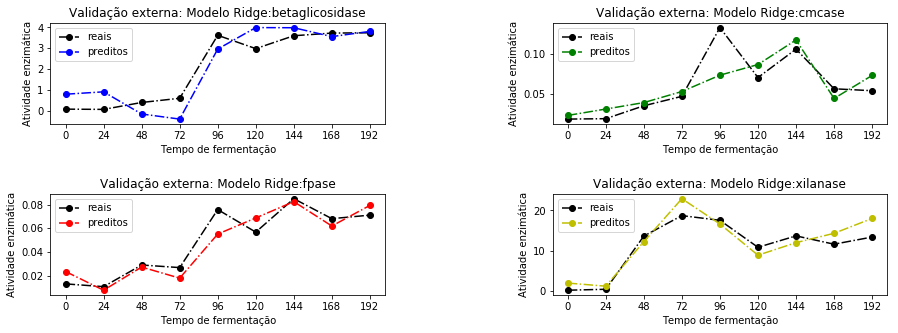

In [311]:
y_teste = treino_teste[3]
graficoTeste(modelo, y_teste, y_p)

## Kernel Ridge: Quadrados mínimos lineares com kernel

In [278]:
#kernelRidge
def executaKernelRidge(preproc=1, teste=1, k='linear', IC=0):
    #separando o conjunto de dados em treino e teste
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,False, IC)
        

   
    if teste == 1:
        reg = GridSearchCV(estimator=KernelRidge(), cv=5,
                  param_grid={"kernel":['rbf','linear','poly'],
                              "alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": [.1,.2,0,1,2,3,4,5,10],
                              "degree":[1,2,3]
                            })
    elif teste==2:
        #kernel otimizado
        reg = KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear')
    else:
         reg = KernelRidge(kernel = k,alpha = 1.0)
    
    result = executaCVP([x_treino, x_teste, y_treino, y_teste], reg)
    
    return result

    

### Kernel Ridge: testes

In [279]:
#Kernelridge teste para um tipo de pré-processamento
modelo = 'Kernel Ridge'
result = executaKernelRidge(preproc=1,teste=0,k='rbf')
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)
    
for k,v in zip(resultados.keys(),resultados.values()):
    print(k)
    print(v,'\n-----------------------------------------------------')

Parâmetros do modelo: Kernel Ridge 
 KernelRidge(alpha=1.0, coef0=1, degree=3, gamma=None, kernel='rbf',
      kernel_params=None)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           3.1204    0.5982    0.2339      3.1698
MSE        35379.6104  382.3812  186.4429  65115.6687
R2             0.7543    0.8086    0.5741      0.5836
RER           15.5071   14.7215   11.9542     11.5963
RMSE         188.0947   19.5546   13.6544    255.1777
RPD            2.0174    2.2857    1.5323      1.5497
RPIQ           0.8200    1.5047    1.5597      1.6186
SEP          188.2070   19.5598   13.6624    255.3456 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase    xilanase
BIAS           3.6915    0.7402    0.2702      3.3417
MSE        46561.6796  494.1142  237.8097  83175.2112
R2             0.6766    0.7527    0.4568      0.4681
RER           13.5175   12.9516   10.5847     10.2603
RMSE         215.7816   22.2287   15.4211    288.4

In [280]:
#Kernelridge teste pré-proc
modelo = 'Kernel Ridge'
for k in range(12):
    print(preProc[k])
    result = executaKernelRidge(k, teste=0, k='poly')
    print('Parâmetros do modelo:',modelo,'\n',result[0])

    resultados=exibeResultados(result)
    
    for k,v in zip(resultados.keys(),resultados.values()):
        print(k)
        print(v,'\n-----------------------------------------------------')

Pré-proc: 0--> Sem pré-processamento
Parâmetros do modelo: Kernel Ridge 
 KernelRidge(alpha=1.0, coef0=1, degree=3, gamma=None, kernel='poly',
      kernel_params=None)
cal
      betaglicosidase     cmcase     fpase     xilanase
BIAS           0.4529     0.0120    0.0093       0.2913
MSE       124528.7506  1747.3121  409.2847  150832.8606
R2             0.1352     0.1253    0.0651       0.0355
RER            8.2644     6.8835    8.0671       7.6187
RMSE         352.8863    41.8009   20.2308     388.3721
RPD            1.0753     1.0692    1.0342       1.0182
RPIQ           0.4371     0.7039    1.0527       1.0635
SEP          353.1454    41.8316   20.2457     388.6574 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS           0.5239    -0.0026    0.0004       0.0612
MSE       125904.4530  1765.5617  412.9915  152184.8927
R2             0.1256     0.1162    0.0566       0.0269
RER            8.2191     6.8479    8.03

Parâmetros do modelo: Kernel Ridge 
 KernelRidge(alpha=1.0, coef0=1, degree=3, gamma=None, kernel='poly',
      kernel_params=None)
cal
      betaglicosidase     cmcase     fpase     xilanase
BIAS           0.3130     0.1153    0.0368       0.6317
MSE       143708.0154  1994.2693  437.3938  156310.6582
R2             0.0020     0.0017    0.0009       0.0005
RER            7.6932     6.4433    7.8036       7.4840
RMSE         379.0884    44.6572   20.9140     395.3614
RPD            1.0010     1.0009    1.0004       1.0002
RPIQ           0.4068     0.6589    1.0183       1.0447
SEP          379.3669    44.6899   20.9293     395.6515 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS           0.3628     0.1287    0.0409       0.6942
MSE       144111.1289  1999.4307  438.8943  156950.3469
R2            -0.0008    -0.0009   -0.0026      -0.0036
RER            7.6824     6.4349    7.7902       7.4688
RMSE         379.6197

Parâmetros do modelo: Kernel Ridge 
 KernelRidge(alpha=1.0, coef0=1, degree=3, gamma=None, kernel='poly',
      kernel_params=None)
cal
      betaglicosidase     cmcase     fpase     xilanase
BIAS           0.1139     0.0418    0.0133       0.2287
MSE       129642.6617  1806.8973  416.0086  152438.1653
R2             0.0997     0.0955    0.0497       0.0252
RER            8.0998     6.7691    8.0016       7.5785
RMSE         360.0592    42.5076   20.3963     390.4333
RPD            1.0539     1.0515    1.0258       1.0129
RPIQ           0.4283     0.6922    1.0442       1.0579
SEP          360.3239    42.5388   20.4113     390.7202 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS           0.1651     0.0345    0.0083       0.0908
MSE       130946.7298  1825.0811  419.4262  153584.3033
R2             0.0906     0.0864    0.0419       0.0179
RER            8.0593     6.7353    7.9689       7.5502
RMSE         361.8656

In [446]:
'''#kernel ridge teste otimização automática
modelo = 'Kernel Ridge:'
result = result = executaKernelRidge(preproc=8, teste=1)
print('Parâmetros do modelo:',modelo,'\n',result[0])'''


"#kernel ridge teste otimização automática\nmodelo = 'Kernel Ridge:'\nresult = result = executaKernelRidge(preproc=8, teste=1)\nprint('Parâmetros do modelo:',modelo,'\n',result[0])"

In [281]:
#Kernel ridge otimizando
maior=[-1,-1,-1,-1]
maiorGerado=[0,0,0,0]
for i in range(100):
    result = executaKernelRidge(preproc=8,k='poly',teste=0,IC=i)
    resultados=exibeResultados(result)
    r2 = resultados['val'].loc[resultados['val'].index=='R2']
    r = []
    for j in range(4):
        r.append(r2.iloc[:,j][0])
        if r[j]>maior[j]:
            maior[j] = r[j]
            maiorGerado[j]=i
    print('\r%d%% completos'%(i+1), end='')
print('\n','r2:',maior,'\nsemente: b c f x',maiorGerado)

100% completos
 r2: [0.6899, 0.7696, 0.5137, 0.5213] 
semente: b c f x [41, 77, 80, 80]


In [288]:
#kernel ridge teste otimizado
modelo = 'Kernel Ridge:'
result = result = executaKernelRidge(preproc=8,k='poly', teste=0, IC=80)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)

Parâmetros do modelo: Kernel Ridge: 
 KernelRidge(alpha=1.0, coef0=1, degree=3, gamma=None, kernel='poly',
      kernel_params=None)


In [289]:
resultados['cal']

betaglicosidase   cmcase    fpase   xilanase
BIAS           0.1354   0.1046   0.0334     0.6222
MSE         2271.1922  53.2744  24.7991  9698.3445
R2             0.9831   0.9723   0.9428     0.9371
RER           61.1957  39.4259  32.7733    30.0462
RMSE          47.6570   7.2989   4.9799    98.4802
RPD            7.6964   6.0052   4.1798     3.9861
RPIQ           3.1014   3.8116   4.3018     4.8725
SEP           47.6919   7.3035   4.9834    98.5506

In [290]:
resultados['val']

betaglicosidase    cmcase     fpase    xilanase
BIAS           3.4934    0.2217    0.1946      3.1558
MSE        45464.6121  469.6669  210.7006  73763.5707
R2             0.6621    0.7555    0.5137      0.5213
RER           13.6794   13.2777   11.2444     10.8953
RMSE         213.2243   21.6718   14.5155    271.5945
RPD            1.7202    2.0225    1.4340      1.4453
RPIQ           0.6932    1.2837    1.4758      1.7668
SEP          213.3524   21.6866   14.5249    271.7758

In [291]:
resultados['pred']

betaglicosidase    cmcase     fpase     xilanase
BIAS           3.2337   -3.5390   -1.7446     -33.0267
MSE        91814.1738  715.5575  317.9767  119021.4068
R2             0.4602    0.6737    0.2605       0.2827
RER            9.6111   10.8360    7.6283       7.9023
RMSE         303.0085   26.7499   17.8319     344.9948
RPD            1.3611    1.7505    1.1629       1.1807
RPIQ           0.5141    1.0280    1.2375       1.1714
SEP          303.6609   26.5734   17.7856     344.1692

In [218]:
reg, treino_teste,y_c,y_cv,y_p = result

### Kernel Ridge Reais x preditos

In [452]:
#kernelridge reaisxpreditos
#calibração
pred=pd.DataFrame(y_c, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('CALIBRAÇÃO:\n')
round(reais_pred,4)

CALIBRAÇÃO:



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            0.3900  0.0315  0.0283   14.1777                 0.5021   
1            3.2342  0.0672  0.0543    8.4772                 2.7688   
2            0.4280  0.0390  0.0334   13.7624                 0.6112   
3            0.0874  0.0217  0.0127    0.1071                 0.0625   
4            3.8803  0.0557  0.0691   11.3256                 3.7916   
5            0.0308  0.0213  0.0113    0.0996                 0.0209   
6            2.9123  0.1058  0.0747   14.6813                 3.0441   
7            3.8803  0.0557  0.0691   11.3256                 3.4825   
8            3.5967  0.1065  0.0850   13.6476                 3.4087   
9            3.5610  0.0586  0.0561   10.0978                 3.6376   
10           0.3828  0.0405  0.0301   12.4461                 0.7303   
11           3.8994  0.1118  0.0613   10.9512                 3.7574   
12           3.5974  0.0516  0.0731   15.3973                 3.1709   
13           3.5967  0.1065  0.0850   13.6476                 3.3682   
14           2.9774  0.0704  0.0567   10.8002                 2.7724   
15           2.1150  0.0730  0.0505   18.4127                 2.4117   
16           3.1068  0.0781  0.0545   11.0526                 3.0945   
17           3.7243  0.0561  0.0681   11.5736                 3.8878   
18           0.1724  0.0112  0.0121    0.0924                 0.1687   
19           3.1068  0.0781  0.0545   11.0526                 3.3321   
20           2.9123  0.1058  0.0747   14.6813                 2.7780   
21           2.7110  0.0548  0.0688   13.5829                 2.9889   
22           4.6037  0.1713  0.0919   16.8115                 3.6685   
23           0.6010  0.0559  0.0116   20.1368                 0.5797   
24           0.6491  0.0605  0.0260   18.4274                 0.7064   
25           0.0759  0.0136  0.0139    0.0726                 0.1178   
26           0.6010  0.0559  0.0116   20.1368                 0.5716   
27           2.1150  0.0730  0.0505   18.4127                 1.9887   
28           4.6037  0.1713  0.0919   16.8115                 3.5363   
29           0.3828  0.0405  0.0301   12.4461                 0.5992   
30           0.1671  0.0117  0.0104    0.1117                 0.0477   
31           0.1724  0.0112  0.0121    0.0924                 0.3475   
32           0.0874  0.0217  0.0127    0.1071                 0.0905   
33           3.8876  0.0418  0.0605   11.0267                 3.8359   
34           0.0874  0.0217  0.0127    0.1071                 0.0783   
35           2.1643  0.0830  0.0529   18.8324                 2.4876   
36           0.0308  0.0213  0.0113    0.0996                 0.0464   
37           0.3828  0.0405  0.0301   12.4461                 0.3004   
38           0.4280  0.0390  0.0334   13.7624                 0.6030   
39           3.5610  0.0586  0.0561   10.0978                 3.8253   
40           3.5974  0.0516  0.0731   15.3973                 3.2185   
41           3.5974  0.0516  0.0731   15.3973                 3.2735   
42           3.2342  0.0672  0.0543    8.4772                 3.0616   
43           4.6037  0.1713  0.0919   16.8115                 3.8892   
44           0.6491  0.0605  0.0260   18.4274                 0.6693   
45           0.6010  0.0559  0.0116   20.1368                 0.6538   
46           0.0554  0.0181  0.0106    0.3275                 0.1590   
47           0.5905  0.0465  0.0267   18.7095                 0.5460   
48           0.0554  0.0181  0.0106    0.3275                 0.2499   
49           2.1150  0.0730  0.0505   18.4127                 2.3113   
50           3.8876  0.0418  0.0605   11.0267                 4.2246   
51           0.1671  0.0117  0.0104    0.1117                 0.3934   
52           0.4280  0.0390  0.0334   13.7624                 0.4934   
53           3.8994  0.1118  0.0613   10.9512                 3.5127   
54           3.5967  0.1065  0.0850   13.647

In [453]:
#validação
pred=pd.DataFrame(y_cv, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('VALIDAÇÃO CRUZADA:\n')
round(reais_pred,4)


VALIDAÇÃO CRUZADA:



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            0.3900  0.0315  0.0283   14.1777                 0.5538   
1            3.2342  0.0672  0.0543    8.4772                 2.4443   
2            0.4280  0.0390  0.0334   13.7624                 0.7470   
3            0.0874  0.0217  0.0127    0.1071                -0.0693   
4            3.8803  0.0557  0.0691   11.3256                 3.6697   
5            0.0308  0.0213  0.0113    0.0996                -0.0692   
6            2.9123  0.1058  0.0747   14.6813                 3.2937   
7            3.8803  0.0557  0.0691   11.3256                 2.9865   
8            3.5967  0.1065  0.0850   13.6476                 3.2192   
9            3.5610  0.0586  0.0561   10.0978                 3.7176   
10           0.3828  0.0405  0.0301   12.4461                 1.0146   
11           3.8994  0.1118  0.0613   10.9512                 3.5715   
12           3.5974  0.0516  0.0731   15.3973                 2.8356   
13           3.5967  0.1065  0.0850   13.6476                 3.2139   
14           2.9774  0.0704  0.0567   10.8002                 2.6279   
15           2.1150  0.0730  0.0505   18.4127                 2.5276   
16           3.1068  0.0781  0.0545   11.0526                 3.0130   
17           3.7243  0.0561  0.0681   11.5736                 4.1159   
18           0.1724  0.0112  0.0121    0.0924                 0.1156   
19           3.1068  0.0781  0.0545   11.0526                 3.7718   
20           2.9123  0.1058  0.0747   14.6813                 2.5723   
21           2.7110  0.0548  0.0688   13.5829                 3.3072   
22           4.6037  0.1713  0.0919   16.8115                 3.0169   
23           0.6010  0.0559  0.0116   20.1368                 0.5093   
24           0.6491  0.0605  0.0260   18.4274                 0.9635   
25           0.0759  0.0136  0.0139    0.0726                 0.4261   
26           0.6010  0.0559  0.0116   20.1368                 0.3836   
27           2.1150  0.0730  0.0505   18.4127                 1.8283   
28           4.6037  0.1713  0.0919   16.8115                 2.7383   
29           0.3828  0.0405  0.0301   12.4461                 0.7808   
30           0.1671  0.0117  0.0104    0.1117                 0.0315   
31           0.1724  0.0112  0.0121    0.0924                 0.4980   
32           0.0874  0.0217  0.0127    0.1071                 0.1216   
33           3.8876  0.0418  0.0605   11.0267                 3.8165   
34           0.0874  0.0217  0.0127    0.1071                 0.0397   
35           2.1643  0.0830  0.0529   18.8324                 2.6498   
36           0.0308  0.0213  0.0113    0.0996                 0.1222   
37           0.3828  0.0405  0.0301   12.4461                 0.2583   
38           0.4280  0.0390  0.0334   13.7624                 0.7028   
39           3.5610  0.0586  0.0561   10.0978                 4.2666   
40           3.5974  0.0516  0.0731   15.3973                 2.7693   
41           3.5974  0.0516  0.0731   15.3973                 2.7100   
42           3.2342  0.0672  0.0543    8.4772                 2.9982   
43           4.6037  0.1713  0.0919   16.8115                 3.3017   
44           0.6491  0.0605  0.0260   18.4274                 0.7775   
45           0.6010  0.0559  0.0116   20.1368                 0.8896   
46           0.0554  0.0181  0.0106    0.3275                 0.1905   
47           0.5905  0.0465  0.0267   18.7095                 0.3623   
48           0.0554  0.0181  0.0106    0.3275                 0.4497   
49           2.1150  0.0730  0.0505   18.4127                 2.4416   
50           3.8876  0.0418  0.0605   11.0267                 4.6758   
51           0.1671  0.0117  0.0104    0.1117                 0.5762   
52           0.4280  0.0390  0.0334   13.7624                 0.5005   
53           3.8994  0.1118  0.0613   10.9512                 3.3615   
54           3.5967  0.1065  0.0850   13.647

In [454]:
#predição
pred=pd.DataFrame(y_p, columns=var_ae)
reais = treino_teste[3]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('Predição (validação externa):\n')
round(reais_pred,4)

Predição (validação externa):



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            0.0308  0.0213  0.0113    0.0996                -0.1972   
1            3.7243  0.0561  0.0681   11.5736                 2.8025   
2            3.8803  0.0557  0.0691   11.3256                 3.6194   
3            2.1643  0.0830  0.0529   18.8324                 2.4051   
4            2.7110  0.0548  0.0688   13.5829                 2.9089   
5            3.8876  0.0418  0.0605   11.0267                 3.0409   
6            0.5905  0.0465  0.0267   18.7095                 0.4276   
7            0.0759  0.0136  0.0139    0.0726                -0.0297   
8            0.3900  0.0315  0.0283   14.1777                 0.2595   
9            2.9123  0.1058  0.0747   14.6813                 2.8832   
10           3.8994  0.1118  0.0613   10.9512                 2.9944   
11           0.6491  0.0605  0.0260   18.4274                 0.7428   
12           0.0759  0.0136  0.0139    0.0726                -0.0023   
13           3.2342  0.0672  0.0543    8.4772                 2.6033   
14           3.7243  0.0561  0.0681   11.5736                 3.1701   
15           2.1643  0.0830  0.0529   18.8324                 2.0472   
16           2.9774  0.0704  0.0567   10.8002                 2.5775   
17           0.0554  0.0181  0.0106    0.3275                 0.0659   
18           2.9774  0.0704  0.0567   10.8002                 2.5788   
19           3.1068  0.0781  0.0545   11.0526                 2.4539   
20           2.7110  0.0548  0.0688   13.5829                 3.0309   

    pred: cmcase  pred: fpase  pred: xilanase  
0         0.0192       0.0083         -0.3109  
1         0.0581       0.0533         10.3151  
2         0.0582       0.0612         10.6024  
3         0.0934       0.0559         15.9930  
4         0.0562       0.0619         11.4738  
5         0.0614       0.0527         11.1532  
6         0.0562       0.0185         18.0793  
7         0.0152       0.0091          0.4958  
8         0.0251       0.0248         13.3550  
9         0.0913       0.0716         15.3628  
10        0.0835       0.0571         12.3306  
11        0.0567       0.0215         19.9909  
12        0.0173       0.0085          1.8523  
13        0.0699       0.0532         11.1732  
14        0.0815       0.0687         12.7851  
15        0.0854       0.0483         14.4511  
16        0.0690       0.0475          9.5789  
17        0.0202       0.0094          0.6866  
18        0.0742       0.0556         11.4286  
19        0.0658       0.0495         11.4676  
20        0.0548       0.0625         12.7919

## Kernel Ridge: Gráficos de resíduos - histograma - reais x preditos

In [455]:
#título para os gráficos
modelo = 'Kernel Ridge'

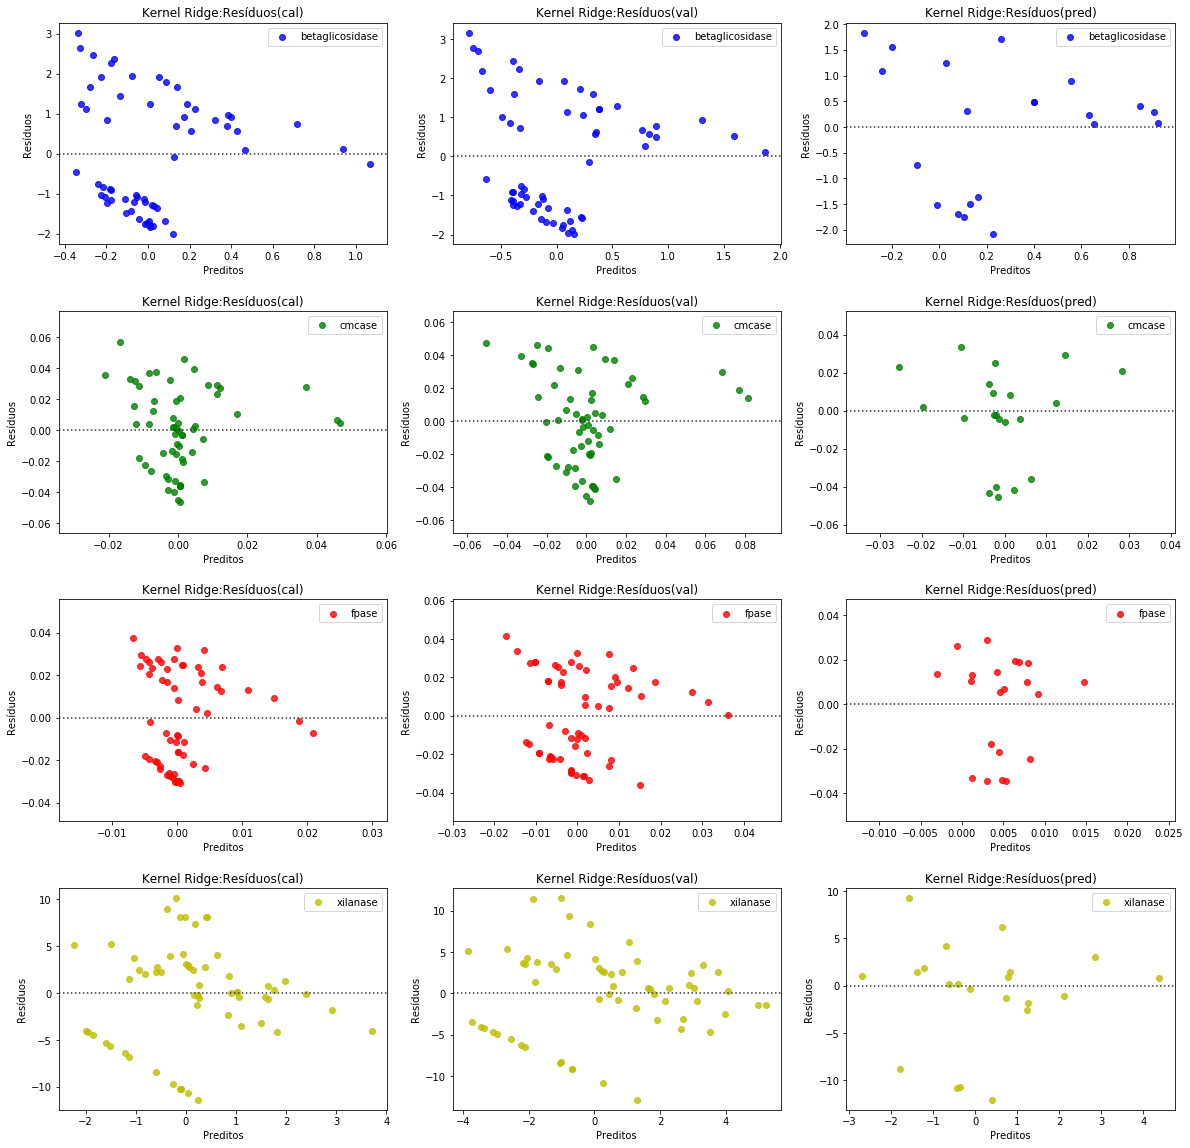

In [456]:
#gráfico dos resíduos
graficoResiduos(modelo, treino_teste, y_c,y_cv,y_p)

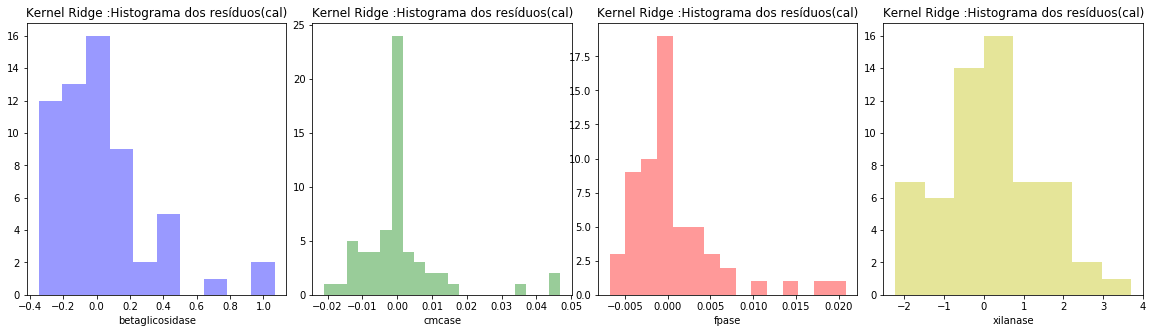

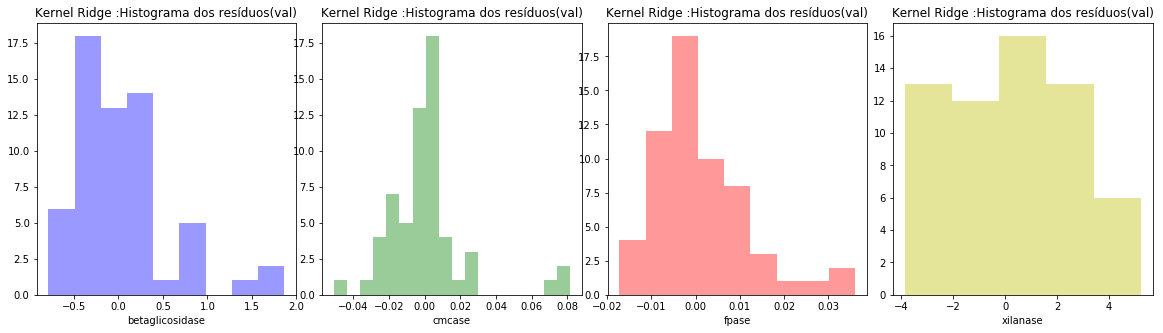

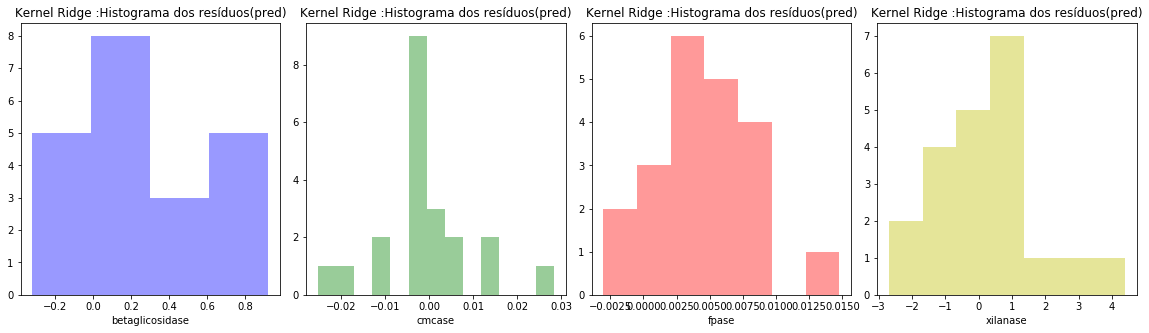

In [457]:
#histograma dos resíduos
graficoHist(modelo, treino_teste, y_c,y_cv,y_p)

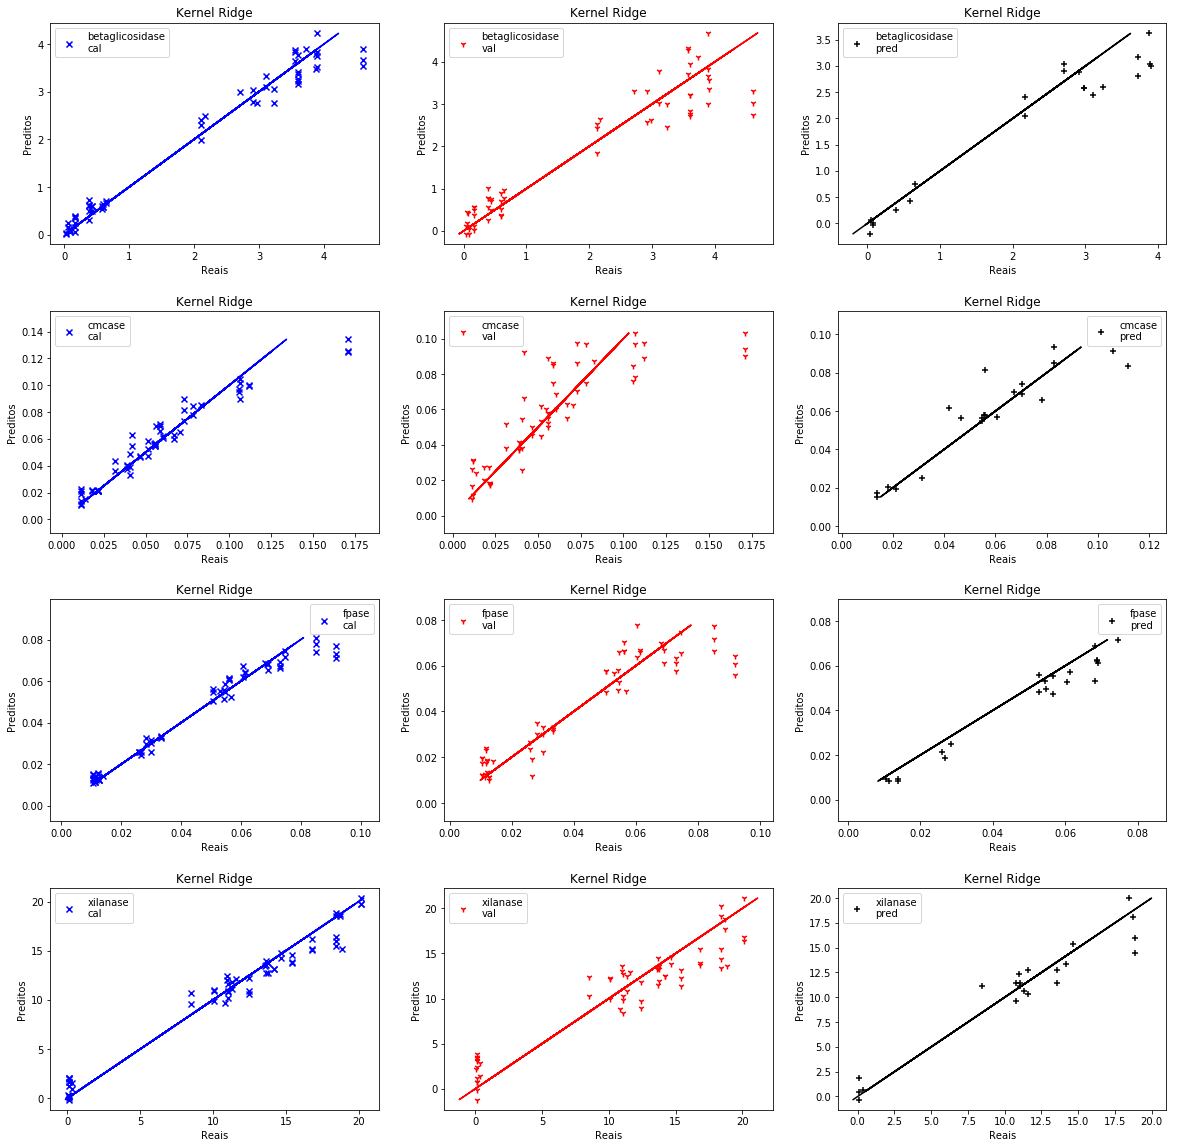

In [458]:
#graico de reais x preditos
graficoReaisPreditosSep(modelo, treino_teste, y_c,y_cv,y_p)

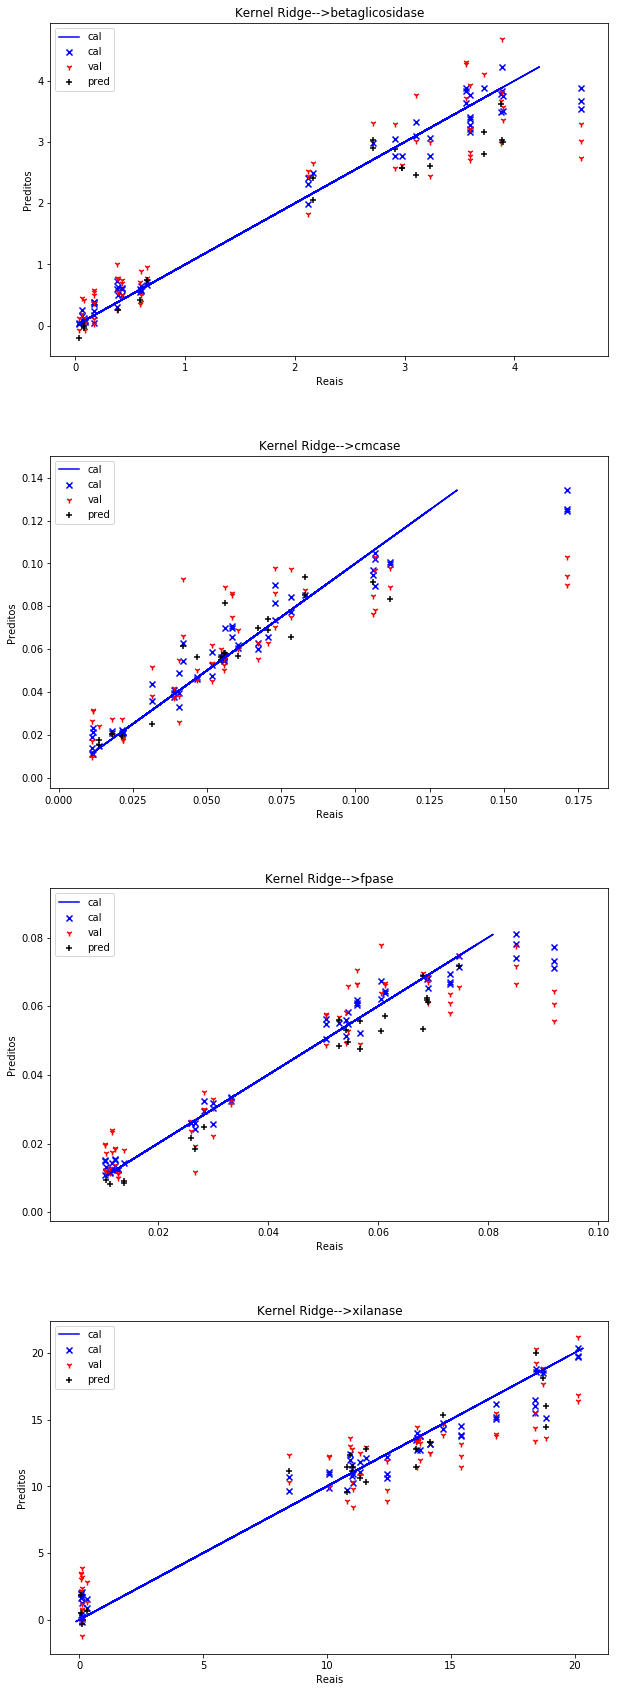

In [459]:
#graico de reais x preditos
graficoReaisPreditos(modelo, treino_teste, y_c,y_cv,y_p)

### Kernel Ridge: Gráficos: dados de treino

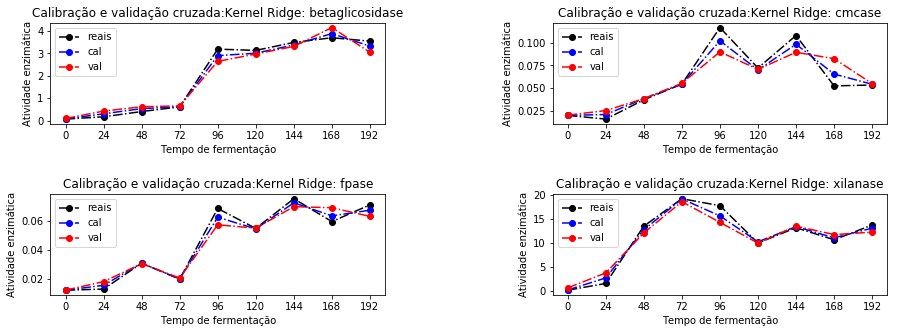

In [460]:
y_treino = treino_teste[2]
graficoTreinamento(modelo, y_treino, y_c,y_cv)

### Kernel  Ridge: Gráficos de  teste

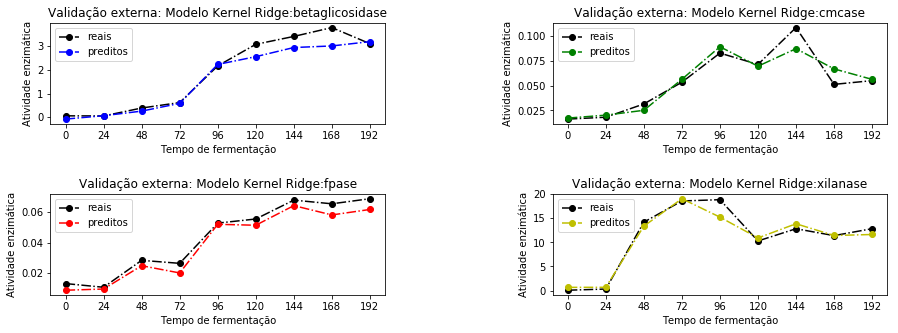

In [461]:
y_teste = treino_teste[3]
graficoTeste(modelo, y_teste, y_p)

## PCR: 

### PCR: função completa

In [225]:
#pcr função completa para execução do PCR:
#A variável preproc determinará o tipo de processamento que será executado (0,1,2,3,4)
def executaPCR(preproc=0, nPC=3, padroniza=False,IC=0):
    #separando o conjunto de dados em treino e teste
    
    #separando o conjunto de dados em treino e teste
    #x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,True)
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,padroniza, IC)

    
    # Roda o PCA e produz uma vaiável reduzida  e seleciona as primeiras componentes definidas pela variável nPc
    pca = PCA(n_components=nPC)
    x_treino = pca.fit_transform(x_treino)[:,:nPC]
    x_teste = pca.fit_transform(x_teste)[:,:nPC]    
    
    #Passo 2: Aplicar a regressão sobre as componentes selecionadas
    reg = MultiOutputRegressor(LinearRegression())
    result = executaCVP([x_treino, x_teste, y_treino, y_teste], reg)
    
    return result

    

### PCR: testes

In [226]:
#pcr teste diversificado
modelo = 'PCR'
for npc in range(2,5):
    for k in [1,2,10,11]:
        print('\nNº Componentes principais:',npc,'\n',preProc[k])
        result = executaPCR(k,npc)
        print('Parâmetros do modelo:',modelo,'\n',result[0])
        resultados=exibeResultados(result)

        for k,v in zip(resultados.keys(),resultados.values()):
            print(k)
            print(v,'\n-----------------------------------------------------')


Nº Componentes principais: 2 
 Pré-proc: 1--> Padronização
Parâmetros do modelo: PCR 
 MultiOutputRegressor(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
           n_jobs=None)
cal
      betaglicosidase     cmcase     fpase     xilanase
BIAS          -0.0000    -0.0000   -0.0000       0.0000
MSE       141664.8084  1715.7878  425.6850  181686.4365
R2             0.1487     0.1901    0.0942       0.0401
RER            7.7484     6.9465    7.9101       7.3690
RMSE         376.3839    41.4221   20.6321     426.2469
RPD            1.0838     1.1112    1.0507       1.0207
RPIQ           0.4162     0.7179    1.0594       1.1796
SEP          376.6617    41.4527   20.6474     426.5616 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS           0.0367    -0.0474   -0.0067      -0.4492
MSE       143285.9883  1735.1035  429.5009  183398.2882
R2             0.1389     0.1810

cal
      betaglicosidase     cmcase     fpase     xilanase
BIAS          -0.0000     0.0000   -0.0000       0.0000
MSE       135683.2187  1805.9198  431.3222  181103.6817
R2             0.1846     0.1476    0.0822       0.0432
RER            7.9173     6.7709    7.8583       7.3808
RMSE         368.3520    42.4961   20.7683     425.5628
RPD            1.1074     1.0831    1.0438       1.0223
RPIQ           0.4253     0.6997    1.0525       1.1815
SEP          368.6240    42.5275   20.7836     425.8770 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS          -0.0150    -0.0027    0.0038      -0.2178
MSE       138148.4894  1834.1792  436.5352  183355.8191
R2             0.1698     0.1343    0.0711       0.0313
RER            7.8464     6.7185    7.8112       7.3353
RMSE         371.6833    42.8273   20.8934     428.2007
RPD            1.0975     1.0747    1.0376       1.0160
RPIQ           0.4215     0.6943    1.046

Parâmetros do modelo: PCR 
 MultiOutputRegressor(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
           n_jobs=None)
cal
      betaglicosidase     cmcase     fpase     xilanase
BIAS          -0.0000    -0.0000    0.0000       0.0000
MSE       126902.5577  1706.4385  416.3307  170371.6988
R2             0.2374     0.1946    0.1141       0.0999
RER            8.1866     6.9655    7.9985       7.6097
RMSE         356.2339    41.3091   20.4042     412.7611
RPD            1.1451     1.1142    1.0624       1.0540
RPIQ           0.4397     0.7198    1.0712       1.2182
SEP          356.4969    41.3396   20.4192     413.0658 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS           0.5456     0.0213    0.0293       0.0575
MSE       129552.2825  1741.5873  422.5099  173437.8596
R2             0.2215     0.1780    0.1009       0.0837
RER            8.1025     6.8948    

In [384]:
#pcr teste simples
modelo = 'PCR'
result = executaPCR(preproc=10,nPC=4)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)
    
for k,v in zip(resultados.keys(),resultados.values()):
    print(k)
    print(v,'\n-----------------------------------------------------')

Parâmetros do modelo: PCR 
 MultiOutputRegressor(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
           n_jobs=None)
cal
      betaglicosidase  cmcase   fpase  xilanase
BIAS           0.0000  0.0000  0.0000    0.0000
MSE            0.4549  0.0008  0.0001   18.9031
R2             0.8245  0.4514  0.8287    0.5746
RER            6.7236  5.6070  7.5226    4.5762
RMSE           0.6744  0.0283  0.0107    4.3478
RPD            2.3872  1.3501  2.4158    1.5332
RPIQ           4.7903  1.5514  4.5781    2.0603
SEP            0.6801  0.0285  0.0108    4.3845 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS           0.0219  0.0007  0.0002    0.0395
MSE            0.5997  0.0010  0.0001   21.7903
R2             0.7687  0.2955  0.7842    0.5097
RER            5.8581  4.9489  6.7047    4.2624
RMSE           0.7744  0.0321  0.0121    4.6680
RPD            2.0791  1.1914  2.1528    1.4

In [385]:
#pcr otimizando
maior=[-1,-1,-1,-1]
maiorGerado=[0,0,0,0]
for i in range(100):
    result = executaPCR(preproc=10, nPC=4, IC=i)
    resultados=exibeResultados(result)
    r2 = resultados['val'].loc[resultados['val'].index=='R2']
    r = []
    for j in range(4):
        r.append(r2.iloc[:,j][0])
        if r[j]>maior[j]:
            maior[j] = r[j]
            maiorGerado[j]=i
    print('\r%d%% completos'%(i+1), end='')
print('\n','r2:',maior,'\nsemente: b c f x',maiorGerado)

100% completos
 r2: [0.889, 0.5887, 0.9224, 0.6119] 
semente: b c f x [76, 24, 24, 24]


In [408]:
#PCr teste otimizado
modelo = 'PCR:'
result = result = executaPCR(preproc=1,nPC=4,IC=24)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)

Parâmetros do modelo: PCR: 
 MultiOutputRegressor(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
           n_jobs=None)


In [409]:
resultados['cal']

betaglicosidase  cmcase   fpase  xilanase
BIAS           0.0000  0.0000  0.0000    0.0000
MSE            0.1920  0.0003  0.0001   16.3422
R2             0.9189  0.5715  0.8987    0.6021
RER            8.7551  5.4434  9.6236    4.9217
RMSE           0.4382  0.0183  0.0077    4.0426
RPD            3.5123  1.5277  3.1412    1.5853
RPIQ           7.2533  2.1218  6.3989    1.5347
SEP            0.4419  0.0185  0.0077    4.0767

In [410]:
resultados['val']

betaglicosidase  cmcase   fpase  xilanase
BIAS          -0.0159  0.0002 -0.0000   -0.0163
MSE            0.2300  0.0004  0.0001   19.3822
R2             0.9029  0.5136  0.8804    0.5281
RER            8.0039  5.1093  8.8571    4.5193
RMSE           0.4796  0.0195  0.0083    4.4025
RPD            3.2091  1.4338  2.8910    1.4557
RPIQ           6.6273  1.9914  5.8891    1.4092
SEP            0.4833  0.0197  0.0084    4.4396

In [411]:
resultados['pred']

betaglicosidase  cmcase   fpase  xilanase
BIAS           0.2201  0.0172  0.0038    1.4274
MSE            1.3604  0.0018  0.0002   30.4087
R2             0.5382  0.2525  0.6844    0.2866
RER            3.8752  4.0015  5.1953    3.6725
RMSE           1.1664  0.0427  0.0158    5.5144
RPD            1.4715  1.1566  1.7802    1.1839
RPIQ           2.8587  1.0300  2.6712    1.2175
SEP            1.1737  0.0400  0.0157    5.4580

In [390]:
reg, treino_teste,y_c,y_cv,y_p = result

###  Reais x preditos

In [391]:
#ridge reaisxpreditos
#calibração
pred=pd.DataFrame(y_c, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('CALIBRAÇÃO:\n')
round(reais_pred,4)

CALIBRAÇÃO:



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            3.5967  0.1065  0.0850   13.6476                 3.9144   
1            0.4280  0.0390  0.0334   13.7624                 0.6673   
2            0.0759  0.0136  0.0139    0.0726                 0.2257   
3            3.8876  0.0418  0.0605   11.0267                 3.8933   
4            0.6010  0.0559  0.0116   20.1368                 0.5951   
5            3.1068  0.0781  0.0545   11.0526                 2.7369   
6            2.1150  0.0730  0.0505   18.4127                 1.7882   
7            2.1643  0.0830  0.0529   18.8324                 1.7528   
8            2.9774  0.0704  0.0567   10.8002                 2.9361   
9            3.8803  0.0557  0.0691   11.3256                 3.1934   
10           3.5974  0.0516  0.0731   15.3973                 2.6009   
11           0.3900  0.0315  0.0283   14.1777                 0.9024   
12           0.6010  0.0559  0.0116   20.1368                 0.5468   
13           0.0874  0.0217  0.0127    0.1071                 0.1108   
14           0.3900  0.0315  0.0283   14.1777                 0.8960   
15           2.9774  0.0704  0.0567   10.8002                 2.6872   
16           2.9774  0.0704  0.0567   10.8002                 3.0056   
17           0.3828  0.0405  0.0301   12.4461                 0.7124   
18           0.0308  0.0213  0.0113    0.0996                -0.0610   
19           3.7243  0.0561  0.0681   11.5736                 3.6104   
20           2.1643  0.0830  0.0529   18.8324                 1.8977   
21           3.2342  0.0672  0.0543    8.4772                 2.5644   
22           2.9123  0.1058  0.0747   14.6813                 3.6457   
23           3.8803  0.0557  0.0691   11.3256                 3.3255   
24           3.5974  0.0516  0.0731   15.3973                 2.4499   
25           3.2342  0.0672  0.0543    8.4772                 2.7236   
26           3.5967  0.1065  0.0850   13.6476                 4.0044   
27           0.6491  0.0605  0.0260   18.4274                 0.7946   
28           3.8876  0.0418  0.0605   11.0267                 4.1390   
29           3.8876  0.0418  0.0605   11.0267                 3.8556   
30           0.0554  0.0181  0.0106    0.3275                 0.3115   
31           3.7243  0.0561  0.0681   11.5736                 3.7439   
32           3.1068  0.0781  0.0545   11.0526                 2.8587   
33           3.8994  0.1118  0.0613   10.9512                 3.4454   
34           3.5610  0.0586  0.0561   10.0978                 4.0652   
35           3.1068  0.0781  0.0545   11.0526                 2.6236   
36           2.9123  0.1058  0.0747   14.6813                 3.7953   
37           2.7110  0.0548  0.0688   13.5829                 3.1525   
38           3.5974  0.0516  0.0731   15.3973                 2.4601   
39           0.0759  0.0136  0.0139    0.0726                -0.0427   
40           3.8994  0.1118  0.0613   10.9512                 3.6364   
41           2.9123  0.1058  0.0747   14.6813                 3.6092   
42           2.7110  0.0548  0.0688   13.5829                 3.2801   
43           0.5905  0.0465  0.0267   18.7095                 0.4155   
44           0.1671  0.0117  0.0104    0.1117                 0.4406   
45           0.0874  0.0217  0.0127    0.1071                 0.0899   
46           0.6491  0.0605  0.0260   18.4274                 0.7626   
47           0.5905  0.0465  0.0267   18.7095                 0.7045   
48           0.4280  0.0390  0.0334   13.7624                 0.4906   
49           0.0759  0.0136  0.0139    0.0726                 0.0485   
50           0.3828  0.0405  0.0301   12.4461                 1.1024   
51           0.1724  0.0112  0.0121    0.0924                 0.2232   
52           0.0554  0.0181  0.0106    0.3275                 0.4861   
53           0.0308  0.0213  0.0113    0.0996                 0.1084   
54           0.0874  0.0217  0.0127    0.107

In [392]:
#validação
pred=pd.DataFrame(y_cv, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('VALIDAÇÃO CRUZADA:\n')
round(reais_pred,4)


VALIDAÇÃO CRUZADA:



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            3.5967  0.1065  0.0850   13.6476                 3.9194   
1            0.4280  0.0390  0.0334   13.7624                 0.6755   
2            0.0759  0.0136  0.0139    0.0726                 0.2414   
3            3.8876  0.0418  0.0605   11.0267                 3.8973   
4            0.6010  0.0559  0.0116   20.1368                 0.5957   
5            3.1068  0.0781  0.0545   11.0526                 2.7439   
6            2.1150  0.0730  0.0505   18.4127                 1.8063   
7            2.1643  0.0830  0.0529   18.8324                 1.7314   
8            2.9774  0.0704  0.0567   10.8002                 2.9511   
9            3.8803  0.0557  0.0691   11.3256                 3.0660   
10           3.5974  0.0516  0.0731   15.3973                 2.4312   
11           0.3900  0.0315  0.0283   14.1777                 0.8987   
12           0.6010  0.0559  0.0116   20.1368                 0.5243   
13           0.0874  0.0217  0.0127    0.1071                 0.1201   
14           0.3900  0.0315  0.0283   14.1777                 0.9519   
15           2.9774  0.0704  0.0567   10.8002                 2.6929   
16           2.9774  0.0704  0.0567   10.8002                 2.9973   
17           0.3828  0.0405  0.0301   12.4461                 0.7767   
18           0.0308  0.0213  0.0113    0.0996                -0.1248   
19           3.7243  0.0561  0.0681   11.5736                 3.5535   
20           2.1643  0.0830  0.0529   18.8324                 1.8317   
21           3.2342  0.0672  0.0543    8.4772                 2.4899   
22           2.9123  0.1058  0.0747   14.6813                 3.7339   
23           3.8803  0.0557  0.0691   11.3256                 3.3671   
24           3.5974  0.0516  0.0731   15.3973                 2.3456   
25           3.2342  0.0672  0.0543    8.4772                 2.7577   
26           3.5967  0.1065  0.0850   13.6476                 4.0194   
27           0.6491  0.0605  0.0260   18.4274                 0.8096   
28           3.8876  0.0418  0.0605   11.0267                 4.1690   
29           3.8876  0.0418  0.0605   11.0267                 3.8889   
30           0.0554  0.0181  0.0106    0.3275                 0.3196   
31           3.7243  0.0561  0.0681   11.5736                 3.7234   
32           3.1068  0.0781  0.0545   11.0526                 2.8362   
33           3.8994  0.1118  0.0613   10.9512                 3.4188   
34           3.5610  0.0586  0.0561   10.0978                 4.0346   
35           3.1068  0.0781  0.0545   11.0526                 2.6053   
36           2.9123  0.1058  0.0747   14.6813                 3.9839   
37           2.7110  0.0548  0.0688   13.5829                 3.2878   
38           3.5974  0.0516  0.0731   15.3973                 2.5795   
39           0.0759  0.0136  0.0139    0.0726                -0.0494   
40           3.8994  0.1118  0.0613   10.9512                 3.6722   
41           2.9123  0.1058  0.0747   14.6813                 3.7832   
42           2.7110  0.0548  0.0688   13.5829                 3.3226   
43           0.5905  0.0465  0.0267   18.7095                 0.4357   
44           0.1671  0.0117  0.0104    0.1117                 0.4732   
45           0.0874  0.0217  0.0127    0.1071                 0.0911   
46           0.6491  0.0605  0.0260   18.4274                 0.7839   
47           0.5905  0.0465  0.0267   18.7095                 0.7144   
48           0.4280  0.0390  0.0334   13.7624                 0.6243   
49           0.0759  0.0136  0.0139    0.0726                 0.0659   
50           0.3828  0.0405  0.0301   12.4461                 1.2022   
51           0.1724  0.0112  0.0121    0.0924                 0.3661   
52           0.0554  0.0181  0.0106    0.3275                 0.6180   
53           0.0308  0.0213  0.0113    0.0996                 0.1181   
54           0.0874  0.0217  0.0127    0.107

In [393]:
#predição
pred=pd.DataFrame(y_p, columns=var_ae)
reais = treino_teste[3]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('Predição (validação externa):\n')
round(reais_pred,4)

Predição (validação externa):



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            2.1643  0.0830  0.0529   18.8324                 2.8688   
1            3.5610  0.0586  0.0561   10.0978                 2.7516   
2            0.1671  0.0117  0.0104    0.1117                 0.5042   
3            3.8994  0.1118  0.0613   10.9512                 3.0944   
4            4.6037  0.1713  0.0919   16.8115                 3.9320   
5            0.4280  0.0390  0.0334   13.7624                 0.9046   
6            0.3900  0.0315  0.0283   14.1777                 1.6797   
7            3.5967  0.1065  0.0850   13.6476                 3.4253   
8            0.6010  0.0559  0.0116   20.1368                -1.4185   
9            0.1671  0.0117  0.0104    0.1117                 0.9426   
10           3.8803  0.0557  0.0691   11.3256                 3.4190   
11           0.6491  0.0605  0.0260   18.4274                -0.5173   
12           2.1150  0.0730  0.0505   18.4127                 2.1520   
13           3.7243  0.0561  0.0681   11.5736                 1.4824   
14           0.1724  0.0112  0.0121    0.0924                 0.5743   
15           4.6037  0.1713  0.0919   16.8115                 3.4638   
16           3.2342  0.0672  0.0543    8.4772                 1.4197   
17           0.3828  0.0405  0.0301   12.4461                 2.3244   
18           4.6037  0.1713  0.0919   16.8115                 3.4534   
19           2.1150  0.0730  0.0505   18.4127                 2.2057   
20           0.0554  0.0181  0.0106    0.3275                 1.8299   

    pred: cmcase  pred: fpase  pred: xilanase  
0         0.0620       0.0627         11.2042  
1         0.0678       0.0493         13.6731  
2         0.0290       0.0224          6.0890  
3         0.0716       0.0587         14.5006  
4         0.0815       0.0726         12.4542  
5         0.0343       0.0294          7.1377  
6         0.0465       0.0388          7.8813  
7         0.0762       0.0654         14.8739  
8         0.0185      -0.0028         11.1867  
9         0.0377       0.0238          5.5414  
10        0.0803       0.0565         13.3037  
11        0.0355       0.0046         12.0289  
12        0.0496       0.0578         11.4825  
13        0.0489       0.0384         14.7737  
14        0.0312       0.0213          5.1490  
15        0.0718       0.0699         12.0975  
16        0.0440       0.0408         12.6059  
17        0.0573       0.0448          7.1027  
18        0.0715       0.0698         11.8626  
19        0.0509       0.0569         11.0232  
20        0.0513       0.0352          5.8110

###  PCR: Gráficos de resíduos - histograma - reais x preditos

In [412]:
#título para os gráficos
modelo = 'PCR'

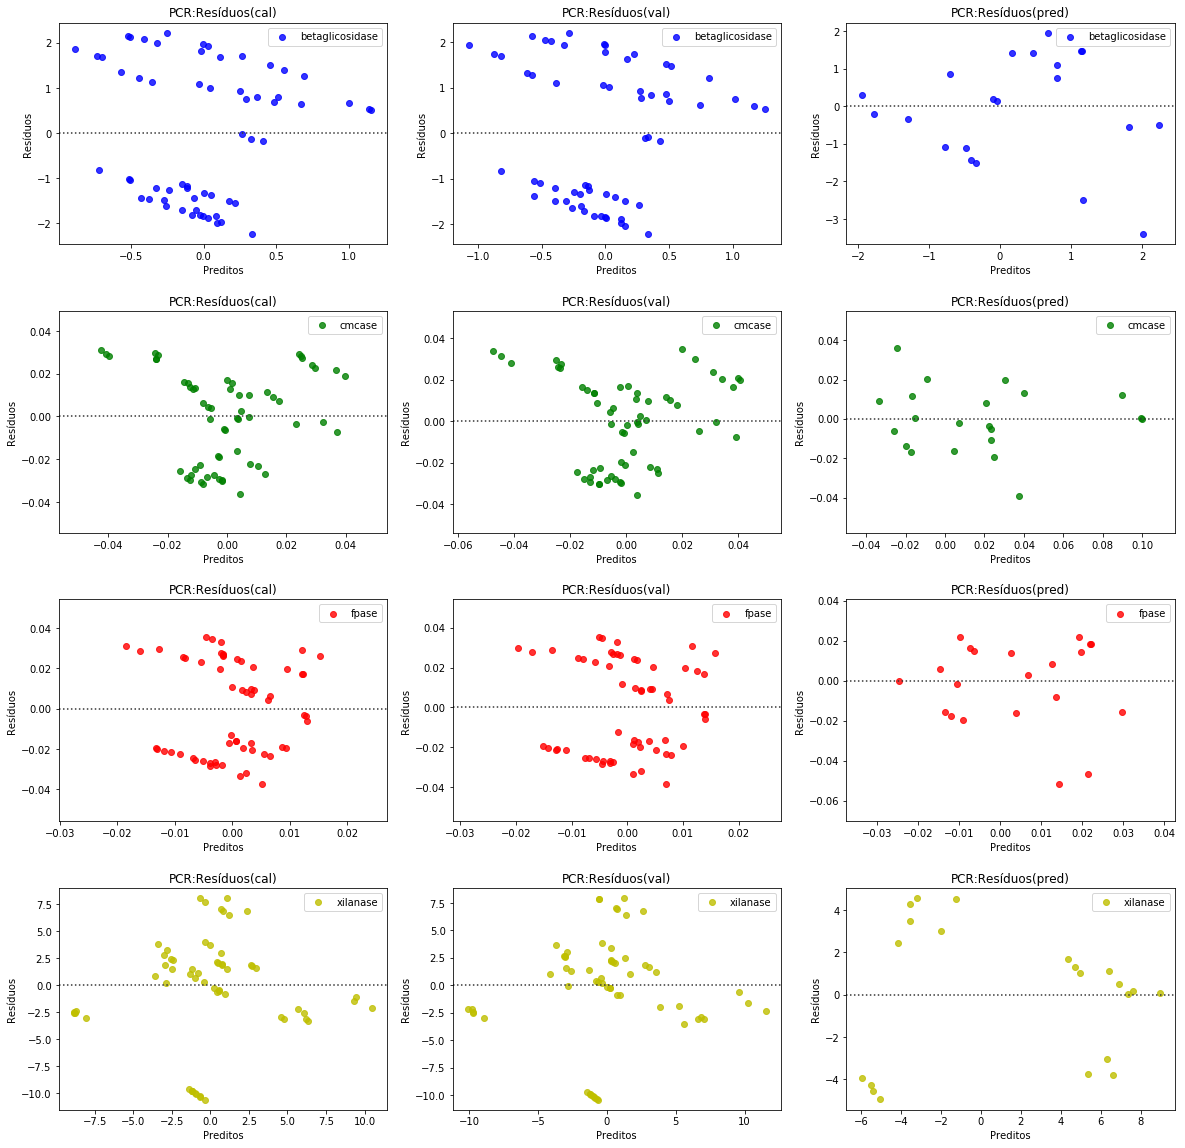

In [395]:
#gráfico dos resíduos
graficoResiduos(modelo, treino_teste, y_c,y_cv,y_p)

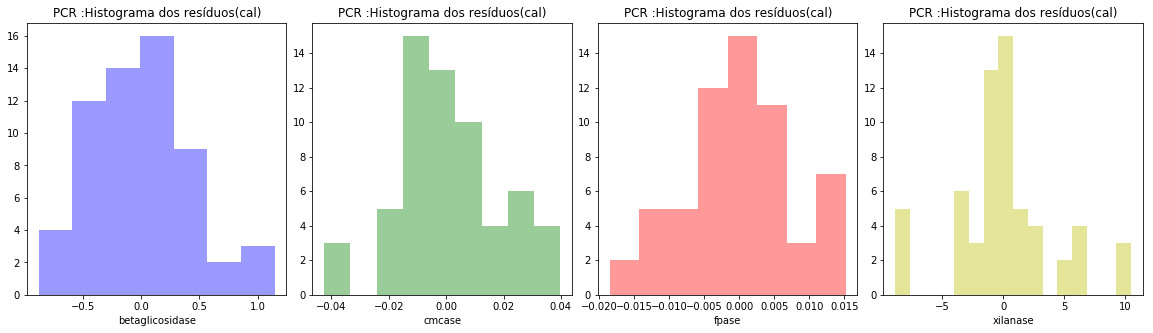

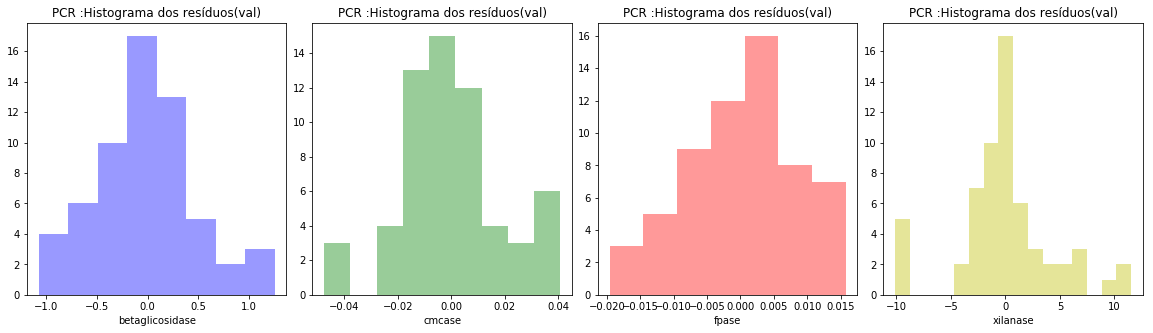

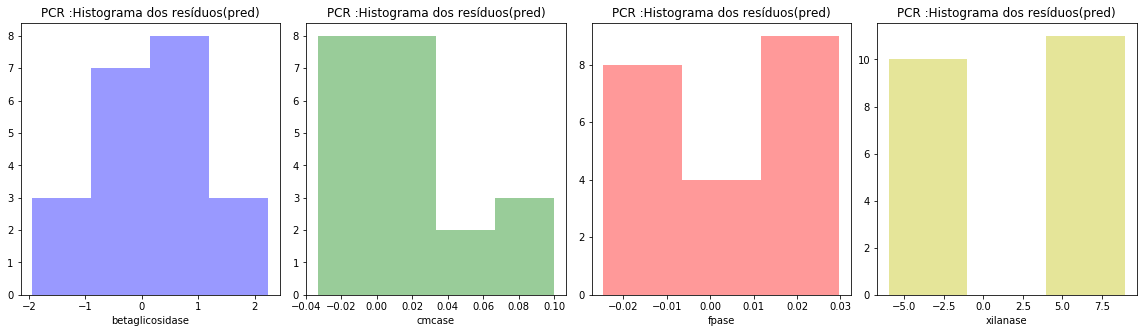

In [396]:
#histograma dos resíduos
graficoHist(modelo, treino_teste, y_c,y_cv,y_p)

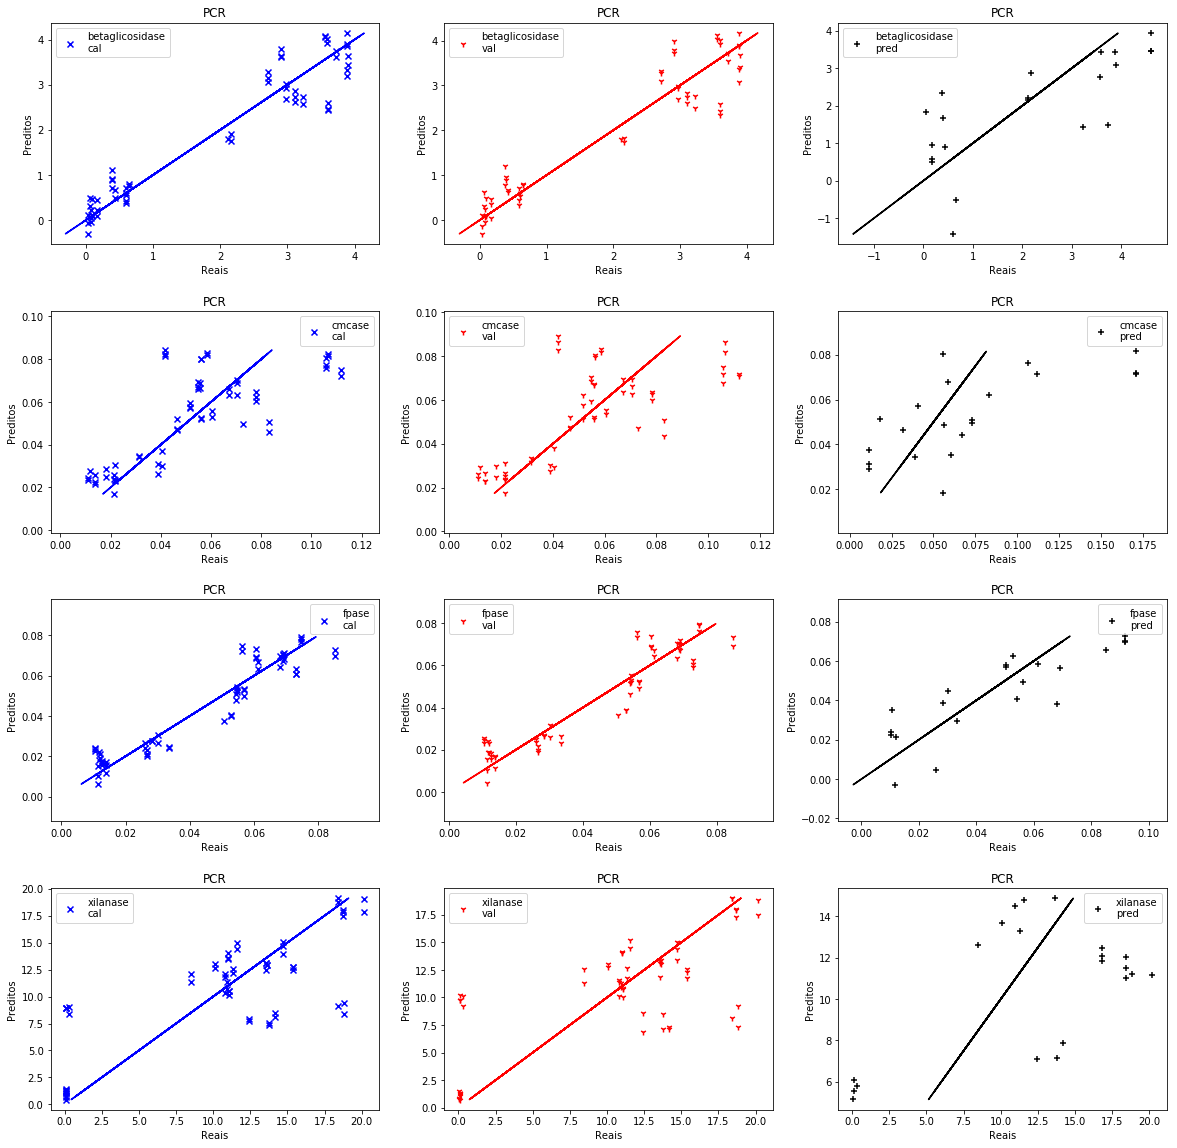

In [397]:
#graico de reais x preditos
graficoReaisPreditosSep(modelo, treino_teste, y_c,y_cv,y_p)

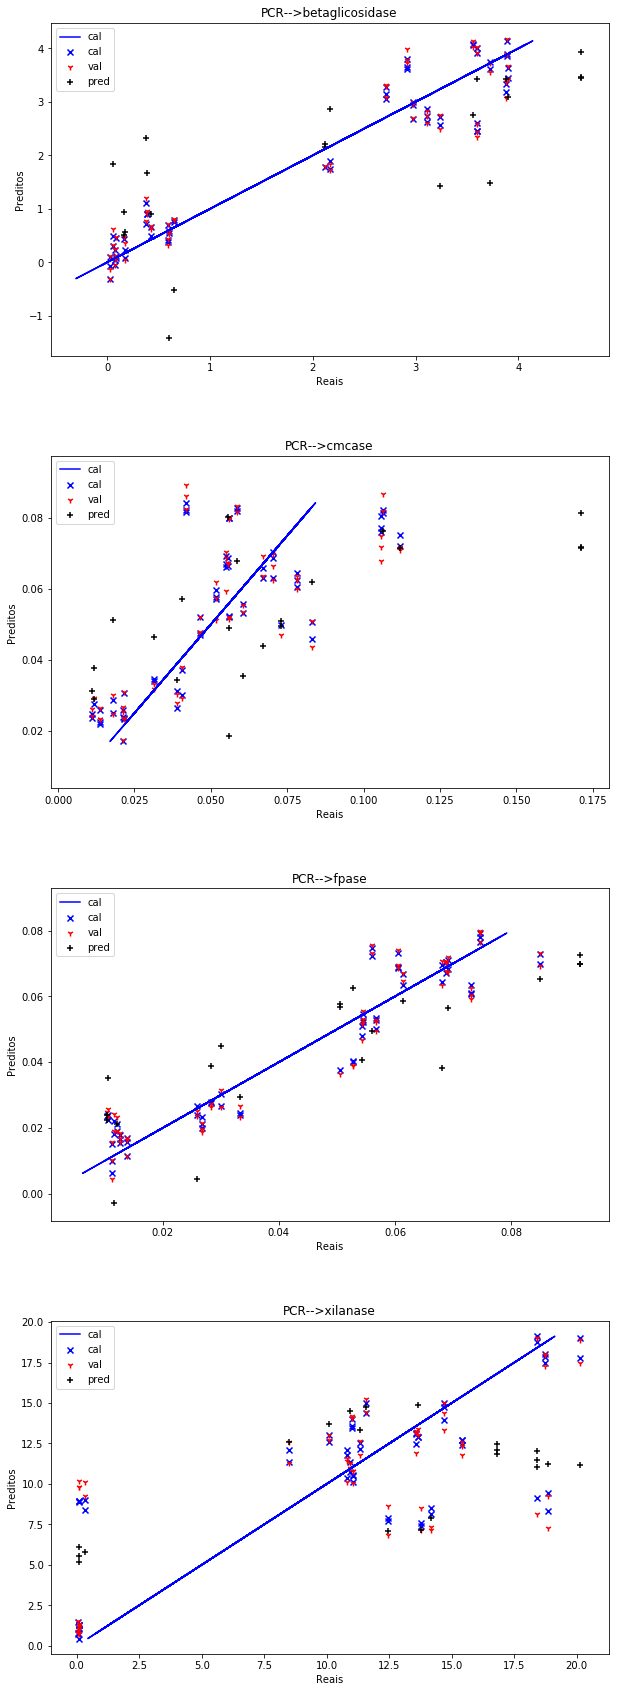

In [398]:
#graico de reais x preditos
graficoReaisPreditos(modelo, treino_teste, y_c,y_cv,y_p)

### PCR: Gráficos: dados de treino

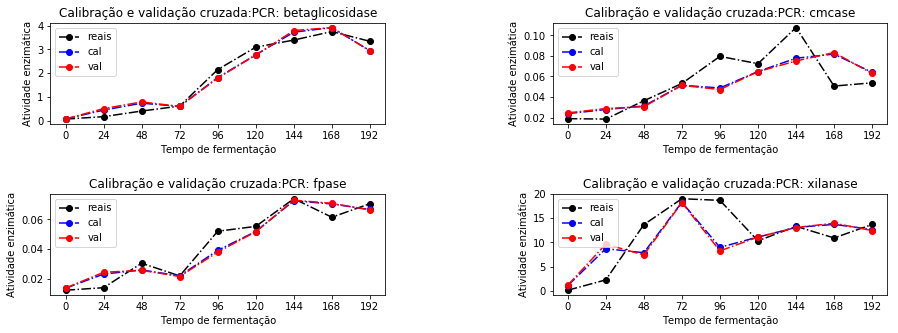

In [399]:
y_treino = treino_teste[2]
graficoTreinamento(modelo, y_treino, y_c,y_cv)

### PCR: Gráficos de  teste

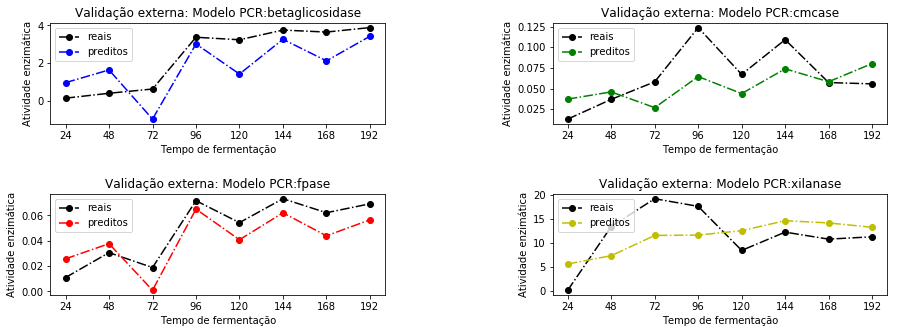

In [400]:
y_teste = treino_teste[3]
graficoTeste(modelo, y_teste, y_p)

## Kernel PCA: 

### Kernel PCA: função completa

In [463]:
#kernelpca
#função completa para execução do Kernel PCA:
#A variável preproc determinará o tipo de processamento que será executado (0,1,2,3,4)
def executaKPCA(preproc=1, nPC=3, tk='linear', ic=0):
    #separando o conjunto de dados em treino e teste
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,False,ic)

    
    # Define um objeto Kernel PCA
    kpca = KernelPCA(n_components=nPC, kernel =tk)
       
    x_treino = kpca.fit_transform(x_treino)[:,:nPC]
    x_teste = kpca.fit_transform(x_teste)[:,:nPC]    
    
    #Passo 2: Aplicar a regressão sobre as componentes selecionadas

    # Cria um objeto de regressão linear
    reg = LinearRegression()

    result = executaCVP([x_treino, x_teste, y_treino, y_teste], reg)
    
    return result

    

###  Kernel PCA: testes

In [472]:
list(np.arange(1,10))

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [477]:
#kernelpca otimização parte 1
varKernel = ['linear','poly','rbf','sigmoid','cosine', 'precomputed']
for pre, valor in zip(preProc.keys(), preProc.values()):
    maior=[-100,-100,-100,-100]
    #maiorGerado=[0,0,0,0]
    componentes=[0,0,0,0]
    tipokernel=['0','0','0','0']
    print(valor)
    for cp, k in zip(list(np.arange(2,7)),varKernel):
        result = executaKPCA(pre,cp,k)
        resultados=exibeResultados(result)
        r2 = resultados['pred'].loc[resultados['pred'].index=='R2']
        r = []
        for j in range(4):
            r.append(r2.iloc[:,j][0])
            if r[j]>maior[j]:
                maior[j] = r[j]
                componentes[j]=cp
                tipokernel[j]=k
        print('\r%d%% completos'%(i+1), end='')
    print('\n','r2 ( b c f x ):',maior,'\ncomponentes:',componentes,'\nKernel:',tipokernel)
    print('------------------------')

Pré-proc: 0--> Sem pré-processamento
100% completos
 r2 ( b c f x ): [-1.0111, -0.3975, -1.0074, 0.4296] 
componentes: [6, 3, 3, 6] 
Kernel: ['cosine', 'poly', 'poly', 'cosine']
------------------------
Pré-proc: 1--> Padronização
100% completos
 r2 ( b c f x ): [-0.1511, -0.118, -0.5021, 0.4803] 
componentes: [5, 3, 3, 2] 
Kernel: ['sigmoid', 'poly', 'poly', 'linear']
------------------------
Pré-proc: 2--> Suavização(SavGol) - Par:3,1,1
100% completos
 r2 ( b c f x ): [-0.9054, -0.2866, -0.8782, 0.5751] 
componentes: [4, 2, 3, 3] 
Kernel: ['rbf', 'linear', 'poly', 'poly']
------------------------
Pré-proc: 3--> Suavização(SavGol) - Par:3,2,1
100% completos
 r2 ( b c f x ): [-0.9508, -0.2835, -0.8917, 0.1019] 
componentes: [2, 2, 2, 2] 
Kernel: ['linear', 'linear', 'linear', 'linear']
------------------------
Pré-proc: 4--> Suavização(SavGol) - Par:5,1,1
100% completos
 r2 ( b c f x ): [-0.9255, -0.2854, -0.8937, 0.5553] 
componentes: [3, 3, 2, 5] 
Kernel: ['poly', 'poly', 'linear', '

In [485]:
#kernelpca otimizado
maior=[-1,-1,-1,-1]
maiorGerado=[0,0,0,0]
componentes=[0,0,0,0]
tipokernel=[0,0,0,0]
for i in range(100):
    result = executaKPCA(8,6,'cosine',ic=i)
    resultados=exibeResultados(result)
    r2 = resultados['pred'].loc[resultados['pred'].index=='R2']
    r = []
    for j in range(4):
        r.append(r2.iloc[:,j][0])
        if r[j]>maior[j]:
            maior[j] = r[j]
            maiorGerado[j]=i
    print('\r%d%% completos'%(i+1), end='')
print('\n','r2:',maior,'\nsemente: b c f x',maiorGerado)

100% completos
 r2: [0.8357, 0.4321, 0.812, 0.6554] 
semente: b c f x [3, 3, 0, 99]


## MLR: função completa

In [228]:
#mlr
#função completa para execução do MLR:
#A variável preproc determinará o tipo de processamento que será executado (0,1,2,3)
def executaMLR(preproc=1, param=False,IC=0):
    
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,param, IC)
        
      
    # Cria um objeto de regressão linear
    reg = MultiOutputRegressor(LinearRegression())
    #reg = LinearRegression()


    result = executaCVP([x_treino, x_teste, y_treino, y_teste], reg)
    
    return result


### MLR: testes

In [229]:
#mlr teste variando o tipo de préprocessamento
modelo = 'MLR'
for k in range(12):
    
    result = executaMLR(k)
    print('Parâmetros do modelo:',modelo,'\n',result[0])
    print(preProc[k])

    resultados=exibeResultados(result)
    
    for k,v in zip(resultados.keys(),resultados.values()):
        print(k)
        print(v,'\n-----------------------------------------------------')

 

Parâmetros do modelo: MLR 
 MultiOutputRegressor(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
           n_jobs=None)
Pré-proc: 0--> Sem pré-processamento
cal
      betaglicosidase   cmcase    fpase   xilanase
BIAS          -0.0000   0.0000  -0.0000    -0.0000
MSE         4688.5067  43.6195  19.7145  8126.1714
R2             0.9718   0.9794   0.9580     0.9571
RER           42.5916  43.5667  36.7565    34.8437
RMSE          68.4727   6.6045   4.4401    90.1453
RPD            5.9576   6.9693   4.8824     4.8263
RPIQ           2.2877   4.5024   4.9228     5.5778
SEP           68.5232   6.6094   4.4434    90.2118 
-----------------------------------------------------
val
      betaglicosidase     cmcase      fpase      xilanase
BIAS         -31.3579     3.0600     0.8362  7.030700e+00
MSE       808177.8184  7175.7288  3392.8449  1.357195e+06
R2            -3.8567    -2.3870    -6.2196 -6.170200e+00
RER            3.2460     3.3990    

Parâmetros do modelo: MLR 
 MultiOutputRegressor(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
           n_jobs=None)
Pré-proc: 5--> Suavização(SavGol) - Par:5,2,1
cal
      betaglicosidase   cmcase    fpase   xilanase
BIAS           0.0547  -0.2616  -0.0692    -1.8532
MSE         4965.0105  43.4770  20.2375  8327.2720
R2             0.9702   0.9795   0.9569     0.9560
RER           41.3886  43.6724  36.2828    34.4275
RMSE          70.4628   6.5937   4.4986    91.2539
RPD            5.7893   6.9807   4.8189     4.7677
RPIQ           2.2231   4.5097   4.8588     5.5101
SEP           70.5148   6.5934   4.5014    91.3024 
-----------------------------------------------------
val
      betaglicosidase     cmcase      fpase      xilanase
BIAS         -29.6746     3.4995     0.8253  1.108900e+01
MSE       819592.3081  6875.6579  3269.4118  1.328107e+06
R2            -3.9252    -2.2453    -5.9570 -6.016500e+00
RER            3.2231     3

Parâmetros do modelo: MLR 
 MultiOutputRegressor(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
           n_jobs=None)
Pré-proc: 10--> MSC
cal
      betaglicosidase   cmcase    fpase   xilanase
BIAS         -12.7146   0.3690   1.1703    10.4906
MSE         5063.5920  44.1340  21.8314  9297.2748
R2             0.9696   0.9792   0.9535     0.9509
RER           41.6541  43.3789  36.0790    32.7699
RMSE          71.1589   6.6433   4.6724    96.4224
RPD            5.7327   6.9285   4.6396     4.5121
RPIQ           2.2014   4.4760   4.6780     5.2147
SEP           70.0655   6.6380   4.5268    95.9208 
-----------------------------------------------------
val
      betaglicosidase     cmcase      fpase      xilanase
BIAS         -12.9052     1.7657     0.3495  5.051000e+00
MSE       887499.9974  8166.0940  4124.5220  1.436595e+06
R2            -4.3333    -2.8544    -7.7766 -6.589600e+00
RER            3.0960     3.1847     2.5412  2.620600

In [230]:
#MLR otimizado
maior=[-1,-1,-1,-1]
maiorGerado=[0,0,0,0]
for i in range(100):
    result = executaMLR(preproc=10,IC=i)
    resultados=exibeResultados(result)
    r2 = resultados['pred'].loc[resultados['pred'].index=='R2']
    r = []
    for j in range(4):
        r.append(r2.iloc[:,j][0])
        if r[j]>maior[j]:
            maior[j] = r[j]
            maiorGerado[j]=i
    print('\r%d%% completos'%(i+1), end='')
print('\n','r2:',maior,'\nsemente: b c f x',maiorGerado)

100% completos
 r2: [-1, -1, -1, -1] 
semente: b c f x [0, 0, 0, 0]


In [511]:
#MLR teste otimizado
modelo = 'MLR:'
result = executaMLR(preproc=10,IC=60)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)

Parâmetros do modelo: MLR: 
 MultiOutputRegressor(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
           n_jobs=None)


In [512]:
resultados['cal']

betaglicosidase        cmcase         fpase      xilanase
BIAS    -0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
MSE      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
R2       1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00
RER      3.393416e+13  2.812467e+13  3.794781e+13  4.552278e+13
RMSE     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
RPD      9.934017e+12  5.236136e+12  1.192271e+13  7.192764e+12
RPIQ     2.024224e+13  4.882883e+12  1.964092e+13  7.031981e+12
SEP      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00

In [513]:
resultados['val']

betaglicosidase  cmcase   fpase  xilanase
BIAS           0.0128 -0.0002 -0.0005   -0.1889
MSE            0.9650  0.0021  0.0004   10.5681
R2             0.6010 -0.6036  0.4440    0.7205
RER            4.6166  3.4236  4.2674    6.1307
RMSE           0.9823  0.0464  0.0189    3.2509
RPD            1.5831  0.7897  1.3412    1.8914
RPIQ           3.2258  0.7364  2.2094    1.8492
SEP            0.9905  0.0468  0.0191    3.2728

In [514]:
resultados['pred']

betaglicosidase  cmcase   fpase  xilanase
BIAS          -0.0148 -0.0033  0.0012    0.7844
MSE            0.5523  0.0012  0.0001   19.1697
R2             0.8007 -0.3268  0.7779    0.5015
RER            5.0810  2.8679  5.4943    4.1585
RMSE           0.7432  0.0342  0.0112    4.3783
RPD            2.2401  0.8682  2.1218    1.4163
RPIQ           4.5667  1.1446  4.2755    2.5612
SEP            0.7614  0.0349  0.0114    4.4138

In [515]:
reg, treino_teste,y_c,y_cv,y_p = result

### Reais x preditos

In [516]:
#pls reaisxpreditos
#calibração
pred=pd.DataFrame(y_c, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('CALIBRAÇÃO:\n')
round(reais_pred,4)

CALIBRAÇÃO:



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            0.0308  0.0213  0.0113    0.0996                 0.0308   
1            0.4280  0.0390  0.0334   13.7624                 0.4280   
2            2.9774  0.0704  0.0567   10.8002                 2.9774   
3            3.8876  0.0418  0.0605   11.0267                 3.8876   
4            3.2342  0.0672  0.0543    8.4772                 3.2342   
5            0.4280  0.0390  0.0334   13.7624                 0.4280   
6            0.5905  0.0465  0.0267   18.7095                 0.5905   
7            2.1643  0.0830  0.0529   18.8324                 2.1643   
8            2.9123  0.1058  0.0747   14.6813                 2.9123   
9            0.0759  0.0136  0.0139    0.0726                 0.0759   
10           3.5967  0.1065  0.0850   13.6476                 3.5967   
11           3.8803  0.0557  0.0691   11.3256                 3.8803   
12           0.4280  0.0390  0.0334   13.7624                 0.4280   
13           3.5967  0.1065  0.0850   13.6476                 3.5967   
14           0.0554  0.0181  0.0106    0.3275                 0.0554   
15           0.3828  0.0405  0.0301   12.4461                 0.3828   
16           2.9774  0.0704  0.0567   10.8002                 2.9774   
17           0.1724  0.0112  0.0121    0.0924                 0.1724   
18           3.2342  0.0672  0.0543    8.4772                 3.2342   
19           0.3828  0.0405  0.0301   12.4461                 0.3828   
20           0.0554  0.0181  0.0106    0.3275                 0.0554   
21           0.6010  0.0559  0.0116   20.1368                 0.6010   
22           0.0759  0.0136  0.0139    0.0726                 0.0759   
23           3.7243  0.0561  0.0681   11.5736                 3.7243   
24           4.6037  0.1713  0.0919   16.8115                 4.6037   
25           0.0874  0.0217  0.0127    0.1071                 0.0874   
26           3.5974  0.0516  0.0731   15.3973                 3.5974   
27           0.6491  0.0605  0.0260   18.4274                 0.6491   
28           2.9123  0.1058  0.0747   14.6813                 2.9123   
29           2.1643  0.0830  0.0529   18.8324                 2.1643   
30           0.6491  0.0605  0.0260   18.4274                 0.6491   
31           0.3900  0.0315  0.0283   14.1777                 0.3900   
32           3.5610  0.0586  0.0561   10.0978                 3.5610   
33           0.6010  0.0559  0.0116   20.1368                 0.6010   
34           2.7110  0.0548  0.0688   13.5829                 2.7110   
35           4.6037  0.1713  0.0919   16.8115                 4.6037   
36           3.1068  0.0781  0.0545   11.0526                 3.1068   
37           3.5967  0.1065  0.0850   13.6476                 3.5967   
38           0.3900  0.0315  0.0283   14.1777                 0.3900   
39           2.1150  0.0730  0.0505   18.4127                 2.1150   
40           3.5974  0.0516  0.0731   15.3973                 3.5974   
41           4.6037  0.1713  0.0919   16.8115                 4.6037   
42           2.1150  0.0730  0.0505   18.4127                 2.1150   
43           3.1068  0.0781  0.0545   11.0526                 3.1068   
44           0.6010  0.0559  0.0116   20.1368                 0.6010   
45           2.9123  0.1058  0.0747   14.6813                 2.9123   
46           3.8876  0.0418  0.0605   11.0267                 3.8876   
47           3.8994  0.1118  0.0613   10.9512                 3.8994   
48           3.7243  0.0561  0.0681   11.5736                 3.7243   
49           2.1150  0.0730  0.0505   18.4127                 2.1150   
50           2.1643  0.0830  0.0529   18.8324                 2.1643   
51           0.5905  0.0465  0.0267   18.7095                 0.5905   
52           0.5905  0.0465  0.0267   18.7095                 0.5905   
53           0.1724  0.0112  0.0121    0.0924                 0.1724   
54           3.8803  0.0557  0.0691   11.325

In [517]:
#validação
pred=pd.DataFrame(y_cv, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('VALIDAÇÃO CRUZADA:\n')
round(reais_pred,4)


VALIDAÇÃO CRUZADA:



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            0.0308  0.0213  0.0113    0.0996                -1.5392   
1            0.4280  0.0390  0.0334   13.7624                 0.2104   
2            2.9774  0.0704  0.0567   10.8002                 2.6949   
3            3.8876  0.0418  0.0605   11.0267                 4.7097   
4            3.2342  0.0672  0.0543    8.4772                 3.0431   
5            0.4280  0.0390  0.0334   13.7624                 0.0316   
6            0.5905  0.0465  0.0267   18.7095                 0.6350   
7            2.1643  0.0830  0.0529   18.8324                 2.3328   
8            2.9123  0.1058  0.0747   14.6813                 4.8602   
9            0.0759  0.0136  0.0139    0.0726                 1.1080   
10           3.5967  0.1065  0.0850   13.6476                 3.8294   
11           3.8803  0.0557  0.0691   11.3256                 3.8496   
12           0.4280  0.0390  0.0334   13.7624                -0.3343   
13           3.5967  0.1065  0.0850   13.6476                 3.3986   
14           0.0554  0.0181  0.0106    0.3275                 0.6942   
15           0.3828  0.0405  0.0301   12.4461                 1.3775   
16           2.9774  0.0704  0.0567   10.8002                 3.4682   
17           0.1724  0.0112  0.0121    0.0924                 0.7942   
18           3.2342  0.0672  0.0543    8.4772                 3.1599   
19           0.3828  0.0405  0.0301   12.4461                 2.4283   
20           0.0554  0.0181  0.0106    0.3275                 0.7261   
21           0.6010  0.0559  0.0116   20.1368                -0.1234   
22           0.0759  0.0136  0.0139    0.0726                -0.5575   
23           3.7243  0.0561  0.0681   11.5736                 4.5961   
24           4.6037  0.1713  0.0919   16.8115                 3.6170   
25           0.0874  0.0217  0.0127    0.1071                 0.7436   
26           3.5974  0.0516  0.0731   15.3973                 2.8426   
27           0.6491  0.0605  0.0260   18.4274                 1.1814   
28           2.9123  0.1058  0.0747   14.6813                 0.9617   
29           2.1643  0.0830  0.0529   18.8324                 2.9507   
30           0.6491  0.0605  0.0260   18.4274                 0.9715   
31           0.3900  0.0315  0.0283   14.1777                 0.9101   
32           3.5610  0.0586  0.0561   10.0978                 5.7842   
33           0.6010  0.0559  0.0116   20.1368                -0.7111   
34           2.7110  0.0548  0.0688   13.5829                 2.7305   
35           4.6037  0.1713  0.0919   16.8115                 3.0005   
36           3.1068  0.0781  0.0545   11.0526                 2.6007   
37           3.5967  0.1065  0.0850   13.6476                 2.7718   
38           0.3900  0.0315  0.0283   14.1777                 0.8109   
39           2.1150  0.0730  0.0505   18.4127                 2.1791   
40           3.5974  0.0516  0.0731   15.3973                 1.8483   
41           4.6037  0.1713  0.0919   16.8115                 3.3998   
42           2.1150  0.0730  0.0505   18.4127                 3.0887   
43           3.1068  0.0781  0.0545   11.0526                 2.9226   
44           0.6010  0.0559  0.0116   20.1368                 0.9911   
45           2.9123  0.1058  0.0747   14.6813                 4.2881   
46           3.8876  0.0418  0.0605   11.0267                 4.0625   
47           3.8994  0.1118  0.0613   10.9512                 2.1067   
48           3.7243  0.0561  0.0681   11.5736                 4.0639   
49           2.1150  0.0730  0.0505   18.4127                 2.8273   
50           2.1643  0.0830  0.0529   18.8324                 2.4900   
51           0.5905  0.0465  0.0267   18.7095                 2.1122   
52           0.5905  0.0465  0.0267   18.7095                -0.2673   
53           0.1724  0.0112  0.0121    0.0924                -1.5336   
54           3.8803  0.0557  0.0691   11.325

In [518]:
#predição
pred=pd.DataFrame(y_p, columns=var_ae)
reais = treino_teste[3]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('Predição (validação externa):\n')
round(reais_pred,4)

Predição (validação externa):



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            0.1671  0.0117  0.0104    0.1117                -0.6753   
1            2.9774  0.0704  0.0567   10.8002                 3.6595   
2            3.5610  0.0586  0.0561   10.0978                 4.5673   
3            0.1671  0.0117  0.0104    0.1117                 0.7090   
4            3.2342  0.0672  0.0543    8.4772                 2.1132   
5            0.0308  0.0213  0.0113    0.0996                -0.3576   
6            3.8803  0.0557  0.0691   11.3256                 4.2026   
7            0.3900  0.0315  0.0283   14.1777                 0.6878   
8            0.6491  0.0605  0.0260   18.4274                 0.9045   
9            2.7110  0.0548  0.0688   13.5829                 3.9102   
10           3.5974  0.0516  0.0731   15.3973                 2.7498   
11           0.0874  0.0217  0.0127    0.1071                -0.2337   
12           3.1068  0.0781  0.0545   11.0526                 2.0880   
13           3.8876  0.0418  0.0605   11.0267                 3.8741   
14           3.8994  0.1118  0.0613   10.9512                 3.9079   
15           0.0308  0.0213  0.0113    0.0996                -0.9366   
16           0.0759  0.0136  0.0139    0.0726                 0.9339   
17           0.1671  0.0117  0.0104    0.1117                 0.1183   
18           3.8994  0.1118  0.0613   10.9512                 3.0880   
19           0.0874  0.0217  0.0127    0.1071                 1.4245   
20           0.3828  0.0405  0.0301   12.4461                 0.5657   

    pred: cmcase  pred: fpase  pred: xilanase  
0         0.0390       0.0084         -3.2716  
1         0.1491       0.0544          7.3234  
2         0.0342       0.0602          8.2259  
3         0.0491       0.0271         -1.1774  
4         0.0213       0.0421         12.2540  
5        -0.0008       0.0145          0.8137  
6         0.0865       0.0863         18.9238  
7         0.0313       0.0115          8.1411  
8         0.0808       0.0267         22.8094  
9         0.0336       0.0737         14.4259  
10        0.0636       0.0651         12.2027  
11       -0.0083       0.0054         -1.7303  
12        0.0595       0.0397          3.9879  
13        0.0440       0.0580          9.9002  
14        0.1320       0.0718          7.0167  
15       -0.0330      -0.0089          1.3154  
16        0.0254       0.0139         -8.1283  
17       -0.0120       0.0071          2.9564  
18        0.1317       0.0731         14.5338  
19        0.0921       0.0271          6.2279  
20        0.0190       0.0115          6.3112

###  MLR: Gráficos de resíduos - histograma - reais x preditos

In [519]:
#título para os gráficos
modelo = 'MLR'

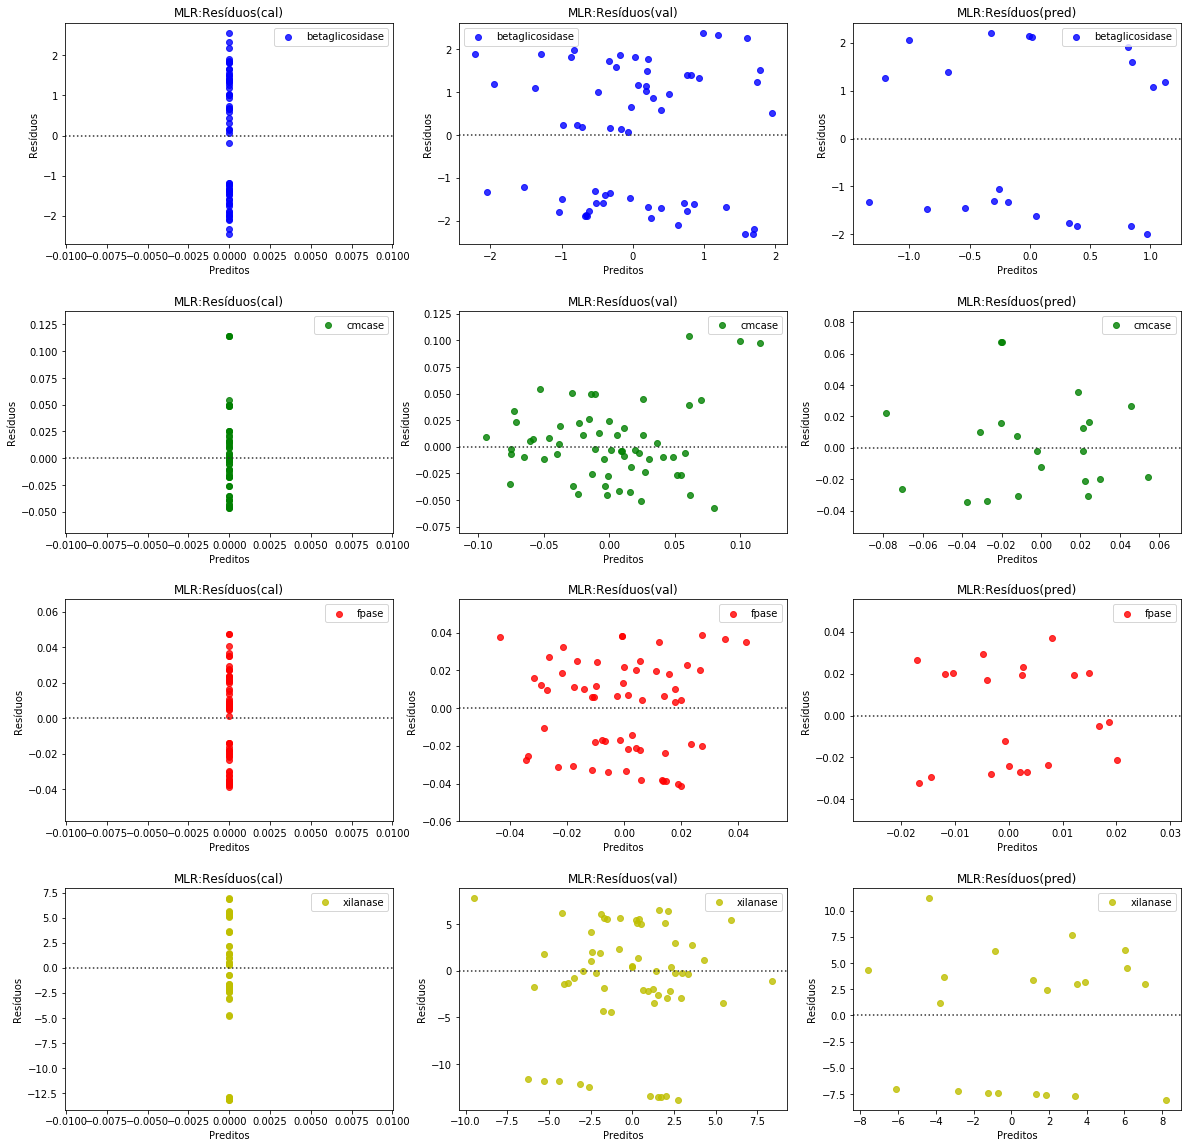

In [520]:
#gráfico dos resíduos
graficoResiduos(modelo, treino_teste, y_c,y_cv,y_p)

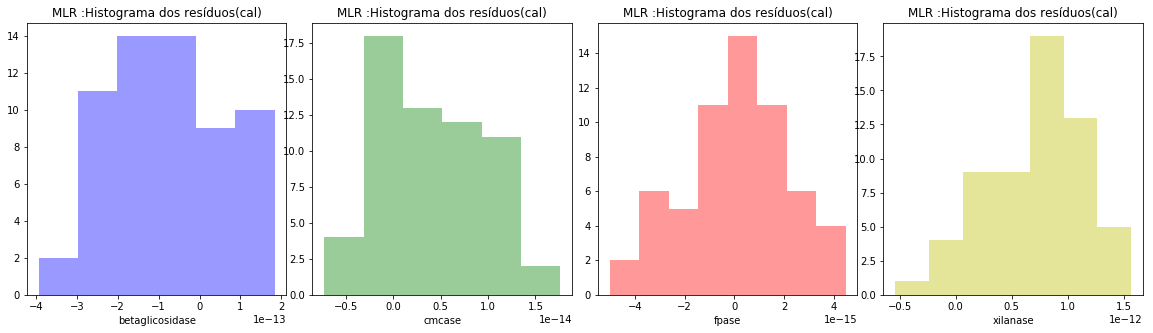

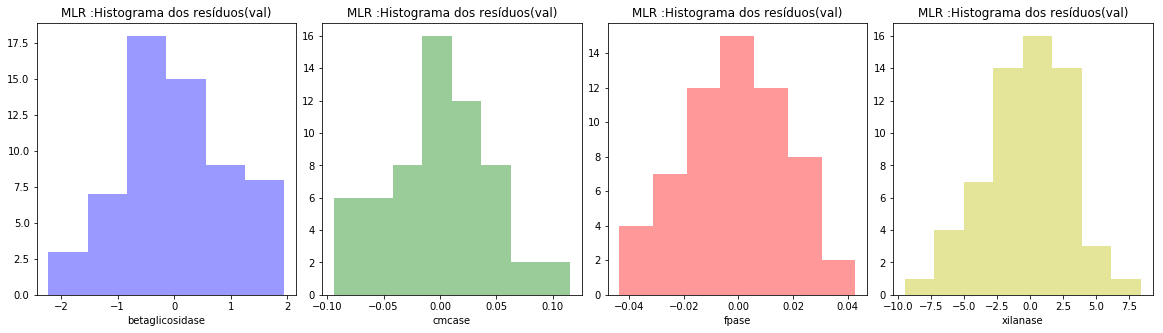

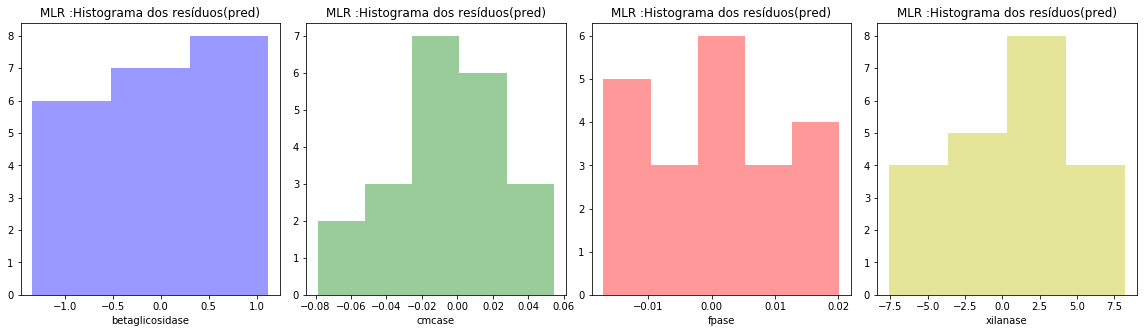

In [521]:
#histograma dos resíduos
graficoHist(modelo, treino_teste, y_c,y_cv,y_p)

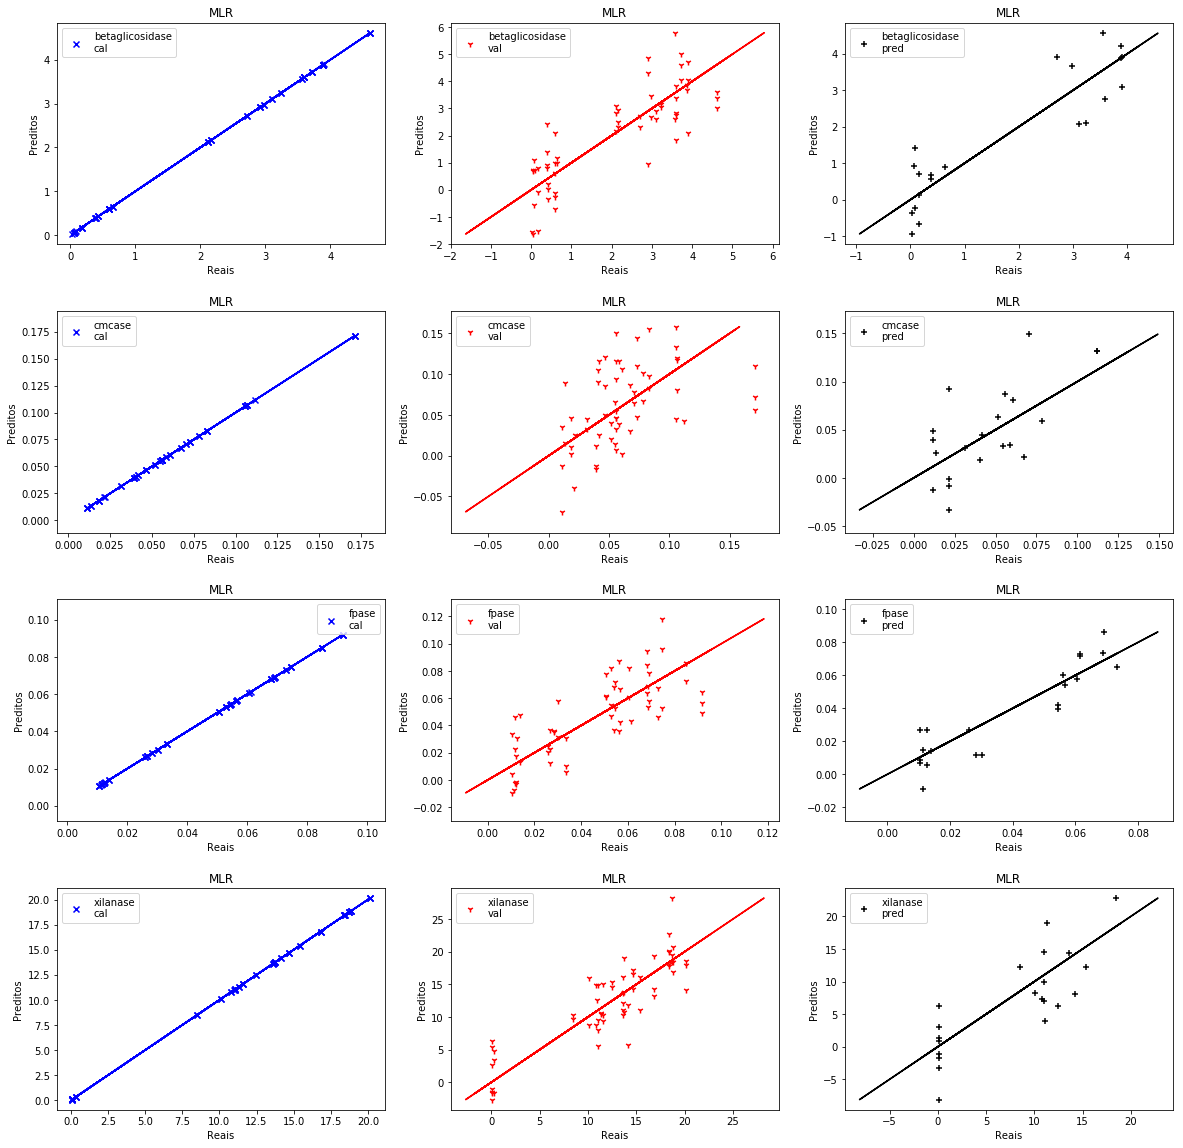

In [522]:
#graico de reais x preditos
graficoReaisPreditosSep(modelo, treino_teste, y_c,y_cv,y_p)

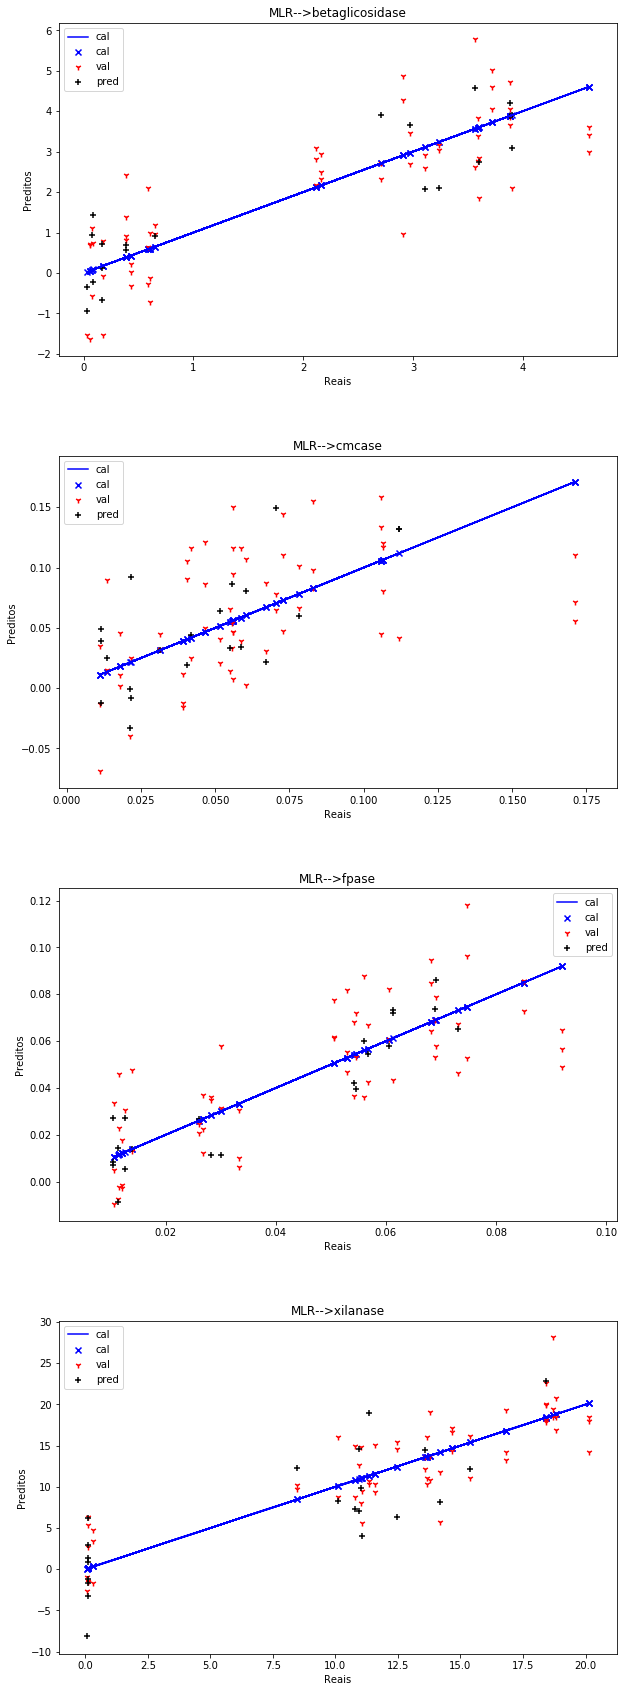

In [523]:
#graico de reais x preditos conjuntamente
graficoReaisPreditos(modelo, treino_teste, y_c,y_cv,y_p)

### MLR: Gráficos: dados de treino

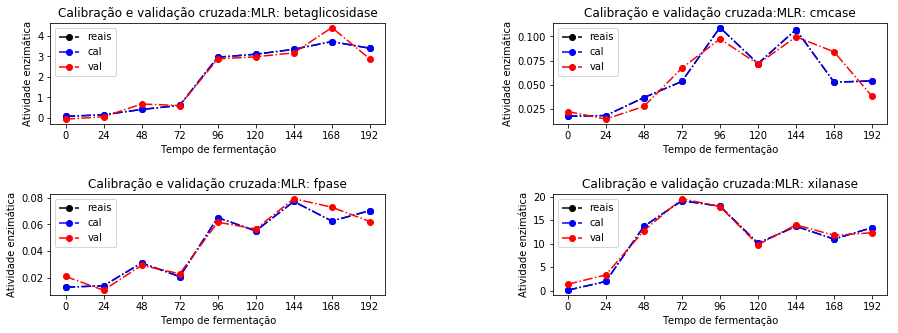

In [524]:
y_treino = treino_teste[2]
graficoTreinamento(modelo, y_treino, y_c,y_cv)

### MLR: Gráficos de  teste

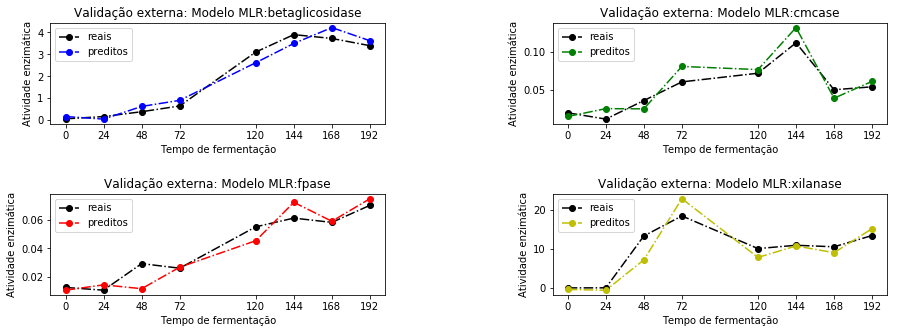

In [525]:
y_teste = treino_teste[3]
graficoTeste(modelo, y_teste, y_p)

# CONFIGURAÇÕES GERAIS:

In [725]:
#@config

#Formatação de fonte nos gráficos
#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
#plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
#plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#fig.tight_layout() #melhorando a visualziação dos gráficos sobrepostos mas muda a fonte
#plt.subplots_adjust(hspace = .5)#ajusta altura entre um gráfico e outro

# Referências

......inlcuir ref
#### Referência para cálculo das medidas: RMSE, RPD e RPIQ
- Prediction of Soil-Available Potassium Content with Visible Near-Infrared Ray Spectroscopy of Different Pretreatment Transformations by the Boosting Algorithms

#### Referência para cálculo de todas as medidas estatísticas : RMSEP, precisão, bias
- ESTADO DA ARTE DE FIGURAS DE MÉRITO EM CALIBRAÇÃO MULTIVARIADA (Quim. Nova, Vol. 32, No. 5, 1278-1287, 2009)

#### RMSEP, SEP, bias, RPD:
- ANÁLISE MULTIVARIADA DE IMAGENS NA QUÍMICA: UM EXPERIMENTO PARA DETERMINAÇÃO DO pH DE ÁGUAS POTÁVEIS
